<a href="https://colab.research.google.com/github/lamalex/thematic/blob/main/Alex_Launi_CS620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metadata
Name: Alexander L Launi

Web Home: https://lamalex.github.io/

# Data Sources:
*   Internet Movie Script Database scripts
     * https://www.imsdb.com/all%20scripts/
     * Unstructured text 
     * 1214 movie scripts listed at index
       * 1165 downloaded
         * 13 listed but unavailable
         * 49 404 errors
         * 5 non-english
     * 1147 used in project
       * 232MB plaintext
       * 7,374,129 lines (via wc -l)
       * 27,267,127 words (with stop words)
       * 15,836,918 words (without stop words)
       * 184,138 unique words


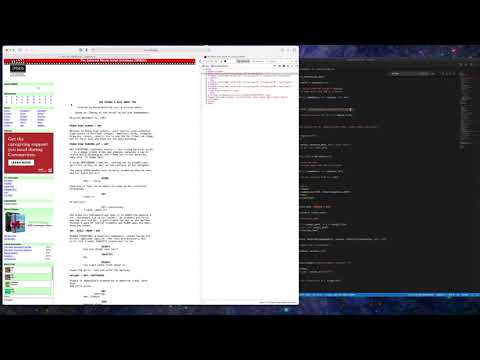

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('c4c9a1n3kn4')

# Goal
This project will yield a predictive model capable of generating **thematically aware** movie recommendations. I hope to build a system which, given a movie, will provide a recommendation based primarily on similar themes, settings, and dialog.

## Approach
I will use various means of vectorizing entire movie scripts. By computing document similarities on these mathematically analyzed scripts I hope to provide meaningful recommendations based on content, themes, and tone.

I will try different ways of vectorizing scripts to accomplish this ends.
1. A standard technique for vectorizing a document is to find the `term-frequency inverse document frequency (TF-IDF)` weighting.
>  This method attempts to quantify how important indidual words are to a document by finding words that are prevalent in a document, but less common in the entire corpus. This causes very common words to be de-weighted.

2. `word2vec` is a neural network technique for learning word associations from a body of text.
> `word2vec` is similar to an autoencoder. It compresses a corpus into a learned vector representing a sentence. In this project each "sentence" will be an entire script.
> Word2Vec requires a large volume of training data, so I will employ transfer learning and a pre-trained Word2Vec model trained on Google news as a starting point for my model.


I hope to offer movie recommendations that go deeper than finding movies rated well by individuals with overlapping rating histories. I want movies that *feel* similar to be recommended together.

I intend to try both methods of vectorizing my data, and compare the results. 

A little house keeping ... import modules and utility functions for the rest of this notebook.

In [ ]:
!pip install langdetect

import gc
import os
import re
import json
import string
import logging
import subprocess
from enum import Enum
from functools import reduce
from dataclasses import dataclass
from typing import List, Optional, Tuple

import nltk
import scipy
import numpy as np
import pandas as pd
from langdetect import detect
import gensim.downloader as api
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.sparse.csr import csr_matrix
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity


# A little data wrangling

### `Note:`
The code in this section is provided for reference only. The full [`download_data.py`](https://github.com/lamalex/thematic/blob/main/thematic/download_data.py) script scrapes imsdb.com and writes the content of each script to the local hard drive for follow on processing. It attempts to concurrenly download multiple scripts simultaneously while avoiding rate limiting by the imsdb server which will disconnect clients making too many connections. When a server disconnect occurs the script reduces its parallism and retries.

I have uploaded output of this script to an Amazon S3 bucket for consumption by this notebook.

In [ ]:
# Due to rate limiting at the script database, scripts have been bundled and uploaded to Amazon S3.
!wget https://s3.amazonaws.com/launi.stuffbucket/cs620-data.tar.bz2
!tar -xvf cs620-data.tar.bz2
!rm cs620-data.tar.bz2 # clean up unused archive files after extraction

--2020-11-30 14:46:01--  https://s3.amazonaws.com/launi.stuffbucket/cs620-data.tar.bz2
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.1.43
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48636434 (46M) [application/x-bzip2]
Saving to: ‘cs620-data.tar.bz2’

cs620-data.tar.bz2  100%[===================>]  46.38M  33.3MB/s    in 1.4s    

2020-11-30 14:46:03 (33.3 MB/s) - ‘cs620-data.tar.bz2’ saved [48636434/48636434]

scripts/
scripts/Roughshod Script.txt
scripts/Alien Script.txt
scripts/Kids Script.txt
scripts/South Park Script.txt
scripts/Manhattan Murder Mystery Script.txt
scripts/War for the Planet of the Apes Script.txt
scripts/Taxi Driver Script.txt
scripts/Wild Things Script.txt
scripts/Jennifer Eight Script.txt
scripts/Men Who Stare at Goats, The Script.txt
scripts/Grand Theft Parsons Script.txt
scripts/Gothika Script.txt
scripts/American Sniper Script.txt
scripts/Dallas Buyers Club S

## Getting our hands dirty

Collecting the data for this project required doing a fair amount of web scraping.

The [script index](https://www.imsdb.com/all%20scripts/) at imsdb contains a link to each individual page for each script hosted in the repository.

![Index page for imsdb](https://s3.amazonaws.com/launi.stuffbucket/Screen+Shot+2020-11-28+at+17.22.15.png)

If we inspect the HTML a pattern that can be exploited is evident:
```html
...
<p>
    <a 
        href="/Movie Scripts/10 Things I Hate About You Script.html" 
        title="10 Things I Hate About You Script">
            10 Things I Hate About You
    </a>(1997-11 Draft)<br>
    <i>Written by Karen McCullah Lutz,Kirsten Smith,William Shakespeare</i><br>
</p>
...
```

Every script has its own page with an anchor tag `<a>` and is prefixed by `/Movie Scripts/{script title}`.

To download every script listed in the imsdb index we can parse this page and queue a download of every URL which matches the selector `a[href*="/Movie Scripts/"]`

In [ ]:
async def fetch_all_scripts(sempahore: RateLimitingSemaphore, session: aiohttp.ClientSession, url: str):
    """
    Fetches list of scripts and passes them to downloader
    """
    text = await do_the_fetch(sempahore, session, url)
    if text is None:
        yield None

    for script_url in load_html(text).select('a[href*="/Movie Scripts/"]'):
        try:
            full_url = "{0}{1}".format(
                'https://www.imsdb.com', script_url["href"])
            yield full_url
        except KeyError

This brings us to a landing page for each movie containing reviews, imdb links, comments from script readers, ads, other metadata about the script, and a link to the full text of the script.

Here I hit a small snag. Although the vast majority of the scripts linked are available as HTML, some are in pdf format. For reading PDFs I used the unix utility `ps2ascii` as a subprocess. There are pdf libraries available for python, but many of them were focused on pdf file format specific tasks and were fragile to inconsistencies inside of the pdf scripts. `ps2ascii` although inelegant provided a robust solution for converting the binary pdf data into text.  

![imsdb script landing page for 10 Things I Hate About You](https://s3.amazonaws.com/launi.stuffbucket/Screen+Shot+2020-11-28+at+17.42.36.png)

Again we use the HTML structure of this page to extract a link where we can access the data we are seeking.
The selector `a[href*="/scripts/"]` yields a URL to the script.

In [ ]:
async def _extract_script_url(self) -> Optional[str]:
    """
    Pull the url of the actual script from the script's homepage
    May return None if a status code other than 200 is returned
    """
    text = await do_the_fetch(self.semaphore, self.session, self.url)
    if text is None:
        return None

    urls = load_html(text).select('.script-details a[href*="/scripts/"]')
    if len(urls) == 0:
        logging.warning("No candidate scripts for %s", self.movie_title)
        return None
    elif len(urls) > 1:
        logging.warning(
            "Multiple candidate scripts for %s. Returning the first. Double check your data.",
            self.url)

    resource_path = urls.pop().get("href")
    parts = urlparse(self.url)
    full_url = urlunparse(
        (parts.scheme, parts.netloc, resource_path, None, None, None))
    logging.info("Found script url: %s", full_url)
    return full_url

On the script page we have to do some further scraping to finally get the data we are seeking.

![Script text page at imsdb](https://s3.amazonaws.com/launi.stuffbucket/Screen+Shot+2020-11-28+at+19.34.13.png)

Again we have a nice snippet of HTML we can grab:
```html
<td class="scrtext">
    ...
```

which we can then get the inner text by using an HTML parser library like `BeautifulSoup4`.

In [ ]:
async def _download_script(self, url) -> Optional[str]:
    """
    Download the script and return the text
    May return None if a status code other than 200 is returned
    """
    text = await do_the_fetch(self.semaphore, self.session, url)
    if text is None:
        logging.warning("No text was returned from %s", url)
        return None

    if url.lower().endswith('pdf'):
        ps2ascii = subprocess.Popen(
            'ps2ascii', stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        ps2ascii.stdin.write(text)
        text = ps2ascii.communicate()[0]
        return str(text)

    return load_html(text).select_one('.scrtext').text

# Load the data

In [ ]:
DATA_DIR = os.path.abspath('scripts')


class Columns(Enum):
  def __str__(self):
    return self.value

  TITLE = 'Movie Title'
  TEXT = 'Script'
  TOKENS = 'Tokenized Script'
  WC = 'Word Count'
  TOKEN_COUNT = 'Token Count'


def setup_logging():
  """
  Initialize logging system at desired level
  """
  logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s %(levelname)-8s %(message)s',
                      datefmt='%m-%d %H:%M')


def _file_name_to_movie_title(file: str) -> str:
  """
  Clean up file name to remove ' Script.txt'
  Args:
    file: movie script filename from imsdb.com

  Returns:
    Movie title from script file name
  """
  raw_from_disk = os.path.splitext(os.path.basename(file))[0]
  return (raw_from_disk[:-len('Script')]
          if raw_from_disk.endswith("Script") else raw_from_disk).strip()


def load_data() -> pd.DataFrame:
  """
  Reads in all scripts from global DATA_DIR into a Pandas dataframe

  Returns:
    pd.DataFrame like
    Movie Title | Script Text | Word Count
  """
  scripts = []
  script_files = map(
    lambda f: os.path.join(
      DATA_DIR,
      f),
    os.listdir(DATA_DIR))


  for script_file in script_files:
    if not script_file.endswith(".txt"):
      continue

    with open(script_file) as reader:
      movie_title = _file_name_to_movie_title(script_file)
      raw_script = reader.read()
      scripts.append({ 
        Columns.TITLE: movie_title,
        Columns.TEXT: raw_script,
        Columns.WC: len(raw_script.split())
      })
      logging.info("Read in %s (%d)", movie_title, len(raw_script))

  return pd.DataFrame(data=scripts, columns=[Columns.TITLE, Columns.TEXT, Columns.WC])


setup_logging()
nltk.download('punkt')
nltk.download('stopwords')

df = load_data()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


11-30 15:22 INFO     Read in Pitch Black (162359)
11-30 15:22 INFO     Read in Harold and Kumar Go to White Castle (255940)
11-30 15:22 INFO     Read in Something's Gotta Give (207489)
11-30 15:22 INFO     Read in Gamer (230303)
11-30 15:22 INFO     Read in Mini's First Time (273138)
11-30 15:22 INFO     Read in Happy Feet (126537)
11-30 15:22 INFO     Read in Bean (224972)
11-30 15:22 INFO     Read in Grand Theft Parsons (216993)
11-30 15:22 INFO     Read in Legend (153891)
11-30 15:22 INFO     Read in Boondock Saints 2: All Saints Day (245428)
11-30 15:22 INFO     Read in Dallas Buyers Club (173893)
11-30 15:22 INFO     Read in Bodies, Rest & Motion (186717)
11-30 15:22 INFO     Read in Pearl Harbor (200973)
11-30 15:22 INFO     Read in Battle: Los Angeles (172498)
11-30 15:22 INFO     Read in Judge Dredd (214217)
11-30 15:22 INFO     Read in Scream 3 (113172)
11-30 15:22 INFO     Read in Mission to Mars (277468)
11-30 15:22 INFO     Read in BlacKkKlansman (303969)
11-30 15:22 INFO  

# Data cleaning
Before training models or trying to build a data product it is useful to clean any obviously data that could corrupt our dataset.

Given our rather bruteforce web scraping approach for gathering the dataset it's worth our time to do a little poking around and eliminating bad data.

An easy first check is script length. Movies are lengthy, we should easily see more than 1000 words in a script. If there is less then there is likely a problem with the data.

In [ ]:
# Remove incomplete scripts. 1000 as length threshold
MIN_LENGTH_THRESHOLD = 1000
too_short = df[df[Columns.WC] < MIN_LENGTH_THRESHOLD]
too_short

11-29 17:40 INFO     NumExpr defaulting to 2 threads.


,Movie Title,Script,Word Count
253,Scary Movie 2,\n\n\n\n\nScary Movie 2\nWriters : Shawn Way...,19
261,Jade,b'',1
279,Shadow of the Vampire,b'',1
473,"Neverending Story, The",\n\n\nScript\n\n\n\n\n \n \n \n This...,12
499,Robocop,b'',1
626,8 Mile,b'',1
632,"Lion King, The",b'',1
679,Sneakers,b'Error: /syntaxerror in /----nostringval----\...,51
834,When Harry Met Sally,b'',1
983,Equilibrium,b'',1


In [ ]:
print(f'{len(too_short)} are too short to use')

13 are too short to use


There are 13 scripts which had download links available, but which didn't contain useful data. We will remove these.

In [ ]:
# Remove incomplete scripts. 1000 as length threshold
MIN_LENGTH_THRESHOLD = 1000
df = df[df[Columns.WC] > MIN_LENGTH_THRESHOLD]
df.reset_index(inplace=True, drop=True)

11-30 15:22 INFO     NumExpr defaulting to 2 threads.


Our system will be only built for English, but the imsdb contains scripts in other languages as well! We should remove non-english scripts.

In [ ]:
langs = df[Columns.TEXT].apply(detect)
df[langs != 'en']

,Movie Title,Script,Word Count
29,Un Singe en Hiver,\n\n\n UN SINGE E...,32440
92,Les Tontons Flingueurs,\n\n\n\n LES TONTO...,32930
637,Jeux Interdits,\n\n\n\n JEUX I...,25782
905,Le Diable par la Queue,\n\n\n\n LE DIABL...,30300
1048,Ni vu ni connu,\n\n\n\n NI VU ...,39377


Remove these 5 non-english (actually all French!) scripts

In [ ]:
df = df[langs == 'en']
df.reset_index(inplace=True, drop=True)

To get a sense of whether or not the idea of using ngrams pulled from the scripts was a feasible project, I did some basic analysis looking at script length distribution, common words, and `hierarchal agglomerative clustering` on the scripts.

## Script length distribution

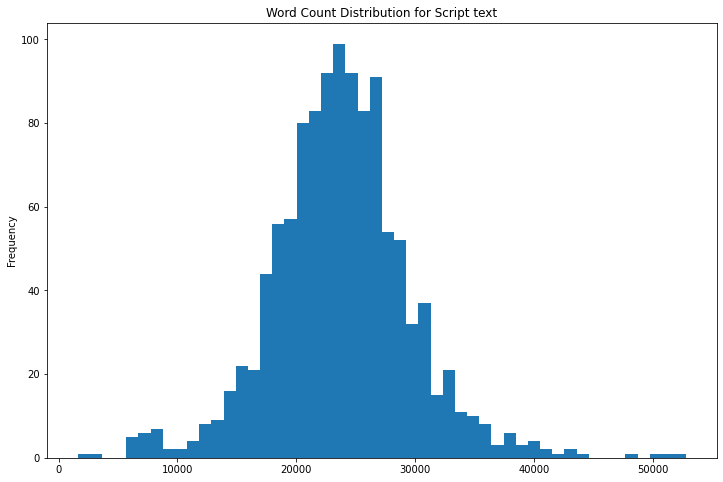

In [ ]:
df[Columns.WC].plot(
  kind='hist',
  bins = 50,
  figsize = (12,8),
  title='Word Count Distribution for Script text'
)

This shows a wide distribution of script lengths.
This is performed on uncleaned scripts, so the exact numbers are not quite right but it is still useful for quickly visualizing the amount of data we are working with. Text processing is the next step.

(-0.5, 1023.5, 511.5, -0.5)

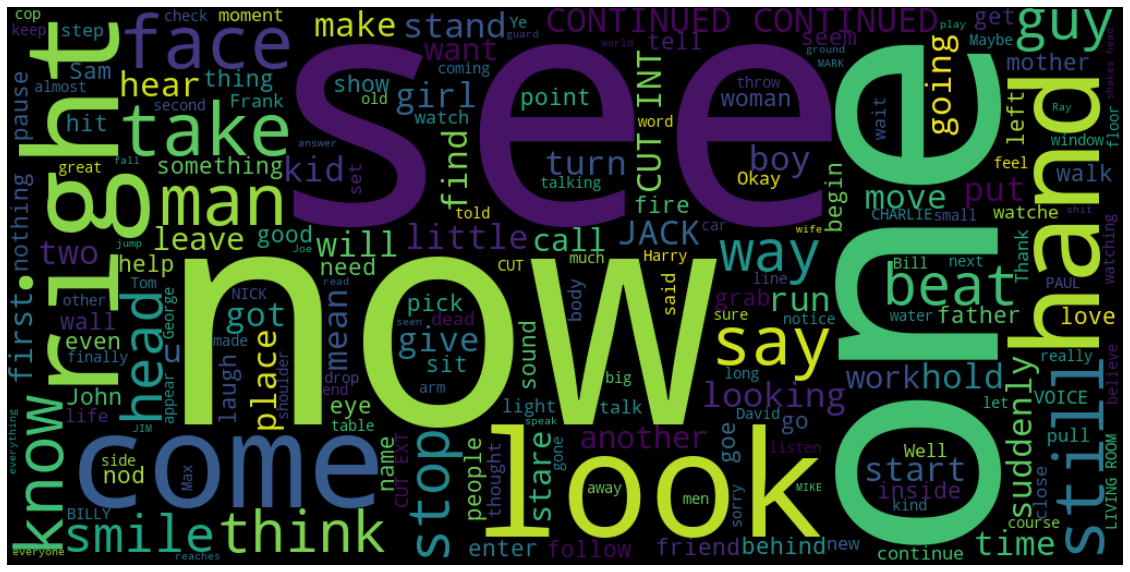

In [ ]:
wc = WordCloud(width=1024, height=512).generate(' '.join(df[Columns.TEXT]))
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# Text Preprocessing
Preprocessing is done during the tokenization phase:
A snowball stemmer is used as a compromise between speed and greediness of stemming.

## Prior to actual tokenization raw strings are processed
1. Remove punctuation
2. Strip excess whitespace


In [ ]:
_RE_WHITESPACE = re.compile(r'\s+', re.MULTILINE | re.IGNORECASE)

def _process_as_string(text: str) -> str:
  cleaned = _remove_punctuation(text)
  cleaned = _compress_whitespace(cleaned)
  return cleaned


def _remove_punctuation(text: str) -> str:
  punctuation_replacement_table = text.maketrans(
    '', '', string.punctuation)
  return text.translate(punctuation_replacement_table)


def _compress_whitespace(text: str) -> str:
  return re.sub(_RE_WHITESPACE, ' ', text)

## Processing tokens
The cleaned scripts are tokenized by word, and each word token is stemmed and converted to lower case, and stop words removed.

In [ ]:
# Use set() here to optimize stopword lookup from O(n) to O(1)
# in tokens_filter by using a HashSet instead of a list
eng_stopwords = set(stopwords.words('english'))

def _process_tokenized(tokens: List[str]) -> List[str]:
  stemmer = SnowballStemmer('english', ignore_stopwords=True)
  clean_tokens = _normalize_case(tokens)
  tokens_filter = filter(lambda word: word not in eng_stopwords, clean_tokens)
  return [stemmer.stem(token) for token in tokens_filter]


def _normalize_case(text: List[str]) -> List[str]:
  return [w.lower() for w in text]


def tokenize(text: str) -> List[str]:
  """
  Take unprocessed script input and clean the data for follow on
  processing.
    - Trim newlines and excess spacing that is present in scripts
    - Truncate trailing imsdb metadata
    - Tokenize
    - Remove punctuation marks
    - Convert to lower case
  """
  # Process input in its string format
  cleaned = _process_as_string(text)
  # tokenize
  cleaned = nltk.word_tokenize(cleaned)
  # process after tokenization
  tokens = _process_tokenized(cleaned)
  return tokens


df[Columns.TOKENS] = df[Columns.TEXT].apply(tokenize)
df[Columns.TOKEN_COUNT] = df[Columns.TOKENS].apply(len)

## Post tokenization textual analysis

In [ ]:
print(f'Count: {df[Columns.TOKEN_COUNT].sum()}')
toks = pd.DataFrame([word for token_list in df[Columns.TOKENS] for word in token_list], columns=['word'])
print(f'Num. Unique: {len(toks["word"].unique())}')
toks.value_counts()

Count: 15836918
Num. Unique: 184138


word       
look           134944
back            94463
int             92409
get             83162
go              76552
                ...  
mothaddl            1
mothafuckah         1
mothefuck           1
mothera             1
                   1
Length: 184138, dtype: int64

(-0.5, 1023.5, 511.5, -0.5)

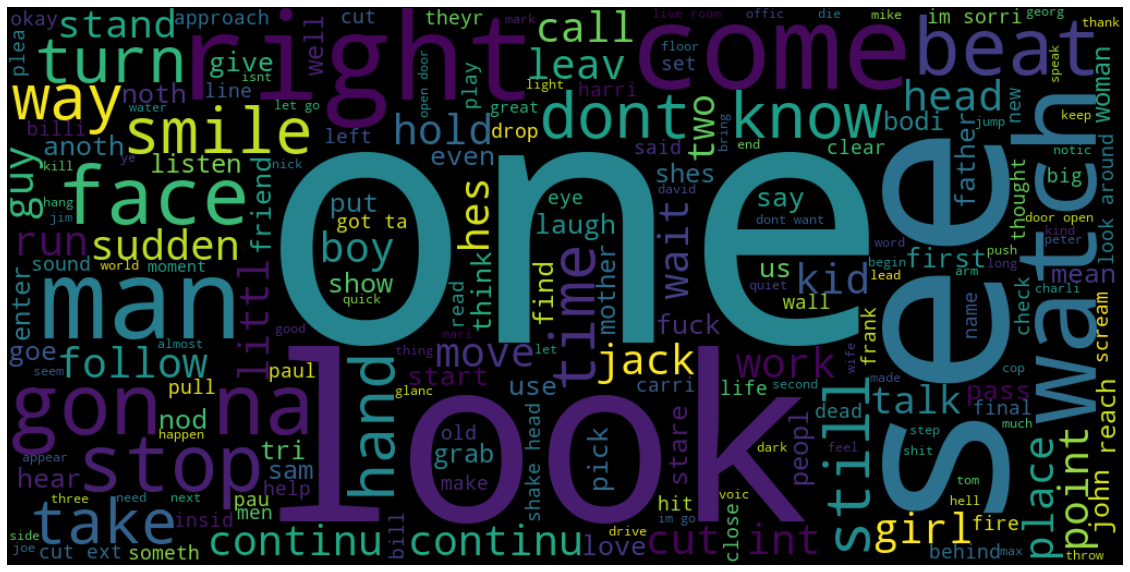

In [ ]:
wc = WordCloud(width=1024, height=512).generate(' '.join(toks['word']))
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

(-0.5, 1023.5, 511.5, -0.5)

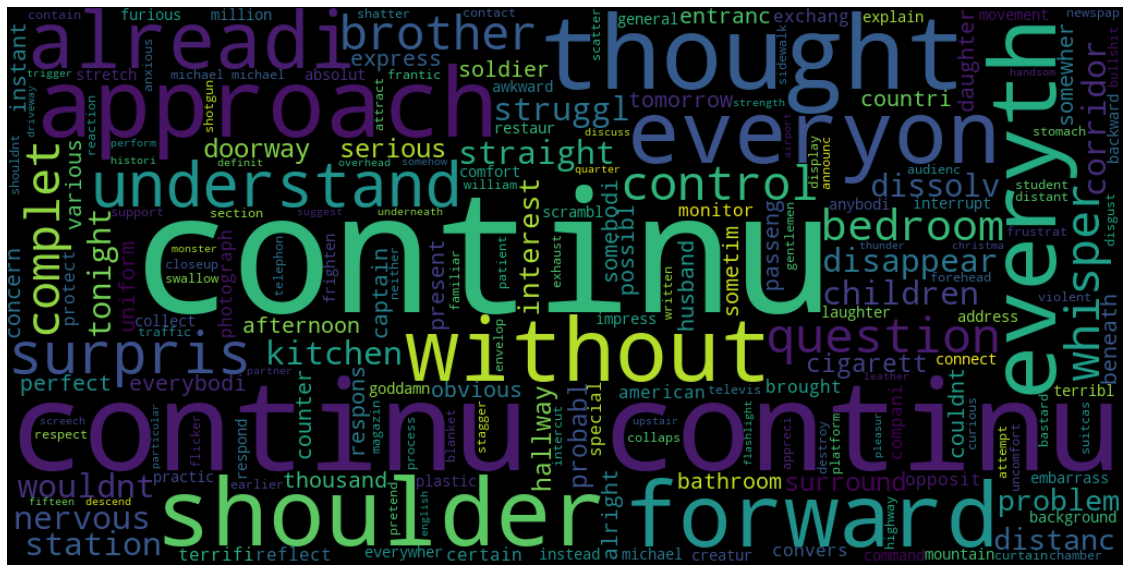

In [ ]:
wc = WordCloud(width=1024, height=512).generate(' '.join(toks[toks['word'].str.len() > 6]['word']))
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

As a check on our text processing pipeline let's check that the distribution of lengths has remained similar.

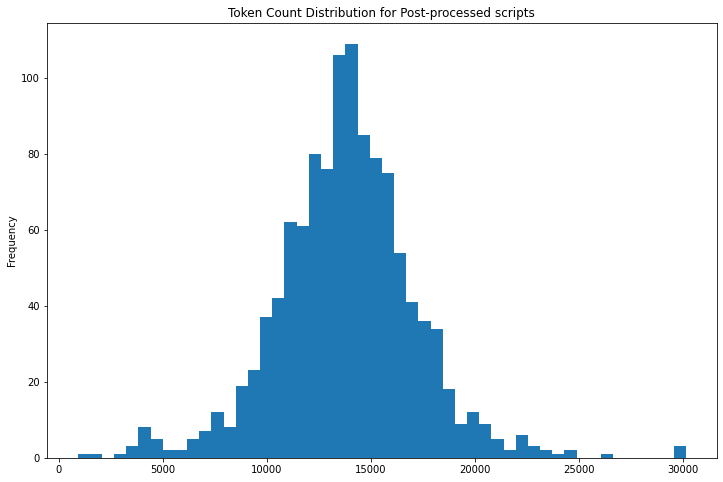

In [ ]:
df[Columns.TOKEN_COUNT].plot(
  kind='hist',
  bins = 50,
  figsize = (12,8),
  title='Token Count Distribution for Post-processed scripts'
)

We still see a *normalish* distribution of script length, as we expect.

Which are the longest scripts?

In [ ]:
df.nlargest(10, Columns.TOKEN_COUNT)

,Movie Title,Script,Word Count,Tokenized Script,Token Count
780,Casino,\n\n\n\nCasino - Draft \n\n\n ...,51667,"[casino, draft, casino, nichola, pileggi, ext,...",30156
300,"Officer and a Gentleman, An",b' AN OFFICER AND A GENTLEMAN\r...,48205,"[b, offic, gentlemanrn, byrn, dougla, day, ste...",29870
563,JFK,\n J...,52788,"[jfk, oliv, stone, zachari, sklar, base, book,...",29846
944,Gandhi,\n\n\n\n ...,50141,"[gandhi, written, john, briley, final, draft, ...",26554
781,Titanic,\n\n\n T I T A N...,43639,"[n, c, screenplay, jame, cameron, 1, black, tw...",24791
1013,"Island, The",\n\n\n\n THE ISL...,43468,"[island, written, caspian, tredwellowen, 11304...",24540
99,Kill Bill Volume 1 & 2,\n TABLE OF CONTENTS\n\n ...,42614,"[tabl, content, prologu, 1, 2, 2, comatos, bri...",23750
891,Pretty Woman (final script),\n\n\n \n PRETTY WOMA...,41549,"[pretti, woman, final, script, jonathan, frede...",23497
104,"Curious Case of Benjamin Button, The",\n\n\n\n THE CURIOUS CASE OF ...,40075,"[curious, case, benjamin, button, written, eri...",23246
839,Magnolia,"\n\n\n\n ""Magnolia"", shooting draft, by Paul...",41002,"[magnolia, shoot, draft, paul, thoma, anderson...",23118


What about shortest scripts?

In [ ]:
df.nsmallest(10, Columns.TOKEN_COUNT)

,Movie Title,Script,Word Count,Tokenized Script,Token Count
426,"Things My Father Never Taught Me, The",\n\n\n\n\n THE THINGS MY ...,1592,"[thing, father, never, taught, written, burlei...",892
341,"Miracle Worker, The",\n\n\n\n THE MIRA...,3426,"[miracl, worker, written, william, gibson, jul...",2005
294,Pokemon: Mewtwo Returns,\nMovie: MewTwo Strikes Back ***This is not an...,5869,"[movi, mewtwo, strike, back, offici, manuscrip...",3154
771,Orgy of the Dead,\n\n\nOrgy of the Dead\n\n\n\n\n\n\nback\n\n\n...,6183,"[orgi, dead, back, orgi, dead, edward, wood, j...",3463
336,Napoleon Dynamite,\n\nNapoleon Dynamite\n\n\n\n\n\n\n\n\n Error...,5888,"[napoleon, dynamit, error, submit, error, lane...",3491
78,Quantum Project,\n\n\n\nQUANTUM PROJECT: ORIGINAL SCREENPLAY\n...,5926,"[quantum, project, origin, screenplay, 1, int,...",3599
788,My Mother Dreams the Satan's Disciples in New ...,\n\n\n\nMY MOTHER DREAMS THE SATAN'S DISCIPLES...,7015,"[mother, dream, satan, discipl, new, yor, moth...",3989
1119,"Nightmare Before Christmas, The",\nThe script to\n Tim Burton's The Nightmare B...,6763,"[script, tim, burton, nightmar, christma, narr...",4052
917,Walking Tall,\n\n \n ...,6737,"[walk, tall, written, mort, briskin, david, kl...",4053
100,Dark Star,"\n\n\n\n ""Dark Star"", short film script, by ...",6827,"[dark, star, short, film, script, john, carpen...",4098


We see that __The Things My Father Never Taught Me__ is very short compared to the others.

According to [imdb](https://www.imdb.com/title/tt2234521/?ref_=fn_al_tt_1), __The Things My Father Never Taught Me__ is a 7 minute short film, which explains the short script!

# Hierarchal Agglomerative Clustering
A central idea of the system is that films with similar themes will be written similarly. Mathematically this can be exploited and represented as the Term-Frequency Inverse Document Frequency. This is the same measure used in word clouds which gives more frequent terms their larger size. By comparing these weighted vectors representing word frequency in each document we can attempt to find families of similar text bodies. Our hope is that this reveals neighborhoods of related films.

Once the data has been tokenized it is then clustered by ngram. The Scikit-learn Tfidf-Vectorizer takes a tuple for min-max ngram parameter.
This is where the art meets the science; these values will determine how much context is considered during clustering. The 0th element of the shape tuple will set the smallest ngram to consider, and the 1st element the max. (2,4) was used for this project, meaning the smallest group of words considered as a single unit was 2, and the largest 4. This was empirically determined by trying different values and observing the clustered results.

Do to Colab memory constraints TF-IDF vectorization cannot be run on an ngram range greater than (2,4).

In [ ]:
@dataclass
class TfidfModel:
  tfidf_matrix: scipy.sparse.csr.csr_matrix
  cosine_similarity: np.ndarray
  indices: pd.Series

  @staticmethod
  def load(input_file: str) -> "TfidfModel":
    loaded = np.load(input_file, allow_pickle=True)
    return TfidfModel(
      tfidf_matrix=loaded['tfidf_matrix'],
      cosine_similarity=loaded['cosine_sim'],
      indices=loaded['indices']
    )

  def save(self, output_file: str):
    np.savez_compressed(
      "{}.npz".format(output_file),
      tfidf_matrix=self.tfidf_matrix,
      cosine_sim=self.cosine_similarity,
      indices=self.indices
    )


class TfidfRecommender:
  def __init__(self, ngram_range=(3,5), model: Optional[TfidfModel]=None):
    self.tfidf_vectorizer = TfidfVectorizer(
        use_idf=True,
        lowercase=False,
        tokenizer=lambda x: x,
        ngram_range=ngram_range)

    if model is not None:
      self._tfidf_matrix = model.tfidf_matrix
      self._cosine_sim = model.cosine_similarity
      self._indices = model.indices

  def save(self, output_file: str):
    TfidfModel(
        tfidf_matrix=self._tfidf_matrix,
        cosine_similarity=self._cosine_sim,
        indices=self._indices
    ).save(output_file)

  @staticmethod
  def load(input_file: str) -> "TfidfRecommender":
    model = TfidfModel.load(input_file)
    return TfidfRecommender(model=model)

  def fit(self, df: pd.DataFrame, ngram_range: Tuple[int, int]=(3, 5)):
    logging.info("Begin Vectorizing")
    self._tfidf_matrix = self.tfidf_vectorizer.fit_transform(df[Columns.TOKENS])
    self._cosine_sim = cosine_similarity(self._tfidf_matrix)
    self._indices = pd.Series(df.index, index=df[Columns.TITLE])
    logging.info("End Vectorizing")

  def predict(self, title: str, n: int) -> List[Tuple[str, float]]:
    try:
      idx = self._indices[title]
    except KeyError:
      print("I don't know anything {}. How about {}?".format(title, self._indices.sample(1)))
      return
    
    top_recommended = sorted(enumerate(self._cosine_sim[idx]), key=lambda x: x[1], reverse=True)[1:n+1]
    return df[Columns.TITLE].iloc[[i[0] for i in top_recommended]]

gc.collect()
recommendation_engine = TfidfRecommender(ngram_range=(2,4))
recommendation_engine.fit(df)
gc.collect()

11-30 15:03 INFO     Begin Vectorizing
11-30 15:10 INFO     End Vectorizing


0

Each script is iteratively passed to the tokenizer which first processes the full text for each script as a single string.

# Visualizing the TF-IDF vectored scripts

Colab does not support loading javascript libaries, so this dendrogram was generated on my workstation and just the SVG output is copied to Colab. The code to generate the cluster output json is provided for reference, but is not actually used

In [ ]:
def _add_node(node, parent):
  """
  Create a nested dictionary from the ClusterNode's returned by SciPy
  """
  # First create the new node and append it to its parent's children
  new_node = dict(node_id=node.id, children=[])
  parent["children"].append(new_node)
  # Recursively add the current node's children
  if node.left:
    _add_node(node.left, new_node)
  if node.right:
    _add_node(node.right, new_node)


def _label_tree(node, name_map):
  """
  Label each node with the names of each leaf in its subtree
  """
  # If the node is a leaf, then we have its name
  if len(node["children"]) == 0:
    leaf_names = [name_map[node["node_id"]]]

  # If not, flatten all the leaves in the node's subtree
  else:
    leaf_names = [
      reduce(
        lambda ls,
        c: ls +
        _label_tree(
          c,
          name_map),
        node["children"],
        [])]

  # Delete the node id since we don't need it anymore and
  # it makes for cleaner JSON
  del node["node_id"]

  # Labeling convention: "-"-separated leaf names
  node["name"] = "-".join(sorted(map(str, leaf_names)))
  return leaf_names
  

def cluster(recommender: TfidfRecommender, df: pd.DataFrame):
  """
  Read all script files and vectorize them using TF-IDF vectorizer.
  Use cosine distance to perform hierarchal clustering on ngrams
  """
  logging.info("Begin Clustering")
  cosine_dist = 1 - recommender._cosine_sim
  cosine_dist_matrix = distance.pdist(cosine_dist)
  clusters = hierarchy.linkage(cosine_dist_matrix, method="weighted")
  tree = hierarchy.to_tree(clusters)
  logging.info("End Clustering")

  id_name_map = dict(zip(range(len(df[Columns.TITLE])), df[Columns.TITLE]))
  dendro_map = dict(children=[], name="Root1")
  _add_node(tree, dendro_map)
  _label_tree(dendro_map["children"][0], id_name_map)
  
  logging.info("Finished!")
  return dendro_map

In [ ]:
%%html
<!DOCTYPE html>
<html>
  <head>
    <meta charset="utf-8">
    <style>

    div.note{
        width:900px;
        font-family: 'Cuprum', serif;
        font-size:21px;
    }

    table, th, td {
        border: 1px solid black;
    }

    .node circle {
        fill: black;
        stroke: hotpink;
        stroke-width: 1px;
    }

    .node {
        font: 9px sans-serif;
        font-family: 'Cuprum', serif;
        color: #ccc
    }

    .link {
        fill: none;
        stroke: #ccc;
        stroke-width: 2px;
    }

    body{
        background-color: black;
    }

    </style>
  </head>
  <body>
      <div id="vis"><svg width="6144" height="6144"><g transform="translate(2048,2048)"><path class="link" d="M0,0C1.059338889451016,-16.586896205464516 1.059338889451016,-16.586896205464516 2.118677778902032,-33.17379241092903"></path><path class="link" d="M2.118677778902032,-33.17379241092903C61.4416555881588,-962.0399799169398 4.722167161591415,-963.988434130461 9.281500972783125,-1894.7358877736644"></path><path class="link" d="M2.118677778902032,-33.17379241092903C3.1780166683530413,-49.76068861639344 6.100768452710107,-49.487438262739104 8.1343579369468,-65.9832510169854"></path><path class="link" d="M9.281500972783125,-1894.7358877736644C9.362917647982977,-1911.356378017293 6.241958967149027,-1911.369118187934 6.296236871211193,-1927.9897192156552"></path><path class="link" d="M9.281500972783125,-1894.7358877736644C9.362917647982977,-1911.356378017293 12.483851365590438,-1911.3385418259502 12.592406594856444,-1927.958876972263"></path><path class="link" d="M8.1343579369468,-65.9832510169854C107.78024266454523,-874.2780759750575 17.19188916614324,-880.7287742468596 33.0862772631436,-1694.9874523241451"></path><path class="link" d="M8.1343579369468,-65.9832510169854C10.167947421183507,-82.4790637712318 18.605943611295775,-80.99383913404868 22.327132333554935,-97.19260696085847"></path><path class="link" d="M33.0862772631436,-1694.9874523241451C35.35690413414365,-1811.3101206209 23.664535219565746,-1811.5006081993163 25.184276013482812,-1927.835509643309"></path><path class="link" d="M33.0862772631436,-1694.9874523241451C33.410652530429324,-1711.6049763665385 44.458012759688515,-1711.3536606811192 44.88964395153016,-1727.968744765402"></path><path class="link" d="M44.88964395153016,-1727.968744765402C47.47943110257997,-1827.6592492710984 35.82118811450127,-1827.924908278807 37.77507110256497,-1927.6299032758327"></path><path class="link" d="M44.88964395153016,-1727.968744765402C45.32127514337179,-1744.5838288496848 56.44775421041587,-1744.2592711260122 56.98535186956269,-1760.8712641843551"></path><path class="link" d="M56.98535186956269,-1760.8712641843551C59.67334016529678,-1843.93122947607 48.19338170484894,-1844.266977561401 50.36425475461691,-1927.3420666407435"></path><path class="link" d="M56.98535186956269,-1760.8712641843551C57.52294952870951,-1777.4832572426983 68.58698659225924,-1777.0907249689837 69.22798646695324,-1793.699049501404"></path><path class="link" d="M69.22798646695324,-1793.699049501404C71.79198596572928,-1860.1323476310856 60.78055579534766,-1860.5247012575903 62.9512899308958,-1926.9720120167901"></path><path class="link" d="M69.22798646695324,-1793.699049501404C69.86898634164726,-1810.3073740338243 80.58301961703422,-1809.8621054331875 81.32231337498867,-1826.4663449325747"></path><path class="link" d="M81.32231337498867,-1826.4663449325747C83.540194648852,-1876.279063430736 73.58213176143956,-1876.6959684178814 75.53563968430963,-1926.5197551900374"></path><path class="link" d="M81.32231337498867,-1826.4663449325747C82.06160713294311,-1843.070584431962 91.84111014424877,-1842.609154718137 92.66850753293569,-1859.209237193075"></path><path class="link" d="M92.66850753293569,-1859.209237193075C94.32330231030954,-1892.4094021429516 86.59751257573186,-1892.7786720833108 88.11676718232363,-1925.9853154531932"></path><path class="link" d="M92.66850753293569,-1859.209237193075C93.49590492162261,-1875.8093196680134 101.15236659175905,-1875.4120311876466 102.04752027841178,-1892.0085978353247"></path><path class="link" d="M102.04752027841178,-1892.0085978353247C102.94267396506451,-1908.605164483003 99.82608283563613,-1908.7707094357775 100.69413572985906,-1925.3687156047843"></path><path class="link" d="M102.04752027841178,-1892.0085978353247C102.94267396506451,-1908.605164483003 106.05899063076458,-1908.434530844758 106.98124272320602,-1925.029613721669"></path><path class="link" d="M22.327132333554935,-97.19260696085847C223.2713233355494,-971.9260696085847 63.4623475967063,-995.2200254447827 120.57846043374198,-1890.918048345087"></path><path class="link" d="M22.327132333554935,-97.19260696085847C26.048321055814103,-113.39137478766825 44.009557958073685,-107.69994296376933 50.29663766636993,-123.08564910145068"></path><path class="link" d="M120.57846043374198,-1890.918048345087C121.63616622702041,-1907.5050487691667 118.52134649448222,-1907.7011187393591 119.55196689878207,-1924.2898241197017"></path><path class="link" d="M120.57846043374198,-1890.918048345087C121.63616622702041,-1907.5050487691667 124.75066165560972,-1907.3038930466103 125.83545001783241,-1923.889144290494"></path><path class="link" d="M50.29663766636993,-123.08564910145068C377.2247824977744,-923.1423682608798 75.64508015852022,-994.3682368502175 141.20414962923775,-1856.1540421204058"></path><path class="link" d="M50.29663766636993,-123.08564910145068C56.58371737466614,-138.47135523913192 96.35720778833345,-114.4173142532803 107.06356420925935,-127.1303491703114"></path><path class="link" d="M141.20414962923775,-1856.1540421204058C143.7256523011884,-1889.2996500154131 136.01214527415348,-1889.8706111836566 138.3983232614193,-1923.0262359412645"></path><path class="link" d="M141.20414962923775,-1856.1540421204058C142.46490096521308,-1872.7268460679095 150.1083716707318,-1872.1296869460857 151.4367643403843,-1888.6972062995908"></path><path class="link" d="M151.4367643403843,-1888.6972062995908C152.76515701003677,-1905.2647256530959 149.6539538772091,-1905.5116273859853 150.95529260657614,-1922.0812937110811"></path><path class="link" d="M151.4367643403843,-1888.6972062995908C152.76515701003677,-1905.2647256530959 155.8759528434139,-1905.0127441409481 157.2313959116175,-1921.5780723508697"></path><path class="link" d="M107.06356420925935,-127.1303491703114C631.6750288346306,-750.0690601048376 98.90584843636782,-975.6200951829908 181.04799374792756,-1785.880852199373"></path><path class="link" d="M107.06356420925935,-127.1303491703114C117.76992063018531,-139.84338408734257 176.10682466798193,-49.11529887520627 192.11653600143487,-53.58032604567958"></path><path class="link" d="M181.04799374792756,-1785.880852199373C184.4007343728892,-1818.9527198326948 168.42972839761566,-1820.5010448818548 171.49208709575413,-1853.6010638797065"></path><path class="link" d="M181.04799374792756,-1785.880852199373C182.72436406040836,-1802.416786016034 198.53610433753497,-1800.7437016433307 200.35753648742062,-1817.2642860620772"></path><path class="link" d="M171.49208709575413,-1853.6010638797065C174.5544457938926,-1886.7010828775585 166.8512895175339,-1887.397911905198 169.77850512310465,-1920.51015597371"></path><path class="link" d="M171.49208709575413,-1853.6010638797065C173.02326644482338,-1870.1510733786324 180.65596798311972,-1869.4291934231073 182.2546933635013,-1885.9728146038426"></path><path class="link" d="M182.2546933635013,-1885.9728146038426C183.85341874388288,-1902.516435784578 180.74666169536712,-1902.8141034531589 182.31837179706596,-1919.360313048404"></path><path class="link" d="M182.2546933635013,-1885.9728146038426C183.85341874388288,-1902.516435784578 186.9596856060374,-1902.2136956641752 188.58542200261166,-1918.7546843221248"></path><path class="link" d="M200.35753648742062,-1817.2642860620772C205.82183293707755,-1866.8260393183155 195.91221278117368,-1867.891991758001 201.1134219700544,-1917.482044636532"></path><path class="link" d="M200.35753648742062,-1817.2642860620772C202.1789686373063,-1833.7848704808234 211.90750362917163,-1832.6861423793405 213.81658023844344,-1849.1968283467218"></path><path class="link" d="M213.81658023844344,-1849.1968283467218C217.63473345698708,-1882.2182002814848 209.94951781782598,-1883.0909246889348 213.6328426918229,-1916.127607578214"></path><path class="link" d="M213.81658023844344,-1849.1968283467218C215.72565684771524,-1865.7075143141033 223.33986354695648,-1864.8113559664191 225.31632251639857,-1881.3141113289537"></path><path class="link" d="M225.31632251639857,-1881.3141113289537C227.29278148584064,-1897.8168666914883 224.19364019047305,-1898.1854703143244 226.14315010517282,-1914.6914309257534"></path><path class="link" d="M225.31632251639857,-1881.3141113289537C227.29278148584064,-1897.8168666914883 230.39131677767426,-1897.4432031467286 232.39471953226277,-1913.942709261048"></path><path class="link" d="M192.11653600143487,-53.58032604567958C976.5923913406274,-272.3666573988712 139.8544782327671,-1004.1698162189897 252.1966000918751,-1810.7980292473587"></path><path class="link" d="M192.11653600143487,-53.58032604567958C208.1262473348878,-58.04535321615289 136.25725608698738,167.68946902932214 146.73858347829412,180.58865895465462"></path><path class="link" d="M252.1966000918751,-1810.7980292473587C254.48929645634672,-1827.2598295132439 241.80283864595825,-1828.9818680857313 243.98124259772362,-1845.45918221263"></path><path class="link" d="M252.1966000918751,-1810.7980292473587C256.7819928208183,-1843.7216297791285 269.570377014015,-1841.8952879544916 274.3841337464081,-1874.7862752393933"></path><path class="link" d="M243.98124259772362,-1845.45918221263C248.3380505012544,-1878.4138104664269 240.66810894660347,-1879.4119005725784 244.89035647198247,-1912.3840391791146"></path><path class="link" d="M243.98124259772362,-1845.45918221263C246.159646549489,-1861.9364963395283 253.7582060073632,-1860.9161348310172 256.0038538481363,-1877.3844192100526"></path><path class="link" d="M256.0038538481363,-1877.3844192100526C258.24950168890945,-1893.8527035890882 255.15679198414702,-1894.2718599817258 257.3755466970527,-1910.7437891989584"></path><path class="link" d="M256.0038538481363,-1877.3844192100526C258.24950168890945,-1893.8527035890882 261.34152285394066,-1893.4284978437001 263.61405783527925,-1909.8930934771238"></path><path class="link" d="M274.3841337464081,-1874.7862752393933C276.7910121126046,-1891.231768881844 273.70255726703334,-1891.6812041567032 276.082579504138,-1908.1306059319788"></path><path class="link" d="M274.3841337464081,-1874.7862752393933C276.7910121126046,-1891.231768881844 279.8787289834355,-1890.777291242119 282.3124570615523,-1907.2188329050941"></path><path class="link" d="M146.73858347829412,180.58865895465462C628.8796434784033,773.9513955199483 161.0066956863097,-984.1581237550068 284.4451623791472,-1738.6793519671785"></path><path class="link" d="M146.73858347829412,180.58865895465462C157.21991086960085,193.48784887998713 -249.06978924384737,-10.949343545411091 -265.6744418601039,-11.679299781771832"></path><path class="link" d="M284.4451623791472,-1738.6793519671785C295.1789420915678,-1804.2898935508458 282.46656627603994,-1806.323688257518 292.7380777769868,-1872.0081860123366"></path><path class="link" d="M284.4451623791472,-1738.6793519671785C287.12860730725237,-1755.0819873630955 299.48004483268534,-1753.0166349032766 302.27892375635525,-1769.3999679397557"></path><path class="link" d="M292.7380777769868,-1872.0081860123366C295.30595565222353,-1888.4293104510411 292.2220521011258,-1888.9089814705408 294.7631134237443,-1905.334276961589"></path><path class="link" d="M292.7380777769868,-1872.0081860123366C295.30595565222353,-1888.4293104510411 298.38907186440287,-1887.9446045385357 300.9837594458325,-1904.361514143219"></path><path class="link" d="M302.27892375635525,-1769.3999679397557C313.47443945103504,-1834.9333000856725 302.607929415106,-1836.7566199710673 313.4153554656455,-1902.3550706843198"></path><path class="link" d="M302.27892375635525,-1769.3999679397557C305.0778026800252,-1785.7833009762348 315.6425570268538,-1783.9462547754065 318.5383603023296,-1800.312734177016"></path><path class="link" d="M318.5383603023296,-1800.312734177016C327.2257701287567,-1849.4121723818437 317.406851022408,-1851.1226266551134 325.833581580525,-1900.2674751503819"></path><path class="link" d="M318.5383603023296,-1800.312734177016C321.4341635778053,-1816.6792135786254 331.0702444468938,-1814.947872476091 334.05285926173065,-1831.2987542101098"></path><path class="link" d="M334.05285926173065,-1831.2987542101098C340.01808889140443,-1864.0005176781476 332.40621997482737,-1865.3729749301644 338.23790804456115,-1898.0988165956057"></path><path class="link" d="M334.05285926173065,-1831.2987542101098C337.03547407656754,-1847.6496359441287 344.5749559863636,-1846.2584292827164 347.62429188004825,-1862.5969994533598"></path><path class="link" d="M347.62429188004825,-1862.5969994533598C350.67362777373285,-1878.9355696240032 347.6051522073312,-1879.5056600535115 350.6278057047863,-1895.849187532238"></path><path class="link" d="M347.62429188004825,-1862.5969994533598C350.67362777373285,-1878.9355696240032 353.74116838102,-1878.3604696135135 356.8171785408549,-1894.6940389145007"></path><path class="link" d="M-265.6744418601039,-11.679299781771832C-282.2790944763603,-12.409256018132568 -37.10016485248165,280.10543475847834 -39.28252749086291,296.58222503838886"></path><path class="link" d="M-265.6744418601039,-11.679299781771832C-963.0698517428763,-42.33746170892287 -42.22791323016064,-963.0746613550924 -72.80674694855281,-1660.473554060504"></path><path class="link" d="M-39.28252749086291,296.58222503838886C-41.46489012924419,313.0590153182994 113.20748722970391,-294.80391622336003 119.1657760312673,-310.31991181406323"></path><path class="link" d="M-39.28252749086291,296.58222503838886C-139.67120885640148,1054.5145779142713 -109.66348102868788,-1058.0562189911238 -188.48410801805733,-1818.5341263909943"></path><path class="link" d="M119.1657760312673,-310.31991181406323C309.83101768129495,-806.8317707165644 221.80161663142738,-835.3303589686772 358.2949191738442,-1349.3798106417091"></path><path class="link" d="M119.1657760312673,-310.31991181406323C125.12406483283067,-325.83590740476643 159.24030436880344,-310.5923302644622 166.82317600541313,-325.3824412294366"></path><path class="link" d="M358.2949191738442,-1349.3798106417091C400.9490762183495,-1510.0202642895317 309.87895472933036,-1531.3054540819844 342.8448009771315,-1694.210289622621"></path><path class="link" d="M358.2949191738442,-1349.3798106417091C362.5603348782948,-1365.4438560064916 443.61177367887785,-1341.3036623324404 448.83073572215875,-1357.0837054187043"></path><path class="link" d="M342.8448009771315,-1694.210289622621C362.6243087258121,-1791.9531909470031 350.088695176523,-1794.4443522532592 369.1844421861515,-1892.323135103437"></path><path class="link" d="M342.8448009771315,-1694.210289622621C346.14138560191157,-1710.5007731766848 358.0902831246197,-1708.03925686624 361.5006667734256,-1724.3062974078232"></path><path class="link" d="M361.5006667734256,-1724.3062974078232C378.5525850174551,-1805.6415001157393 365.0904415043286,-1808.4115284098884 381.5359568874065,-1889.8715071670906"></path><path class="link" d="M361.5006667734256,-1724.3062974078232C364.91105042223154,-1740.5733379494066 377.86781906589624,-1737.8065285914247 381.3992940104373,-1754.0477111016248"></path><path class="link" d="M381.3992940104373,-1754.0477111016248C391.99371884406054,-1802.7712586322255 379.8423834072598,-1805.3706130130474 390.10839376961815,-1854.1644133647515"></path><path class="link" d="M381.3992940104373,-1754.0477111016248C384.93076895497836,-1770.288893611825 396.8456984251245,-1767.656062523229 400.48648464920825,-1783.8730906197723"></path><path class="link" d="M390.10839376961815,-1854.1644133647515C393.53039722373757,-1870.429013481986 390.47575440191036,-1871.0690936570265 393.87119574453567,-1887.339259688827"></path><path class="link" d="M390.10839376961815,-1854.1644133647515C393.53039722373757,-1870.429013481986 396.5839908225763,-1869.7839464059764 400.0325472645118,-1886.0429372442893"></path><path class="link" d="M400.48648464920825,-1783.8730906197723C411.40884332145936,-1832.5241749094025 401.678358720071,-1834.6816029290853 412.3423859427278,-1883.3899640687955"></path><path class="link" d="M400.48648464920825,-1783.8730906197723C404.127270873292,-1800.0901187163158 413.6741536904801,-1797.9201820804171 417.40094786787176,-1814.1176611982587"></path><path class="link" d="M417.40094786787176,-1814.1176611982587C424.8545362226552,-1846.5126194339418 417.31334780961663,-1848.23153322783 424.63463461329405,-1880.656647845862"></path><path class="link" d="M417.40094786787176,-1814.1176611982587C421.12774204526346,-1830.3151403161003 428.5957621754015,-1828.5808050605187 432.38864502651126,-1844.7629360787532"></path><path class="link" d="M432.38864502651126,-1844.7629360787532C436.18152787762097,-1860.9450670969877 433.14231399999267,-1861.6548025444997 436.90876890434043,-1877.8431051753216"></path><path class="link" d="M432.38864502651126,-1844.7629360787532C436.18152787762097,-1860.9450670969877 439.21957881665645,-1860.230370034418 443.03887950201874,-1876.4062862955868"></path><path class="link" d="M448.83073572215875,-1357.0837054187043C454.04969776543965,-1372.8637485049683 364.88155177728174,-1399.2060081248233 369.07559260230795,-1415.2888358044188"></path><path class="link" d="M448.83073572215875,-1357.0837054187043C521.8962043280916,-1578.0043086264004 622.2305511143668,-1541.2016050457073 709.3428282703782,-1756.969829752106"></path><path class="link" d="M369.07559260230795,-1415.2888358044188C427.79216415267507,-1640.4484233187582 400.33668787711895,-1647.3638643660383 455.2848607229981,-1873.4726300633379"></path><path class="link" d="M369.07559260230795,-1415.2888358044188C373.26963342733416,-1431.3716634840143 397.12177140996056,-1424.9383695220597 401.5838137853534,-1440.9489129998358"></path><path class="link" d="M401.5838137853534,-1440.9489129998358C459.59036466546,-1649.085978210923 415.1178988502465,-1660.8386426379188 467.51142006435526,-1870.4590538446464"></path><path class="link" d="M401.5838137853534,-1440.9489129998358C406.04585616074627,-1456.9594564776119 445.04390505222125,-1445.5241325210454 449.9344974154324,-1461.4090130981997"></path><path class="link" d="M449.9344974154324,-1461.4090130981997C454.82508977864364,-1477.293893675354 395.27938740826346,-1494.3283830780929 399.5297034019007,-1510.3964302079646"></path><path class="link" d="M449.9344974154324,-1461.4090130981997C474.38745923148855,-1540.8334159839715 535.7326573578835,-1520.592515149671 563.3477427887022,-1598.9735726316128"></path><path class="link" d="M399.5297034019007,-1510.3964302079646C446.28317933191033,-1687.1449486365564 434.22753254678133,-1690.2879056074385 479.71803595644417,-1867.3656861948846"></path><path class="link" d="M399.5297034019007,-1510.3964302079646C403.7800193955379,-1526.4644773378366 414.66693116854424,-1523.5430551292595 419.0318462334763,-1539.5803504464097"></path><path class="link" d="M419.0318462334763,-1539.5803504464097C462.68099688279676,-1699.9533036179107 449.49865425965896,-1703.4863953600166 491.90418768038154,-1864.1926590732257"></path><path class="link" d="M419.0318462334763,-1539.5803504464097C423.39676129840836,-1555.61764576356 435.4344416094511,-1552.29118542534 439.92345647140417,-1568.2941873369414"></path><path class="link" d="M439.92345647140417,-1568.2941873369414C475.835575367029,-1696.318202629753 463.3911605128137,-1699.7598570729026 498.36407828736566,-1828.0436198708576"></path><path class="link" d="M439.92345647140417,-1568.2941873369414C444.41247133335725,-1584.2971892485427 456.01121621727947,-1580.9977227123045 460.6173901184641,-1596.9673966790954"></path><path class="link" d="M498.36407828736566,-1828.0436198708576C502.7356930091847,-1844.079090220602 499.72392991275603,-1844.8975207004912 504.0693553902583,-1860.9401078370172"></path><path class="link" d="M498.36407828736566,-1828.0436198708576C502.7356930091847,-1844.079090220602 505.7461157216176,-1843.2557430933898 510.1439080322404,-1859.2840539028975"></path><path class="link" d="M460.6173901184641,-1596.9673966790954C497.4667813279412,-1724.7247884134229 486.257549251793,-1727.9185137292059 522.2766269741481,-1855.9124777091472"></path><path class="link" d="M460.6173901184641,-1596.9673966790954C465.22356401964873,-1612.9370706458865 475.6866578287715,-1609.8823441315735 480.39642671816534,-1625.8217732813912"></path><path class="link" d="M480.39642671816534,-1625.8217732813912C513.3648089439217,-1737.397777330114 502.1395708746583,-1740.6752468784819 534.38706625193,-1852.4617306229716"></path><path class="link" d="M480.39642671816534,-1625.8217732813912C485.1061956075591,-1641.7612024312089 495.6933188161032,-1638.5957404150313 500.5058753094635,-1654.5044369239154"></path><path class="link" d="M500.5058753094635,-1654.5044369239154C529.3812142696248,-1749.956615977218 518.2087760124342,-1753.297548132579 546.4747092494761,-1848.9319598489017"></path><path class="link" d="M500.5058753094635,-1654.5044369239154C505.3184318028236,-1670.413133432799 515.9624743131469,-1667.156105157853 520.8764026399388,-1683.0337823498326"></path><path class="link" d="M520.8764026399388,-1683.0337823498326C545.4460442738982,-1762.4221683097303 534.4640816885178,-1765.7835178606872 558.5390403231357,-1845.32331596252"></path><path class="link" d="M520.8764026399388,-1683.0337823498326C525.7903309667307,-1698.9114595418123 536.3561710787156,-1695.6054013969094 541.3688455747784,-1711.4521808492168"></path><path class="link" d="M541.3688455747784,-1711.4521808492168C561.4195435590294,-1774.839298658447 550.9043881056581,-1778.131264872863 570.5795448237172,-1841.635952904037"></path><path class="link" d="M541.3688455747784,-1711.4521808492168C546.3815200708411,-1727.2989603015244 556.5958769991914,-1724.0346555220842 561.7022611918445,-1739.8514872241217"></path><path class="link" d="M561.7022611918445,-1739.8514872241217C577.021413769804,-1787.301982330234 567.5285787102049,-1790.3389065586612 582.5957091184405,-1837.870027971723"></path><path class="link" d="M561.7022611918445,-1739.8514872241217C566.8086453844977,-1755.6683189261594 576.1175034999142,-1752.6357033692545 581.3077512791926,-1768.425214210419"></path><path class="link" d="M581.3077512791926,-1768.425214210419C591.6882468377497,-1800.004235892748 584.3355202574525,-1802.4045690252833 594.5870206128462,-1834.0257018152004"></path><path class="link" d="M581.3077512791926,-1768.425214210419C586.4979990584711,-1784.2147250515834 593.7764548648057,-1781.8057160191936 599.0311137574147,-1797.5739081963545"></path><path class="link" d="M599.0311137574147,-1797.5739081963545C604.2857726500235,-1813.3421003735154 601.3240628780743,-1814.3263872352388 606.5529677726663,-1830.1031384285889"></path><path class="link" d="M599.0311137574147,-1797.5739081963545C604.2857726500235,-1813.3421003735154 607.2458712871562,-1812.3529788148253 612.5262701679142,-1828.1125699349543"></path><path class="link" d="M563.3477427887022,-1598.9735726316128C596.4858453056847,-1693.0308416099429 584.1597174667338,-1697.3232511167973 616.6130351037746,-1791.6189872899527"></path><path class="link" d="M563.3477427887022,-1598.9735726316128C568.8707598748659,-1614.649784128001 580.5961568851415,-1610.4707291458024 586.2330127772303,-1626.106367292849"></path><path class="link" d="M616.6130351037746,-1791.6189872899527C622.0219213766146,-1807.3349433188118 619.0699967092658,-1808.348198547132 624.4532140719551,-1824.0729654910203"></path><path class="link" d="M616.6130351037746,-1791.6189872899527C622.0219213766146,-1807.3349433188118 624.9721876213769,-1806.316869409689 630.4067283833019,-1822.0239726219472"></path><path class="link" d="M586.2330127772303,-1626.106367292849C620.0541481297628,-1719.9201961751287 609.0714454215138,-1723.8400744257476 642.2935242626872,-1817.86771484897"></path><path class="link" d="M586.2330127772303,-1626.106367292849C591.869868669319,-1641.7420054398956 602.3292788403517,-1637.9335132160002 608.0657481626407,-1653.5328800085335"></path><path class="link" d="M608.0657481626407,-1653.5328800085335C636.7480947740861,-1731.5297139712002 625.9566741257904,-1735.4600337319769 654.1529207080332,-1813.6339091253092"></path><path class="link" d="M608.0657481626407,-1653.5328800085335C613.8022174849299,-1669.132246801067 624.1809712910109,-1665.2788759180262 630.0144383124222,-1680.8422298985683"></path><path class="link" d="M630.0144383124222,-1680.8422298985683C653.3483063980674,-1743.0956458207374 643.0194320947325,-1746.9322968853157 665.9844118124015,-1809.3227360597914"></path><path class="link" d="M630.0144383124222,-1680.8422298985683C635.8479053338335,-1696.4055838791107 645.8778363148199,-1692.612266377311 651.8033210516531,-1708.1408192798551"></path><path class="link" d="M651.8033210516531,-1708.1408192798551C669.5797752621528,-1754.7264779874877 660.258505974969,-1758.2550421591827 677.7874928592602,-1804.934379561639"></path><path class="link" d="M651.8033210516531,-1708.1408192798551C657.7288057884864,-1723.6693721823995 666.8665742485089,-1720.154719411505 672.8743812237207,-1735.6516087755726"></path><path class="link" d="M672.8743812237207,-1735.6516087755726C684.8899951741442,-1766.6453875037078 677.6726662001527,-1769.4264574044726 689.5616603440149,-1800.469026832621"></path><path class="link" d="M672.8743812237207,-1735.6516087755726C678.8821881989325,-1751.14849813964 686.0248946434068,-1748.3626431378561 692.0959114101626,-1763.8348789178372"></path><path class="link" d="M692.0959114101626,-1763.8348789178372C698.1669281769184,-1779.307114697818 695.2606670644908,-1780.444740183561 701.3064119954864,-1795.9268683590703"></path><path class="link" d="M692.0959114101626,-1763.8348789178372C698.1669281769184,-1779.307114697818 701.0713278504431,-1778.1647452585164 707.167600266534,-1793.6270473911993"></path><path class="link" d="M709.3428282703782,-1756.969829752106C715.5651337815218,-1772.3818458025632 712.6701573573278,-1773.547889070535 718.867289160435,-1788.97004462767"></path><path class="link" d="M709.3428282703782,-1756.969829752106C715.5651337815218,-1772.3818458025632 718.45820238006,-1771.2110770450486 724.705665009452,-1786.6129124976142"></path><path class="link" d="M166.82317600541313,-325.3824412294366C515.6352712894587,-1005.7275456182584 433.3637978901706,-1043.8215593152343 726.5216611688154,-1749.9361435578926"></path><path class="link" d="M166.82317600541313,-325.3824412294366C174.40604764202277,-340.1725521944109 201.11087594883435,-325.09883158151047 209.8548270770445,-339.23356338940215"></path><path class="link" d="M726.5216611688154,-1749.9361435578926C732.894658196612,-1765.286460606646 730.0112443255375,-1766.4808097379798 736.3591681892378,-1781.8415124313535"></path><path class="link" d="M726.5216611688154,-1749.9361435578926C732.894658196612,-1765.286460606646 735.7761180383941,-1764.0874049033453 742.174171238728,-1779.4272953807658"></path><path class="link" d="M209.8548270770445,-339.23356338940215C585.8447255900826,-947.0270311287478 446.6431740576026,-1020.0902485848983 733.2947633781536,-1674.7750349901316"></path><path class="link" d="M209.8548270770445,-339.23356338940215C218.59877820525472,-353.368295197294 266.1828716272439,-319.06309209268665 276.8301864923337,-331.82561577639416"></path><path class="link" d="M733.2947633781536,-1674.7750349901316C739.9610794088642,-1690.0002625809511 728.2154492993868,-1695.0945536946629 734.7759488426245,-1710.36567580002"></path><path class="link" d="M733.2947633781536,-1674.7750349901316C746.6273954395745,-1705.2254901717702 758.4428861792107,-1700.0031848077774 771.9865091466967,-1730.3603845364876"></path><path class="link" d="M734.7759488426245,-1710.36567580002C747.8969479291,-1740.9079200107346 740.7841569018594,-1743.9464050139175 753.7803701808393,-1774.5419559790737"></path><path class="link" d="M734.7759488426245,-1710.36567580002C741.3364483858621,-1725.6367979053773 748.3744931698476,-1722.5962109453455 754.9972762952444,-1737.8404252014989"></path><path class="link" d="M754.9972762952444,-1737.8404252014989C761.6200594206413,-1753.0846394576524 758.7565309226749,-1754.3259089452154 765.3544138002634,-1769.5809168490869"></path><path class="link" d="M754.9972762952444,-1737.8404252014989C761.6200594206413,-1753.0846394576524 764.481557302217,-1751.8386959303773 771.1292230178885,-1767.0720758949894"></path><path class="link" d="M771.9865091466967,-1730.3603845364876C778.7583206304397,-1745.5389844008428 775.9070901608652,-1746.8082480491003 782.6541083361772,-1761.9978849886577"></path><path class="link" d="M771.9865091466967,-1730.3603845364876C778.7583206304397,-1745.5389844008428 781.60747478993,-1744.2650668309495 788.4040615272338,-1759.4325891512187"></path><path class="link" d="M276.8301864923337,-331.82561577639416C702.7227810959239,-842.3265631246928 474.6727117020101,-988.9485137165167 762.3531430365616,-1588.3112493022843"></path><path class="link" d="M276.8301864923337,-331.82561577639416C287.4775013574235,-344.5881394601017 363.21033638370477,-263.55749123733494 376.6625710645827,-273.31887980168074"></path><path class="link" d="M762.3531430365616,-1588.3112493022843C769.5451538199255,-1603.2953176919286 747.3840207832291,-1613.744944214695 754.3689181737265,-1628.8266726652994"></path><path class="link" d="M762.3531430365616,-1588.3112493022843C783.929175386653,-1633.2634544712168 806.3557406194217,-1622.308504355369 828.5490178841765,-1666.959197135792"></path><path class="link" d="M754.3689181737265,-1628.8266726652994C782.3085077357163,-1689.1535864677178 772.2966588359384,-1693.754501308641 799.8786823657933,-1754.2457334982353"></path><path class="link" d="M754.3689181737265,-1628.8266726652994C761.353815564224,-1643.9084011159039 771.0708157712705,-1639.3731304372038 778.1448599526584,-1654.4132508999305"></path><path class="link" d="M778.1448599526584,-1654.4132508999305C799.3669924968218,-1699.5336122881106 790.3367887635958,-1703.7516979646227 811.3191813856381,-1748.9840439282852"></path><path class="link" d="M778.1448599526584,-1654.4132508999305C785.2189041340463,-1669.4533713626574 794.0671683343227,-1665.2629278096376 801.2209266076048,-1680.2652965286431"></path><path class="link" d="M801.2209266076048,-1680.2652965286431C815.5284431541692,-1710.2700339666546 808.5401555399931,-1713.5848527450073 822.7250705494666,-1743.6477448984283"></path><path class="link" d="M801.2209266076048,-1680.2652965286431C808.3746848808869,-1695.267665247649 815.288201288158,-1691.9536745522341 822.5031411225664,-1706.926715919953"></path><path class="link" d="M822.5031411225664,-1706.926715919953C829.7180809569749,-1721.8997572876717 826.9053817162495,-1723.2522617721909 834.0958632963909,-1738.237064048471"></path><path class="link" d="M822.5031411225664,-1706.926715919953C829.7180809569749,-1721.8997572876717 832.5285680197065,-1720.542661907959 839.7679468720519,-1735.5039024462892"></path><path class="link" d="M828.5490178841765,-1666.959197135792C843.3445360606796,-1696.726325656074 836.4113034559,-1700.1548053424335 851.08518597267,-1729.9820826291427"></path><path class="link" d="M828.5490178841765,-1666.959197135792C835.946776972428,-1681.842761395933 842.8052618584651,-1678.4163305253473 850.2637155032302,-1693.2695723884033"></path><path class="link" d="M850.2637155032302,-1693.2695723884033C857.7221691479953,-1708.1228142514594 854.931928169786,-1709.5210634005537 862.3661188495234,-1724.386463951863"></path><path class="link" d="M850.2637155032302,-1693.2695723884033C857.7221691479953,-1708.1228142514594 860.510123284263,-1706.7200109389855 867.992820008474,-1721.561054512368"></path><path class="link" d="M376.6625710645827,-273.31887980168074C941.6564276614567,-683.2971995042018 537.3142413565382,-1031.9424870804908 859.7027861704611,-1651.1079793287852"></path><path class="link" d="M376.6625710645827,-273.31887980168074C390.1148057454606,-283.0802683660264 475.476887007532,-79.02993054296961 491.8726417319296,-81.75510056169269"></path><path class="link" d="M859.7027861704611,-1651.1079793287852C867.3787039041259,-1665.8500148585065 859.2081082347981,-1670.0788947633782 866.8117198120972,-1684.8583540090717"></path><path class="link" d="M859.7027861704611,-1651.1079793287852C867.3787039041259,-1665.8500148585065 875.5284863184112,-1661.5811619164076 883.2765260203439,-1676.2854199864641"></path><path class="link" d="M866.8117198120972,-1684.8583540090717C874.4153313893962,-1699.6378132547654 871.6389228380257,-1701.0633310397454 879.2183917322694,-1715.855186092265"></path><path class="link" d="M866.8117198120972,-1684.8583540090717C874.4153313893962,-1699.6378132547654 877.1894085918459,-1698.2077639289475 884.8171425796012,-1712.9747879631125"></path><path class="link" d="M883.2765260203439,-1676.2854199864641C891.0245657222767,-1690.989678056521 888.262256082279,-1692.4423276537043 895.9862757003859,-1707.1592174593886"></path><path class="link" d="M883.2765260203439,-1676.2854199864641C891.0245657222767,-1690.989678056521 893.7844997301396,-1689.532519975988 901.5565388582279,-1704.2241071062142"></path><path class="link" d="M491.8726417319296,-81.75510056169269C1098.5155665346429,-182.58639125444702 553.6242953955382,-966.2165283920801 859.3571152408356,-1499.7987903399455"></path><path class="link" d="M491.8726417319296,-81.75510056169269C508.2683964563273,-84.48027058041579 386.9984048330323,340.15571964956735 399.48222434377533,351.1284847995534"></path><path class="link" d="M859.3571152408356,-1499.7987903399455C867.6201644258435,-1514.2199325547526 839.4256802265412,-1530.0298301800053 847.4202105144129,-1544.6015428483863"></path><path class="link" d="M859.3571152408356,-1499.7987903399455C892.4093119808678,-1557.4833591991744 921.1031885495695,-1540.687414869196 955.2181214588127,-1597.749911716203"></path><path class="link" d="M847.4202105144129,-1544.6015428483863C879.3983316659003,-1602.8883935219103 868.0896571823423,-1609.0410109493987 899.6565538071546,-1667.5515931657403"></path><path class="link" d="M847.4202105144129,-1544.6015428483863C855.4147408022849,-1559.1732555167673 866.3725815695032,-1553.1111259034844 874.4695215841714,-1567.6261831549189"></path><path class="link" d="M899.6565538071546,-1667.5515931657403C907.5482779633578,-1682.1792387198257 904.80033236603,-1683.65888070137 912.668161343126,-1698.299392707469"></path><path class="link" d="M899.6565538071546,-1667.5515931657403C907.5482779633578,-1682.1792387198257 910.2938038733547,-1680.6951117451513 918.2094021679056,-1695.3098518472832"></path><path class="link" d="M874.4695215841714,-1567.6261831549189C906.8572816428443,-1625.6864121606566 897.2189148314599,-1631.025646279388 929.2624475040121,-1689.2765622179377"></path><path class="link" d="M874.4695215841714,-1567.6261831549189C882.5664615988396,-1582.1412404063533 891.9157369950259,-1576.8895908827194 900.0984501784666,-1591.356467863295"></path><path class="link" d="M900.0984501784666,-1591.356467863295C924.6465897287884,-1634.757098805021 915.9583727501181,-1639.6409202564578 940.2758516726876,-1683.1712101747707"></path><path class="link" d="M900.0984501784666,-1591.356467863295C908.2811633619073,-1605.8233448438705 916.7900280564828,-1600.9807403650454 925.0493976786133,-1615.403990278244"></path><path class="link" d="M925.0493976786133,-1615.403990278244C941.5681369228743,-1644.2504901046414 934.8482975308569,-1648.080365540899 951.2491448559596,-1676.9940561644235"></path><path class="link" d="M925.0493976786133,-1615.403990278244C933.3087673007437,-1629.8272401914426 939.9541084423257,-1626.0038013525307 948.2722863931426,-1640.393215523792"></path><path class="link" d="M948.2722863931426,-1640.393215523792C956.5904643439596,-1654.7826296950532 953.8871877491223,-1656.3423864232718 962.1818589469408,-1670.7453636965176"></path><path class="link" d="M948.2722863931426,-1640.393215523792C956.5904643439596,-1654.7826296950532 959.2911904961563,-1653.2184610180034 967.6328530222099,-1667.5942737225078"></path><path class="link" d="M955.2181214588127,-1597.749911716203C963.7468546861235,-1612.015535927955 955.8388117420111,-1616.7171224299284 964.2975622884005,-1631.0243536018745"></path><path class="link" d="M955.2181214588127,-1597.749911716203C963.7468546861235,-1612.015535927955 971.631771965526,-1607.275268178298 980.230283221858,-1621.4989431179288"></path><path class="link" d="M964.2975622884005,-1631.0243536018745C972.7563128347899,-1645.3315847738209 970.0684467684731,-1646.9177504048191 978.5038245664599,-1661.2387743213828"></path><path class="link" d="M964.2975622884005,-1631.0243536018745C972.7563128347899,-1645.3315847738209 975.4415853573995,-1643.7410323921804 983.9236860996378,-1658.0344326738516"></path><path class="link" d="M980.230283221858,-1621.4989431179288C988.8287944781902,-1635.7226180575597 986.1565969264662,-1637.3350403483946 994.7318716823487,-1651.5727363514243"></path><path class="link" d="M980.230283221858,-1621.4989431179288C988.8287944781902,-1635.7226180575597 991.4983556340723,-1634.105834635321 1000.1200804656729,-1648.3154505886716"></path><path class="link" d="M399.48222434377533,351.1284847995534C873.8673657520085,768.093560499023 626.0991236017039,-980.6180592012361 965.9815049854861,-1512.953577053336"></path><path class="link" d="M399.48222434377533,351.1284847995534C411.9660438545183,362.10124994953946 -420.5994497810612,352.0361335829467 -433.3448876532146,362.7038952066724"></path><path class="link" d="M965.9815049854861,-1512.953577053336C983.8700513741063,-1540.9712358876568 968.7260784462004,-1550.536169446642 986.339279872495,-1578.7277361638537"></path><path class="link" d="M965.9815049854861,-1512.953577053336C974.9257781797962,-1526.9624064704963 989.8385035500415,-1517.3378663381022 998.9195907385741,-1531.2583972219381"></path><path class="link" d="M986.339279872495,-1578.7277361638537C995.1458805856422,-1592.8235195224595 987.3314732770046,-1597.6791448432778 996.0689199431728,-1611.817898337466"></path><path class="link" d="M986.339279872495,-1578.7277361638537C995.1458805856422,-1592.8235195224595 1002.9364087917336,-1587.9296734775216 1011.8119522323684,-1601.9821484640484"></path><path class="link" d="M996.0689199431728,-1611.817898337466C1004.8063666093409,-1625.9566518316542 1002.1500940543914,-1627.5951760192222 1010.8644426983426,-1641.7481775498243"></path><path class="link" d="M996.0689199431728,-1611.817898337466C1004.8063666093409,-1625.9566518316542 1007.45996016936,-1624.3137925505093 1016.220481562137,-1638.4382603118183"></path><path class="link" d="M1011.8119522323684,-1601.9821484640484C1020.6874956730031,-1616.034623450575 1018.0474030685011,-1617.699092266466 1026.8999891821404,-1631.7660408948705"></path><path class="link" d="M1011.8119522323684,-1601.9821484640484C1020.6874956730031,-1616.034623450575 1023.3248669406221,-1614.3658459950232 1032.2233440444536,-1628.4038098732408"></path><path class="link" d="M998.9195907385741,-1531.2583972219381C1026.1628523041716,-1573.0199898734456 1015.867050324005,-1579.6886478216184 1042.8369720140229,-1621.627284489449"></path><path class="link" d="M998.9195907385741,-1531.2583972219381C1008.0006779271067,-1545.178928105774 1018.0712532822286,-1538.562384111859 1027.2430663748612,-1552.423306491245"></path><path class="link" d="M1027.2430663748612,-1552.423306491245C1036.4148794674938,-1566.2842288706313 1028.7299800996768,-1571.3423293587575 1037.8337852333023,-1585.248013689366"></path><path class="link" d="M1027.2430663748612,-1552.423306491245C1036.4148794674938,-1566.2842288706313 1044.0749094592024,-1561.1885444840564 1053.3145104278678,-1575.0043723113488"></path><path class="link" d="M1037.8337852333023,-1585.248013689366C1046.9375903669277,-1599.1536980199744 1044.3250266812365,-1600.861051641117 1053.4061138697691,-1614.781582524953"></path><path class="link" d="M1037.8337852333023,-1585.248013689366C1046.9375903669277,-1599.1536980199744 1049.5473627282508,-1597.442080766762 1058.6738615345835,-1611.3328814690817"></path><path class="link" d="M1053.3145104278678,-1575.0043723113488C1062.5541113965335,-1588.8202001386412 1059.9583998794126,-1590.5530668730746 1069.1754294435816,-1604.3839631067535"></path><path class="link" d="M1053.3145104278678,-1575.0043723113488C1062.5541113965335,-1588.8202001386412 1065.1469899528258,-1587.0830973231057 1074.409137691546,-1600.8838199085242"></path><path class="link" d="M-433.3448876532146,362.7038952066724C-446.0903255253679,373.371656830398 548.7798066381806,192.98625981599378 564.4592296849858,198.5001529535936"></path><path class="link" d="M-433.3448876532146,362.7038952066724C-879.4352131785827,736.0755520370706 -184.00258903369516,-1131.9702114958832 -277.3372356449898,-1706.1579999358237"></path><path class="link" d="M564.4592296849858,198.5001529535936C1113.2390363231666,391.48641276958745 682.0018331538292,-963.0349230177214 1018.1999199198012,-1437.7704484489925"></path><path class="link" d="M564.4592296849858,198.5001529535936C580.138652731791,204.01404609119345 -36.94869849371758,613.8545276167454 -37.94731196652076,630.4451905253061"></path><path class="link" d="M1018.1999199198012,-1437.7704484489925C1047.016898785456,-1478.46206491453 1025.482587629131,-1493.4791348402266 1053.7068790317678,-1534.5840651569301"></path><path class="link" d="M1018.1999199198012,-1437.7704484489925C1027.8055795416863,-1451.3343206041718 1048.728926830063,-1436.2880134327027 1058.5301317537085,-1449.7112658946903"></path><path class="link" d="M1053.7068790317678,-1534.5840651569301C1072.5230733001922,-1561.9873520347326 1066.1379491485275,-1566.3524839777083 1084.8421236949928,-1593.832352117668"></path><path class="link" d="M1053.7068790317678,-1534.5840651569301C1063.1149761659801,-1548.2857085958312 1069.4263751261096,-1543.9330672587841 1078.8903253484646,-1557.5961917477998"></path><path class="link" d="M1078.8903253484646,-1557.5961917477998C1088.3542755708195,-1571.2593162368155 1085.787203838206,-1573.0343340167367 1095.2288316976687,-1586.7128934429693"></path><path class="link" d="M1078.8903253484646,-1557.5961917477998C1088.3542755708195,-1571.2593162368155 1090.9184455547154,-1569.4801091962752 1100.4046929073652,-1583.1277623197211"></path><path class="link" d="M1058.5301317537085,-1449.7112658946903C1068.3313366773539,-1463.1345183566782 1051.5384194544106,-1475.249611470876 1061.185560917295,-1488.7840115761135"></path><path class="link" d="M1058.5301317537085,-1449.7112658946903C1068.3313366773539,-1463.1345183566782 1084.9846855550788,-1450.8282792407228 1094.9386734959512,-1464.1386304264176"></path><path class="link" d="M1061.185560917295,-1488.7840115761135C1090.1269853059487,-1529.3872118918257 1081.9956066689585,-1535.150675060777 1110.7211537486653,-1575.90688767301"></path><path class="link" d="M1061.185560917295,-1488.7840115761135C1070.8327023801796,-1502.3184116813509 1078.7900065887413,-1496.6146492159828 1088.5088354769282,-1510.0976640737842"></path><path class="link" d="M1088.5088354769282,-1510.0976640737842C1107.946493253302,-1537.0636937893876 1101.6628148184839,-1541.5736353233278 1120.9902326223169,-1568.618786820228"></path><path class="link" d="M1088.5088354769282,-1510.0976640737842C1098.227664365115,-1523.580678931586 1104.4379223790577,-1519.0849099380582 1114.211709302766,-1532.5281392295456"></path><path class="link" d="M1114.211709302766,-1532.5281392295456C1123.9854962264744,-1545.9713685210327 1121.4596682600666,-1547.8046002258457 1131.211491462328,-1561.2637706625924"></path><path class="link" d="M1114.211709302766,-1532.5281392295456C1123.9854962264744,-1545.9713685210327 1126.5083274449066,-1544.1340149778282 1136.3040520313841,-1557.5612672819834"></path><path class="link" d="M1094.9386734959512,-1464.1386304264176C1124.8006373185679,-1504.0696839835018 1116.8031234685961,-1510.0175069850268 1146.452763914665,-1550.1064673474611"></path><path class="link" d="M1094.9386734959512,-1464.1386304264176C1104.8926614368236,-1477.4489816121124 1112.7175109681355,-1471.564822679753 1122.7419930489293,-1484.8221634246154"></path><path class="link" d="M1122.7419930489293,-1484.8221634246154C1142.7909572105175,-1511.3368449143409 1136.612008020521,-1515.9892393751757 1156.5525695647407,-1542.5855418203541"></path><path class="link" d="M1122.7419930489293,-1484.8221634246154C1132.7664751297234,-1498.079504169478 1138.872347035248,-1493.442956777698 1148.9508633806925,-1506.6592661297132"></path><path class="link" d="M1148.9508633806925,-1506.6592661297132C1159.0293797261372,-1519.8755754817282 1156.5461153940462,-1521.7660631585952 1166.6030381366033,-1534.9988115338876"></path><path class="link" d="M1148.9508633806925,-1506.6592661297132C1159.0293797261372,-1519.8755754817282 1161.5095538769406,-1517.9810355425586 1171.6096369541315,-1531.180870634233"></path><path class="link" d="M-37.94731196652076,630.4451905253061C-38.945925439323936,647.0358534338668 447.7714299162551,-468.6927856154498 459.2527486320565,-480.7105493491793"></path><path class="link" d="M-37.94731196652076,630.4451905253061C-60.915421840993844,1012.0304374222018 -607.3720376110087,-811.7976982076817 -836.3811665463072,-1117.885354908939"></path><path class="link" d="M459.2527486320565,-480.7105493491793C838.1362662535031,-877.2967525622521 763.477540496659,-942.9867645003342 1108.6112231869295,-1369.268452562129"></path><path class="link" d="M459.2527486320565,-480.7105493491793C470.73406734785783,-492.7283130829087 509.50348485154626,-452.5239790326217 521.930399116218,-463.56114925292945"></path><path class="link" d="M1108.6112231869295,-1369.268452562129C1119.0698196320893,-1382.1860794730926 1098.2094537144444,-1398.8179349982674 1108.473093468785,-1411.8909998113352"></path><path class="link" d="M1108.6112231869295,-1369.268452562129C1119.0698196320893,-1382.1860794730926 1139.6783405384008,-1365.2431650106262 1150.3295399826848,-1378.0024469266134"></path><path class="link" d="M1108.473093468785,-1411.8909998113352C1149.5276524861472,-1464.1832590636068 1140.8409761079427,-1470.9616946696856 1181.5852966832265,-1523.4960409078888"></path><path class="link" d="M1108.473093468785,-1411.8909998113352C1118.7367332231254,-1424.9640646244031 1127.1515356259822,-1418.3172703840423 1137.4923754023675,-1431.3293554334373"></path><path class="link" d="M1137.4923754023675,-1431.3293554334373C1168.514894731523,-1470.365610581622 1160.6956234142046,-1476.5458874608669 1191.510551469449,-1515.746220756288"></path><path class="link" d="M1137.4923754023675,-1431.3293554334373C1147.8332151787529,-1444.3414404828322 1155.4817676434084,-1438.229874257686 1165.8915132978534,-1451.1869001518994"></path><path class="link" d="M1165.8915132978534,-1451.1869001518994C1186.7110046067437,-1477.1009519403262 1180.6714438119475,-1481.9329176601677 1201.3849779139111,-1507.9317407770125"></path><path class="link" d="M1165.8915132978534,-1451.1869001518994C1176.3012589522987,-1464.1439260461127 1182.2682397212998,-1459.3299480709586 1192.7307905152936,-1472.2443723901706"></path><path class="link" d="M1192.7307905152936,-1472.2443723901706C1203.1933413092872,-1485.1587967093826 1200.7667051757744,-1487.1214435127963 1211.2081547859987,-1500.0529343259511"></path><path class="link" d="M1192.7307905152936,-1472.2443723901706C1203.1933413092872,-1485.1587967093826 1205.6167695124286,-1483.192190204858 1216.1003935951455,-1496.0895135979438"></path><path class="link" d="M1150.3295399826848,-1378.0024469266134C1192.9343377598211,-1429.0395745905619 1183.575362430337,-1436.8005433602584 1225.8459110885635,-1488.1148484802677"></path><path class="link" d="M1150.3295399826848,-1378.0024469266134C1160.9807394269687,-1390.7617288426004 1170.0395019388993,-1383.149315018528 1180.773809296137,-1395.8387582755788"></path><path class="link" d="M1180.773809296137,-1395.8387582755788C1212.9767313678497,-1433.907088046731 1203.5855372041053,-1441.798856506549 1235.5391355369577,-1480.0767022545106"></path><path class="link" d="M1180.773809296137,-1395.8387582755788C1191.5081166533746,-1408.5282015326295 1200.6822667533181,-1400.716024348879 1211.499224111456,-1413.3350876313013"></path><path class="link" d="M1211.499224111456,-1413.3350876313013C1222.3161814695939,-1425.9541509137234 1215.3164604998115,-1431.92457511864 1226.0714734245885,-1444.596474013495"></path><path class="link" d="M1211.499224111456,-1413.3350876313013C1222.3161814695939,-1425.9541509137234 1229.2865722537115,-1419.9495101119646 1240.1652144860452,-1432.515434980212"></path><path class="link" d="M1226.0714734245885,-1444.596474013495C1236.8264863493655,-1457.26837290835 1234.445346082325,-1459.285974560832 1245.1796534395626,-1471.975417817883"></path><path class="link" d="M1226.0714734245885,-1444.596474013495C1236.8264863493655,-1457.26837290835 1239.2043290140068,-1455.2468859156556 1249.9800188315198,-1467.9012066627486"></path><path class="link" d="M1240.1652144860452,-1432.515434980212C1251.0438567183787,-1445.0813598484594 1248.682596985664,-1447.122192490809 1259.5407065246698,-1459.7058637298596"></path><path class="link" d="M1240.1652144860452,-1432.515434980212C1251.0438567183787,-1445.0813598484594 1253.4017809426211,-1443.0366743586712 1264.3009268638614,-1455.5848193530944"></path><path class="link" d="M521.930399116218,-463.56114925292945C907.1647413210459,-805.7134260824728 826.8455796274254,-887.9461584556932 1177.9717846746885,-1265.0191846492069"></path><path class="link" d="M521.930399116218,-463.56114925292945C534.35731338089,-474.5983194732373 576.8723460058304,-421.89998770347574 590.2879819594544,-431.71161532448684"></path><path class="link" d="M1177.9717846746885,-1265.0191846492069C1189.2984364504064,-1277.1828306554492 1162.3204176404174,-1301.782624173734 1173.3901359036595,-1314.1805539277693"></path><path class="link" d="M1177.9717846746885,-1265.0191846492069C1211.9517400018428,-1301.510122667934 1238.913197333919,-1275.872136607913 1273.6490813713185,-1311.644252587574"></path><path class="link" d="M1173.3901359036595,-1314.1805539277693C1228.7387272198698,-1376.1702026979472 1218.8765189936603,-1384.9127474355605 1273.7808666960773,-1447.2962045272525"></path><path class="link" d="M1173.3901359036595,-1314.1805539277693C1184.4598541669016,-1326.578483681805 1193.9062219674458,-1318.0832874473504 1205.064224041908,-1330.4018228440545"></path><path class="link" d="M1205.064224041908,-1330.4018228440545C1249.6962323397563,-1379.6759644308713 1238.9579697197792,-1389.3270274561999 1283.2064686383426,-1438.94584986535"></path><path class="link" d="M1205.064224041908,-1330.4018228440545C1216.22222611637,-1342.7203582407587 1226.5996943617947,-1333.2470339457734 1237.8529025669488,-1345.4786581104136"></path><path class="link" d="M1237.8529025669488,-1345.4786581104136C1260.3593189772569,-1369.9419064396936 1250.2593272498364,-1379.1657096147742 1272.585386665012,-1403.7936687150382"></path><path class="link" d="M1237.8529025669488,-1345.4786581104136C1249.106110772103,-1357.710282275054 1259.0484848630254,-1348.495531816007 1270.3912640059355,-1360.6441402107457"></path><path class="link" d="M1272.585386665012,-1403.7936687150382C1283.7484163725996,-1416.10764826517 1281.4344225838638,-1418.2019209659209 1292.5773306063322,-1430.534111583016"></path><path class="link" d="M1272.585386665012,-1403.7936687150382C1283.7484163725996,-1416.10764826517 1286.0589874566115,-1414.009599966119 1297.242109086669,-1426.3053356179985"></path><path class="link" d="M1270.3912640059355,-1360.6441402107457C1281.7340431488456,-1372.7927486054846 1274.994021151063,-1379.0548698364148 1286.2771540816034,-1391.258895233197"></path><path class="link" d="M1270.3912640059355,-1360.6441402107457C1281.7340431488456,-1372.7927486054846 1288.4433091949127,-1366.4976864163914 1299.8454623736288,-1378.5905862961824"></path><path class="link" d="M1286.2771540816034,-1391.258895233197C1297.5602870121436,-1403.4629206299794 1295.2669216746565,-1405.5797628130988 1306.5301122979145,-1417.8021955332129"></path><path class="link" d="M1286.2771540816034,-1391.258895233197C1297.5602870121436,-1403.4629206299794 1299.8501928199687,-1401.3423365616836 1311.153237974925,-1413.5279220970026"></path><path class="link" d="M1299.8454623736288,-1378.5905862961824C1311.2476155523448,-1390.6834861759733 1308.975098787312,-1392.8226946632567 1320.35749095068,-1404.9341963559807"></path><path class="link" d="M1299.8454623736288,-1378.5905862961824C1311.2476155523448,-1390.6834861759733 1313.51663629483,-1388.54056987579 1324.9385200886982,-1400.614835700797"></path><path class="link" d="M1273.6490813713185,-1311.644252587574C1308.384965408718,-1347.4163685672352 1299.556635783829,-1355.933124597487 1334.0581393887096,-1391.931349144323"></path><path class="link" d="M1273.6490813713185,-1311.644252587574C1285.2277093837852,-1323.5682912474613 1293.8449591891308,-1315.1458125031202 1305.5012200827266,-1326.993972976121"></path><path class="link" d="M1305.5012200827266,-1326.993972976121C1317.1574809763222,-1338.8421334491222 1310.583341527447,-1345.2781842062404 1322.1814241958314,-1357.1833008806318"></path><path class="link" d="M1305.5012200827266,-1326.993972976121C1317.1574809763222,-1338.8421334491222 1323.7000144675474,-1332.3739563985414 1335.414173887614,-1344.1648763666701"></path><path class="link" d="M1322.1814241958314,-1357.1833008806318C1333.7795068642156,-1369.0884175550234 1331.542221433651,-1371.2644458870093 1343.1208494461177,-1383.1884845468962"></path><path class="link" d="M1322.1814241958314,-1357.1833008806318C1333.7795068642156,-1369.0884175550234 1336.0132361981482,-1366.9087389864837 1347.6307425998714,-1378.7949019341925"></path><path class="link" d="M1335.414173887614,-1344.1648763666701C1347.1283333076808,-1355.9557963347988 1344.9124735996065,-1358.1536387207657 1356.6073646743857,-1369.963670361816"></path><path class="link" d="M1335.414173887614,-1344.1648763666701C1347.1283333076808,-1355.9557963347988 1349.3406013287452,-1353.754338726214 1361.0739978620386,-1365.526115584703"></path><path class="link" d="M590.2879819594544,-431.71161532448684C979.3414246145495,-716.2488163338078 877.7753731872442,-837.6349963388769 1226.4806584260125,-1170.3941044734993"></path><path class="link" d="M590.2879819594544,-431.71161532448684C603.7036179130785,-441.52324294549794 656.0399446126288,-359.1829943289471 670.618610048465,-367.16483864736813"></path><path class="link" d="M1226.4806584260125,-1170.3941044734993C1274.577939148601,-1216.291912492068 1258.424246411461,-1232.9977110285542 1305.9119538232142,-1279.5259265390657"></path><path class="link" d="M1226.4806584260125,-1170.3941044734993C1238.5049786066595,-1181.8685564781415 1253.9860137217247,-1165.4299396426652 1266.160635214169,-1176.7447934256038"></path><path class="link" d="M1305.9119538232142,-1279.5259265390657C1341.5277343820292,-1314.4220881719493 1334.533575438666,-1321.5226914500477 1369.9636703618164,-1356.6073646743853"></path><path class="link" d="M1305.9119538232142,-1279.5259265390657C1317.7838806761526,-1291.1579804166936 1324.6171384652046,-1284.1466906268413 1336.5506261991254,-1295.7155797315875"></path><path class="link" d="M1336.5506261991254,-1295.7155797315875C1360.417601666967,-1318.8533579410803 1355.022576038776,-1324.3957297964253 1378.794901934193,-1347.6307425998712"></path><path class="link" d="M1336.5506261991254,-1295.7155797315875C1348.484113933046,-1307.2844688363339 1353.809344165201,-1301.7689302028512 1365.7899578303798,-1313.2890092311948"></path><path class="link" d="M1365.7899578303798,-1313.2890092311948C1377.7705714955587,-1324.8090882595386 1375.6055286443313,-1327.057006152116 1387.5673158499344,-1338.5966322925692"></path><path class="link" d="M1365.7899578303798,-1313.2890092311948C1377.7705714955587,-1324.8090882595386 1379.9319409620443,-1322.5576381870821 1391.9313491443231,-1334.0581393887092"></path><path class="link" d="M1266.160635214169,-1176.7447934256038C1327.0337426763883,-1233.3190623402961 1318.126086897227,-1242.8346964800485 1378.5905862961824,-1299.8454623736288"></path><path class="link" d="M1266.160635214169,-1176.7447934256038C1278.3352567066127,-1188.0596472085422 1286.8498545667396,-1178.8317121905095 1299.1055674673753,-1190.058680878038"></path><path class="link" d="M1378.5905862961824,-1299.8454623736288C1390.6834861759733,-1311.2476155523448 1388.54056987579,-1313.5166362948298 1400.614835700797,-1324.938520088698"></path><path class="link" d="M1378.5905862961824,-1299.8454623736288C1390.6834861759733,-1311.2476155523448 1392.8226946632572,-1308.9750987873115 1404.9341963559812,-1320.3574909506794"></path><path class="link" d="M1299.1055674673753,-1190.058680878038C1360.3841319705534,-1246.1935243156813 1352.599994420408,-1254.6380122001435 1413.5279220970028,-1311.1532379749247"></path><path class="link" d="M1299.1055674673753,-1190.058680878038C1311.361280368011,-1201.2856495655667 1318.8140889708438,-1193.0989138510681 1331.1394542883281,-1204.249370989863"></path><path class="link" d="M1331.1394542883281,-1204.249370989863C1380.4409155582662,-1248.851199545043 1373.0247502897923,-1257.000188959449 1422.061348514428,-1301.8930528508579"></path><path class="link" d="M1331.1394542883281,-1204.249370989863C1343.4648196058126,-1215.399828128658 1350.635269057369,-1207.4265334636218 1363.026418314776,-1218.5038411100772"></path><path class="link" d="M1363.026418314776,-1218.5038411100772C1400.1998660869972,-1251.7357640494429 1393.5375397317314,-1259.1486065389267 1430.534111583016,-1292.5773306063318"></path><path class="link" d="M1363.026418314776,-1218.5038411100772C1375.4175675721833,-1229.5811487565327 1381.9232428669761,-1222.2648802070835 1394.3730018117237,-1233.2762755242643"></path><path class="link" d="M1394.3730018117237,-1233.2762755242643C1419.2725197012187,-1255.2990661586261 1414.1364386607754,-1261.0822191790605 1438.9458498653503,-1283.2064686383421"></path><path class="link" d="M1394.3730018117237,-1233.2762755242643C1406.822760756471,-1244.2876708414453 1411.890345712325,-1238.534512912264 1424.3849505416374,-1249.4949953274167"></path><path class="link" d="M1424.3849505416374,-1249.4949953274167C1436.87955537095,-1260.4554777425694 1434.819513108914,-1262.7999971555935 1447.2962045272525,-1273.7808666960768"></path><path class="link" d="M1424.3849505416374,-1249.4949953274167C1436.87955537095,-1260.4554777425694 1438.935766653037,-1258.1075977279945 1451.4482515804548,-1269.0476637951947"></path><path class="link" d="M670.618610048465,-367.16483864736813C1093.3999076877149,-598.6383238815786 957.6387361765857,-798.009556286991 1327.9257141648654,-1106.5732513846276"></path><path class="link" d="M670.618610048465,-367.16483864736813C685.1972754843013,-375.1466829657892 744.6194772355935,-236.16133085823995 760.4624448363509,-241.18604002543654"></path><path class="link" d="M1327.9257141648654,-1106.5732513846276C1366.2312636119289,-1138.4936336361072 1352.599304216985,-1154.6561140583472 1390.5226491950314,-1187.029649966525"></path><path class="link" d="M1327.9257141648654,-1106.5732513846276C1340.69423064722,-1117.2133788017873 1353.8818796859591,-1101.195082500127 1366.7759928258254,-1111.6826547144137"></path><path class="link" d="M1390.5226491950314,-1187.029649966525C1428.4459941730777,-1219.403185874703 1421.9548500127082,-1226.9663779076523 1459.7058637298596,-1259.5407065246695"></path><path class="link" d="M1390.5226491950314,-1187.029649966525C1403.1637641877135,-1197.8208286025845 1409.500505687302,-1190.357765980823 1422.1987084412417,-1201.081709818488"></path><path class="link" d="M1422.1987084412417,-1201.081709818488C1447.595113949121,-1222.5295974938183 1442.5925651685634,-1228.4286391964936 1467.9012066627488,-1249.9800188315198"></path><path class="link" d="M1422.1987084412417,-1201.081709818488C1434.8969111951812,-1211.805653656153 1439.8316674101418,-1205.9381648796998 1452.5735405730634,-1216.6101840379272"></path><path class="link" d="M1452.5735405730634,-1216.6101840379272C1465.315413735985,-1227.2822031961546 1463.309500338372,-1229.6731981440157 1476.0339307760971,-1240.3660085626595"></path><path class="link" d="M1452.5735405730634,-1216.6101840379272C1465.315413735985,-1227.2822031961546 1467.3174203385238,-1224.887936092673 1480.076702254511,-1235.5391355369572"></path><path class="link" d="M1366.7759928258254,-1111.6826547144137C1431.2465585251568,-1164.1205157858485 1423.9719670802563,-1173.0077252657802 1488.114848480268,-1225.8459110885633"></path><path class="link" d="M1366.7759928258254,-1111.6826547144137C1379.6701059656918,-1122.170226928701 1386.6290832974223,-1113.559789528315 1399.588233608613,-1123.9668903650281"></path><path class="link" d="M1399.588233608613,-1123.9668903650281C1451.4248348533765,-1165.595293711881 1444.5002200256008,-1174.165897264278 1496.0895135979438,-1216.1003935951453"></path><path class="link" d="M1399.588233608613,-1123.9668903650281C1412.547383919804,-1134.373991201741 1419.2370291401883,-1125.993214389404 1432.2575523433095,-1136.3234273654537"></path><path class="link" d="M1432.2575523433095,-1136.3234273654537C1471.3191219526725,-1167.3140662936025 1465.103796450638,-1175.1055074402534 1504.0003574183538,-1206.3029987882246"></path><path class="link" d="M1432.2575523433095,-1136.3234273654537C1445.2780755464305,-1146.6536403415034 1451.342694132955,-1138.967809356573 1464.417853539558,-1149.2287806120378"></path><path class="link" d="M1464.417853539558,-1149.2287806120378C1490.5681723527646,-1169.750723122967 1485.7807141563167,-1175.8256248776477 1511.8470424748484,-1196.4541446123433"></path><path class="link" d="M1464.417853539558,-1149.2287806120378C1477.4930129461613,-1159.4897518675023 1482.2138555318072,-1153.4488174427258 1495.3307923064249,-1163.656329101511"></path><path class="link" d="M1495.3307923064249,-1163.656329101511C1508.4477290810426,-1173.8638407602962 1506.5289820201438,-1176.3253352485515 1519.6292340377104,-1186.5542512072348"></path><path class="link" d="M1495.3307923064249,-1163.656329101511C1508.4477290810426,-1173.8638407602962 1510.3624543483381,-1171.3992165394052 1523.496040907889,-1181.5852966832263"></path><path class="link" d="M760.4624448363509,-241.18604002543654C1109.0077320530118,-351.7296417037616 956.0546510839728,-663.0018059908466 1256.5289699960786,-871.3738021593983"></path><path class="link" d="M760.4624448363509,-241.18604002543654C776.3054124371082,-246.2107491926331 814.3883194577552,-6.441391768833634 831.0084892426072,-6.57284874370779"></path><path class="link" d="M1256.5289699960786,-871.3738021593983C1393.1082058652175,-966.0883458723765 1350.5773752518146,-1024.7038200072002 1482.9869218451297,-1125.1649788314355"></path><path class="link" d="M1256.5289699960786,-871.3738021593983C1270.1868935829923,-880.8452565306961 1306.6471538338428,-825.7943605768673 1320.6971232299056,-834.673869830382"></path><path class="link" d="M1482.9869218451297,-1125.1649788314355C1509.4688311637929,-1145.2572105962827 1504.7812004508846,-1151.40947079975 1531.1808706342333,-1171.6096369541312"></path><path class="link" d="M1482.9869218451297,-1125.1649788314355C1496.2278765044612,-1135.211094713859 1500.8494550958367,-1129.093884993191 1514.1313086807556,-1139.0858662763167"></path><path class="link" d="M1514.1313086807556,-1139.0858662763167C1527.4131622656744,-1149.0778475594423 1525.5348615747166,-1151.570342677545 1538.800382110149,-1161.583997831263"></path><path class="link" d="M1514.1313086807556,-1139.0858662763167C1527.4131622656744,-1149.0778475594423 1529.2873905977651,-1146.5822887926304 1542.5855418203546,-1156.5525695647405"></path><path class="link" d="M1320.6971232299056,-834.673869830382C1404.9969396062827,-887.9509253514703 1349.193567063593,-970.6440978699508 1430.1451810874087,-1028.8827437421478"></path><path class="link" d="M1320.6971232299056,-834.673869830382C1334.7470926259684,-843.5533790838966 1382.9516926720448,-761.9558519841305 1397.509078910698,-769.976439899753"></path><path class="link" d="M1430.1451810874087,-1028.8827437421478C1470.6209880993165,-1058.0020666782464 1460.950948660112,-1071.3154481023637 1501.1606077975464,-1100.8011943804106"></path><path class="link" d="M1430.1451810874087,-1028.8827437421478C1443.6371167580446,-1038.5891847208475 1453.0106316987365,-1025.4344072982112 1466.5901703127433,-1035.0179064318393"></path><path class="link" d="M1501.1606077975464,-1100.8011943804106C1527.9670472225027,-1120.4583585657751 1523.3804937725054,-1126.6863369506186 1550.1064673474614,-1146.4527639146645"></path><path class="link" d="M1501.1606077975464,-1100.8011943804106C1514.5638275100246,-1110.6297764730928 1519.0849099380584,-1104.4379223790575 1532.5281392295456,-1114.2117093027657"></path><path class="link" d="M1532.5281392295456,-1114.2117093027657C1545.971368521033,-1123.9854962264742 1544.1340149778284,-1126.5083274449062 1557.5612672819836,-1136.3040520313837"></path><path class="link" d="M1532.5281392295456,-1114.2117093027657C1545.971368521033,-1123.9854962264742 1547.8046002258457,-1121.4596682600663 1561.2637706625924,-1131.2114914623278"></path><path class="link" d="M1466.5901703127433,-1035.0179064318393C1520.9083247687709,-1073.3519029663519 1514.5284838264272,-1082.3353970146504 1568.6187868202283,-1120.9902326223166"></path><path class="link" d="M1466.5901703127433,-1035.0179064318393C1480.1697089267502,-1044.6014055654673 1486.3268032589608,-1035.821943022858 1499.962828976933,-1045.3248966285723"></path><path class="link" d="M1499.962828976933,-1045.3248966285723C1540.8709061308493,-1073.8337574457153 1535.1506750607773,-1081.9956066689585 1575.9068876730103,-1110.7211537486653"></path><path class="link" d="M1499.962828976933,-1045.3248966285723C1513.5988546949052,-1054.8278502342869 1519.1752175692393,-1046.7807530171108 1532.8614807905838,-1056.211210251499"></path><path class="link" d="M1532.8614807905838,-1056.211210251499C1560.234007233273,-1075.072124720276 1555.8324560728295,-1081.4321982020656 1583.1277623197211,-1100.404692907365"></path><path class="link" d="M1532.8614807905838,-1056.211210251499C1546.5477440119282,-1065.6416674858874 1550.8849140100822,-1059.3196266880113 1564.6095592668084,-1068.6941366587018"></path><path class="link" d="M1564.6095592668084,-1068.6941366587018C1578.3342045235347,-1078.068646629392 1576.5717828758345,-1080.6443825116476 1590.281102726929,-1090.041290185662"></path><path class="link" d="M1564.6095592668084,-1068.6941366587018C1578.3342045235347,-1078.068646629392 1580.0924180476882,-1075.4900364217597 1593.8323521176683,-1084.8421236949926"></path><path class="link" d="M1397.509078910698,-769.976439899753C1441.1812376266573,-794.0382036466202 1398.1673944155125,-867.5413337304406 1440.5361033371948,-893.8304650556055"></path><path class="link" d="M1397.509078910698,-769.976439899753C1412.0664651493512,-777.9970278153755 1450.4286722305544,-703.8946967128343 1465.3815451401476,-711.1513430706984"></path><path class="link" d="M1440.5361033371948,-893.8304650556055C1482.9048122588772,-920.1195963807703 1457.163450290503,-960.3652602015153 1498.7966917273745,-987.8042676358443"></path><path class="link" d="M1440.5361033371948,-893.8304650556055C1454.659006311089,-902.5935088306604 1478.8199645454729,-862.4380437381775 1493.1774399294097,-870.8112286288394"></path><path class="link" d="M1498.7966917273745,-987.8042676358443C1540.429933164246,-1015.2432750701734 1533.556888829471,-1025.5957075218712 1575.0043723113488,-1053.3145104278676"></path><path class="link" d="M1498.7966917273745,-987.8042676358443C1512.6744388729983,-996.9506034472872 1519.3550197315449,-986.7394730881128 1533.2940566098162,-995.7921288045177"></path><path class="link" d="M1575.0043723113488,-1053.3145104278676C1588.8202001386412,-1062.5541113965332 1587.0830973231061,-1065.1469899528256 1600.8838199085246,-1074.409137691546"></path><path class="link" d="M1575.0043723113488,-1053.3145104278676C1588.8202001386412,-1062.5541113965332 1590.5530668730748,-1059.9583998794124 1604.3839631067538,-1069.1754294435814"></path><path class="link" d="M1533.2940566098162,-995.7921288045177C1575.1111672446293,-1022.9500959537318 1569.660479362123,-1031.2943651155854 1611.3328814690817,-1058.6738615345832"></path><path class="link" d="M1533.2940566098162,-995.7921288045177C1547.2330934880872,-1004.8447845209224 1552.5437366611536,-996.6199036331948 1566.5306171716143,-1005.5984613235839"></path><path class="link" d="M1566.5306171716143,-1005.5984613235839C1594.504378192536,-1023.5555767043622 1590.3128371832513,-1030.0559744829027 1618.2130623969924,-1048.127131929971"></path><path class="link" d="M1566.5306171716143,-1005.5984613235839C1580.5174976820751,-1014.577019013973 1584.6459336647406,-1008.1167357554829 1598.6693490069065,-1017.0381227975668"></path><path class="link" d="M1598.6693490069065,-1017.0381227975668C1612.6927643490721,-1025.9595098396505 1611.0153829734593,-1028.5914173456563 1625.02421239062,-1037.5356905399665"></path><path class="link" d="M1598.6693490069065,-1017.0381227975668C1612.6927643490721,-1025.9595098396505 1614.3658459950232,-1023.3248669406219 1628.4038098732408,-1032.2233440444534"></path><path class="link" d="M1493.1774399294097,-870.8112286288394C1536.2498660812196,-895.9307833008252 1521.1815697426387,-921.2829377427526 1563.8315202961705,-947.1133004832035"></path><path class="link" d="M1493.1774399294097,-870.8112286288394C1507.5349153133461,-879.1844135195013 1521.9069760462685,-854.0643477666949 1536.4013281990901,-862.1982939359015"></path><path class="link" d="M1563.8315202961705,-947.1133004832035C1578.0481704806814,-955.7234213966873 1570.9831698968148,-967.2926994785864 1585.1361714274167,-976.0070481225375"></path><path class="link" d="M1563.8315202961705,-947.1133004832035C1592.2648206651918,-964.3335423101707 1599.3075036527568,-952.6079722070483 1627.8665662179847,-969.6188288536027"></path><path class="link" d="M1585.1361714274167,-976.0070481225375C1599.2891729580185,-984.7213967664887 1594.446313815843,-992.5437221349783 1608.5564581858948,-1001.3272948972348"></path><path class="link" d="M1585.1361714274167,-976.0070481225375C1599.2891729580185,-984.7213967664887 1604.0936562289698,-976.8754424369888 1618.2891753106421,-985.5203578567852"></path><path class="link" d="M1608.5564581858948,-1001.3272948972348C1622.6666025559464,-1010.1108676594911 1621.0150862396713,-1012.759082011936 1635.110869598277,-1021.5656827250834"></path><path class="link" d="M1608.5564581858948,-1001.3272948972348C1622.6666025559464,-1010.1108676594911 1624.3137925505093,-1007.4599601693602 1638.4382603118183,-1016.2204815621373"></path><path class="link" d="M1618.2891753106421,-985.5203578567852C1632.4846943923144,-994.1652732765815 1630.8592016507928,-996.8295402952339 1645.0405860129738,-1005.4976232543229"></path><path class="link" d="M1618.2891753106421,-985.5203578567852C1632.4846943923144,-994.1652732765815 1634.105834635321,-991.4983556340723 1648.3154505886716,-1000.1200804656729"></path><path class="link" d="M1627.8665662179847,-969.6188288536027C1642.1460975005984,-978.12425717688 1640.5467843514584,-980.8043211407448 1654.8124085632105,-989.3330543680557"></path><path class="link" d="M1627.8665662179847,-969.6188288536027C1642.1460975005984,-978.12425717688 1643.7410323921806,-975.4415853573993 1658.0344326738518,-983.9236860996376"></path><path class="link" d="M1536.4013281990901,-862.1982939359015C1579.8843846575548,-886.6001324435214 1567.705387202469,-907.9616085881647 1610.8532418961152,-932.9513776318757"></path><path class="link" d="M1536.4013281990901,-862.1982939359015C1550.8956803519118,-870.3322401051082 1562.5654977241338,-849.2023815456037 1577.1689135907143,-857.13885240117"></path><path class="link" d="M1610.8532418961152,-932.9513776318757C1639.6184783585456,-949.6112236610164 1635.7284096887545,-956.2963977841094 1664.4253993324166,-973.0735275697955"></path><path class="link" d="M1610.8532418961152,-932.9513776318757C1625.2358601273304,-941.2813006464461 1629.0647230954744,-934.6390832596039 1643.4812250697705,-942.9102255893349"></path><path class="link" d="M1643.4812250697705,-942.9102255893349C1657.8977270440666,-951.1813679190659 1656.342386423272,-953.8871877491217 1670.7453636965179,-962.1818589469403"></path><path class="link" d="M1643.4812250697705,-942.9102255893349C1657.8977270440666,-951.1813679190659 1659.4486474106195,-948.473012067994 1673.878635648973,-956.720603477281"></path><path class="link" d="M1577.1689135907143,-857.13885240117C1591.772329457295,-865.0753232567364 1583.4005821719638,-880.305094902407 1597.9271930175785,-888.3812884336218"></path><path class="link" d="M1577.1689135907143,-857.13885240117C1620.9791611904564,-880.9482649678691 1629.3553492172507,-865.3579794170423 1673.3919802771763,-888.7460329148001"></path><path class="link" d="M1597.9271930175785,-888.3812884336218C1641.5070255544215,-912.609869027266 1636.640947396651,-921.3080360525901 1680.0915920178008,-945.7675414345173"></path><path class="link" d="M1597.9271930175785,-888.3812884336218C1612.453803863193,-896.4574819648366 1617.1883476752525,-887.888019238351 1631.7576120687231,-895.8870104026604"></path><path class="link" d="M1631.7576120687231,-895.8870104026604C1660.8961408556647,-911.8849927312795 1657.1598971404987,-918.6573387216022 1686.2328777920864,-934.7741341377706"></path><path class="link" d="M1631.7576120687231,-895.8870104026604C1646.3268764621937,-903.8860015669699 1650.0029123650052,-897.1580001189808 1664.6047080496512,-905.0974514474673"></path><path class="link" d="M1664.6047080496512,-905.0974514474673C1679.206503734297,-913.0369027759538 1677.71341865616,-915.7775673575591 1692.3022309923006,-923.7408505519727"></path><path class="link" d="M1664.6047080496512,-905.0974514474673C1679.206503734297,-913.0369027759538 1680.6951117451515,-910.2938038733546 1695.3098518472834,-918.2094021679055"></path><path class="link" d="M1673.3919802771763,-888.7460329148001C1688.0708572971514,-896.542050747386 1686.6046939170674,-899.2972114218878 1701.2708216902595,-907.1171871733826"></path><path class="link" d="M1673.3919802771763,-888.7460329148001C1688.0708572971514,-896.542050747386 1689.532519975988,-893.7844997301396 1704.2241071062142,-901.5565388582279"></path><path class="link" d="M1465.3815451401476,-711.1513430706984C1540.1459096881144,-747.4345748600198 1525.3099932294429,-777.2626913596231 1599.3541676580567,-814.9938899693135"></path><path class="link" d="M1465.3815451401476,-711.1513430706984C1480.3344180497409,-718.4079894285627 1494.0335990226993,-689.4661946235906 1509.124847497676,-696.4304996197885"></path><path class="link" d="M1599.3541676580567,-814.9938899693135C1658.5895072009475,-845.1788488570659 1651.1079793287852,-859.7027861704605 1710.0761214476706,-890.4064571051199"></path><path class="link" d="M1599.3541676580567,-814.9938899693135C1614.1630025437794,-822.5401296912515 1621.3197979922145,-808.3418685012765 1636.1942915517761,-815.7578489462423"></path><path class="link" d="M1636.1942915517761,-815.7578489462423C1651.068785111338,-823.1738293912083 1645.3165872692591,-834.6116547354547 1660.1392592266398,-842.1306786519903"></path><path class="link" d="M1636.1942915517761,-815.7578489462423C1665.9432786708992,-830.589809836174 1671.6670701203295,-819.0089417263711 1701.51826780105,-833.6341014000562"></path><path class="link" d="M1660.1392592266398,-842.1306786519903C1689.7846031414012,-857.1687264850616 1686.2714759872265,-864.0594539437817 1715.8551860922655,-879.218391732269"></path><path class="link" d="M1660.1392592266398,-842.1306786519903C1674.9619311840204,-849.6497025685259 1678.4163305253473,-842.805261858465 1693.2695723884035,-850.2637155032301"></path><path class="link" d="M1693.2695723884035,-850.2637155032301C1708.1228142514597,-857.7221691479953 1706.7200109389855,-860.5101232842629 1721.561054512368,-867.9928200084739"></path><path class="link" d="M1693.2695723884035,-850.2637155032301C1708.1228142514597,-857.7221691479953 1709.5210634005537,-854.9319281697859 1724.386463951863,-862.3661188495233"></path><path class="link" d="M1701.51826780105,-833.6341014000562C1716.4438666414098,-840.9466812368988 1715.0684439857878,-843.7482447142847 1729.9820826291427,-851.0851859726699"></path><path class="link" d="M1701.51826780105,-833.6341014000562C1716.4438666414098,-840.9466812368988 1717.8147129482263,-838.1428756440464 1732.7522321912545,-845.4310745626904"></path><path class="link" d="M1509.124847497676,-696.4304996197885C1614.7635868225134,-745.1806345931737 1604.627985894244,-766.7624445586628 1709.6036485228394,-816.9244736419398"></path><path class="link" d="M1509.124847497676,-696.4304996197885C1524.216095972653,-703.3948046159865 1533.509367794131,-682.8967544735601 1548.6926288613997,-689.6581084782489"></path><path class="link" d="M1709.6036485228394,-816.9244736419398C1724.6001717554957,-824.0904777966937 1723.2522617721913,-826.905381716249 1738.2370640484714,-834.0958632963903"></path><path class="link" d="M1709.6036485228394,-816.9244736419398C1724.6001717554957,-824.0904777966937 1725.9434836438145,-821.2733767033496 1740.951687849413,-828.4148843268571"></path><path class="link" d="M1548.6926288613997,-689.6581084782489C1609.425673130474,-716.7035244970036 1599.7194207345917,-738.1142962187423 1660.08619132835,-765.9676658873741"></path><path class="link" d="M1548.6926288613997,-689.6581084782489C1563.8758899286684,-696.4194624829375 1573.0289988278507,-675.4906629050154 1588.301125030063,-682.0488246807923"></path><path class="link" d="M1660.08619132835,-765.9676658873741C1705.3612692736685,-786.8576931388479 1701.1616235175939,-795.8964874036524 1746.3252064428398,-817.0264826444572"></path><path class="link" d="M1660.08619132835,-765.9676658873741C1675.1778839767896,-772.9310083045322 1679.2560242486322,-764.0304258262836 1694.3844568995207,-770.9135828157096"></path><path class="link" d="M1694.3844568995207,-770.9135828157096C1724.641322201298,-784.6798967945615 1721.4238112576613,-791.7135168183709 1751.6242289990237,-805.6032276397457"></path><path class="link" d="M1694.3844568995207,-770.9135828157096C1709.5128895504092,-777.7967398051355 1712.6736900622473,-770.8118573030988 1727.8300943990812,-777.6332011730377"></path><path class="link" d="M1727.8300943990812,-777.6332011730377C1742.9864987359153,-784.4545450429766 1741.703283524633,-787.2995237987764 1756.8485294683255,-794.1456066144179"></path><path class="link" d="M1727.8300943990812,-777.6332011730377C1742.9864987359153,-784.4545450429766 1744.26506683095,-781.6074747899295 1759.4325891512192,-788.4040615272334"></path><path class="link" d="M1588.301125030063,-682.0488246807923C1664.6617560411237,-714.8396335596765 1659.2530513365025,-727.305833445708 1735.365576627168,-760.6684863560616"></path><path class="link" d="M1588.301125030063,-682.0488246807923C1603.5732512322752,-688.6069864565691 1608.693249643155,-676.5595187542575 1624.0141377349946,-683.0029427423932"></path><path class="link" d="M1735.365576627168,-760.6684863560616C1750.5880816853007,-767.3410169381323 1749.332800056785,-770.1984307045536 1764.5443896224963,-776.8958083628542"></path><path class="link" d="M1735.365576627168,-760.6684863560616C1750.5880816853007,-767.3410169381323 1751.8386959303773,-764.4815573022169 1767.0720758949894,-771.1292230178884"></path><path class="link" d="M1624.0141377349946,-683.0029427423932C1700.6185781941924,-715.2200626830721 1695.688519964548,-726.8312939218118 1772.0708857287168,-759.5714422966682"></path><path class="link" d="M1624.0141377349946,-683.0029427423932C1639.3350258268342,-689.4463667305291 1644.0107825745483,-678.2213254382496 1659.3753693275814,-684.5598424984202"></path><path class="link" d="M1659.3753693275814,-684.5598424984202C1720.8337163397139,-709.9139107391023 1715.7184425832131,-722.1888019986674 1776.9941012468994,-747.9812592129056"></path><path class="link" d="M1659.3753693275814,-684.5598424984202C1674.7399560806145,-690.8983595585906 1679.6327479927493,-678.91700199949 1695.0422227449765,-685.1455983481092"></path><path class="link" d="M1695.0422227449765,-685.1455983481092C1725.8611722494304,-697.6027910453474 1721.5573069622226,-708.1573827881889 1752.299401729405,-720.803050337978"></path><path class="link" d="M1695.0422227449765,-685.1455983481092C1710.4516974972037,-691.3741946967284 1714.653005362176,-680.8879186518682 1730.1003297348082,-687.0220440451283"></path><path class="link" d="M1752.299401729405,-720.803050337978C1767.6704491129963,-727.1258841128725 1766.4808097379798,-730.0112443255376 1781.8415124313535,-736.3591681892381"></path><path class="link" d="M1752.299401729405,-720.803050337978C1767.6704491129963,-727.1258841128725 1768.8553755599028,-724.2385852515066 1784.236726651728,-730.5363120797806"></path><path class="link" d="M1730.1003297348082,-687.0220440451283C1760.9949784800726,-699.2902948316485 1758.1257335134,-706.4730255542206 1788.97004462767,-718.8672891604349"></path><path class="link" d="M1730.1003297348082,-687.0220440451283C1745.5476541074402,-693.1561694383882 1748.3626431378561,-686.0248946434067 1763.8348789178372,-692.0959114101624"></path><path class="link" d="M1763.8348789178372,-692.0959114101624C1779.307114697818,-698.1669281769183 1778.1647452585164,-701.071327850443 1793.6270473911993,-707.1676002665339"></path><path class="link" d="M1763.8348789178372,-692.0959114101624C1779.307114697818,-698.1669281769183 1780.4447401835607,-695.2606670644911 1795.92686835907,-701.3064119954868"></path><path class="link" d="M831.0084892426072,-6.57284874370779C1180.0320547245024,-9.333445216065064 1132.1160951994593,-332.9803453167481 1466.9673346246516,-431.4674897062088"></path><path class="link" d="M831.0084892426072,-6.57284874370779C847.6286590274594,-6.704305718581946 816.8918032790285,226.28979883192753 832.9092896178331,230.72685371098498"></path><path class="link" d="M1466.9673346246516,-431.4674897062088C1610.4750086640197,-473.6762658731206 1574.1717704151292,-583.0799221470212 1714.4445024323188,-635.0375389720033"></path><path class="link" d="M1466.9673346246516,-431.4674897062088C1482.9126317401367,-436.15735372475456 1509.3483171273037,-333.36281761410663 1525.5778689243714,-336.9473640400647"></path><path class="link" d="M1714.4445024323188,-635.0375389720033C1730.03036154534,-640.8106075081124 1725.5417780070152,-652.8007804192673 1741.0871994305016,-658.6818685311525"></path><path class="link" d="M1714.4445024323188,-635.0375389720033C1745.6162206583608,-646.5836760442214 1750.0611770258383,-634.4543455752944 1781.3122694727283,-645.7838874605675"></path><path class="link" d="M1741.0871994305016,-658.6818685311525C1772.178042277475,-670.4440447549231 1769.4264574044728,-677.6726662001521 1800.4690268326212,-689.5616603440144"></path><path class="link" d="M1741.0871994305016,-658.6818685311525C1756.6326208539883,-664.5629566430378 1759.3307971812847,-657.3866701416702 1774.9000962713844,-663.2042512933664"></path><path class="link" d="M1774.9000962713844,-663.2042512933664C1790.4693953614842,-669.0218324450625 1789.3746004274867,-671.944497231163 1804.934379561639,-677.7874928592602"></path><path class="link" d="M1774.9000962713844,-663.2042512933664C1790.4693953614842,-669.0218324450625 1791.5594165812706,-666.0973839261383 1807.1381941167601,-671.8895350907134"></path><path class="link" d="M1781.3122694727283,-645.7838874605675C1796.9378156961732,-651.448658403204 1795.8717063855174,-654.3819085352515 1811.4879820932176,-660.0721860007754"></path><path class="link" d="M1781.3122694727283,-645.7838874605675C1796.9378156961732,-651.448658403204 1797.9991340466424,-648.5136713915846 1813.6339091253092,-654.1529207080332"></path><path class="link" d="M1525.5778689243714,-336.9473640400647C1541.807420721439,-340.53191046602285 1517.8120864914101,-435.1764868854109 1533.7890558228987,-439.75729201052053"></path><path class="link" d="M1525.5778689243714,-336.9473640400647C1639.1847315038458,-362.0391890217717 1658.4275582637579,-260.03267558941013 1773.3680821038204,-278.05474221441875"></path><path class="link" d="M1533.7890558228987,-439.75729201052053C1597.6969331488528,-458.0805125109589 1574.6882146156072,-531.8178944772961 1637.6757432002316,-553.090610256388"></path><path class="link" d="M1533.7890558228987,-439.75729201052053C1549.7660251543873,-444.3380971356301 1568.7371780261265,-371.8531209598308 1584.9097262532,-375.6866582893135"></path><path class="link" d="M1637.6757432002316,-553.090610256388C1700.6632717848559,-574.3633260354799 1694.924511145693,-591.0834930955551 1757.6994930399778,-612.9754743213164"></path><path class="link" d="M1637.6757432002316,-553.090610256388C1653.4226253463876,-558.4087892011609 1658.8416201808084,-542.0989144246256 1674.640111801578,-547.2617612286697"></path><path class="link" d="M1757.6994930399778,-612.9754743213164C1789.0869839871204,-623.921464934197 1786.5251680412293,-631.219497982296 1817.86771484897,-642.2935242626871"></path><path class="link" d="M1757.6994930399778,-612.9754743213164C1773.393238513549,-618.4484696277567 1775.9030312610935,-611.2041488309347 1791.6189872899527,-616.6130351037748"></path><path class="link" d="M1791.6189872899527,-616.6130351037748C1807.3349433188118,-622.021921376615 1806.316869409689,-624.9721876213767 1822.0239726219472,-630.4067283833018"></path><path class="link" d="M1791.6189872899527,-616.6130351037748C1807.3349433188118,-622.021921376615 1808.3481985471321,-619.0699967092653 1824.0729654910206,-624.4532140719546"></path><path class="link" d="M1674.640111801578,-547.2617612286697C1753.632569905426,-573.0759952488899 1749.3146143343097,-586.1242757641246 1828.1125699349543,-612.526270167914"></path><path class="link" d="M1674.640111801578,-547.2617612286697C1690.4386034223478,-552.4246080327138 1694.5071375677974,-539.8158762322435 1710.343652872169,-544.8608844213298"></path><path class="link" d="M1710.343652872169,-544.8608844213298C1757.853198785285,-559.9959089885889 1754.0415103833627,-571.8231076265337 1801.448037691021,-587.2777862110346"></path><path class="link" d="M1710.343652872169,-544.8608844213298C1726.180168176541,-549.9058926104161 1729.8448666475674,-538.266849310553 1745.7150030388298,-543.2050772858793"></path><path class="link" d="M1801.448037691021,-587.2777862110346C1817.2502134602405,-592.4293457392015 1816.2804463835387,-595.3958415198096 1832.0741893955694,-600.5731966634602"></path><path class="link" d="M1801.448037691021,-587.2777862110346C1817.2502134602405,-592.4293457392015 1818.215135420242,-589.4612704351492 1834.0257018152006,-594.5870206128462"></path><path class="link" d="M1745.7150030388298,-543.2050772858793C1793.325412212616,-558.0197612118577 1790.3389065586612,-567.5285787102048 1837.870027971723,-582.5957091184404"></path><path class="link" d="M1745.7150030388298,-543.2050772858793C1761.5851394300919,-548.1433052612055 1764.4691777507596,-538.7873488967364 1780.3652964692349,-543.6412889768872"></path><path class="link" d="M1780.3652964692349,-543.6412889768872C1812.1575339061856,-553.3491691371887 1809.8836088884502,-560.7419664646876 1841.635952904037,-570.5795448237171"></path><path class="link" d="M1780.3652964692349,-543.6412889768872C1796.26141518771,-548.4952290570379 1798.4854612998008,-541.1581409197597 1814.4012618422769,-545.9471510163947"></path><path class="link" d="M1814.4012618422769,-545.9471510163947C1830.317062384753,-550.7361611130298 1829.4153563421535,-553.724048596212 1845.3233159625202,-558.5390403231356"></path><path class="link" d="M1814.4012618422769,-545.9471510163947C1830.317062384753,-550.7361611130298 1831.2138884720769,-547.7468052679485 1847.1374875022689,-552.5098209659307"></path><path class="link" d="M1584.9097262532,-375.6866582893135C1601.0822744802733,-379.5201956187963 1588.4244782557876,-429.42718290215873 1604.469169955341,-433.7648312143017"></path><path class="link" d="M1584.9097262532,-375.6866582893135C1665.7724673885673,-394.8543449367275 1677.310723344105,-342.5443098054361 1758.7335739918772,-359.17267435909804"></path><path class="link" d="M1604.469169955341,-433.7648312143017C1716.7820118522147,-464.12836939930287 1707.9291025139744,-495.7154428564883 1819.6627821176924,-528.1454250994361"></path><path class="link" d="M1604.469169955341,-433.7648312143017C1620.5138616548943,-438.10247952644477 1628.318971650618,-408.13758090324245 1644.440941666961,-412.17854705079935"></path><path class="link" d="M1819.6627821176924,-528.1454250994361C1835.6247363467949,-532.7782797055715 1834.7523456419108,-535.7748577301611 1850.706713864884,-540.4337695365103"></path><path class="link" d="M1819.6627821176924,-528.1454250994361C1835.6247363467949,-532.7782797055715 1836.4922329451872,-529.7802811980339 1852.4617306229716,-534.3870662519299"></path><path class="link" d="M1644.440941666961,-412.17854705079935C1660.5629116833038,-416.2195131983562 1651.0546173407106,-452.46714508694254 1667.0842738197466,-456.8600299906993"></path><path class="link" d="M1644.440941666961,-412.17854705079935C1741.1727617650174,-436.4243439361405 1750.3083112758566,-398.2079981255633 1847.547661902293,-420.33066468809454"></path><path class="link" d="M1667.0842738197466,-456.8600299906993C1763.2622126939627,-483.21733941323964 1759.9170047241914,-495.26231868238216 1855.9124777091472,-522.2766269741485"></path><path class="link" d="M1667.0842738197466,-456.8600299906993C1683.1139302987826,-461.252914894456 1686.2283948960117,-449.73387031762206 1702.2877129426402,-454.0170500349327"></path><path class="link" d="M1702.2877129426402,-454.0170500349327C1782.5843031757836,-475.43294862148616 1779.142499855359,-488.1549464791265 1859.2840539028975,-510.1439080322403"></path><path class="link" d="M1702.2877129426402,-454.0170500349327C1718.3470309892691,-458.3002297522434 1721.5771144153289,-446.0132942211299 1737.666620157528,-450.1816427652526"></path><path class="link" d="M1737.666620157528,-450.1816427652526C1802.0246431263254,-466.85503694174344 1798.3495458812624,-480.8173777860931 1862.5763153770217,-497.9894269927393"></path><path class="link" d="M1737.666620157528,-450.1816427652526C1753.7561258997275,-454.3499913093753 1757.2272851306986,-440.7343101300878 1773.34863637043,-444.77774416797854"></path><path class="link" d="M1773.34863637043,-444.77774416797854C1805.5913388498923,-452.86461224375995 1802.2150683895388,-466.11939159632334 1834.3974803250665,-474.4429521605434"></path><path class="link" d="M1773.34863637043,-444.77774416797854C1789.4699876101613,-448.8211782058693 1792.7194994571598,-435.6605132780412 1808.8701255783953,-439.5853827670325"></path><path class="link" d="M1834.3974803250665,-474.4429521605434C1850.4886862928302,-478.6047324426534 1849.7047327077187,-481.625653192327 1865.7891216877858,-485.81370235052117"></path><path class="link" d="M1834.3974803250665,-474.4429521605434C1850.4886862928302,-478.6047324426534 1851.2677061414802,-475.5825356464747 1867.3656861948846,-479.71803595644406"></path><path class="link" d="M1808.8701255783953,-439.5853827670325C1825.0207516996309,-443.5102522560239 1822.8263144579787,-452.44482018256116 1838.9575207806156,-456.4487566443537"></path><path class="link" d="M1808.8701255783953,-439.5853827670325C1825.0207516996309,-443.5102522560239 1827.1713965099132,-434.56504204376705 1843.341054886107,-438.4107503804375"></path><path class="link" d="M1838.9575207806156,-456.4487566443537C1855.0887271032525,-460.4526931061462 1854.3344068287442,-463.4811492017314 1870.4590538446464,-467.51142006435515"></path><path class="link" d="M1838.9575207806156,-456.4487566443537C1855.0887271032525,-460.4526931061462 1855.8381013767607,-457.42300936066687 1871.9758239974283,-461.4006007464118"></path><path class="link" d="M1843.341054886107,-438.4107503804375C1859.510713262301,-442.256458717108 1858.786098699372,-445.2921594821064 1874.9494560793664,-449.16426521673344"></path><path class="link" d="M1843.341054886107,-438.4107503804375C1859.510713262301,-442.256458717108 1860.230370034418,-439.21957881665554 1876.406286295587,-443.03887950201783"></path><path class="link" d="M1847.547661902293,-420.33066468809454C1863.7542203400321,-424.01777578184976 1863.0593810384516,-427.06042984440717 1879.259897395308,-430.77399879957596"></path><path class="link" d="M1847.547661902293,-420.33066468809454C1863.7542203400321,-424.01777578184976 1864.4440905368456,-420.97399121145526 1880.656647845862,-424.634634613294"></path><path class="link" d="M1758.7335739918772,-359.17267435909804C1791.3027142509861,-365.82402018056285 1787.5545208959416,-383.72055280959364 1820.0555121849586,-390.6972901334044"></path><path class="link" d="M1758.7335739918772,-359.17267435909804C1775.0181441214315,-362.4983472698304 1778.554721046637,-344.7282523617244 1794.871736836056,-347.8908968788044"></path><path class="link" d="M1820.0555121849586,-390.6972901334044C1852.5565034739757,-397.67402745721523 1850.9177233089888,-405.2330344609565 1883.3899640687955,-412.3423859427277"></path><path class="link" d="M1820.0555121849586,-390.6972901334044C1836.306007829467,-394.1856587953098 1837.899813247517,-386.6863903154986 1854.1644133647515,-390.10839376961803"></path><path class="link" d="M1854.1644133647515,-390.10839376961803C1870.429013481986,-393.53039722373745 1869.7839464059764,-396.58399082257586 1886.0429372442893,-400.0325472645113"></path><path class="link" d="M1854.1644133647515,-390.10839376961803C1870.429013481986,-393.53039722373745 1871.0690936570265,-390.47575440191025 1887.339259688827,-393.87119574453556"></path><path class="link" d="M1794.871736836056,-347.8908968788044C1827.505768414893,-354.2161859129645 1825.3025978815588,-365.399597864133 1857.8972871294438,-371.9245906831354"></path><path class="link" d="M1794.871736836056,-347.8908968788044C1811.1887526254748,-351.0535413958845 1813.3043450001362,-339.9568192686272 1829.6404201803175,-343.01949331609234"></path><path class="link" d="M1857.8972871294438,-371.9245906831354C1874.1946317533861,-375.18708709263655 1873.5795114156501,-378.2468538107908 1889.8715071670906,-381.53595688740637"></path><path class="link" d="M1857.8972871294438,-371.9245906831354C1874.1946317533861,-375.18708709263655 1874.8047551503357,-372.12632005806574 1891.1074051951214,-375.36220110204897"></path><path class="link" d="M1829.6404201803175,-343.01949331609234C1862.3125705406806,-349.1448414110225 1860.8718100658218,-356.7440779888539 1893.5186839266255,-363.00274602374606"></path><path class="link" d="M1829.6404201803175,-343.01949331609234C1845.976495360499,-346.0821673635574 1847.373856958039,-338.5438237783515 1863.7222981700568,-341.5397868206378"></path><path class="link" d="M1863.7222981700568,-341.5397868206378C1880.0707393820746,-344.5357498629241 1879.5056600535115,-347.6051522073311 1895.849187532238,-350.62780570478617"></path><path class="link" d="M1863.7222981700568,-341.5397868206378C1880.0707393820746,-344.5357498629241 1880.630806103089,-341.4654289240912 1896.9841174605074,-344.4346935234312"></path><path class="link" d="M1773.3680821038204,-278.05474221441875C1806.2082317724096,-283.2039041072784 1802.9772005052846,-303.0937846313353 1835.7586041508353,-308.60458071554143"></path><path class="link" d="M1773.3680821038204,-278.05474221441875C1789.7881569381148,-280.62932316084857 1792.7723977479975,-260.88616982612547 1809.2198509383463,-263.2796209254478"></path><path class="link" d="M1835.7586041508353,-308.60458071554143C1852.1493059736106,-311.35997875764446 1850.6018831682547,-320.42902178890876 1866.9788909839028,-323.26467684898756"></path><path class="link" d="M1835.7586041508353,-308.60458071554143C1852.1493059736106,-311.35997875764446 1853.6522853822032,-302.2834644631141 1870.0562879077092,-304.95853936986737"></path><path class="link" d="M1866.9788909839028,-323.26467684898756C1883.3558987995511,-326.10033190906637 1882.820917247434,-329.17512298136995 1899.1932730495855,-332.037515355121"></path><path class="link" d="M1866.9788909839028,-323.26467684898756C1883.3558987995511,-326.10033190906637 1883.8858589852923,-323.0246713944859 1900.2674751503819,-325.8335815805249"></path><path class="link" d="M1870.0562879077092,-304.95853936986737C1886.4602904332155,-307.63361427662056 1885.9554580060064,-310.7134989530105 1902.3550706843198,-313.4153554656454"></path><path class="link" d="M1870.0562879077092,-304.95853936986737C1886.4602904332155,-307.63361427662056 1886.9600932171807,-304.55290939355257 1903.368441853852,-307.2011955621922"></path><path class="link" d="M1809.2198509383463,-263.2796209254478C1842.1147573190433,-268.0665231240922 1840.095348066367,-281.5946554481341 1872.954193567552,-286.6231314382794"></path><path class="link" d="M1809.2198509383463,-263.2796209254478C1825.667304128695,-265.67307202477 1827.5701153100067,-252.2513829285861 1844.0347109434301,-254.52391790992473"></path><path class="link" d="M1872.954193567552,-286.6231314382794C1889.3836163181445,-289.13736943335203 1888.9089814705408,-292.22205210112526 1905.334276961589,-294.7631134237438"></path><path class="link" d="M1872.954193567552,-286.6231314382794C1889.3836163181445,-289.13736943335203 1889.8532137283908,-286.0519158732237 1906.2867199347247,-288.5393238373387"></path><path class="link" d="M1844.0347109434301,-254.52391790992473C1860.4993065768535,-256.7964528912633 1859.219063766362,-265.9070531562099 1875.6723298173918,-268.2602129186542"></path><path class="link" d="M1844.0347109434301,-254.52391790992473C1860.4993065768535,-256.7964528912633 1861.7349056274747,-247.6796906464988 1878.2104357657709,-249.87154631593685"></path><path class="link" d="M1875.6723298173918,-268.2602129186542C1892.1255958684214,-270.6133726810985 1891.6812041567032,-273.7025572670332 1908.1306059319788,-276.08257950413787"></path><path class="link" d="M1875.6723298173918,-268.2602129186542C1892.1255958684214,-270.6133726810985 1892.5649428321703,-267.5234665911238 1909.0220292915806,-269.8497576049597"></path><path class="link" d="M1878.2104357657709,-249.87154631593685C1894.685965904067,-252.0634019853749 1894.2718599817258,-255.1567919841469 1910.7437891989584,-257.3755466970526"></path><path class="link" d="M1878.2104357657709,-249.87154631593685C1894.685965904067,-252.0634019853749 1895.0950202520307,-248.96933994012875 1911.574107384657,-251.13429072221683"></path><path class="link" d="M832.9092896178331,230.72685371098498C1249.3639344267497,346.0902805664775 1291.7040949972204,-110.40495421982918 1722.2721266629605,-147.20660562643891"></path><path class="link" d="M832.9092896178331,230.72685371098498C848.9267759566376,235.16390859004238 713.9936010175786,515.9378572516536 727.4651783952688,525.6725338035716"></path><path class="link" d="M1722.2721266629605,-147.20660562643891C1738.832435573181,-148.62205375746237 1734.0877566857537,-196.38331389661735 1750.602878177999,-198.2536311718232"></path><path class="link" d="M1722.2721266629605,-147.20660562643891C1755.3927444834019,-150.0375018884858 1758.8548675257439,-101.70788729938666 1792.0408084224562,-103.62690404088453"></path><path class="link" d="M1750.602878177999,-198.2536311718232C1833.1784856392253,-207.60521754785262 1830.7091976711638,-228.35743939232395 1913.1735759446397,-238.64381053612234"></path><path class="link" d="M1750.602878177999,-198.2536311718232C1767.1179996702442,-200.1239484470291 1769.2715494778345,-180.0938747123224 1785.8067976037953,-181.7769950367366"></path><path class="link" d="M1785.8067976037953,-181.7769950367366C1802.3420457297564,-183.46011536115083 1800.2520330316452,-202.94600587121457 1816.7681067291833,-204.80789583333583"></path><path class="link" d="M1785.8067976037953,-181.7769950367366C1818.8772938557177,-185.14323568556506 1820.7736374089022,-165.45691022370343 1853.8786126345187,-168.46521768231622"></path><path class="link" d="M1816.7681067291833,-204.80789583333583C1866.3163278217974,-210.39356571969952 1865.1735490914668,-220.29462036107344 1914.6914309257534,-226.14315010517274"></path><path class="link" d="M1816.7681067291833,-204.80789583333583C1833.2841804267214,-206.66978579545707 1834.3551050083418,-196.9381509343755 1850.8808266750837,-198.71236851036085"></path><path class="link" d="M1850.8808266750837,-198.71236851036085C1883.9322700085672,-202.26080366233157 1883.0909246889348,-209.94951781782544 1916.127607578214,-213.63284269182236"></path><path class="link" d="M1850.8808266750837,-198.71236851036085C1867.4065483418253,-200.4865860863462 1868.209395709827,-192.86197596211167 1884.7422222205334,-194.56871911221884"></path><path class="link" d="M1884.7422222205334,-194.56871911221884C1901.2750487312398,-196.27546226232602 1900.9520270103549,-199.3796855737607 1917.482044636532,-201.11342197005428"></path><path class="link" d="M1884.7422222205334,-194.56871911221884C1901.2750487312398,-196.27546226232602 1901.5930013100647,-193.1707156451212 1918.1285926258045,-194.85046099855705"></path><path class="link" d="M1853.8786126345187,-168.46521768231622C1886.9835878601352,-171.47352514092904 1886.2678938579143,-179.17495159366777 1919.360313048404,-182.31837179706542"></path><path class="link" d="M1853.8786126345187,-168.46521768231622C1870.4311002473269,-169.96937141162263 1871.1093481025105,-162.33266902840518 1887.6678379087273,-163.76924132069195"></path><path class="link" d="M1887.6678379087273,-163.76924132069195C1904.226327714944,-165.2058136129787 1903.9540339394537,-168.31489732031915 1920.51015597371,-169.77850512310454"></path><path class="link" d="M1887.6678379087273,-163.76924132069195C1904.226327714944,-165.2058136129787 1904.4935444797325,-162.09628943715464 1921.054357909991,-163.50582238878206"></path><path class="link" d="M1792.0408084224562,-103.62690404088453C1808.633778870812,-104.58641241163345 1807.5472818574044,-121.93148725230722 1824.1302844432523,-123.05012475003483"></path><path class="link" d="M1792.0408084224562,-103.62690404088453C1825.2267493191682,-105.54592078238238 1826.1552491749828,-88.03200403646144 1859.3580718872552,-89.63258592803346"></path><path class="link" d="M1824.1302844432523,-123.05012475003483C1840.7132870291002,-124.16876224776242 1839.8072915399996,-136.93946312099644 1856.3821320043237,-138.17315197794233"></path><path class="link" d="M1824.1302844432523,-123.05012475003483C1857.2962896149477,-125.28739974548999 1858.1210041100542,-112.39561396016121 1891.3017363263052,-114.4026784951641"></path><path class="link" d="M1856.3821320043237,-138.17315197794233C1889.5318129329723,-140.64052969183416 1888.9419610608902,-148.35261514784153 1922.0812937110811,-150.9552926065756"></path><path class="link" d="M1856.3821320043237,-138.17315197794233C1872.956972468648,-139.40684083488824 1873.5104399818845,-131.76008223044158 1890.0901783888037,-132.92610065725964"></path><path class="link" d="M1890.0901783888037,-132.92610065725964C1906.669916795723,-134.09211908407772 1906.4484235624602,-137.20523426778627 1923.0262359412645,-138.3983232614192"></path><path class="link" d="M1890.0901783888037,-132.92610065725964C1906.669916795723,-134.09211908407772 1906.8863265032348,-130.97864638660295 1923.467946733698,-132.1175911377908"></path><path class="link" d="M1891.3017363263052,-114.4026784951641C1907.8921024344304,-115.40621076266554 1907.7011187393591,-118.5213464944821 1924.2898241197017,-119.55196689878196"></path><path class="link" d="M1891.3017363263052,-114.4026784951641C1907.8921024344304,-115.40621076266554 1908.0779993451831,-112.29076733708536 1924.6699819481848,-113.26720879219046"></path><path class="link" d="M1859.3580718872552,-89.63258592803346C1892.5608945995277,-91.2331678196055 1892.172703266771,-98.95802994141353 1925.3687156047843,-100.69413572985937"></path><path class="link" d="M1859.3580718872552,-89.63258592803346C1875.9594832433913,-90.43287687381948 1876.3130091367414,-82.7742697624953 1892.9175490406062,-83.5067854241103"></path><path class="link" d="M1892.9175490406062,-83.5067854241103C1909.522088944471,-84.2393010857253 1909.3819937682517,-87.35713987902719 1925.9853154531932,-88.11676718232309"></path><path class="link" d="M1892.9175490406062,-83.5067854241103C1909.522088944471,-84.2393010857253 1909.6570929905342,-81.12123769525796 1926.2628068426259,-81.82663976217326"></path><path class="link" d="M727.4651783952688,525.6725338035716C1023.8398807044523,739.8354179457673 1261.972573340979,55.04335657500177 1627.2804235186306,70.97695979408122"></path><path class="link" d="M727.4651783952688,525.6725338035716C740.9367557729589,535.4072103554895 324.51368190648,854.5987521705755 330.41393066841596,870.1369113009496"></path><path class="link" d="M1627.2804235186306,70.97695979408122C1677.095130361038,73.14972386941025 1678.632301975889,-13.876352042448255 1728.4926673811135,-14.288520914996223"></path><path class="link" d="M1627.2804235186306,70.97695979408122C1643.8853257994328,71.70121448585756 1637.9591763585304,156.81124041451804 1654.50421854397,158.39519233789702"></path><path class="link" d="M1728.4926673811135,-14.288520914996223C1745.1127891828548,-14.42591053917888 1744.4029077267155,-51.819391920662575 1761.016268752684,-52.3129099389546"></path><path class="link" d="M1728.4926673811135,-14.288520914996223C1745.1127891828548,-14.42591053917888 1745.0211861663872,22.974196284150967 1761.640435558448,23.192998153523835"></path><path class="link" d="M1761.016268752684,-52.3129099389546C1844.0830738825277,-54.78050003041472 1843.70632336915,-66.2591860214627 1926.7561577551476,-69.2438340404475"></path><path class="link" d="M1761.016268752684,-52.3129099389546C1777.629629778653,-52.806427957246626 1777.92391480606,-41.73934188854031 1794.5400261593877,-42.12942919590984"></path><path class="link" d="M1794.5400261593877,-42.12942919590984C1861.004471572698,-43.68977842538798 1860.7132703049087,-54.704347758188064 1927.1673156729414,-56.658074463837636"></path><path class="link" d="M1794.5400261593877,-42.12942919590984C1811.156137512715,-42.51951650327938 1811.3760845636937,-31.798490598657285 1827.9942137798744,-32.0902198702046"></path><path class="link" d="M1827.9942137798744,-32.0902198702046C1877.8486014284163,-32.96540768484655 1877.6472217705827,-42.93015918558002 1927.4962630565274,-44.06989792502019"></path><path class="link" d="M1827.9942137798744,-32.0902198702046C1844.6123429960553,-32.38194914175192 1844.758211417961,-22.592653000944868 1861.3776547640687,-22.796190415367793"></path><path class="link" d="M1861.3776547640687,-22.796190415367793C1894.6165414562843,-23.203265244213647 1894.506037841124,-30.937085533229226 1927.7429858734242,-31.479841419777106"></path><path class="link" d="M1861.3776547640687,-22.796190415367793C1877.9970981101762,-22.999727829790718 1878.0753381890872,-15.33336481119065 1894.6954739252737,-15.469058305094991"></path><path class="link" d="M1894.6954739252737,-15.469058305094991C1911.3156096614603,-15.604751798999333 1911.2875815849645,-18.725610627326244 1927.907473598747,-18.888442024085606"></path><path class="link" d="M1894.6954739252737,-15.469058305094991C1911.3156096614603,-15.604751798999333 1911.3385418259502,-12.48385136559032 1927.958876972263,-12.592406594856325"></path><path class="link" d="M1761.640435558448,23.192998153523835C1811.4981837346304,23.84940376164243 1811.6400780585484,7.395357034449444 1861.5017315830958,7.5988989711774115"></path><path class="link" d="M1761.640435558448,23.192998153523835C1778.259684950509,23.411800022896703 1777.9736969818784,39.56200628363124 1794.5902735891857,39.93174466011377"></path><path class="link" d="M1861.5017315830958,7.5988989711774115C1894.742833932794,7.734593595662722 1894.7586206896553,0 1928,0"></path><path class="link" d="M1861.5017315830958,7.5988989711774115C1878.1222827579447,7.666746283420066 1878.0753381890872,15.333364811191066 1894.6954739252737,15.46905830509541"></path><path class="link" d="M1894.6954739252737,15.46905830509541C1911.3156096614603,15.604751798999757 1911.3385418259502,12.483851365589896 1927.958876972263,12.592406594855897"></path><path class="link" d="M1894.6954739252737,15.46905830509541C1911.3156096614603,15.604751798999757 1911.2875815849645,18.725610627327093 1927.907473598747,18.888442024086462"></path><path class="link" d="M1794.5902735891857,39.93174466011377C1861.0565800184147,41.41069816604391 1861.2690898088233,30.39432964668134 1927.7429858734242,31.479841419777106"></path><path class="link" d="M1794.5902735891857,39.93174466011377C1811.206850196493,40.30148303659631 1810.9365766730323,51.02135828658578 1827.55067370673,51.48944414242602"></path><path class="link" d="M1827.55067370673,51.48944414242602C1877.3929648078226,52.893701709946725 1877.6472217705827,42.930159185580436 1927.4962630565274,44.06989792502062"></path><path class="link" d="M1827.55067370673,51.48944414242602C1844.1647707404277,51.95752999826626 1843.8630795109987,61.74326343685035 1860.4744586056922,62.299509053398545"></path><path class="link" d="M1860.4744586056922,62.299509053398545C1893.6972167950796,63.41200028649495 1893.9402929889254,55.68121111101286 1927.1673156729414,56.658074463837636"></path><path class="link" d="M1860.4744586056922,62.299509053398545C1877.0858377003858,62.85575466994674 1876.8136147324487,70.51768250167603 1893.4225847743287,71.14173278930149"></path><path class="link" d="M1893.4225847743287,71.14173278930149C1910.0315548162087,71.76578307692692 1910.146190877948,68.64690443665096 1926.7561577551476,69.24383404044794"></path><path class="link" d="M1893.4225847743287,71.14173278930149C1910.0315548162087,71.76578307692692 1909.9118262659852,74.88447037668615 1926.5197551900374,75.53563968430952"></path><path class="link" d="M1654.50421854397,158.39519233789702C1704.1393451002893,163.14704810803394 1709.1461207589875,97.60842545452627 1758.9270757325503,100.45138930271635"></path><path class="link" d="M1654.50421854397,158.39519233789702C1671.04926072941,159.979144261276 1663.676283493546,224.00933490365807 1680.1483259043735,226.227249110625"></path><path class="link" d="M1758.9270757325503,100.45138930271635C1841.8953340218216,105.18966238303317 1842.9687070284867,84.31863066584364 1925.9853154531932,88.11676718232309"></path><path class="link" d="M1758.9270757325503,100.45138930271635C1775.5207273904048,101.39904391877973 1774.2582014522193,121.5049549612311 1790.84005380224,122.64051528797158"></path><path class="link" d="M1790.84005380224,122.64051528797158C1807.4219061522606,123.77607561471206 1808.655087865076,104.21725804023549 1825.2482538087922,105.17337967363216"></path><path class="link" d="M1790.84005380224,122.64051528797158C1824.0037585022815,124.91163594145253 1822.545819727608,144.63527514904683 1855.6830164499283,147.26500742448405"></path><path class="link" d="M1825.2482538087922,105.17337967363216C1875.0277516399412,108.04174457382213 1875.574697097764,98.08997704719017 1925.3687156047843,100.69413572985894"></path><path class="link" d="M1825.2482538087922,105.17337967363216C1841.8414197525087,106.12950130702882 1841.2522857843408,115.90214259260232 1857.8401442148302,116.9463060393825"></path><path class="link" d="M1857.8401442148302,116.9463060393825C1891.0158610758094,119.03463293294291 1891.4860167421818,111.31432588197987 1924.6699819481848,113.26720879219003"></path><path class="link" d="M1857.8401442148302,116.9463060393825C1874.4280026453196,117.99046948616271 1873.9307364191732,125.64108839859249 1890.5141942635905,126.75295643751808"></path><path class="link" d="M1890.5141942635905,126.75295643751808C1907.0976521080079,127.86482447644367 1907.3038930466103,124.75066165560962 1923.889144290494,125.83545001783231"></path><path class="link" d="M1890.5141942635905,126.75295643751808C1907.0976521080079,127.86482447644367 1906.8863265032348,130.97864638660295 1923.467946733698,132.1175911377908"></path><path class="link" d="M1855.6830164499283,147.26500742448405C1888.8202131722485,149.89473969992127 1889.4163611648805,142.18313838225447 1922.5640166239134,144.67757940650455"></path><path class="link" d="M1855.6830164499283,147.26500742448405C1872.2516148110883,148.57987356220264 1871.6294977209989,156.2213533775996 1888.1925906211845,157.6038432304987"></path><path class="link" d="M1888.1925906211845,157.6038432304987C1904.7556835213704,158.98633308339782 1905.0127441409481,155.8759528434138 1921.5780723508697,157.2313959116174"></path><path class="link" d="M1888.1925906211845,157.6038432304987C1904.7556835213704,158.98633308339782 1904.4935444797325,162.0962894371538 1921.054357909991,163.50582238878124"></path><path class="link" d="M1680.1483259043735,226.227249110625C1696.6203683152005,228.4451633175919 1700.3889734091715,198.45706319935286 1716.8976042189695,200.3838308032301"></path><path class="link" d="M1680.1483259043735,226.227249110625C1696.6203683152005,228.4451633175919 1692.3229342413954,258.362058100259 1708.753253991312,260.870427596378"></path><path class="link" d="M1716.8976042189695,200.3838308032301C1733.4062350287672,202.31059840710728 1736.4339873103847,174.42408542918056 1752.971453856198,176.08526719517275"></path><path class="link" d="M1716.8976042189695,200.3838308032301C1799.4407582679582,210.01766882261612 1795.8327850742896,238.91226796874665 1878.2104357657709,249.87154631593685"></path><path class="link" d="M1752.971453856198,176.08526719517275C1819.1213200394507,182.72999425914156 1820.3629284034005,169.915969580896 1886.5579439817059,176.09473211111037"></path><path class="link" d="M1752.971453856198,176.08526719517275C1769.5089204020112,177.74644896116496 1768.2134338504254,190.2021867684012 1784.7387930452892,191.979777298947"></path><path class="link" d="M1886.5579439817059,176.09473211111037C1903.106697876282,177.63942274366397 1903.3942182738379,174.53171017323373 1919.9454723457843,176.04937721821838"></path><path class="link" d="M1886.5579439817059,176.09473211111037C1903.106697876282,177.63942274366397 1902.8141034531589,180.74666169536658 1919.360313048404,182.31837179706542"></path><path class="link" d="M1784.7387930452892,191.979777298947C1850.8402298247443,199.0901394211302 1851.9862273628457,188.13147958481412 1918.1285926258045,194.85046099855748"></path><path class="link" d="M1784.7387930452892,191.979777298947C1801.264152240153,193.75736782949278 1800.0857434493198,204.41570381005278 1816.6002915543597,206.29107723950284"></path><path class="link" d="M1816.6002915543597,206.29107723950284C1866.1439358694786,211.9171975278529 1867.242244303447,202.01111127636887 1916.8150472495563,207.37423812441406"></path><path class="link" d="M1816.6002915543597,206.29107723950284C1833.1148396593994,208.16645066895288 1831.9843471051508,217.89134568708678 1848.4887105925845,219.85433078336683"></path><path class="link" d="M1848.4887105925845,219.85433078336683C1881.4974375674522,223.78030097592696 1882.3952547994766,216.09797635836233 1915.419732953853,219.8891689260529"></path><path class="link" d="M1848.4887105925845,219.85433078336683C1864.9930740800182,221.81731587964688 1864.0720549254077,229.42855540811624 1880.5682678008538,231.45889660641814"></path><path class="link" d="M1880.5682678008538,231.45889660641814C1897.0644806762998,233.48923780472003 1897.4432031467286,230.39131677767415 1913.942709261048,232.39471953226266"></path><path class="link" d="M1880.5682678008538,231.45889660641814C1897.0644806762998,233.48923780472003 1896.6807002899443,236.58653630736222 1913.1735759446397,238.64381053612192"></path><path class="link" d="M1878.2104357657709,249.87154631593685C1894.685965904067,252.0634019853749 1895.0950202520307,248.96933994012875 1911.574107384657,251.13429072221683"></path><path class="link" d="M1878.2104357657709,249.87154631593685C1894.685965904067,252.0634019853749 1894.2718599817258,255.1567919841469 1910.7437891989584,257.3755466970526"></path><path class="link" d="M1708.753253991312,260.870427596378C1790.904852740894,273.4122750769731 1793.405999562243,256.4944141064325 1875.6723298173918,268.2602129186542"></path><path class="link" d="M1708.753253991312,260.870427596378C1725.1835737412284,263.37879709249705 1722.6204797978771,279.65234925775064 1739.0263891292855,282.31570496496727"></path><path class="link" d="M1875.6723298173918,268.2602129186542C1892.1255958684214,270.6133726810985 1892.5649428321703,267.5234665911238 1909.0220292915806,269.8497576049597"></path><path class="link" d="M1875.6723298173918,268.2602129186542C1892.1255958684214,270.6133726810985 1891.6812041567032,273.7025572670332 1908.1306059319788,276.08257950413787"></path><path class="link" d="M1739.0263891292855,282.31570496496727C1821.0559357863272,295.6324835010507 1824.1191889030556,276.10228401676335 1906.2867199347247,288.5393238373383"></path><path class="link" d="M1739.0263891292855,282.31570496496727C1755.4322984606938,284.97906067218395 1752.2778710696996,303.7727473952129 1768.6542997712857,306.6117450344205"></path><path class="link" d="M1768.6542997712857,306.6117450344205C1785.0307284728715,309.45074267362804 1787.9170988220872,292.31303678293483 1804.3200079855926,294.9948077625948"></path><path class="link" d="M1768.6542997712857,306.6117450344205C1817.7835858760434,315.12873795204325 1814.6769745340027,332.5518976937789 1863.7222981700568,341.5397868206378"></path><path class="link" d="M1804.3200079855926,294.9948077625948C1853.5287354761087,303.04012070157466 1855.11078532917,293.1996967015436 1904.361514143219,300.9837594458324"></path><path class="link" d="M1804.3200079855926,294.9948077625948C1820.722917149098,297.6765787422548 1819.1175939455322,307.33445293593934 1835.5060407378344,310.10323179121804"></path><path class="link" d="M1835.5060407378344,310.10323179121804C1868.2829343224385,315.64078950177554 1869.5558453276938,308.0116424403753 1902.3550706843198,313.415355465645"></path><path class="link" d="M1835.5060407378344,310.10323179121804C1851.8944875301363,312.8720106464968 1850.6018831682547,320.42902178890876 1866.9788909839028,323.26467684898756"></path><path class="link" d="M1866.9788909839028,323.26467684898756C1883.3558987995511,326.10033190906637 1883.8858589852923,323.0246713944859 1900.2674751503819,325.8335815805249"></path><path class="link" d="M1866.9788909839028,323.26467684898756C1883.3558987995511,326.10033190906637 1882.820917247434,329.17512298136955 1899.1932730495855,332.0375153551206"></path><path class="link" d="M1863.7222981700568,341.5397868206378C1880.0707393820746,344.5357498629241 1880.630806103089,341.4654289240916 1896.9841174605074,344.4346935234316"></path><path class="link" d="M1863.7222981700568,341.5397868206378C1880.0707393820746,344.5357498629241 1879.5056600535115,347.6051522073311 1895.849187532238,350.62780570478617"></path><path class="link" d="M330.41393066841596,870.1369113009496C466.119652192944,1227.5145712995538 1278.7163038526512,298.2350870950854 1651.0007973793724,385.0630238442875"></path><path class="link" d="M330.41393066841596,870.1369113009496C336.31417943035194,885.6750704313237 -547.2534360373,773.3312578803535 -556.8543735116388,786.898472930886"></path><path class="link" d="M1651.0007973793724,385.0630238442875C1699.5596443611187,396.38840689853123 1709.737175599175,349.89361845938697 1758.5868091877228,359.89057898679806"></path><path class="link" d="M1651.0007973793724,385.0630238442875C1667.187079706621,388.83815152903543 1655.9633468103093,434.15810581631126 1672.0406608570115,438.37323305724635"></path><path class="link" d="M1758.5868091877228,359.89057898679806C1807.4364427762707,369.8875395142091 1811.3319056701646,350.31416480768274 1860.2868220396285,359.7821152078904"></path><path class="link" d="M1758.5868091877228,359.89057898679806C1774.8700203839053,363.2228991626017 1770.83705213339,382.40109639640815 1787.0832636208524,385.90936333582476"></path><path class="link" d="M1860.2868220396285,359.7821152078904C1876.6051274961164,362.93809867462625 1877.1952469962234,359.87341200629953 1893.5186839266255,363.00274602374566"></path><path class="link" d="M1860.2868220396285,359.7821152078904C1876.6051274961164,362.93809867462625 1876.0100046284072,366.00181768454706 1892.323135103437,369.18444218615184"></path><path class="link" d="M1787.0832636208524,385.90936333582476C1803.329475108315,389.4176302752414 1806.906125498586,372.4695157986795 1823.1845590616365,375.825097022091"></path><path class="link" d="M1787.0832636208524,385.90936333582476C1803.329475108315,389.4176302752414 1799.5938613007818,406.33141760410035 1815.8064186097977,409.9920610059391"></path><path class="link" d="M1823.1845590616365,375.825097022091C1855.741426187737,382.53625946891407 1857.2875156642099,374.9577507341753 1889.8715071670906,381.53595688740637"></path><path class="link" d="M1823.1845590616365,375.825097022091C1839.4629926246866,379.1806782455025 1837.899813247517,386.6863903154986 1854.1644133647515,390.10839376961803"></path><path class="link" d="M1854.1644133647515,390.10839376961803C1870.429013481986,393.53039722373745 1871.0690936570265,390.47575440191025 1887.339259688827,393.87119574453556"></path><path class="link" d="M1854.1644133647515,390.10839376961803C1870.429013481986,393.53039722373745 1869.7839464059764,396.5839908225762 1886.0429372442893,400.0325472645117"></path><path class="link" d="M1815.8064186097977,409.9920610059391C1832.0189759188138,413.6527044077778 1834.023279160089,404.6735715232245 1850.2535736659304,408.2547535721026"></path><path class="link" d="M1815.8064186097977,409.9920610059391C1832.0189759188138,413.6527044077778 1829.97071231972,422.62191145578856 1846.1651434021953,426.3619283713265"></path><path class="link" d="M1850.2535736659304,408.2547535721026C1866.4838681717717,411.83593562098065 1867.153843688892,408.7877102018416 1883.3899640687957,412.3423859427272"></path><path class="link" d="M1850.2535736659304,408.2547535721026C1866.4838681717717,411.83593562098065 1865.808916272151,414.88306301126477 1882.0333416310395,418.49074182005836"></path><path class="link" d="M1846.1651434021953,426.3619283713265C1862.3595744846707,430.1019452868644 1863.0593810384516,427.06042984440717 1879.259897395308,430.77399879957596"></path><path class="link" d="M1846.1651434021953,426.3619283713265C1862.3595744846707,430.1019452868644 1861.6548025444997,433.14231399999255 1877.8431051753216,436.9087689043403"></path><path class="link" d="M1672.0406608570115,438.37323305724635C1720.2726029971175,451.01861478005156 1727.256232192158,423.48734084260974 1775.6839770199754,435.3608176886642"></path><path class="link" d="M1672.0406608570115,438.37323305724635C1688.1179749037135,442.5883602981814 1680.834282950193,469.4921374461527 1696.8422285020997,473.96349113611603"></path><path class="link" d="M1775.6839770199754,435.3608176886642C1824.111721847793,447.2342945347187 1826.4593839393829,437.5479480128524 1874.9494560793664,449.16426521673344"></path><path class="link" d="M1775.6839770199754,435.3608176886642C1791.826558629248,439.3186433040157 1789.4699876101613,448.8211782058693 1805.5913388498923,452.86461224376"></path><path class="link" d="M1805.5913388498923,452.86461224376C1837.8340413293547,460.9514803195414 1839.7003787560936,453.4454179749212 1871.9758239974285,461.400600746411"></path><path class="link" d="M1805.5913388498923,452.86461224376C1821.7126900896235,456.9080462816507 1819.8323677388062,464.3406522378353 1835.9370789577335,468.4498615496745"></path><path class="link" d="M1835.9370789577335,468.4498615496745C1852.041790176661,472.5590708615137 1852.810936334525,469.5343461488723 1868.9223357809124,473.6172535066886"></path><path class="link" d="M1835.9370789577335,468.4498615496745C1852.041790176661,472.5590708615137 1851.2677061414802,475.5825356464747 1867.3656861948846,479.71803595644406"></path><path class="link" d="M1696.8422285020997,473.96349113611603C1744.8660651578193,487.3775522060061 1749.7968502619058,469.36707015635847 1797.9563965993896,482.2854298854326"></path><path class="link" d="M1696.8422285020997,473.96349113611603C1712.8501740540064,478.4348448260794 1707.8278886652936,496.06403034047986 1723.7888969705766,500.7001427735684"></path><path class="link" d="M1797.9563965993896,482.2854298854326C1830.0627608243788,490.89766970481537 1832.051406330584,483.42308099623693 1864.1926590732257,491.9041876803814"></path><path class="link" d="M1797.9563965993896,482.2854298854326C1814.009578711884,486.59154979512397 1812.0081495211134,493.9924635655462 1828.0436198708578,498.36407828736515"></path><path class="link" d="M1828.0436198708578,498.36407828736515C1844.079090220602,502.7356930091841 1844.8975207004914,499.7239299127556 1860.9401078370174,504.06935539025784"></path><path class="link" d="M1828.0436198708578,498.36407828736515C1844.079090220602,502.7356930091841 1843.25574309339,505.7461157216171 1859.2840539028978,510.1439080322399"></path><path class="link" d="M1723.7888969705766,500.7001427735684C1771.671921886426,514.6084800728343 1775.0978451233193,502.6638308075915 1823.0734625590846,516.2493397483372"></path><path class="link" d="M1723.7888969705766,500.7001427735684C1739.7499052758596,505.33625520665703 1736.306783912659,517.0427601973836 1752.2362039485552,521.7862717588275"></path><path class="link" d="M1823.0734625590846,516.2493397483372C1839.0653350376729,520.7778427285858 1839.9132322116548,517.7742422588536 1855.9124777091474,522.276626974148"></path><path class="link" d="M1823.0734625590846,516.2493397483372C1839.0653350376729,520.7778427285858 1838.2125345839438,523.7800547106982 1854.196991406413,528.3346638820956"></path><path class="link" d="M1752.2362039485552,521.7862717588275C1800.024464056243,536.0168064431591 1802.8436091959647,526.4570341174631 1850.706713864884,540.4337695365108"></path><path class="link" d="M1752.2362039485552,521.7862717588275C1768.1656239844513,526.5297833202715 1765.3465810766315,535.9055282833566 1781.2506043295741,540.733506015639"></path><path class="link" d="M1781.2506043295741,540.733506015639C1813.0586508354595,550.3894614802041 1815.2902894418853,542.9837895699665 1847.1374875022689,552.5098209659307"></path><path class="link" d="M1781.2506043295741,540.733506015639C1797.1546275825167,545.5614837479216 1794.9126176742368,552.8931026014947 1810.7968001315307,557.7859619165521"></path><path class="link" d="M1810.7968001315307,557.7859619165521C1826.680982588825,562.6788212316095 1827.5973140205751,559.695386615834 1843.4894645772758,564.5623030211891"></path><path class="link" d="M1810.7968001315307,557.7859619165521C1826.680982588825,562.6788212316095 1825.7597808962432,565.6607556442024 1841.635952904037,570.5795448237171"></path><path class="link" d="M-556.8543735116388,786.898472930886C-566.4553109859772,800.4656879814185 679.355274286543,707.172785306987 690.8697704608911,719.1587647189697"></path><path class="link" d="M-556.8543735116388,786.898472930886C-662.4646857293634,936.1378384867439 -1044.2195988350259,-474.150758613708 -1210.689389953653,-549.7400099869078"></path><path class="link" d="M690.8697704608911,719.1587647189697C932.6741901222032,970.8643323706093 1274.449622046158,433.8627175224222 1604.8624870210879,546.3456442874946"></path><path class="link" d="M690.8697704608911,719.1587647189697C702.3842666352394,731.1447441309526 287.9774873156796,972.1035241610776 292.6984297306908,988.0396475079807"></path><path class="link" d="M1604.8624870210879,546.3456442874946C1683.5322167770237,573.1272935172738 1693.0688418367297,544.3101287889376 1772.1842082776984,569.7451815360843"></path><path class="link" d="M1604.8624870210879,546.3456442874946C1620.5964329722751,551.7019741334504 1610.944203963329,579.2811394669814 1626.5844389532645,584.9052281996705"></path><path class="link" d="M1772.1842082776984,569.7451815360843C1803.8303548540857,579.9192026349428 1806.1826136963487,572.5509555129496 1837.8700279717232,582.5957091184399"></path><path class="link" d="M1772.1842082776984,569.7451815360843C1788.007281565892,574.8321920855135 1785.6458619218017,582.126226682868 1801.448037691021,587.277786211035"></path><path class="link" d="M1801.448037691021,587.277786211035C1817.2502134602405,592.429345739202 1818.215135420242,589.4612704351492 1834.0257018152006,594.5870206128462"></path><path class="link" d="M1801.448037691021,587.277786211035C1817.2502134602405,592.429345739202 1816.2804463835387,595.3958415198096 1832.0741893955694,600.5731966634602"></path><path class="link" d="M1626.5844389532645,584.9052281996705C1642.2246739431996,590.5293169323596 1651.2735039909935,564.7322984226718 1666.9999183147172,570.1107012647924"></path><path class="link" d="M1626.5844389532645,584.9052281996705C1704.7856139029404,613.0256718631161 1694.9737285400315,639.6550033359808 1772.7248170051705,668.9969759660718"></path><path class="link" d="M1666.9999183147172,570.1107012647924C1745.631989933336,597.0027154753959 1749.3146143343097,586.1242757641246 1828.1125699349543,612.526270167914"></path><path class="link" d="M1666.9999183147172,570.1107012647924C1682.726332638441,575.4891041069131 1679.1112043415485,585.953225910797 1694.803832419507,591.429424283795"></path><path class="link" d="M1694.803832419507,591.429424283795C1757.5743447313403,613.3342177757875 1761.173897715468,602.9203446211978 1824.0729654910206,624.453214071955"></path><path class="link" d="M1694.803832419507,591.429424283795C1710.4964604974653,596.9056226567932 1706.9333965582643,607.0196400840067 1722.5933359762303,612.5886276077132"></path><path class="link" d="M1722.5933359762303,612.5886276077132C1769.5731542301273,629.2955901788326 1772.8877324816208,619.8961009771427 1819.9555483882125,636.3535195871553"></path><path class="link" d="M1722.5933359762303,612.5886276077132C1738.2532753941962,618.1576151314198 1734.9484104779385,627.3733334655614 1750.5785763381,633.0253454787646"></path><path class="link" d="M1750.5785763381,633.0253454787646C1781.8389080584234,644.3293695051711 1784.4542788519132,637.0503570086623 1815.7604942703676,648.2266790614458"></path><path class="link" d="M1750.5785763381,633.0253454787646C1766.2087421982615,638.6773574919679 1763.586881844818,645.8818763329408 1779.1938454009667,651.5976451500464"></path><path class="link" d="M1779.1938454009667,651.5976451500464C1794.8008089571154,657.3134139671521 1795.8717063855174,654.3819085352515 1811.4879820932176,660.0721860007754"></path><path class="link" d="M1779.1938454009667,651.5976451500464C1794.8008089571154,657.3134139671521 1793.7251262661723,660.2431668829842 1809.3227360597914,665.9844118124014"></path><path class="link" d="M1772.7248170051705,668.9969759660718C1788.2750346981984,674.8653704920898 1789.3746004274867,671.944497231163 1804.934379561639,677.7874928592602"></path><path class="link" d="M1772.7248170051705,668.9969759660718C1788.2750346981984,674.8653704920898 1787.17070110526,677.7844444402674 1802.7113158974798,683.6782222180088"></path><path class="link" d="M292.6984297306908,988.0396475079807C354.0706811258356,1195.2092510177185 1092.1137667042076,600.9814652103643 1281.4134862662702,705.1515858468273"></path><path class="link" d="M292.6984297306908,988.0396475079807C297.4193721457019,1003.9757708548835 -494.3811243053816,923.0454676351256 -502.22844373880037,937.6969829944132"></path><path class="link" d="M1281.4134862662702,705.1515858468273C1427.0286551601646,785.2824478748759 1513.1004722101911,602.9977334832046 1667.4984795785779,664.5281144508784"></path><path class="link" d="M1281.4134862662702,705.1515858468273C1295.9750031556596,713.164672049632 1197.9578489315695,867.7857168951434 1211.4180494813625,877.536118208572"></path><path class="link" d="M1667.4984795785779,664.5281144508784C1713.817881789094,682.9872287411806 1719.609701511061,668.2707243570185 1766.0856393897384,686.3320952855865"></path><path class="link" d="M1667.4984795785779,664.5281144508784C1682.9382803154165,670.6811525476459 1677.1271450329093,685.0832089078034 1692.5136326020188,691.3683759620035"></path><path class="link" d="M1766.0856393897384,686.3320952855865C1781.5776186826306,692.3525522617759 1782.7057471745686,689.4425915223331 1798.2075362804346,695.4377444920926"></path><path class="link" d="M1766.0856393897384,686.3320952855865C1781.5776186826306,692.3525522617759 1780.4447401835612,695.2606670644902 1795.9268683590706,701.3064119954859"></path><path class="link" d="M1692.5136326020188,691.3683759620035C1723.286607740237,703.9387100704035 1728.4124419033838,691.2574561088069 1759.2769497945155,703.601339253607"></path><path class="link" d="M1692.5136326020188,691.3683759620035C1707.900120171128,697.6535430162036 1702.7278429936644,710.1839052370583 1718.0677334710847,716.5819584373921"></path><path class="link" d="M1759.2769497945155,703.601339253607C1774.7092037400814,709.773280826007 1775.8657867149293,706.8745119111549 1791.308097903755,713.0212467973389"></path><path class="link" d="M1759.2769497945155,703.601339253607C1774.7092037400814,709.773280826007 1773.547889070535,712.6701573573276 1788.97004462767,718.8672891604349"></path><path class="link" d="M1718.0677334710847,716.5819584373921C1733.4076239485048,722.980011637726 1736.928354345814,714.4802165630834 1752.299401729405,720.803050337978"></path><path class="link" d="M1718.0677334710847,716.5819584373921C1733.4076239485048,722.980011637726 1729.8452994299578,731.462458387693 1745.1536649116388,737.935577488469"></path><path class="link" d="M1752.299401729405,720.803050337978C1767.6704491129963,727.1258841128725 1768.8553755599025,724.2385852515071 1784.2367266517278,730.536312079781"></path><path class="link" d="M1752.299401729405,720.803050337978C1767.6704491129963,727.1258841128725 1766.4808097379798,730.0112443255376 1781.8415124313535,736.3591681892381"></path><path class="link" d="M1745.1536649116388,737.935577488469C1760.4620303933198,744.408696589245 1761.6751865809779,741.533144909346 1776.9941012468994,747.9812592129056"></path><path class="link" d="M1745.1536649116388,737.935577488469C1760.4620303933198,744.408696589245 1759.2441804964953,747.2822635413493 1774.5419559790737,753.7803701808392"></path><path class="link" d="M1211.4180494813625,877.536118208572C1224.8782500311556,887.2865195220007 1357.0905424266934,667.7644455800825 1372.0036253105031,675.1025164106327"></path><path class="link" d="M1211.4180494813625,877.536118208572C1265.2588516805342,916.5377234622864 1092.3662478596996,1116.9858283891951 1138.849917981389,1164.5171402355436"></path><path class="link" d="M1372.0036253105031,675.1025164106327C1506.2213712647917,741.145153885586 1532.4796810570015,685.2043385226839 1669.0372763987145,746.2621508662893"></path><path class="link" d="M1372.0036253105031,675.1025164106327C1386.9167081943128,682.440587241183 1360.8587536518073,733.0256224661517 1375.49164347602,740.9076184066479"></path><path class="link" d="M1669.0372763987145,746.2621508662893C1684.2103425477937,753.0463522378011 1690.3021820937383,739.2711409034996 1705.5301296801683,745.9312412719996"></path><path class="link" d="M1669.0372763987145,746.2621508662893C1684.2103425477937,753.0463522378011 1678.0062433899832,766.7713699062141 1693.1234167538569,773.6792200855493"></path><path class="link" d="M1705.5301296801683,745.9312412719996C1735.9860248530285,759.2514420089996 1739.070901041344,752.1586480450865 1769.5809168490869,765.3544138002633"></path><path class="link" d="M1705.5301296801683,745.9312412719996C1720.7580772665983,752.5913416404995 1717.6715873587393,759.609377226872 1732.8722208751883,766.3315841049858"></path><path class="link" d="M1732.8722208751883,766.3315841049858C1748.072854391637,773.0537909830997 1749.3328000567847,770.198430704554 1764.544389622496,776.8958083628545"></path><path class="link" d="M1732.8722208751883,766.3315841049858C1748.072854391637,773.0537909830997 1746.8082480491003,775.9070901608651 1761.9978849886577,782.654108336177"></path><path class="link" d="M1693.1234167538569,773.6792200855493C1723.3577634816043,787.4949204442199 1726.5580375809411,780.4534409831347 1756.8485294683258,794.1456066144176"></path><path class="link" d="M1693.1234167538569,773.6792200855493C1708.2405901177306,780.5870702648846 1705.0399231477197,787.5537749658153 1720.128772025133,794.523277399141"></path><path class="link" d="M1720.128772025133,794.523277399141C1735.2176209025463,801.4927798324668 1736.524020128342,798.6583722290586 1751.6242289990234,805.6032276397461"></path><path class="link" d="M1720.128772025133,794.523277399141C1735.2176209025463,801.4927798324668 1733.906595273731,804.3250505116238 1748.9840439282855,811.319181385638"></path><path class="link" d="M1375.49164347602,740.9076184066479C1492.554762069724,803.9635859306179 1529.3468675606262,731.5567810921647 1649.29564148695,788.9337835307659"></path><path class="link" d="M1375.49164347602,740.9076184066479C1390.124533300233,748.7896143471442 1352.6668482474297,814.5087490565713 1366.9054466500345,823.08252536243"></path><path class="link" d="M1649.29564148695,788.9337835307659C1694.2764317093213,810.4501594452414 1698.553406668297,801.4476980352563 1743.6477448984285,822.7250705494666"></path><path class="link" d="M1649.29564148695,788.9337835307659C1664.2892382277405,796.1059088355911 1660.0410931100205,804.9266151331459 1674.9964182731737,812.1782062604715"></path><path class="link" d="M1674.9964182731737,812.1782062604715C1704.9070685994805,826.6813885151228 1708.2674594959117,819.7149001361079 1738.2370640484714,834.0958632963903"></path><path class="link" d="M1674.9964182731737,812.1782062604715C1689.951743436327,819.4297973877971 1686.5926689606897,826.3215215632137 1701.51826780105,833.6341014000562"></path><path class="link" d="M1701.51826780105,833.6341014000562C1716.4438666414098,840.9466812368988 1717.8147129482259,838.1428756440471 1732.752232191254,845.431074562691"></path><path class="link" d="M1701.51826780105,833.6341014000562C1716.4438666414098,840.9466812368988 1715.068443985788,843.7482447142844 1729.982082629143,851.0851859726695"></path><path class="link" d="M1366.9054466500345,823.08252536243C1409.621241857848,848.803854280006 1457.2256325169712,764.1946639914256 1501.3839850174859,787.3520780517719"></path><path class="link" d="M1366.9054466500345,823.08252536243C1381.144045052639,831.6563016682887 1329.693553223506,911.6611935389097 1343.401734184573,921.0597625444655"></path><path class="link" d="M1501.3839850174859,787.3520780517719C1560.2617883515047,818.2286301322334 1571.5284475630028,796.3750861611164 1630.8314078483993,826.4269762049322"></path><path class="link" d="M1501.3839850174859,787.3520780517719C1516.1034358509905,795.0712160718873 1504.8603697475164,816.151416336807 1519.4706645994343,824.0752164954167"></path><path class="link" d="M1630.8314078483993,826.4269762049322C1675.3086280624464,848.965893737794 1679.7902622979357,840.0635468103111 1724.3864639518633,862.3661188495229"></path><path class="link" d="M1630.8314078483993,826.4269762049322C1645.6571479197485,833.9399487158862 1641.208490520637,842.6612470065228 1655.9941525973993,850.2527897723473"></path><path class="link" d="M1655.9941525973993,850.2527897723473C1685.5654767509245,865.4358753039965 1689.0842284765665,858.5480183364742 1718.7172851165062,873.6102642722018"></path><path class="link" d="M1655.9941525973993,850.2527897723473C1670.7798146741618,857.8443325381718 1667.2640879728867,864.6574749265897 1682.018637423974,872.3093109878869"></path><path class="link" d="M1682.018637423974,872.3093109878869C1696.7731868750614,879.961147049184 1698.2077639289478,877.189408591845 1712.9747879631127,884.8171425796003"></path><path class="link" d="M1682.018637423974,872.3093109878869C1696.7731868750614,879.961147049184 1695.334085917949,882.7305393714554 1710.0761214476706,890.4064571051202"></path><path class="link" d="M1519.4706645994343,824.0752164954167C1592.5221388590223,863.6942172884656 1599.9975951773004,849.7659437518699 1673.3919802771766,888.7460329147997"></path><path class="link" d="M1519.4706645994343,824.0752164954167C1534.0809594513519,831.9990166540265 1526.763035958881,845.3528174047026 1541.3036363013464,853.4037966180806"></path><path class="link" d="M1673.3919802771766,888.7460329147997C1688.0708572971516,896.5420507473857 1689.532519975988,893.7844997301396 1704.2241071062142,901.5565388582279"></path><path class="link" d="M1673.3919802771766,888.7460329147997C1688.0708572971516,896.5420507473857 1686.6046939170674,899.2972114218878 1701.2708216902595,907.1171871733826"></path><path class="link" d="M1541.3036363013464,853.4037966180806C1599.4660376712086,885.6077134715931 1606.1975253110668,873.3396461335215 1664.604708049651,905.0974514474677"></path><path class="link" d="M1541.3036363013464,853.4037966180806C1555.844236643812,861.4547758314588 1549.205189334267,873.3377930906073 1563.6837425056153,881.4998285400522"></path><path class="link" d="M1664.604708049651,905.0974514474677C1679.2065037342968,913.0369027759542 1680.6951117451515,910.2938038733546 1695.3098518472834,918.2094021679055"></path><path class="link" d="M1664.604708049651,905.0974514474677C1679.2065037342968,913.0369027759542 1677.71341865616,915.7775673575591 1692.3022309923006,923.7408505519727"></path><path class="link" d="M1563.6837425056153,881.4998285400522C1621.5979551910084,914.1479703378319 1628.0869164889104,902.5405433054343 1686.232877792086,934.7741341377714"></path><path class="link" d="M1563.6837425056153,881.4998285400522C1578.1622956769636,889.6618639894971 1571.7666088251572,900.9129764388542 1586.1864859703421,909.178233103431"></path><path class="link" d="M1586.1864859703421,909.178233103431C1615.0262402607118,925.7087464325841 1620.6641975449575,915.8023797459779 1649.6046296439745,932.1559936700132"></path><path class="link" d="M1586.1864859703421,909.178233103431C1600.6063631155273,917.4434897680077 1594.9587331187854,927.2270089960356 1609.3277307144501,935.5804054734773"></path><path class="link" d="M1649.6046296439745,932.1559936700132C1664.074845693483,940.3328006320309 1665.608043810751,937.6143729738744 1680.091592017801,945.7675414345168"></path><path class="link" d="M1649.6046296439745,932.1559936700132C1664.074845693483,940.3328006320309 1662.5372108526615,943.0487211934076 1676.994056164424,951.2491448559591"></path><path class="link" d="M1609.3277307144501,935.5804054734773C1638.0657259057796,952.2871984283609 1641.9394091500262,945.5925165513038 1670.7453636965176,962.1818589469406"></path><path class="link" d="M1609.3277307144501,935.5804054734773C1623.6967283101148,943.933801950919 1619.8299680986743,950.5540292060917 1634.1647465774236,958.9660117654377"></path><path class="link" d="M1634.1647465774236,958.9660117654377C1648.4995250561728,967.3779943247836 1650.0769045105858,964.6849626769517 1664.425399332417,973.0735275697948"></path><path class="link" d="M1634.1647465774236,958.9660117654377C1648.4995250561728,967.3779943247836 1646.9177504048193,970.0684467684729 1661.238774321383,978.5038245664597"></path><path class="link" d="M1343.401734184573,921.0597625444655C1411.9426389899083,968.0526075722444 1457.9423279209643,897.2803548956188 1528.7162273346032,940.8376536769595"></path><path class="link" d="M1343.401734184573,921.0597625444655C1357.10991514564,930.4583315500212 1309.5974264309566,996.2201610200781 1322.8256832635923,1006.2829909293717"></path><path class="link" d="M1528.7162273346032,940.8376536769595C1557.025787100059,958.2605731894957 1565.3759235432176,944.5585454672662 1593.837303971276,961.7323372030347"></path><path class="link" d="M1528.7162273346032,940.8376536769595C1542.871007217331,949.5491134332276 1534.477938168086,963.0534362168434 1548.5557174173346,971.888788842686"></path><path class="link" d="M1593.837303971276,961.7323372030347C1622.2986843993347,978.9061289388031 1626.281160139707,972.2755879134342 1654.8124085632105,989.3330543680557"></path><path class="link" d="M1593.837303971276,961.7323372030347C1608.0679941853052,970.3192330709188 1604.0936562289698,976.8754424369888 1618.2891753106421,985.5203578567852"></path><path class="link" d="M1618.2891753106421,985.5203578567852C1632.4846943923144,994.1652732765815 1634.105834635321,991.4983556340723 1648.3154505886716,1000.1200804656729"></path><path class="link" d="M1618.2891753106421,985.5203578567852C1632.4846943923144,994.1652732765815 1630.8592016507928,996.8295402952339 1645.0405860129738,1005.4976232543229"></path><path class="link" d="M1548.5557174173346,971.888788842686C1590.78905516508,998.3948467202138 1596.0648570278922,989.9389173838059 1638.4382603118186,1016.220481562137"></path><path class="link" d="M1548.5557174173346,971.888788842686C1562.6334966665831,980.7241414685286 1557.4070657723703,989.0027897058285 1571.4377600586076,997.9127247482234"></path><path class="link" d="M1571.4377600586076,997.9127247482234C1599.499148631083,1015.7325948330131 1603.6321436380629,1009.1948169548615 1631.766040894871,1026.8999891821397"></path><path class="link" d="M1571.4377600586076,997.9127247482234C1585.4684543448452,1006.8226597906181 1581.3452940562056,1013.2863114425162 1595.339500198296,1022.2534469420074"></path><path class="link" d="M1595.339500198296,1022.2534469420074C1609.3337063403862,1031.2205824414987 1611.0153829734597,1028.5914173456558 1625.0242123906205,1037.535690539966"></path><path class="link" d="M1595.339500198296,1022.2534469420074C1609.3337063403862,1031.2205824414987 1607.6477389335053,1033.8469981173503 1621.627284489449,1042.8369720140229"></path><path class="link" d="M1322.8256832635923,1006.2829909293717C1349.2821969288643,1026.4086507479592 1381.9132923275336,982.0350389715765 1409.0096313927795,1001.2906279710193"></path><path class="link" d="M1322.8256832635923,1006.2829909293717C1336.0539400962284,1016.3458208386655 1302.33245142053,1059.2115673272597 1315.2268321276642,1069.6988105681237"></path><path class="link" d="M1409.0096313927795,1001.2906279710193C1422.5578009254023,1010.9184224707406 1440.6858200972379,984.9117329157964 1454.406637431497,994.2918446578516"></path><path class="link" d="M1409.0096313927795,1001.2906279710193C1449.6541399906482,1030.1740114701834 1430.702479259258,1056.3361374780316 1470.8156328833495,1085.9530385288176"></path><path class="link" d="M1454.406637431497,994.2918446578516C1468.1274547657567,1003.6719563999069 1483.1186945943145,981.3840009116977 1496.9796169737006,990.5558140043304"></path><path class="link" d="M1454.406637431497,994.2918446578516C1495.5690894342754,1022.4321798840172 1479.956469150666,1044.9034946600304 1520.6892160080238,1073.6623064396645"></path><path class="link" d="M1496.9796169737006,990.5558140043304C1552.423306491245,1027.243066374861 1559.0994589896095,1017.081765115639 1614.781582524953,1053.4061138697691"></path><path class="link" d="M1496.9796169737006,990.5558140043304C1510.8405393530866,999.727627096963 1504.278761810596,1009.5741035205043 1518.0794843960145,1018.8362512592246"></path><path class="link" d="M1518.0794843960145,1018.8362512592246C1559.4816521522696,1046.6226944753853 1566.2842288706313,1036.4148794674938 1607.8669960087896,1063.9303187453918"></path><path class="link" d="M1518.0794843960145,1018.8362512592246C1531.880206981433,1028.098398997945 1525.1326817677689,1038.081687328829 1538.8726158377488,1047.4337746020617"></path><path class="link" d="M1538.8726158377488,1047.4337746020617C1552.6125499077286,1056.7858618752944 1557.77060196124,1049.167689006769 1571.5561825095692,1058.4523588209881"></path><path class="link" d="M1538.8726158377488,1047.4337746020617C1552.6125499077286,1056.7858618752944 1547.4172420156344,1064.378676554174 1561.1111999095779,1073.7979568776623"></path><path class="link" d="M1571.5561825095692,1058.4523588209881C1585.3417630578988,1067.7370286352073 1587.083097323106,1065.1469899528256 1600.8838199085244,1074.409137691546"></path><path class="link" d="M1571.5561825095692,1058.4523588209881C1585.3417630578988,1067.7370286352073 1583.59620198573,1070.3242205381694 1597.3666037421278,1079.631387673284"></path><path class="link" d="M1561.1111999095779,1073.7979568776623C1574.8051578035215,1083.2172372011505 1576.5717828758347,1080.6443825116473 1590.2811027269292,1090.0412901856619"></path><path class="link" d="M1561.1111999095779,1073.7979568776623C1574.8051578035215,1083.2172372011505 1573.0343340167371,1085.7872038382054 1586.7128934429697,1095.2288316976683"></path><path class="link" d="M1520.6892160080238,1073.6623064396645C1547.8443805795957,1092.834847626087 1552.2925450468997,1086.5072872602298 1579.525747591582,1105.5688186156724"></path><path class="link" d="M1520.6892160080238,1073.6623064396645C1534.2667982938096,1083.2485770328756 1529.8320863935273,1089.5025816542677 1543.3704234412578,1099.1441974211198"></path><path class="link" d="M1543.3704234412578,1099.1441974211198C1556.908760488988,1108.7858131879716 1558.7171589067482,1106.2421464326621 1572.2712211581113,1115.8616433581637"></path><path class="link" d="M1543.3704234412578,1099.1441974211198C1556.908760488988,1108.7858131879716 1555.0962110717783,1111.3265237203996 1568.6187868202285,1120.9902326223162"></path><path class="link" d="M1470.8156328833495,1085.9530385288176C1497.5577352994103,1105.6976392293413 1505.641680646571,1094.6641354553487 1532.5281392295456,1114.2117093027657"></path><path class="link" d="M1470.8156328833495,1085.9530385288176C1484.1866840913801,1095.8253388790797 1476.0947857074082,1106.7011657041915 1489.3929369299974,1116.6714464763013"></path><path class="link" d="M1532.5281392295456,1114.2117093027657C1545.971368521033,1123.9854962264742 1547.8046002258457,1121.4596682600666 1561.2637706625924,1131.211491462328"></path><path class="link" d="M1532.5281392295456,1114.2117093027657C1545.971368521033,1123.9854962264742 1544.1340149778282,1126.5083274449066 1557.5612672819834,1136.3040520313841"></path><path class="link" d="M1489.3929369299974,1116.6714464763013C1502.6910881525866,1126.6417272484111 1508.1919290635908,1119.2672572258746 1521.5387602942421,1129.1722772013247"></path><path class="link" d="M1489.3929369299974,1116.6714464763013C1502.6910881525866,1126.6417272484111 1497.1541892974265,1133.9891628492987 1510.4033414151027,1144.0244651753987"></path><path class="link" d="M1521.5387602942421,1129.1722772013247C1534.8855915248932,1139.077297176775 1536.743480559983,1136.5695504326418 1550.1064673474611,1146.4527639146647"></path><path class="link" d="M1521.5387602942421,1129.1722772013247C1534.8855915248932,1139.077297176775 1533.0236102080917,1141.5820069354709 1546.3542502968578,1151.5088069957792"></path><path class="link" d="M1510.4033414151027,1144.0244651753987C1523.6524935327789,1154.0597675014988 1525.5348615747166,1151.570342677545 1538.800382110149,1161.583997831263"></path><path class="link" d="M1510.4033414151027,1144.0244651753987C1523.6524935327789,1154.0597675014988 1521.7660631585952,1156.546115394046 1534.9988115338876,1166.6030381366031"></path><path class="link" d="M1315.2268321276642,1069.6988105681237C1379.698735663334,1122.1350267724436 1404.4034664271996,1091.0575250589957 1470.0297966340781,1142.0415215570795"></path><path class="link" d="M1315.2268321276642,1069.6988105681237C1328.1212128347981,1080.1860538089877 1303.6781644594676,1109.5634773805425 1316.3352340173265,1120.3359383259847"></path><path class="link" d="M1470.0297966340781,1142.0415215570795C1496.2803287168294,1162.4351201563131 1501.0130380572546,1156.3174694952488 1527.3466001284344,1176.6037408899024"></path><path class="link" d="M1470.0297966340781,1142.0415215570795C1483.1550626754538,1152.2383208566962 1478.4391536156038,1158.2831074684914 1491.522685948485,1168.5334004549381"></path><path class="link" d="M1491.522685948485,1168.5334004549381C1504.6062182813666,1178.783693441385 1506.5289820201435,1176.3253352485522 1519.62923403771,1186.5542512072354"></path><path class="link" d="M1491.522685948485,1168.5334004549381C1504.6062182813666,1178.783693441385 1502.6794429911477,1181.238908784367 1515.7462207562883,1191.5105514694485"></path><path class="link" d="M1316.3352340173265,1120.3359383259847C1328.9923035751854,1131.1083992714268 1350.5041393429578,1105.3349372393798 1363.3660835271764,1115.8619366416597"></path><path class="link" d="M1316.3352340173265,1120.3359383259847C1341.649373133044,1141.880860216869 1319.4361870434275,1167.477232188366 1344.3312094404732,1189.505104493807"></path><path class="link" d="M1363.3660835271764,1115.8619366416597C1401.9519160798322,1147.442934848499 1412.3158224692593,1134.6622763345179 1451.1869001518996,1165.8915132978532"></path><path class="link" d="M1363.3660835271764,1115.8619366416597C1376.228027711395,1126.3889360439396 1365.9407530603394,1138.8421658112013 1378.7065544908098,1149.485550538409"></path><path class="link" d="M1451.1869001518996,1165.8915132978532C1477.1009519403265,1186.7110046067435 1481.9329176601675,1180.6714438119475 1507.9317407770122,1201.3849779139114"></path><path class="link" d="M1451.1869001518996,1165.8915132978532C1464.143926046113,1176.3012589522984 1459.3299480709595,1182.2682397212989 1472.2443723901715,1192.7307905152927"></path><path class="link" d="M1472.2443723901715,1192.7307905152927C1485.1587967093835,1203.1933413092863 1487.1214435127963,1200.7667051757744 1500.0529343259511,1211.2081547859987"></path><path class="link" d="M1472.2443723901715,1192.7307905152927C1485.1587967093835,1203.1933413092863 1483.1921902048584,1205.6167695124282 1496.0895135979442,1216.100393595145"></path><path class="link" d="M1378.7065544908098,1149.485550538409C1429.7697602126914,1192.0590894472386 1436.8005433602584,1183.575362430337 1488.1148484802677,1225.8459110885635"></path><path class="link" d="M1378.7065544908098,1149.485550538409C1391.47235592128,1160.1289352656163 1384.5811468366505,1168.3447742674914 1397.2837261654274,1179.063533664441"></path><path class="link" d="M1397.2837261654274,1179.063533664441C1435.3914641517572,1211.2198118552892 1441.7988565065498,1203.5855372041046 1480.0767022545112,1235.5391355369568"></path><path class="link" d="M1397.2837261654274,1179.063533664441C1409.986305494204,1189.7822930613904 1403.652611027526,1197.2479417895127 1416.298130045792,1208.033959283112"></path><path class="link" d="M1416.298130045792,1208.033959283112C1441.589168082324,1229.6059942703102 1446.5965313037818,1223.7110387250873 1471.9754178178832,1245.1796534395623"></path><path class="link" d="M1416.298130045792,1208.033959283112C1428.9436490640578,1218.819976776711 1423.9563987254583,1224.64291224802 1436.5577827849754,1235.4804601440198"></path><path class="link" d="M1436.5577827849754,1235.4804601440198C1449.1591668444928,1246.31800804002 1451.1922774785678,1243.9500961858703 1463.8113407609903,1254.7670535440084"></path><path class="link" d="M1436.5577827849754,1235.4804601440198C1449.1591668444928,1246.31800804002 1447.1221924908093,1248.6825969856636 1459.7058637298599,1259.5407065246695"></path><path class="link" d="M1344.3312094404732,1189.505104493807C1394.1212542345647,1233.5608491046887 1401.3983118707838,1225.2873995263947 1451.4482515804548,1269.0476637951945"></path><path class="link" d="M1344.3312094404732,1189.505104493807C1356.7787206389962,1200.5190406465274 1349.6490492015903,1208.5288195665396 1362.0311505704124,1219.6162399295354"></path><path class="link" d="M1362.0311505704124,1219.6162399295354C1399.1774546768781,1252.8785010185227 1405.8064279271455,1245.4358173704527 1443.1287224738837,1278.5004850882524"></path><path class="link" d="M1362.0311505704124,1219.6162399295354C1374.4132519392344,1230.7036602925311 1367.8629001523063,1237.9799566029078 1380.1859893428675,1249.1329291849158"></path><path class="link" d="M1380.1859893428675,1249.1329291849158C1404.83216772399,1271.4388743489324 1410.0106031847467,1265.6936160004727 1434.7476313107948,1287.8987671583757"></path><path class="link" d="M1380.1859893428675,1249.1329291849158C1392.5090785334287,1260.285901766924 1387.3528637205854,1265.9597622028823 1399.630322691564,1277.1629459391909"></path><path class="link" d="M1399.630322691564,1277.1629459391909C1411.9077816625427,1288.3661296754995 1414.009599966119,1286.0589874566115 1426.3053356179985,1297.242109086669"></path><path class="link" d="M1399.630322691564,1277.1629459391909C1411.9077816625427,1288.3661296754995 1409.8021989582687,1290.669836878006 1422.0613485144277,1301.8930528508583"></path><path class="link" d="M1138.849917981389,1164.5171402355436C1220.1963406943453,1247.696935966654 1271.707677736017,1195.1511771536325 1356.488189585085,1274.827922297208"></path><path class="link" d="M1138.849917981389,1164.5171402355436C1150.4708355118112,1176.3999681971309 1099.8577117403493,1223.8517240510541 1110.9673855963124,1236.2138626778326"></path><path class="link" d="M1356.488189585085,1274.827922297208C1368.599691277809,1286.210314460576 1374.8837898922964,1279.490778505998 1387.0509030771839,1290.8137057494137"></path><path class="link" d="M1356.488189585085,1274.827922297208C1368.599691277809,1286.210314460576 1362.2827523200012,1292.8989870527123 1374.3383518980543,1304.340571008931"></path><path class="link" d="M1387.0509030771839,1290.8137057494137C1399.2180162620714,1302.1366329928296 1401.3423365616836,1299.8501928199685 1413.5279220970026,1311.1532379749249"></path><path class="link" d="M1387.0509030771839,1290.8137057494137C1399.2180162620714,1302.1366329928296 1397.089965394962,1304.4196014346658 1409.238573789701,1315.7623805775759"></path><path class="link" d="M1374.3383518980543,1304.340571008931C1386.3939514761073,1315.7821549651496 1388.54056987579,1313.5166362948298 1400.614835700797,1324.938520088698"></path><path class="link" d="M1374.3383518980543,1304.340571008931C1386.3939514761073,1315.7821549651496 1384.2436367001987,1318.044165523021 1396.2805378888963,1329.5054191362647"></path><path class="link" d="M1110.9673855963124,1236.2138626778326C1122.0770594522755,1248.5760013046108 1152.5208357326567,1220.5304918702261 1163.9319331161485,1232.614952185773"></path><path class="link" d="M1110.9673855963124,1236.2138626778326C1166.5157548761279,1298.0245558117242 1134.1570301789131,1326.3915653984664 1188.1645078064807,1389.5530685126794"></path><path class="link" d="M1163.9319331161485,1232.614952185773C1175.34303049964,1244.6994125013198 1210.3327241340835,1210.7033343124886 1222.0835272810164,1222.4577356164934"></path><path class="link" d="M1163.9319331161485,1232.614952185773C1220.9874200336067,1293.037253763507 1183.647346071575,1327.3034994447623 1238.9579697197794,1389.3270274561999"></path><path class="link" d="M1222.0835272810164,1222.4577356164934C1269.0867398687478,1269.4753408325123 1286.7748168978198,1251.5427938708656 1334.4331434495907,1297.8962306808976"></path><path class="link" d="M1222.0835272810164,1222.4577356164934C1233.8343304279492,1234.212136920498 1216.394645662326,1251.4035399776012 1227.9793565733955,1263.3216689297687"></path><path class="link" d="M1334.4331434495907,1297.8962306808976C1358.2623067254763,1321.0729490859135 1363.6437414387287,1315.5173800116631 1387.5673158499344,1338.5966322925692"></path><path class="link" d="M1334.4331434495907,1297.8962306808976C1346.3477250875335,1309.4845898834055 1340.991060932063,1314.969605158533 1352.858238462435,1326.606504319228"></path><path class="link" d="M1352.858238462435,1326.606504319228C1364.7254159928073,1338.2434034799228 1366.9087389864835,1336.0132361981484 1378.7949019341922,1347.6307425998716"></path><path class="link" d="M1352.858238462435,1326.606504319228C1364.7254159928073,1338.2434034799228 1362.5384543951247,1340.4700027635133 1374.386614868126,1352.1262636571091"></path><path class="link" d="M1227.9793565733955,1263.3216689297687C1262.733489306605,1299.0760557862716 1277.8922253445864,1284.167405028453 1313.0635709962723,1319.511462047585"></path><path class="link" d="M1227.9793565733955,1263.3216689297687C1239.5640674844653,1275.2397978819365 1224.5127435970899,1289.6992518680167 1235.9567879297729,1301.7525159041666"></path><path class="link" d="M1313.0635709962723,1319.511462047585C1336.511134764063,1343.0741667270063 1341.9825618677253,1337.6072047954522 1365.5261155847027,1361.0739978620388"></path><path class="link" d="M1313.0635709962723,1319.511462047585C1324.7873528801676,1331.2928143872955 1319.3418450147965,1336.689636371675 1331.0174365635999,1348.5187481979729"></path><path class="link" d="M1331.0174365635999,1348.5187481979729C1342.6930281124035,1360.3478600242709 1344.9124735996065,1358.1536387207655 1356.6073646743857,1369.9636703618157"></path><path class="link" d="M1331.0174365635999,1348.5187481979729C1342.6930281124035,1360.3478600242709 1340.4700027635133,1362.5384543951245 1352.1262636571091,1374.3866148681257"></path><path class="link" d="M1235.9567879297729,1301.7525159041666C1270.2889209278221,1337.9123080126155 1283.0648159281059,1325.6651027657742 1317.7422433856223,1361.4938893270112"></path><path class="link" d="M1235.9567879297729,1301.7525159041666C1247.400832262456,1313.8057799403161 1234.7403425125533,1325.711412904646 1246.0682355631272,1337.8739029312942"></path><path class="link" d="M1317.7422433856223,1361.4938893270112C1329.301385871461,1373.436818180757 1331.542221433651,1371.2644458870093 1343.1208494461177,1383.1884845468962"></path><path class="link" d="M1317.7422433856223,1361.4938893270112C1329.301385871461,1373.436818180757 1327.0570061521162,1375.6055286443313 1338.5966322925694,1387.5673158499344"></path><path class="link" d="M1246.0682355631272,1337.8739029312942C1257.3961286137012,1350.0363929579426 1266.7344741463005,1341.2781436275293 1278.1464964359068,1353.3617305070566"></path><path class="link" d="M1246.0682355631272,1337.8739029312942C1268.724021664275,1362.1988829845905 1259.2404480631972,1370.970435098451 1281.7268846357542,1395.4520500109231"></path><path class="link" d="M1278.1464964359068,1353.3617305070566C1300.9705410151194,1377.528904266111 1306.5829119097775,1372.2067355115014 1329.5054191362647,1396.280537888896"></path><path class="link" d="M1278.1464964359068,1353.3617305070566C1289.558518725513,1365.4453173865836 1283.973890457651,1370.6980472057046 1295.336491258161,1382.8281184199143"></path><path class="link" d="M1295.336491258161,1382.8281184199143C1306.699092058671,1394.958189634124 1308.975098787312,1392.8226946632567 1320.35749095068,1404.9341963559807"></path><path class="link" d="M1295.336491258161,1382.8281184199143C1306.699092058671,1394.958189634124 1304.4196014346658,1397.089965394962 1315.7623805775759,1409.238573789701"></path><path class="link" d="M1281.7268846357542,1395.4520500109231C1292.9701029220328,1407.6928574671595 1295.2669216746574,1405.5797628130983 1306.5301122979154,1417.8021955332124"></path><path class="link" d="M1281.7268846357542,1395.4520500109231C1292.9701029220328,1407.6928574671595 1290.669836878006,1409.8021989582685 1301.8930528508583,1422.0613485144274"></path><path class="link" d="M1238.9579697197794,1389.3270274561999C1250.0200944494202,1401.7317330584874 1256.8714990032329,1395.5916748762347 1267.99425563158,1407.9420436804492"></path><path class="link" d="M1238.9579697197794,1389.3270274561999C1250.0200944494202,1401.7317330584874 1243.1386949384832,1407.838155874862 1254.1399223273195,1420.2969006171172"></path><path class="link" d="M1267.99425563158,1407.9420436804492C1279.1170122599272,1420.2924124846636 1281.4344225838631,1418.2019209659213 1292.5773306063315,1430.5341115830163"></path><path class="link" d="M1267.99425563158,1407.9420436804492C1279.1170122599272,1420.2924124846636 1276.7961915794242,1422.3791172477704 1287.898767158376,1434.7476313107945"></path><path class="link" d="M1254.1399223273195,1420.2969006171172C1265.1411497161555,1432.7556453593727 1267.4789291823192,1430.6879576249707 1278.5004850882524,1443.1287224738837"></path><path class="link" d="M1254.1399223273195,1420.2969006171172C1265.1411497161555,1432.7556453593727 1262.7999971555935,1434.819513108914 1273.7808666960768,1447.2962045272525"></path><path class="link" d="M1188.1645078064807,1389.5530685126794C1209.7674988575075,1414.8176697583642 1218.4079300213778,1407.383585243717 1240.1652144860452,1432.515434980212"></path><path class="link" d="M1188.1645078064807,1389.5530685126794C1198.9660033319942,1402.185369135522 1190.357765980823,1409.500505687302 1201.081709818488,1422.1987084412417"></path><path class="link" d="M1240.1652144860452,1432.515434980212C1251.043856718379,1445.0813598484594 1253.4017809426218,1443.0366743586708 1264.300926863862,1455.5848193530942"></path><path class="link" d="M1240.1652144860452,1432.515434980212C1251.043856718379,1445.0813598484594 1248.6825969856638,1447.122192490809 1259.5407065246695,1459.7058637298596"></path><path class="link" d="M1201.081709818488,1422.1987084412417C1222.5295974938183,1447.595113949121 1228.4286391964938,1442.5925651685632 1249.9800188315198,1467.9012066627486"></path><path class="link" d="M1201.081709818488,1422.1987084412417C1211.805653656153,1434.8969111951812 1205.9381648796998,1439.831667410142 1216.6101840379272,1452.5735405730636"></path><path class="link" d="M1216.6101840379272,1452.5735405730636C1227.2822031961546,1465.3154137359852 1229.673198144016,1463.309500338372 1240.3660085626598,1476.033930776097"></path><path class="link" d="M1216.6101840379272,1452.5735405730636C1227.2822031961546,1465.3154137359852 1224.8879360926728,1467.317420338524 1235.539135536957,1480.0767022545112"></path><path class="link" d="M-502.22844373880037,937.6969829944132C-510.0757631722192,952.3484983537011 572.2410490286652,916.3433462948503 581.04475747526,930.4409362378481"></path><path class="link" d="M-502.22844373880037,937.6969829944132C-588.5489575064067,1098.8636519465783 -1246.0228262722708,36.308640290035406 -1428.7728407922039,41.63390753257393"></path><path class="link" d="M581.04475747526,930.4409362378481C765.9226348537518,1226.4903250407997 898.7285289163135,1132.7855186715265 1115.6630014133548,1406.2165059370673"></path><path class="link" d="M581.04475747526,930.4409362378481C589.8484659218548,944.5385261808457 480.12013228857904,1004.7680820773752 487.28610441228926,1019.7646206158436"></path><path class="link" d="M1115.6630014133548,1406.2165059370673C1125.9932143894043,1419.2370291401883 1142.7150250161278,1405.8082498463439 1153.1986490988447,1418.7055732394297"></path><path class="link" d="M1115.6630014133548,1406.2165059370673C1136.3234273654539,1432.2575523433093 1119.288961839664,1445.6088155956668 1139.6396702367488,1471.8926122428607"></path><path class="link" d="M1153.1986490988447,1418.7055732394297C1184.649521346995,1457.3975434186868 1194.1429995948938,1449.6291196402606 1225.8459110885638,1488.1148484802675"></path><path class="link" d="M1153.1986490988447,1418.7055732394297C1163.6822731815616,1431.6028966325155 1154.30717987494,1439.1727558054934 1164.706343657597,1452.1382761280654"></path><path class="link" d="M1164.706343657597,1452.1382761280654C1175.1055074402539,1465.1037964506372 1182.2682397212989,1459.3299480709593 1192.7307905152927,1472.2443723901713"></path><path class="link" d="M1164.706343657597,1452.1382761280654C1175.1055074402539,1465.1037964506372 1167.9145778210466,1470.8424888150241 1178.250105058401,1483.8587940257764"></path><path class="link" d="M1192.7307905152927,1472.2443723901713C1203.1933413092863,1485.1587967093833 1205.6167695124284,1483.1921902048582 1216.1003935951453,1496.089513597944"></path><path class="link" d="M1192.7307905152927,1472.2443723901713C1203.1933413092863,1485.1587967093833 1200.7667051757746,1487.121443512796 1211.2081547859989,1500.052934325951"></path><path class="link" d="M1178.250105058401,1483.8587940257764C1188.5856322957552,1496.8750992365287 1191.0282108629297,1494.9323292185895 1201.3849779139116,1507.931740777012"></path><path class="link" d="M1178.250105058401,1483.8587940257764C1188.5856322957552,1496.8750992365287 1186.1398847449952,1498.8138783155823 1196.4541446123433,1511.8470424748484"></path><path class="link" d="M1139.6396702367488,1471.8926122428607C1159.9903786338334,1498.1764088900547 1166.0964192898693,1493.428730002577 1186.5542512072354,1519.62923403771"></path><path class="link" d="M1139.6396702367488,1471.8926122428607C1149.815024435291,1485.0345105664576 1143.7433854732765,1489.715797115885 1153.8650083535708,1502.8991227540785"></path><path class="link" d="M1153.8650083535708,1502.8991227540785C1163.9866312338652,1516.082448392272 1166.4606051925757,1514.1798190928444 1176.6037408899024,1527.3466001284344"></path><path class="link" d="M1153.8650083535708,1502.8991227540785C1163.9866312338652,1516.082448392272 1161.5095538769403,1517.9810355425589 1171.6096369541312,1531.1808706342333"></path><path class="link" d="M487.28610441228926,1019.7646206158436C637.771519010202,1334.6919299236777 878.148877150819,1190.3821268074919 1085.352544793147,1471.258808413754"></path><path class="link" d="M487.28610441228926,1019.7646206158436C494.4520765359993,1034.7611591543118 290.32956148059236,1109.4693588448595 294.5372362846589,1125.5486249150747"></path><path class="link" d="M1085.352544793147,1471.258808413754C1095.2193861094486,1484.6338884902427 1105.4956804418105,1476.9978290735953 1115.4551009863312,1490.304115822006"></path><path class="link" d="M1085.352544793147,1471.258808413754C1105.0862274257497,1498.0089685667313 1094.6641354553497,1505.6416806465702 1114.2117093027666,1532.5281392295449"></path><path class="link" d="M1115.4551009863312,1490.304115822006C1135.3739420753727,1516.9166893188276 1141.5566875238278,1512.2693410392842 1161.5839978312633,1538.8003821101488"></path><path class="link" d="M1115.4551009863312,1490.304115822006C1125.414521530852,1503.6104025704167 1119.2672572258748,1508.1919290635906 1129.172277201325,1521.538760294242"></path><path class="link" d="M1129.172277201325,1521.538760294242C1139.0772971767751,1534.885591524893 1141.5820069354709,1533.0236102080914 1151.5088069957792,1546.3542502968576"></path><path class="link" d="M1129.172277201325,1521.538760294242C1139.0772971767751,1534.885591524893 1136.5695504326418,1536.743480559983 1146.452763914665,1550.1064673474611"></path><path class="link" d="M1114.2117093027666,1532.5281392295449C1123.985496226475,1545.971368521032 1126.508327444906,1544.1340149778284 1136.3040520313834,1557.5612672819836"></path><path class="link" d="M1114.2117093027666,1532.5281392295449C1123.985496226475,1545.971368521032 1121.4596682600668,1547.8046002258454 1131.2114914623282,1561.2637706625922"></path><path class="link" d="M294.5372362846589,1125.5486249150747C298.7449110887255,1141.6278909852904 624.9006672641494,1001.0304288230968 633.7020851129402,1015.1294489473657"></path><path class="link" d="M294.5372362846589,1125.5486249150747C319.78328510905817,1222.024221336367 -58.30873811701678,1261.8259143111209 -62.912059547307585,1361.4437496514727"></path><path class="link" d="M633.7020851129402,1015.1294489473657C792.1276063911753,1268.9118111842072 848.4897236101726,1231.9368970437285 1018.1876683322072,1478.3242764524744"></path><path class="link" d="M633.7020851129402,1015.1294489473657C642.5035029617311,1029.228469071635 595.4828512589607,1057.129210041107 603.6401505912754,1071.6104320964648"></path><path class="link" d="M1018.1876683322072,1478.3242764524744C1027.6153319278758,1492.0124641974046 1045.5075422474304,1479.529804646526 1055.0993545616273,1493.103472579063"></path><path class="link" d="M1018.1876683322072,1478.3242764524744C1027.6153319278758,1492.0124641974046 1009.5741035205045,1504.278761810596 1018.8362512592248,1518.0794843960143"></path><path class="link" d="M1055.0993545616273,1493.103472579063C1083.874791504217,1533.8244763766738 1091.9991059165668,1528.0510595748776 1120.9902326223164,1568.6187868202283"></path><path class="link" d="M1055.0993545616273,1493.103472579063C1064.691166875824,1506.6771405116 1056.6806623711157,1512.3059427029161 1066.2003079780627,1525.9303205651045"></path><path class="link" d="M1066.2003079780627,1525.9303205651045C1085.2395991919566,1553.1790762894814 1091.5707890288613,1548.7360792648547 1110.7211537486658,1575.9068876730098"></path><path class="link" d="M1066.2003079780627,1525.9303205651045C1075.7199535850095,1539.5546984272928 1069.4263751261092,1543.9330672587846 1078.890325348464,1557.5961917478003"></path><path class="link" d="M1078.890325348464,1557.5961917478003C1088.354275570819,1571.259316236816 1090.9184455547158,1569.4801091962747 1100.4046929073656,1583.1277623197207"></path><path class="link" d="M1078.890325348464,1557.5961917478003C1088.354275570819,1571.259316236816 1085.7872038382056,1573.034334016737 1095.2288316976685,1586.7128934429695"></path><path class="link" d="M1018.8362512592248,1518.0794843960143C1046.6226944753855,1559.4816521522694 1056.7858618752946,1552.6125499077284 1084.8421236949928,1593.832352117668"></path><path class="link" d="M1018.8362512592248,1518.0794843960143C1028.0983989979452,1531.8802069814328 1018.0712532822293,1538.5623841118586 1027.243066374862,1552.4233064912446"></path><path class="link" d="M1027.243066374862,1552.4233064912446C1036.4148794674948,1566.2842288706306 1044.0749094592022,1561.1885444840564 1053.3145104278676,1575.0043723113488"></path><path class="link" d="M1027.243066374862,1552.4233064912446C1036.4148794674948,1566.2842288706306 1028.729980099676,1571.3423293587582 1037.8337852333013,1585.2480136893666"></path><path class="link" d="M1053.3145104278676,1575.0043723113488C1062.5541113965332,1588.8202001386412 1065.1469899528258,1587.0830973231057 1074.409137691546,1600.8838199085242"></path><path class="link" d="M1053.3145104278676,1575.0043723113488C1062.5541113965332,1588.8202001386412 1059.9583998794126,1590.5530668730746 1069.1754294435816,1604.3839631067535"></path><path class="link" d="M1037.8337852333013,1585.2480136893666C1046.9375903669268,1599.153698019975 1049.5473627282504,1597.4420807667623 1058.673861534583,1611.332881469082"></path><path class="link" d="M1037.8337852333013,1585.2480136893666C1046.9375903669268,1599.153698019975 1044.3250266812367,1600.8610516411168 1053.4061138697693,1614.7815825249527"></path><path class="link" d="M603.6401505912754,1071.6104320964648C701.5277425790497,1245.3850967607561 750.3265724473093,1216.6080911786376 855.0233034864686,1386.3673597151915"></path><path class="link" d="M603.6401505912754,1071.6104320964648C611.7974499235899,1086.0916541518222 568.2792892455861,1109.4817936161821 575.8563464355273,1124.2748841977311"></path><path class="link" d="M855.0233034864686,1386.3673597151915C916.096396592645,1485.393599694848 937.9474750028693,1471.6933403396881 1000.4773066697272,1569.8062296956675"></path><path class="link" d="M855.0233034864686,1386.3673597151915C863.7480310730652,1400.5139654265708 842.9569426199057,1413.1254797173378 851.4716592120259,1427.3994744619572"></path><path class="link" d="M1000.4773066697272,1569.8062296956675C1018.3429728602581,1597.8384837973758 1024.8570242206779,1593.6681933775621 1042.836972014023,1621.627284489449"></path><path class="link" d="M1000.4773066697272,1569.8062296956675C1009.4101397649927,1583.8223567465216 1002.9364087917343,1587.9296734775212 1011.811952232369,1601.9821484640477"></path><path class="link" d="M1011.811952232369,1601.9821484640477C1020.6874956730038,1616.0346234505744 1023.3248669406217,1614.3658459950232 1032.2233440444534,1628.4038098732408"></path><path class="link" d="M1011.811952232369,1601.9821484640477C1020.6874956730038,1616.0346234505744 1018.0474030685007,1617.6990922664666 1026.89998918214,1631.766040894871"></path><path class="link" d="M851.4716592120259,1427.3994744619572C894.0452421726272,1498.7694481850551 911.9715623083456,1487.9296432981373 955.3987795611241,1558.783435836144"></path><path class="link" d="M851.4716592120259,1427.3994744619572C859.9863758041463,1441.673469206577 842.6190448515904,1451.8925936984012 850.9618076719032,1466.267767893435"></path><path class="link" d="M955.3987795611241,1558.783435836144C981.455109912791,1601.295711358948 989.9389173838059,1596.064857027892 1016.220481562137,1638.4382603118183"></path><path class="link" d="M955.3987795611241,1558.783435836144C964.0842230116798,1572.9541943437455 955.7234213966881,1578.0481704806807 964.3335423101718,1592.2648206651913"></path><path class="link" d="M964.3335423101718,1592.2648206651913C981.5537841371391,1620.6981210342126 988.1614573361459,1616.6778172886115 1005.4976232543238,1645.040586012973"></path><path class="link" d="M964.3335423101718,1592.2648206651913C972.9436632236553,1606.481470849702 966.3777393190527,1610.4397389964906 974.9297547112567,1624.691418102654"></path><path class="link" d="M974.9297547112567,1624.691418102654C983.4817701034607,1638.9430972088176 986.1565969264662,1637.3350403483946 994.7318716823487,1651.5727363514243"></path><path class="link" d="M974.9297547112567,1624.691418102654C983.4817701034607,1638.9430972088176 980.8043211407451,1640.5467843514584 989.333054368056,1654.8124085632103"></path><path class="link" d="M850.9618076719032,1466.267767893435C909.3611474140926,1566.8939872586707 919.4561799805529,1560.9916069054373 978.5038245664599,1661.2387743213828"></path><path class="link" d="M850.9618076719032,1466.267767893435C859.3045704922159,1480.6429420884685 849.7294250473872,1486.1587300937424 857.9792252905658,1500.5874556286333"></path><path class="link" d="M857.9792252905658,1500.5874556286333C907.4780267496368,1587.1598088379774 917.5828778658888,1581.3393974954815 967.6328530222099,1667.5942737225078"></path><path class="link" d="M857.9792252905658,1500.5874556286333C866.2290255337442,1515.016181163524 856.5482454229686,1520.5103936268508 864.7058477603302,1534.9914449947257"></path><path class="link" d="M864.7058477603302,1534.9914449947257C905.4938594471382,1607.3967018340995 915.4826464308462,1601.728694457207 956.7206034772807,1673.8786356489732"></path><path class="link" d="M864.7058477603302,1534.9914449947257C872.8634500976918,1549.4724963626006 863.2007931231548,1554.876204156508 871.2680902551468,1569.407757466382"></path><path class="link" d="M871.2680902551468,1569.407757466382C903.5372787831152,1627.5339707058774 913.1548675919481,1622.1573991896003 945.7675414345179,1680.0915920178004"></path><path class="link" d="M871.2680902551468,1569.407757466382C879.3353873871389,1583.9393107762558 869.9446048899194,1589.1163733838287 877.9257480540473,1603.6954226809282"></path><path class="link" d="M877.9257480540473,1603.6954226809282C901.8691775464304,1647.4325705722263 910.5989410135188,1642.6234068147044 934.7741341377715,1686.232877792086"></path><path class="link" d="M877.9257480540473,1603.6954226809282C885.906891218175,1618.2744719780276 877.3066883991227,1622.9529448057883 885.2103522585742,1637.5741425067413"></path><path class="link" d="M885.2103522585742,1637.5741425067413C901.0176799774773,1666.8165379086474 907.8142841631458,1663.1246063200197 923.7408505519728,1692.3022309923006"></path><path class="link" d="M885.2103522585742,1637.5741425067413C893.1140161180257,1652.1953402076942 886.3621487660141,1655.8273548970562 894.2060615869523,1670.480694320924"></path><path class="link" d="M894.2060615869523,1670.480694320924C902.0499744078904,1685.1340337447916 904.80033236603,1683.65888070137 912.668161343126,1698.299392707469"></path><path class="link" d="M894.2060615869523,1670.480694320924C902.0499744078904,1685.1340337447916 899.2972114218879,1686.6046939170674 907.1171871733827,1701.2708216902595"></path><path class="link" d="M575.8563464355273,1124.2748841977311C719.8204330444091,1405.3436052471639 731.4979993619255,1399.300818825901 877.7975992343106,1679.1609825910812"></path><path class="link" d="M575.8563464355273,1124.2748841977311C583.4334036254684,1139.0679747792801 573.9279719004326,1143.8868260033532 581.3815819251136,1158.7424990683319"></path><path class="link" d="M877.7975992343106,1679.1609825910812C885.4975781749624,1693.8904648945115 888.2622560822798,1692.4423276537038 895.9862757003866,1707.1592174593882"></path><path class="link" d="M877.7975992343106,1679.1609825910812C885.4975781749624,1693.8904648945115 882.7305393714555,1695.3340859179489 890.4064571051204,1710.0761214476704"></path><path class="link" d="M581.3815819251136,1158.7424990683319C723.0001723940514,1441.0002873029255 735.2084827416392,1434.809940094394 879.2183917322694,1715.855186092265"></path><path class="link" d="M581.3815819251136,1158.7424990683319C588.8351919497945,1173.5981721333108 578.8498952712392,1178.5551966953753 586.1771091354321,1193.4736169067091"></path><path class="link" d="M586.1771091354321,1193.4736169067091C710.7397448267113,1447.0867604993846 723.4700035422222,1440.7644607164486 850.2637155032302,1693.2695723884033"></path><path class="link" d="M586.1771091354321,1193.4736169067091C593.504322999625,1208.3920371180427 582.827768987328,1213.5775576726815 590.0231735427271,1228.5599966562945"></path><path class="link" d="M850.2637155032302,1693.2695723884033C857.7221691479953,1708.1228142514594 860.5101232842635,1706.7200109389853 867.9928200084745,1721.5610545123677"></path><path class="link" d="M850.2637155032302,1693.2695723884033C857.7221691479953,1708.1228142514594 854.9319281697849,1709.5210634005543 862.3661188495222,1724.3864639518636"></path><path class="link" d="M590.0231735427271,1228.5599966562945C712.345050984512,1483.2614593777214 726.3571845801232,1476.4502256921132 851.0851859726696,1729.982082629143"></path><path class="link" d="M590.0231735427271,1228.5599966562945C597.2185780981262,1243.5424356399078 585.4174899104013,1249.1413778150923 592.4707126804062,1264.1912739333466"></path><path class="link" d="M592.4707126804062,1264.1912739333466C705.3222770004835,1504.9896118254126 723.9378852345271,1496.124053833008 839.7679468720514,1735.5039024462892"></path><path class="link" d="M592.4707126804062,1264.1912739333466C599.523935450411,1279.2411700516009 583.608402942724,1286.5800217427523 590.4743841538149,1301.7162572926668"></path><path class="link" d="M590.4743841538149,1301.7162572926668C672.8661586869052,1483.3510838916438 692.0527482084605,1474.4973039262238 776.7939010503127,1655.0479942029042"></path><path class="link" d="M590.4743841538149,1301.7162572926668C597.3403653649057,1316.8524928425816 580.2068399299309,1324.490854214752 586.8758840670565,1339.7148870218182"></path><path class="link" d="M776.7939010503127,1655.0479942029042C797.9791892607758,1700.1856667720742 806.9903614563347,1695.9270752326179 828.4148843268568,1740.951687849413"></path><path class="link" d="M776.7939010503127,1655.0479942029042C783.8556637871338,1670.0938850592943 774.9819068375937,1674.230070999199 781.9637258181125,1689.3132247919843"></path><path class="link" d="M781.9637258181125,1689.3132247919843C795.9273637791501,1719.4795323775556 802.939819150587,1716.2161511593426 817.0264826444569,1746.3252064428398"></path><path class="link" d="M781.9637258181125,1689.3132247919843C788.9455447986313,1704.39637858477 781.9814555148151,1707.6027322598832 788.9016453866277,1722.7142608639529"></path><path class="link" d="M788.9016453866277,1722.7142608639529C795.8218352584402,1737.8257894680225 798.6583722290587,1736.524020128342 805.6032276397463,1751.6242289990234"></path><path class="link" d="M788.9016453866277,1722.7142608639529C795.8218352584402,1737.8257894680225 792.9831764833295,1739.1229254508366 799.8786823657933,1754.2457334982353"></path><path class="link" d="M586.8758840670565,1339.7148870218182C680.2425019868155,1552.8513463207437 693.2518472049815,1547.0872766674509 788.4040615272338,1759.4325891512187"></path><path class="link" d="M586.8758840670565,1339.7148870218182C593.544928204182,1354.938919828884 582.1518238558233,1359.8729029748733 588.6928555845404,1375.152373794816"></path><path class="link" d="M588.6928555845404,1375.152373794816C673.726268057863,1573.785494454067 689.8298988049485,1566.7937252682507 776.8958083628546,1764.544389622496"></path><path class="link" d="M588.6928555845404,1375.152373794816C595.2338873132576,1390.4318446147583 580.9438091640624,1396.4628121503276 587.327807066964,1411.8085573387925"></path><path class="link" d="M587.327807066964,1411.8085573387925C663.9357819017855,1595.9574996003744 686.1798192692014,1586.52082200263 765.354413800263,1769.580916849087"></path><path class="link" d="M587.327807066964,1411.8085573387925C593.7118049698659,1427.1543025272576 573.7044882218921,1435.3139972761 579.8733536866436,1450.7474811177783"></path><path class="link" d="M579.8733536866436,1450.7474811177783C647.7308737989104,1620.5158033762418 682.3011971464498,1606.266425670713 753.7803701808398,1774.5419559790737"></path><path class="link" d="M579.8733536866436,1450.7474811177783C586.0422191513951,1466.1809649594568 554.4952738910048,1478.4001812330366 560.3320662477522,1493.9622884039109"></path><path class="link" d="M560.3320662477522,1493.9622884039109C566.1688586044996,1509.5243955747849 610.9080513236539,1491.9793665184777 617.2060724713205,1507.3605971011423"></path><path class="link" d="M560.3320662477522,1493.9622884039109C607.0264051017316,1618.4591457709034 558.5192621943437,1635.8322948206214 601.4822823631393,1761.6655482683616"></path><path class="link" d="M617.2060724713205,1507.3605971011423C673.8882628003194,1645.7916723451249 684.591692435723,1641.3682810839825 742.1741712387276,1779.427295380766"></path><path class="link" d="M617.2060724713205,1507.3605971011423C623.504093618987,1522.7418276838068 613.5744781225999,1526.7699199073952 619.7722001238383,1542.1918382902982"></path><path class="link" d="M619.7722001238383,1542.1918382902982C669.3539761337453,1665.567185353522 680.1544974535889,1661.185917917126 730.5363120797807,1784.236726651728"></path><path class="link" d="M619.7722001238383,1542.1918382902982C625.9699221250767,1557.6137566732014 615.8430435137407,1561.6453836062176 621.9404993901144,1577.1072190874675"></path><path class="link" d="M621.9404993901144,1577.1072190874675C664.62269052473,1685.3400674562151 675.4873665386854,1681.0149557277239 718.8672891604359,1788.9700446276695"></path><path class="link" d="M621.9404993901144,1577.1072190874675C628.037955266488,1592.569054568717 617.7451677434635,1596.5897326974166 623.7426936438856,1612.0906038886537"></path><path class="link" d="M623.7426936438856,1612.0906038886537C659.7278490464174,1705.095831036076 670.5899657699891,1700.8532345951028 707.167600266534,1793.6270473911993"></path><path class="link" d="M623.7426936438856,1612.0906038886537C629.7402195443076,1627.5914750798906 619.3462159587425,1631.5750116504096 625.2447513488257,1647.1138212851752"></path><path class="link" d="M625.2447513488257,1647.1138212851752C654.737428299242,1724.8078694590042 665.461979643296,1720.6985907511053 695.4377444920932,1798.2075362804344"></path><path class="link" d="M625.2447513488257,1647.1138212851752C631.143286738909,1662.6526309199412 620.7807468722534,1666.5493943514912 626.5824360953585,1682.1246223360845"></path><path class="link" d="M626.5824360953585,1682.1246223360845C649.7891929877792,1744.4255342744577 660.1031111070431,1740.5488567286009 683.678222218009,1802.7113158974796"></path><path class="link" d="M626.5824360953585,1682.1246223360845C632.3841253184637,1697.6998503206778 622.3243171709028,1701.4132090681028 628.0337145761405,1717.0225045641405"></path><path class="link" d="M628.0337145761405,1717.0225045641405C645.1619067918533,1763.8503910522534 654.5130815969877,1760.4018615102923 671.889535090713,1807.1381941167604"></path><path class="link" d="M628.0337145761405,1717.0225045641405C633.7431119813781,1732.6318000601784 624.5395975576137,1735.9705002234887 630.166080418493,1751.609874099376"></path><path class="link" d="M630.166080418493,1751.609874099376C641.4190461402519,1782.8886218511504 648.6916310697281,1780.2554306778175 660.072186000776,1811.4879820932174"></path><path class="link" d="M630.166080418493,1751.609874099376C635.7925632793724,1767.2492479752632 628.5731783568951,1769.8298922328097 634.1357728556287,1785.4921036684982"></path><path class="link" d="M634.1357728556287,1785.4921036684982C639.6983673543623,1801.1543151041867 642.638518035054,1800.1073865611402 648.2266790614458,1815.7604942703676"></path><path class="link" d="M634.1357728556287,1785.4921036684982C639.6983673543623,1801.1543151041867 636.7565111224912,1802.1964414450997 642.2935242626869,1817.8677148489703"></path><path class="link" d="M601.4822823631393,1761.6655482683616C612.2230374053382,1793.1238616302967 619.537646859452,1790.609766197431 630.4067283833019,1822.0239726219472"></path><path class="link" d="M601.4822823631393,1761.6655482683616C606.8526598842387,1777.394704949329 599.5921013164935,1779.8571291059739 604.898226106905,1795.6080771511595"></path><path class="link" d="M604.898226106905,1795.6080771511595C610.2043508973163,1811.3590251963449 613.1612035926627,1810.3602421681342 618.4930401456423,1826.1025051435095"></path><path class="link" d="M604.898226106905,1795.6080771511595C610.2043508973163,1811.3590251963449 607.2458712871555,1812.3529788148255 612.5262701679134,1828.1125699349545"></path><path class="link" d="M-62.912059547307585,1361.4437496514727C-67.51538097759838,1461.0615849918242 363.0136115156572,1416.855814704422 387.76453957354295,1513.4596202524506"></path><path class="link" d="M-62.912059547307585,1361.4437496514727C-63.67927978568938,1378.046722208198 -464.17076436990493,1299.081722127996 -469.76318321773516,1314.7333091415865"></path><path class="link" d="M387.76453957354295,1513.4596202524506C416.64062230774294,1626.1640600584844 497.12497868034575,1603.3919402176573 531.5791851235381,1714.5181142921483"></path><path class="link" d="M387.76453957354295,1513.4596202524506C391.8896942498572,1529.5602545104555 315.21363457131247,1547.1821060294353 318.53167282995787,1563.4682334613244"></path><path class="link" d="M531.5791851235381,1714.5181142921483C536.5012146154227,1730.3932820170755 555.1881514785284,1724.4884981325636 560.2816207581479,1740.3094935282754"></path><path class="link" d="M531.5791851235381,1714.5181142921483C541.4232441073073,1746.268449742003 522.5015105393406,1752.023059011532 532.0015380036923,1783.8780237208325"></path><path class="link" d="M560.2816207581479,1740.3094935282754C575.5620285970065,1787.77247971541 585.0411312325083,1784.6929603594772 600.5731966634598,1832.0741893955694"></path><path class="link" d="M560.2816207581479,1740.3094935282754C565.3750900377676,1756.130488923987 556.0478373369843,1759.1060482973953 561.0572773129932,1774.9538505343087"></path><path class="link" d="M561.0572773129932,1774.9538505343087C571.0761572650109,1806.6494550081356 578.446322367512,1804.303212549727 588.5945034616789,1835.9576548751606"></path><path class="link" d="M561.0572773129932,1774.9538505343087C566.066717289002,1790.801652771222 558.7517700440504,1793.0974729398088 563.6964759736437,1808.9655921693645"></path><path class="link" d="M563.6964759736437,1808.9655921693645C568.6411819032371,1824.83371139892 571.6200920623619,1823.9027765659234 576.5907015585564,1839.762800709975"></path><path class="link" d="M563.6964759736437,1808.9655921693645C568.6411819032371,1824.83371139892 565.6607556442028,1825.759780896243 570.5795448237177,1841.6359529040367"></path><path class="link" d="M532.0015380036923,1783.8780237208325C541.5015654680441,1815.7329884301332 548.9090568692882,1813.5073967217872 558.5390403231353,1845.3233159625202"></path><path class="link" d="M532.0015380036923,1783.8780237208325C536.7515517358681,1799.8055060754828 529.4000941122573,1801.981583797243 534.0850506973214,1817.9283234768648"></path><path class="link" d="M534.0850506973214,1817.9283234768648C538.7700072823857,1833.8750631564862 541.7637203766352,1832.9928912295145 546.4747092494756,1848.931959848902"></path><path class="link" d="M534.0850506973214,1817.9283234768648C538.7700072823857,1833.8750631564862 535.7748577301612,1834.7523456419108 540.4337695365105,1850.706713864884"></path><path class="link" d="M318.53167282995787,1563.4682334613244C331.8038258645395,1628.6127431888797 417.4916111537202,1608.7802835539176 434.1912755998691,1673.1314948960744"></path><path class="link" d="M318.53167282995787,1563.4682334613244C321.8497110886033,1579.7543608932133 237.8312872038645,1594.5680782318123 240.2831561441105,1611.0069243991504"></path><path class="link" d="M434.1912755998691,1673.1314948960744C446.71602393448063,1721.3949034026919 468.46314294627206,1715.604238512337 481.59762358962547,1763.7052919285707"></path><path class="link" d="M434.1912755998691,1673.1314948960744C438.36619171140626,1689.2192977316136 416.9553629809204,1694.6312221677897 420.9263664378816,1710.7705671408162"></path><path class="link" d="M481.59762358962547,1763.7052919285707C485.9757838040766,1779.7389764006489 498.3146395359291,1776.3236773144113 502.8039606128293,1792.3265933262526"></path><path class="link" d="M481.59762358962547,1763.7052919285707C490.35394401852767,1795.7726608727264 477.8803131066283,1799.1322481400716 486.4138901263895,1831.2596097140015"></path><path class="link" d="M502.8039606128293,1792.3265933262526C511.78260276662985,1824.3324253499356 519.2254455393011,1822.2280777614749 528.3346638820957,1854.196991406413"></path><path class="link" d="M502.8039606128293,1792.3265933262526C507.29328168972955,1808.329509338094 499.9072736754869,1810.3852644442368 504.33123184960624,1826.4063729791415"></path><path class="link" d="M504.33123184960624,1826.4063729791415C508.7551900237256,1842.4274815140461 511.7629078927737,1841.5943076908661 516.2130201353195,1857.6081712360042"></path><path class="link" d="M504.33123184960624,1826.4063729791415C508.7551900237256,1842.4274815140461 505.7461157216176,1843.2557430933898 510.1439080322404,1859.2840539028975"></path><path class="link" d="M486.4138901263895,1831.2596097140015C490.6806786362701,1847.3232905009663 493.69641469107785,1846.5196230030817 497.9894269927394,1862.5763153770217"></path><path class="link" d="M486.4138901263895,1831.2596097140015C490.6806786362701,1847.3232905009663 487.6636343383084,1848.122032701905 491.9041876803807,1864.192659073226"></path><path class="link" d="M420.9263664378816,1710.7705671408162C436.81038026572617,1775.3279470329226 452.0130243023176,1771.5182340820238 468.4498615496746,1835.9370789577335"></path><path class="link" d="M420.9263664378816,1710.7705671408162C424.89736989484277,1726.909912113843 410.0781193465489,1730.4888198234025 413.91062513483433,1746.6616125320322"></path><path class="link" d="M468.4498615496746,1835.9370789577335C472.5590708615138,1852.041790176661 475.58253564647435,1851.2677061414802 479.7180359564437,1867.3656861948846"></path><path class="link" d="M468.4498615496746,1835.9370789577335C472.5590708615138,1852.041790176661 469.5343461488728,1852.8109363345247 473.61725350668917,1868.9223357809121"></path><path class="link" d="M413.91062513483433,1746.6616125320322C425.4081424996908,1795.179990657922 438.587163224089,1792.005744080822 450.44087033825355,1840.4383317586821"></path><path class="link" d="M413.91062513483433,1746.6616125320322C417.74313092311985,1762.8344052406621 404.7790161133947,1765.856282897315 408.49258506856347,1782.0567992541712"></path><path class="link" d="M450.44087033825355,1840.4383317586821C454.39210604297506,1856.5825276513021 457.4230093606661,1855.8381013767607 461.40060074641104,1871.9758239974283"></path><path class="link" d="M450.44087033825355,1840.4383317586821C454.39210604297506,1856.5825276513021 451.35999123400626,1857.3220039421021 455.2848607229976,1873.4726300633379"></path><path class="link" d="M408.49258506856347,1782.0567992541712C419.63329193406975,1830.6583483247396 431.5809774459325,1827.8785375120801 443.03887950201914,1876.4062862955866"></path><path class="link" d="M408.49258506856347,1782.0567992541712C412.20615402373227,1798.2573156110275 400.4523477760901,1800.9112148365984 404.06002658488364,1817.1356401954865"></path><path class="link" d="M404.06002658488364,1817.1356401954865C407.66770539367724,1833.3600655543748 416.64355359433944,1831.3411034645535 420.33066468809466,1847.547661902293"></path><path class="link" d="M404.06002658488364,1817.1356401954865C407.66770539367724,1833.3600655543748 398.6820749699946,1835.3350351061538 402.2102349254812,1851.576938071695"></path><path class="link" d="M420.33066468809466,1847.547661902293C424.0177757818498,1863.7542203400321 427.0604298444072,1863.0593810384516 430.773998799576,1879.259897395308"></path><path class="link" d="M420.33066468809466,1847.547661902293C424.0177757818498,1863.7542203400321 420.9739912114545,1864.4440905368458 424.63463461329326,1880.6566478458622"></path><path class="link" d="M402.2102349254812,1851.576938071695C405.73839488096786,1867.818841037236 408.7877102018413,1867.153843688892 412.3423859427269,1883.3899640687957"></path><path class="link" d="M402.2102349254812,1851.576938071695C405.73839488096786,1867.818841037236 402.6879977883832,1868.4788584438013 406.1896325517605,1884.7265006911389"></path><path class="link" d="M240.2831561441105,1611.0069243991504C242.73502508435652,1627.4457705664886 306.1131927415103,1616.723458655516 309.2052451934448,1633.0539986419353"></path><path class="link" d="M240.2831561441105,1611.0069243991504C252.54250084534064,1693.2011552358417 186.21820855246042,1701.7727949490554 195.25792741423035,1784.3831248009515"></path><path class="link" d="M309.2052451934448,1633.0539986419353C324.665507453117,1714.706698574032 347.45049422468384,1710.2353370011595 363.99575585443074,1791.675114953596"></path><path class="link" d="M309.2052451934448,1633.0539986419353C312.2972976453793,1649.3845386283547 290.3250262873008,1653.3935821498023 293.1995314980661,1669.7638156364342"></path><path class="link" d="M363.99575585443074,1791.675114953596C373.9229128322788,1840.5389817250575 383.68487171666055,1838.5287615934262 393.87119574453646,1887.339259688827"></path><path class="link" d="M363.99575585443074,1791.675114953596C367.3048081803801,1807.9630705440834 357.70528348620553,1809.8867966615119 360.92785360770284,1826.1920831179218"></path><path class="link" d="M360.92785360770284,1826.1920831179218C367.3729938506975,1858.802656030742 374.9577507341758,1857.2875156642099 381.53595688740694,1889.8715071670906"></path><path class="link" d="M360.92785360770284,1826.1920831179218C364.15042372920016,1842.4973695743317 356.62613174115506,1843.9685165831406 359.7821152078909,1860.2868220396285"></path><path class="link" d="M359.7821152078909,1860.2868220396285C362.9380986746268,1876.6051274961164 366.0018176845463,1876.0100046284074 369.1844421861511,1892.3231351034372"></path><path class="link" d="M359.7821152078909,1860.2868220396285C362.9380986746268,1876.6051274961164 359.87341200629965,1877.1952469962234 363.0027460237458,1893.5186839266255"></path><path class="link" d="M293.1995314980661,1669.7638156364342C310.44656276265823,1767.9852165562245 323.5640085669201,1765.6316508979485 341.5397868206379,1863.7222981700565"></path><path class="link" d="M293.1995314980661,1669.7638156364342C296.07403670883144,1686.1340491230658 283.54756029456973,1688.2857127501272 286.30044922946854,1704.676836174886"></path><path class="link" d="M341.5397868206379,1863.7222981700565C344.5357498629242,1880.0707393820746 347.60515220733083,1879.5056600535117 350.6278057047859,1895.8491875322381"></path><path class="link" d="M341.5397868206379,1863.7222981700565C344.5357498629242,1880.0707393820746 341.4654289240921,1880.6308061030888 344.4346935234321,1896.9841174605072"></path><path class="link" d="M286.30044922946854,1704.676836174886C302.8177828388609,1803.023576723437 314.8631611126145,1800.9591382366762 332.0375153551207,1899.1932730495855"></path><path class="link" d="M286.30044922946854,1704.676836174886C289.05333816436723,1721.0679595996444 277.5425616624033,1722.9616595648083 280.18582415442614,1739.3708182273301"></path><path class="link" d="M280.18582415442614,1739.3708182273301C293.40213661454055,1821.4166115399403 305.84918267343846,1819.3679023280597 319.6261728839537,1901.3214114419363"></path><path class="link" d="M280.18582415442614,1739.3708182273301C282.82908664644907,1755.7799768898524 270.8173600426774,1757.672773015532 273.34836340756226,1774.0996213614712"></path><path class="link" d="M273.34836340756226,1774.0996213614712C283.47237686710156,1839.8070147452295 296.6080508876339,1837.735047307167 307.2011955621923,1903.3684418538517"></path><path class="link" d="M273.34836340756226,1774.0996213614712C275.87936677244704,1790.5264697074108 263.08146244555803,1792.4515635997411 265.4950538441411,1808.896073357537"></path><path class="link" d="M265.4950538441411,1808.896073357537C270.3222366413073,1841.7850928731284 281.59465544813503,1840.0953480663668 286.6231314382803,1872.9541935675518"></path><path class="link" d="M265.4950538441411,1808.896073357537C267.9086452427242,1825.340583115333 256.7268283197508,1826.946803326385 259.0396826289377,1843.4057835365325"></path><path class="link" d="M286.6231314382803,1872.9541935675518C289.13736943335294,1889.3836163181443 292.2220521011258,1888.9089814705408 294.7631134237443,1905.334276961589"></path><path class="link" d="M286.6231314382803,1872.9541935675518C289.13736943335294,1889.3836163181443 286.051915873223,1889.8532137283908 288.539323837338,1906.2867199347247"></path><path class="link" d="M259.0396826289377,1843.4057835365325C263.6653912473116,1876.3237439568277 271.32253502992916,1875.2318023814278 276.08257950413844,1908.1306059319788"></path><path class="link" d="M259.0396826289377,1843.4057835365325C261.3525369381247,1859.86476374668 253.75820600736236,1860.9161348310172 256.00385384813546,1877.3844192100526"></path><path class="link" d="M256.00385384813546,1877.3844192100526C258.2495016889086,1893.8527035890882 261.3415228539402,1893.4284978437004 263.61405783527886,1909.893093477124"></path><path class="link" d="M256.00385384813546,1877.3844192100526C258.2495016889086,1893.8527035890882 255.1567919841466,1894.2718599817258 257.37554669705224,1910.7437891989584"></path><path class="link" d="M195.25792741423035,1784.3831248009515C197.06587118658433,1800.9051907713306 218.37090025014263,1798.4461664608125 220.37430300473113,1814.945672575132"></path><path class="link" d="M195.25792741423035,1784.3831248009515C198.87381495893834,1817.42725674171 177.34545683695043,1819.6541475685187 180.56991968853134,1852.738768433401"></path><path class="link" d="M220.37430300473113,1814.945672575132C226.3845112684965,1864.4441909180903 238.55698518391353,1862.92583126931 244.89035647198202,1912.3840391791148"></path><path class="link" d="M220.37430300473113,1814.945672575132C222.3777057593196,1831.4451786894515 210.4111875068262,1832.8585375679113 212.30678379067146,1849.3707766450996"></path><path class="link" d="M212.30678379067146,1849.3707766450996C214.20238007451673,1865.883015722288 223.3398635469569,1864.811355966419 225.31632251639897,1881.3141113289535"></path><path class="link" d="M212.30678379067146,1849.3707766450996C214.20238007451673,1865.883015722288 205.05975669173858,1866.9099025330634 206.87444480405483,1883.4312291041524"></path><path class="link" d="M225.31632251639897,1881.3141113289535C227.29278148584106,1897.816866691488 230.3913167776734,1897.4432031467288 232.3947195322619,1913.9427092610483"></path><path class="link" d="M225.31632251639897,1881.3141113289535C227.29278148584106,1897.816866691488 224.19364019047305,1898.1854703143244 226.14315010517282,1914.6914309257534"></path><path class="link" d="M206.87444480405483,1883.4312291041524C208.6891329163711,1899.9525556752415 211.7911802548244,1899.6092661335742 213.6328426918229,1916.127607578214"></path><path class="link" d="M206.87444480405483,1883.4312291041524C208.6891329163711,1899.9525556752415 205.58652917506575,1900.290779600853 207.37423812441415,1916.8150472495563"></path><path class="link" d="M180.56991968853134,1852.738768433401C183.79438254011225,1885.823389298283 191.49097029168593,1885.0574099943253 194.8504609985576,1918.1285926258045"></path><path class="link" d="M180.56991968853134,1852.738768433401C182.18215111432178,1869.281078865842 174.5500414785569,1870.0091900871296 176.0947321111105,1886.5579439817059"></path><path class="link" d="M176.0947321111105,1886.5579439817059C177.63942274366406,1903.106697876282 180.74666169536712,1902.8141034531589 182.31837179706596,1919.360313048404"></path><path class="link" d="M176.0947321111105,1886.5579439817059C177.63942274366406,1903.106697876282 174.53171017323342,1903.3942182738379 176.04937721821807,1919.9454723457843"></path><path class="link" d="M-469.76318321773516,1314.7333091415865C-497.725277456886,1392.9912442095379 -260.5318138845352,1456.117520057363 -275.16843264209336,1537.9218751167655"></path><path class="link" d="M-469.76318321773516,1314.7333091415865C-475.3556020655654,1330.384896155177 -688.8008948511347,1233.466759821769 -696.9044347905598,1247.978133466731"></path><path class="link" d="M-275.16843264209336,1537.9218751167655C-278.09575639360503,1554.2827461286458 -71.13336804434195,1577.3624024262795 -71.88214033954556,1593.9662171886614"></path><path class="link" d="M-275.16843264209336,1537.9218751167655C-278.09575639360503,1554.2827461286458 -480.220884590942,1504.1675460666038 -485.2758412708467,1520.0008886567787"></path><path class="link" d="M-71.88214033954556,1593.9662171886614C-74.12845722515635,1643.7776614758072 89.29092295231655,1643.023785468664 91.99670849632615,1692.8123850283207"></path><path class="link" d="M-71.88214033954556,1593.9662171886614C-72.63091263474917,1610.5700319510436 -232.03246840447596,1595.4222045888253 -234.42455570761487,1611.8698561825245"></path><path class="link" d="M91.99670849632615,1692.8123850283207C93.80056552566587,1726.0047847347585 131.64581859015158,1723.5313868531503 134.17746894765446,1756.6762212157107"></path><path class="link" d="M91.99670849632615,1692.8123850283207C92.89863701099601,1709.4085848815394 55.37255889212224,1711.0352850093263 55.91015655126906,1727.6472780676693"></path><path class="link" d="M134.17746894765446,1756.6762212157107C139.2407696626603,1822.965889940832 152.07388381890237,1821.9402190204414 157.60384323049882,1888.1925906211845"></path><path class="link" d="M134.17746894765446,1756.6762212157107C135.44329412640593,1773.248638396991 122.95345810314312,1774.158410808086 124.10255584242482,1790.7393305352643"></path><path class="link" d="M157.60384323049882,1888.1925906211845C158.98633308339794,1904.7556835213704 162.09628943715308,1904.4935444797325 163.5058223887805,1921.054357909991"></path><path class="link" d="M157.60384323049882,1888.1925906211845C158.98633308339794,1904.7556835213704 155.87595284341347,1905.0127441409481 157.23139591161708,1921.5780723508697"></path><path class="link" d="M124.10255584242482,1790.7393305352643C128.69894679955166,1857.0630094439778 139.6886973580049,1856.2687057058472 144.6775794065051,1922.5640166239134"></path><path class="link" d="M124.10255584242482,1790.7393305352643C125.25165358170653,1807.3202502624426 114.55188312744723,1808.0299582157388 115.6028178350385,1824.6173890250577"></path><path class="link" d="M115.6028178350385,1824.6173890250577C118.75562195781227,1874.3796814530137 128.70075688422818,1873.7230860423092 132.11759113779178,1923.467946733698"></path><path class="link" d="M115.6028178350385,1824.6173890250577C116.65375254262976,1841.2048198343764 106.88135256231534,1841.7979430540327 107.8442476304443,1858.3907173157806"></path><path class="link" d="M107.8442476304443,1858.3907173157806C109.77003776670223,1891.5762658392769 117.49072609018239,1891.1124133590172 119.55196689878207,1924.2898241197017"></path><path class="link" d="M107.8442476304443,1858.3907173157806C108.80714269857326,1874.9834915775286 101.15236659175946,1875.4120311876466 102.0475202784122,1892.0085978353247"></path><path class="link" d="M102.0475202784122,1892.0085978353247C102.94267396506494,1908.605164483003 106.05899063076374,1908.434530844758 106.98124272320517,1925.029613721669"></path><path class="link" d="M102.0475202784122,1892.0085978353247C102.94267396506494,1908.605164483003 99.82608283563613,1908.7707094357775 100.69413572985906,1925.3687156047843"></path><path class="link" d="M55.91015655126906,1727.6472780676693C59.13574250614997,1827.319236417727 83.55900336254747,1826.3653853435453 88.11676718232277,1925.9853154531932"></path><path class="link" d="M55.91015655126906,1727.6472780676693C56.44775421041587,1744.2592711260122 33.124552939163486,1744.8580222634241 33.44002487191742,1761.4757177135518"></path><path class="link" d="M33.44002487191742,1761.4757177135518C34.38644067017924,1811.3288040639354 63.58718399913622,1810.5389070010924 65.33728998076383,1860.370253065343"></path><path class="link" d="M33.44002487191742,1761.4757177135518C33.75549680467137,1778.0934131636798 5.0817708848398535,1778.4065325749534 5.129264070679478,1795.0271543747192"></path><path class="link" d="M65.33728998076383,1860.370253065343C66.50402730184891,1893.5911504415099 74.23330106906418,1893.3038973419334 75.53563968431092,1926.5197551900374"></path><path class="link" d="M65.33728998076383,1860.370253065343C65.92065864130636,1876.9807017534263 58.25808704519933,1877.2341578195092 58.773645337634726,1893.8468494816286"></path><path class="link" d="M58.773645337634726,1893.8468494816286C59.28920363007011,1910.459541143748 62.408606397008334,1910.36018432699 62.95128993089537,1926.9720120167901"></path><path class="link" d="M58.773645337634726,1893.8468494816286C59.28920363007011,1910.459541143748 56.169642787424934,1910.5538043309332 56.65807446383733,1927.1673156729414"></path><path class="link" d="M5.129264070679478,1795.0271543747192C5.176757256519102,1811.647776174485 25.143476493551205,1811.4806842258818 25.374150589822317,1828.099773071991"></path><path class="link" d="M5.129264070679478,1795.0271543747192C5.271743628198352,1844.889019774017 -15.061977823381444,1844.835066716714 -15.469058305094455,1894.6954739252737"></path><path class="link" d="M25.374150589822317,1828.099773071991C25.83549878236454,1861.3379507642087 39.51141703042548,1861.0978716544396 40.216978048825936,1894.3317622196976"></path><path class="link" d="M25.374150589822317,1828.099773071991C25.604824686093433,1844.7188619181 12.049630448526425,1844.8572012407 12.158185677792428,1861.4775363870126"></path><path class="link" d="M40.216978048825936,1894.3317622196976C40.56975855802616,1910.9487075023264 43.689985011874434,1910.8799159612124 44.069897925021166,1927.4962630565274"></path><path class="link" d="M40.216978048825936,1894.3317622196976C40.56975855802616,1910.9487075023264 37.449423937886415,1911.0124041096615 37.775071102563686,1927.6299032758327"></path><path class="link" d="M12.158185677792428,1861.4775363870126C12.266740907058432,1878.0978715333251 21.466481798846694,1878.0152497116915 21.65645066432321,1894.6348536914409"></path><path class="link" d="M12.158185677792428,1861.4775363870126C12.266740907058432,1878.0978715333251 3.0667056677070916,1878.1354273073164 3.0938446559168886,1894.7560948056112"></path><path class="link" d="M21.65645066432321,1894.6348536914409C21.84641952979973,1911.2544576711903 24.967170185780372,1911.2162380084528 25.184276013482812,1927.835509643309"></path><path class="link" d="M21.65645066432321,1894.6348536914409C21.84641952979973,1911.2544576711903 18.725610627327633,1911.2875815849645 18.888442024087006,1927.907473598747"></path><path class="link" d="M3.0938446559168886,1894.7560948056112C3.120983644126686,1911.3767623039057 6.241958967149876,1911.369118187934 6.29623687121205,1927.9897192156552"></path><path class="link" d="M3.0938446559168886,1894.7560948056112C3.120983644126686,1911.3767623039057 1.1703822771851342e-13,1911.3793103448274 1.1805595143780486e-13,1928"></path><path class="link" d="M-15.469058305094455,1894.6954739252737C-15.604751798998791,1911.3156096614603 -12.483851365590203,1911.3385418259502 -12.592406594856206,1927.958876972263"></path><path class="link" d="M-15.469058305094455,1894.6954739252737C-15.604751798998791,1911.3156096614603 -18.725610627326553,1911.2875815849645 -18.888442024085915,1927.907473598747"></path><path class="link" d="M-234.42455570761487,1611.8698561825245C-236.81664301075378,1628.3175077762237 -127.1374692103005,1640.529211096302 -128.42168607101058,1657.1002132285878"></path><path class="link" d="M-234.42455570761487,1611.8698561825245C-239.20873031389274,1644.765159369923 -348.9197861458926,1625.0317624500321 -355.89818186881047,1657.5323976990328"></path><path class="link" d="M-128.42168607101058,1657.1002132285878C-129.70590293172071,1673.6712153608737 -93.70337195845346,1676.0723840176156 -94.63112811645796,1692.667160096998"></path><path class="link" d="M-128.42168607101058,1657.1002132285878C-130.99011979243082,1690.2422174931596 -167.28859253031644,1687.0363635940555 -170.56876101130305,1720.115507978253"></path><path class="link" d="M-94.63112811645796,1692.667160096998C-95.55888427446244,1709.2619361763802 -70.29992107343568,1710.487003143338 -70.98244457900303,1727.0936730767685"></path><path class="link" d="M-94.63112811645796,1692.667160096998C-98.34215274847591,1759.0462644145273 -124.3153544560251,1757.4016706502755 -129.00649990719586,1823.7187148257578"></path><path class="link" d="M-70.98244457900303,1727.0936730767685C-71.66496808457036,1743.7003430101988 -43.62987769472357,1744.6269479853827 -44.04540033943522,1761.2424427281005"></path><path class="link" d="M-70.98244457900303,1727.0936730767685C-74.3950621068397,1810.1270227439206 -103.47893628803502,1808.6974798120186 -108.22567648473387,1891.665254115322"></path><path class="link" d="M-44.04540033943522,1761.2424427281005C-45.707490918281835,1827.7044216989723 -32.83642471123157,1827.9809618910704 -34.030476518912714,1894.4529968689274"></path><path class="link" d="M-44.04540033943522,1761.2424427281005C-44.460922984146876,1777.8579374708186 -56.97875553971182,1777.5007850681081 -57.51126727372782,1794.1129419379035"></path><path class="link" d="M-34.030476518912714,1894.4529968689274C-34.328989470833,1911.0710056133917 -31.20846347650389,1911.124511857274 -31.47984141977784,1927.7429858734242"></path><path class="link" d="M-34.030476518912714,1894.4529968689274C-34.328989470833,1911.0710056133917 -37.44942393788787,1911.0124041096615 -37.77507110256516,1927.6299032758327"></path><path class="link" d="M-57.51126727372782,1794.1129419379035C-59.64131420979181,1860.561569417085 -48.627556314801886,1860.8819953772695 -50.36425475461624,1927.3420666407435"></path><path class="link" d="M-57.51126727372782,1794.1129419379035C-58.043779007743815,1810.7250988076987 -68.7604919562517,1810.3498166043998 -69.3913221576852,1826.9585305182018"></path><path class="link" d="M-69.3913221576852,1826.9585305182018C-71.2838127619857,1876.7846722596073 -61.32323932923405,1877.1365289473904 -62.95128993089513,1926.9720120167901"></path><path class="link" d="M-69.3913221576852,1826.9585305182018C-70.0221523591187,1843.5672444320037 -79.80446053007097,1843.169697733532 -80.52341963394548,1859.7748301455458"></path><path class="link" d="M-80.52341963394548,1859.7748301455458C-81.9613378416945,1892.9850949695733 -74.23330106906226,1893.3038973419336 -75.53563968430896,1926.5197551900376"></path><path class="link" d="M-80.52341963394548,1859.7748301455458C-81.24237873781999,1876.3799625575593 -88.90127192309885,1876.0326894382579 -89.68800884277228,1892.6347486368265"></path><path class="link" d="M-89.68800884277228,1892.6347486368265C-90.4747457624457,1909.236807835395 -87.3571398790275,1909.3819937682517 -88.1167671823234,1925.9853154531932"></path><path class="link" d="M-89.68800884277228,1892.6347486368265C-90.4747457624457,1909.236807835395 -93.59211042387922,1909.0865315329927 -94.40595486234774,1925.6872839811058"></path><path class="link" d="M-108.22567648473387,1891.665254115322C-109.17502452407363,1908.258808975983 -106.05899063076436,1908.434530844758 -106.98124272320578,1925.029613721669"></path><path class="link" d="M-108.22567648473387,1891.665254115322C-109.17502452407363,1908.258808975983 -112.29076733708524,1908.0779993451831 -113.26720879219033,1924.6699819481848"></path><path class="link" d="M-129.00649990719586,1823.7187148257578C-132.52485899557394,1873.4564979573693 -122.5810849311633,1874.1333905588435 -125.83545001783135,1923.8891442904942"></path><path class="link" d="M-129.00649990719586,1823.7187148257578C-130.17928626998855,1840.2979758696285 -139.9433982932622,1839.5812381729024 -141.20414962923752,1856.1540421204058"></path><path class="link" d="M-141.20414962923752,1856.1540421204058C-143.7256523011882,1889.2996500154131 -136.01214527415368,1889.8706111836566 -138.39832326141953,1923.0262359412645"></path><path class="link" d="M-141.20414962923752,1856.1540421204058C-142.46490096521285,1872.7268460679095 -150.1083716707316,1872.1296869460857 -151.4367643403841,1888.6972062995908"></path><path class="link" d="M-151.4367643403841,1888.6972062995908C-152.76515701003657,1905.2647256530959 -149.65395387720844,1905.5116273859853 -150.95529260657548,1922.0812937110811"></path><path class="link" d="M-151.4367643403841,1888.6972062995908C-152.76515701003657,1905.2647256530959 -155.87595284341327,1905.0127441409481 -157.2313959116169,1921.5780723508697"></path><path class="link" d="M-170.56876101130305,1720.115507978253C-178.76918221376954,1802.8133689387457 -162.4796958035467,1804.354403155111 -169.93289285875525,1887.1229537585566"></path><path class="link" d="M-170.56876101130305,1720.115507978253C-172.20884525179633,1736.6550801703515 -187.88650517905745,1735.0289378094094 -189.67590046647706,1751.5530229314036"></path><path class="link" d="M-169.93289285875525,1887.1229537585566C-171.42353226979697,1903.6766638792456 -168.3148973203186,1903.9540339394537 -169.77850512310403,1920.51015597371"></path><path class="link" d="M-169.93289285875525,1887.1229537585566C-171.42353226979697,1903.6766638792456 -174.5317101732332,1903.394218273838 -176.04937721821784,1919.9454723457845"></path><path class="link" d="M-189.67590046647706,1751.5530229314036C-196.83348161615544,1817.6493634193812 -181.80173860866066,1819.214323729584 -188.41271092170285,1885.367571865205"></path><path class="link" d="M-189.67590046647706,1751.5530229314036C-191.46529575389667,1768.0771080533982 -206.07399913587483,1766.4340141598107 -207.99992436144373,1782.9427432641078"></path><path class="link" d="M-188.41271092170285,1885.367571865205C-190.06545399996338,1901.9058838991104 -186.9596856060372,1902.2136956641752 -188.58542200261144,1918.7546843221248"></path><path class="link" d="M-188.41271092170285,1885.367571865205C-190.06545399996338,1901.9058838991104 -193.1707156451215,1901.5930013100647 -194.85046099855737,1918.1285926258045"></path><path class="link" d="M-207.99992436144373,1782.9427432641078C-213.7777000381505,1832.4689305769996 -201.43038046710583,1833.8672493908853 -206.87444480405463,1883.4312291041524"></path><path class="link" d="M-207.99992436144373,1782.9427432641078C-209.92584958701264,1799.4514723684051 -222.041171317362,1797.9967135603067 -224.07824628357633,1814.4920962535207"></path><path class="link" d="M-206.87444480405463,1883.4312291041524C-208.68913291637088,1899.9525556752415 -205.58652917506555,1900.290779600853 -207.37423812441395,1916.8150472495563"></path><path class="link" d="M-206.87444480405463,1883.4312291041524C-208.68913291637088,1899.9525556752415 -211.79118025482418,1899.6092661335742 -213.63284269182267,1916.127607578214"></path><path class="link" d="M-224.07824628357633,1814.4920962535207C-230.18947118221934,1863.9782443331621 -220.2946203610725,1865.1735490914668 -226.14315010517177,1914.6914309257536"></path><path class="link" d="M-224.07824628357633,1814.4920962535207C-226.1153212497907,1830.9874789467347 -235.82867422819047,1829.761766726857 -237.95325687889488,1846.2461069676394"></path><path class="link" d="M-237.95325687889488,1846.2461069676394C-242.20242218030373,1879.2147874492046 -234.52926207860332,1880.1878246352492 -238.64381053612266,1913.1735759446394"></path><path class="link" d="M-237.95325687889488,1846.2461069676394C-240.0778395295993,1862.730447208422 -247.67969064649873,1861.7349056274747 -249.87154631593674,1878.2104357657709"></path><path class="link" d="M-249.87154631593674,1878.2104357657709C-252.06340198537478,1894.685965904067 -248.96933994012826,1895.095020252031 -251.13429072221635,1911.5741073846573"></path><path class="link" d="M-249.87154631593674,1878.2104357657709C-252.06340198537478,1894.685965904067 -255.1567919841464,1894.2718599817258 -257.375546697052,1910.7437891989584"></path><path class="link" d="M-355.89818186881047,1657.5323976990328C-359.38737973026934,1673.782715323533 -288.80115268509945,1687.3949629630183 -291.60504737136256,1703.7774383315914"></path><path class="link" d="M-355.89818186881047,1657.5323976990328C-366.3657754531872,1706.2833505725337 -437.6765971328844,1689.3981029309302 -450.1816427652525,1737.666620157528"></path><path class="link" d="M-291.60504737136256,1703.7774383315914C-302.820626116415,1769.3073398058834 -258.49271872680356,1776.3249445576491 -268.06652312409256,1842.1147573190435"></path><path class="link" d="M-291.60504737136256,1703.7774383315914C-294.40894205762567,1720.1599137001642 -337.321479550671,1712.261946460936 -340.5340650702011,1728.5692030938974"></path><path class="link" d="M-268.06652312409256,1842.1147573190435C-272.8534253227371,1875.0096636997407 -265.19717557728706,1876.1078563727606 -269.8497576049587,1909.0220292915808"></path><path class="link" d="M-268.06652312409256,1842.1147573190435C-270.4599742234148,1858.5622105093921 -278.04455704455694,1857.4426807544785 -280.50512834583617,1873.8802266018631"></path><path class="link" d="M-280.50512834583617,1873.8802266018631C-282.9656996471154,1890.317772449248 -279.87872898343534,1890.777291242119 -282.31245706155215,1907.2188329050941"></path><path class="link" d="M-280.50512834583617,1873.8802266018631C-282.9656996471154,1890.317772449248 -286.0519158732236,1889.8532137283908 -288.5393238373386,1906.2867199347247"></path><path class="link" d="M-340.5340650702011,1728.5692030938974C-343.74665058973136,1744.8764597268587 -310.92318939080633,1751.023240793692 -313.8290135907204,1767.3879439786797"></path><path class="link" d="M-340.5340650702011,1728.5692030938974C-343.74665058973136,1744.8764597268587 -376.4489094486345,1738.114449072767 -379.967123555631,1754.3585093444751"></path><path class="link" d="M-313.8290135907204,1767.3879439786797C-316.73483779063446,1783.7526471636672 -296.69124129845693,1787.1957842022878 -299.41317929202074,1803.592075800474"></path><path class="link" d="M-313.8290135907204,1767.3879439786797C-319.64066199054855,1800.1173503486552 -339.8278644095544,1796.415778820388 -346.0065528533645,1829.0778838898495"></path><path class="link" d="M-299.41317929202074,1803.592075800474C-304.85705527914837,1836.3846589968462 -293.6069214083668,1838.2169120246767 -298.8499021478019,1871.0422140251173"></path><path class="link" d="M-299.41317929202074,1803.592075800474C-302.1351172855846,1819.9883673986603 -313.27347556500456,1818.1042368552576 -316.09575912865324,1834.483554304404"></path><path class="link" d="M-298.8499021478019,1871.0422140251173C-301.47139251751946,1887.4548650253375 -298.38907186440264,1887.9446045385357 -300.9837594458323,1904.361514143219"></path><path class="link" d="M-298.8499021478019,1871.0422140251173C-301.47139251751946,1887.4548650253375 -304.55290939355245,1886.9600932171807 -307.2011955621921,1903.368441853852"></path><path class="link" d="M-316.09575912865324,1834.483554304404C-321.7403262559506,1867.2421892026969 -314.1153767997474,1868.540007796386 -319.6261728839535,1901.3214114419366"></path><path class="link" d="M-316.09575912865324,1834.483554304404C-318.91804269230187,1850.8628717535503 -326.47079230191,1849.5455954812928 -329.35991435767914,1865.9132556182954"></path><path class="link" d="M-329.35991435767914,1865.9132556182954C-332.2490364134482,1882.2809157552979 -329.17512298137024,1882.820917247434 -332.03751535512134,1899.1932730495855"></path><path class="link" d="M-329.35991435767914,1865.9132556182954C-332.2490364134482,1882.2809157552979 -335.3220640096948,1881.7358957628849 -338.2379080445618,1898.0988165956057"></path><path class="link" d="M-346.0065528533645,1829.0778838898495C-352.1852412971746,1861.7399889593112 -344.5824987098756,1863.1621325747858 -350.6278057047857,1895.8491875322381"></path><path class="link" d="M-346.0065528533645,1829.0778838898495C-349.09589707526953,1845.4089364245801 -356.626131741154,1843.9685165831409 -359.7821152078899,1860.2868220396288"></path><path class="link" d="M-359.7821152078899,1860.2868220396288C-362.93809867462573,1876.6051274961167 -359.8734120062995,1877.1952469962234 -363.00274602374554,1893.5186839266255"></path><path class="link" d="M-359.7821152078899,1860.2868220396288C-362.93809867462573,1876.6051274961167 -366.0018176845461,1876.0100046284074 -369.1844421861509,1892.3231351034372"></path><path class="link" d="M-379.967123555631,1754.3585093444751C-387.0035517696242,1786.8466298878914 -369.1139345752678,1790.6276919355357 -375.82509702209086,1823.1845590616365"></path><path class="link" d="M-379.967123555631,1754.3585093444751C-383.4853376626276,1770.602569616183 -401.1739647696311,1766.6787805723668 -404.85445985926077,1782.8868427794528"></path><path class="link" d="M-375.82509702209086,1823.1845590616365C-382.53625946891395,1855.741426187737 -374.9577507341756,1857.2875156642099 -381.5359568874067,1889.8715071670906"></path><path class="link" d="M-375.82509702209086,1823.1845590616365C-379.1806782455024,1839.4629926246866 -386.6863903154981,1837.899813247517 -390.1083937696175,1854.1644133647517"></path><path class="link" d="M-390.1083937696175,1854.1644133647517C-393.53039722373694,1870.4290134819862 -390.47575440191014,1871.0690936570268 -393.8711957445355,1887.3392596888273"></path><path class="link" d="M-390.1083937696175,1854.1644133647517C-393.53039722373694,1870.4290134819862 -396.58399082257614,1869.7839464059764 -400.0325472645116,1886.0429372442893"></path><path class="link" d="M-404.85445985926077,1782.8868427794528C-412.21545003852003,1815.3029671936245 -401.0923894743455,1817.7929846542474 -408.2547535721017,1850.2535736659306"></path><path class="link" d="M-404.85445985926077,1782.8868427794528C-408.53495494889046,1799.094904986539 -419.543385250203,1796.5596662667276 -423.32305538759226,1812.7448884853466"></path><path class="link" d="M-408.2547535721017,1850.2535736659306C-411.83593562097974,1866.483868171772 -408.78771020184195,1867.1538436888918 -412.34238594272756,1883.3899640687955"></path><path class="link" d="M-408.2547535721017,1850.2535736659306C-411.83593562097974,1866.483868171772 -414.8830630112634,1865.8089162721515 -418.49074182005705,1882.03334163104"></path><path class="link" d="M-423.32305538759226,1812.7448884853466C-430.8823956623707,1845.115332922585 -423.34686088923917,1846.8588646815956 -430.77399879957665,1879.2598973953077"></path><path class="link" d="M-423.32305538759226,1812.7448884853466C-427.10272552498145,1828.9301107039657 -434.56504204376694,1827.1713965099132 -438.41075038043743,1843.341054886107"></path><path class="link" d="M-438.41075038043743,1843.341054886107C-442.2564587171079,1859.510713262301 -439.2195788166567,1860.2303700344178 -443.038879502019,1876.4062862955866"></path><path class="link" d="M-438.41075038043743,1843.341054886107C-442.2564587171079,1859.510713262301 -445.29215948210583,1858.786098699372 -449.1642652167329,1874.9494560793664"></path><path class="link" d="M-450.1816427652525,1737.666620157528C-462.6866883976206,1785.9351373841262 -444.43694725897586,1790.5639018127047 -456.4487566443536,1838.9575207806156"></path><path class="link" d="M-450.1816427652525,1737.666620157528C-454.3499913093752,1753.7561258997275 -472.22358919167493,1749.0281145666534 -476.5559156980206,1765.0742440580907"></path><path class="link" d="M-456.4487566443536,1838.9575207806156C-460.45269310614617,1855.0887271032525 -457.42300936066596,1855.838101376761 -461.4006007464109,1871.9758239974285"></path><path class="link" d="M-456.4487566443536,1838.9575207806156C-460.45269310614617,1855.0887271032525 -463.4811492017309,1854.3344068287445 -467.51142006435464,1870.4590538446466"></path><path class="link" d="M-476.5559156980206,1765.0742440580907C-480.8882422043663,1781.120373549528 -466.33091487930886,1784.9870488021593 -470.5320942926359,1801.0680132057823"></path><path class="link" d="M-476.5559156980206,1765.0742440580907C-480.8882422043663,1781.120373549528 -495.41351633152016,1777.1349792291112 -499.87670116333567,1793.1452042672113"></path><path class="link" d="M-470.5320942926359,1801.0680132057823C-478.93445311929014,1833.2299420130284 -471.44703533650573,1835.1697260880762 -479.7180359564444,1867.3656861948843"></path><path class="link" d="M-470.5320942926359,1801.0680132057823C-474.73327370596303,1817.1489776094052 -482.14710161650873,1815.1959289270367 -486.41389012638933,1831.2596097140015"></path><path class="link" d="M-486.41389012638933,1831.2596097140015C-490.6806786362699,1847.3232905009663 -487.663634338309,1848.1220327019048 -491.9041876803813,1864.1926590732257"></path><path class="link" d="M-486.41389012638933,1831.2596097140015C-490.6806786362699,1847.3232905009663 -493.6964146910776,1846.5196230030817 -497.9894269927392,1862.5763153770217"></path><path class="link" d="M-499.87670116333567,1793.1452042672113C-508.80307082696663,1825.1656543434115 -501.34832341099474,1827.2274322838823 -510.14390803224023,1859.2840539028975"></path><path class="link" d="M-499.87670116333567,1793.1452042672113C-504.3398859951511,1809.1554293053114 -511.7208367680889,1807.0815900804962 -516.2493397483374,1823.0734625590846"></path><path class="link" d="M-516.2493397483374,1823.0734625590846C-520.7778427285859,1839.0653350376729 -517.7742422588527,1839.913232211655 -522.2766269741471,1855.9124777091477"></path><path class="link" d="M-516.2493397483374,1823.0734625590846C-520.7778427285859,1839.0653350376729 -523.780054710699,1838.2125345839436 -528.3346638820964,1854.1969914064127"></path><path class="link" d="M-485.2758412708467,1520.0008886567787C-520.6605380301793,1630.8342867880024 -488.58169082872047,1640.7302636972834 -521.7862717588276,1752.2362039485552"></path><path class="link" d="M-485.2758412708467,1520.0008886567787C-490.3307979507514,1535.8342312469538 -520.3524212320755,1525.9241249180309 -525.7168791829216,1541.6553014635776"></path><path class="link" d="M-521.7862717588276,1752.2362039485552C-536.0168064431593,1800.024464056243 -526.4570341174626,1802.8436091959647 -540.4337695365102,1850.706713864884"></path><path class="link" d="M-521.7862717588276,1752.2362039485552C-526.5297833202716,1768.1656239844513 -535.905528283356,1765.3465810766318 -540.7335060156386,1781.2506043295743"></path><path class="link" d="M-540.7335060156386,1781.2506043295743C-550.3894614802035,1813.0586508354597 -542.9837895699663,1815.2902894418853 -552.5098209659305,1847.137487502269"></path><path class="link" d="M-540.7335060156386,1781.2506043295743C-545.561483747921,1797.154627582517 -552.8931026014936,1794.912617674237 -557.7859619165512,1810.796800131531"></path><path class="link" d="M-557.7859619165512,1810.796800131531C-562.6788212316086,1826.6809825888251 -559.6953866158335,1827.5973140205754 -564.5623030211885,1843.489464577276"></path><path class="link" d="M-557.7859619165512,1810.796800131531C-562.6788212316086,1826.6809825888251 -565.6607556442018,1825.7597808962435 -570.5795448237167,1841.635952904037"></path><path class="link" d="M-525.7168791829216,1541.6553014635776C-568.6325427896908,1667.5047138279513 -535.1134828954272,1678.5614375951309 -575.4994061328179,1805.2453196777824"></path><path class="link" d="M-525.7168791829216,1541.6553014635776C-531.0813371337678,1557.3864780091242 -562.1737209021974,1546.4348470156876 -567.8522433355529,1562.055401025947"></path><path class="link" d="M-575.4994061328179,1805.2453196777824C-580.5476465374917,1821.0808049381137 -577.573332315695,1822.0263208340355 -582.5957091184403,1837.870027971723"></path><path class="link" d="M-575.4994061328179,1805.2453196777824C-580.5476465374917,1821.0808049381137 -583.5204129145952,1820.1304337124436 -588.5945034616788,1835.9576548751606"></path><path class="link" d="M-567.8522433355529,1562.055401025947C-573.5307657689085,1577.6759550362067 -533.1984559103971,1591.7595185823911 -538.4776485431734,1607.5195138158804"></path><path class="link" d="M-567.8522433355529,1562.055401025947C-590.566333068975,1624.5376170669851 -631.7141593879118,1608.983618266214 -656.0108578259084,1670.8676035841454"></path><path class="link" d="M-538.4776485431734,1607.5195138158804C-575.4319969726068,1717.8394804503034 -564.3317106579068,1721.5179883113537 -600.5731966634605,1832.0741893955692"></path><path class="link" d="M-538.4776485431734,1607.5195138158804C-543.7568411759496,1623.2795090493692 -554.223447041335,1619.7358542598322 -559.604257206785,1635.461445077889"></path><path class="link" d="M-559.604257206785,1635.461445077889C-591.8891181994841,1729.8149899862287 -580.843876883366,1733.5550232141813 -612.5262701679131,1828.1125699349548"></path><path class="link" d="M-559.604257206785,1635.461445077889C-564.9850673722348,1651.1870358959457 -575.5052672295155,1647.549829673 -580.9862697745585,1663.2407804317902"></path><path class="link" d="M-580.9862697745585,1663.2407804317902C-608.3912824997736,1741.6955342257427 -597.5371272585094,1745.4491307715796 -624.4532140719557,1824.07296549102"></path><path class="link" d="M-580.9862697745585,1663.2407804317902C-586.4672723196016,1678.9317311905809 -596.907559330032,1675.2483353566597 -602.4861346508734,1690.90486185532"></path><path class="link" d="M-602.4861346508734,1690.90486185532C-624.8004359342391,1753.5309678499614 -614.4102947738047,1757.198460512757 -636.3535195871549,1819.9555483882127"></path><path class="link" d="M-602.4861346508734,1690.90486185532C-608.0647099717148,1706.5613883539802 -618.1552401225468,1702.9323424148965 -623.8263891144968,1718.5555749141158"></path><path class="link" d="M-623.8263891144968,1718.5555749141158C-640.8398360903467,1765.4252724117737 -631.4621959822704,1768.8011711426857 -648.2266790614457,1815.7604942703676"></path><path class="link" d="M-623.8263891144968,1718.5555749141158C-629.4975381064469,1734.1788074133353 -638.6914747077009,1730.8138220788849 -644.4454519573197,1746.4067393949108"></path><path class="link" d="M-644.4454519573197,1746.4067393949108C-655.9534064565576,1777.592574026963 -648.6916310697272,1780.2554306778177 -660.072186000775,1811.4879820932179"></path><path class="link" d="M-644.4454519573197,1746.4067393949108C-650.1994292069386,1761.9996567109367 -657.3866701416705,1759.3307971812844 -663.2042512933667,1774.9000962713842"></path><path class="link" d="M-663.2042512933667,1774.9000962713842C-669.0218324450628,1790.469395361484 -666.0973839261385,1791.5594165812706 -671.8895350907137,1807.1381941167601"></path><path class="link" d="M-663.2042512933667,1774.9000962713842C-669.0218324450628,1790.469395361484 -671.9444972311633,1789.3746004274865 -677.7874928592604,1804.9343795616387"></path><path class="link" d="M-656.0108578259084,1670.8676035841454C-674.2333816544059,1717.2805925725938 -662.6514606879588,1721.7828922984831 -680.5609596254711,1768.3175650633068"></path><path class="link" d="M-656.0108578259084,1670.8676035841454C-662.0850324354076,1686.3385999136283 -673.4282336191518,1681.8409193197313 -679.606474294557,1697.2706525244996"></path><path class="link" d="M-680.5609596254711,1768.3175650633068C-686.5307926046419,1783.8291226515814 -683.6171632720835,1784.9477421185466 -689.5616603440147,1800.469026832621"></path><path class="link" d="M-680.5609596254711,1768.3175650633068C-686.5307926046419,1783.8291226515814 -689.4425915223335,1782.7057471745686 -695.437744492093,1798.2075362804346"></path><path class="link" d="M-679.606474294557,1697.2706525244996C-698.1411963207721,1743.5598521388042 -688.8787830182606,1747.2401409931515 -707.167600266533,1793.6270473911998"></path><path class="link" d="M-679.606474294557,1697.2706525244996C-685.784714969962,1712.700385729268 -694.863879048526,1709.037002571112 -701.123913994909,1724.433732324005"></path><path class="link" d="M-701.123913994909,1724.433732324005C-713.6439838876753,1755.2271918297909 -706.4730255542213,1758.1257335133998 -718.8672891604357,1788.9700446276697"></path><path class="link" d="M-701.123913994909,1724.433732324005C-707.383948941292,1739.8304620768977 -714.4802165630834,1736.928354345814 -720.803050337978,1752.299401729405"></path><path class="link" d="M-720.803050337978,1752.299401729405C-727.1258841128725,1767.6704491129963 -724.2385852515065,1768.8553755599028 -730.5363120797806,1784.236726651728"></path><path class="link" d="M-720.803050337978,1752.299401729405C-727.1258841128725,1767.6704491129963 -730.0112443255373,1766.4808097379798 -736.3591681892376,1781.8415124313537"></path><path class="link" d="M-696.9044347905598,1247.978133466731C-761.7327543059607,1364.0691226264269 -655.1694152038613,1418.3350794741013 -710.9285143701474,1539.0444479399823"></path><path class="link" d="M-696.9044347905598,1247.978133466731C-705.0079747299849,1262.4895071116928 -799.5053408350402,1204.86812970393 -808.6950573963625,1218.717188666044"></path><path class="link" d="M-710.9285143701474,1539.0444479399823C-717.898401765933,1554.1331189982172 -679.6621115258773,1571.2311354416936 -686.2607728028277,1586.4858066595743"></path><path class="link" d="M-710.9285143701474,1539.0444479399823C-745.7779513490761,1614.4878032311578 -785.0527146472037,1595.759334838951 -821.7374209391292,1670.3275280557243"></path><path class="link" d="M-686.2607728028277,1586.4858066595743C-725.8527404645292,1678.0138339668574 -709.2925733915482,1685.0806132513703 -747.9812592129055,1776.9941012468994"></path><path class="link" d="M-686.2607728028277,1586.4858066595743C-692.8594340797779,1601.7404778774546 -708.5996699029073,1594.8395723952733 -715.3482381876969,1610.0285207037996"></path><path class="link" d="M-715.3482381876969,1610.0285207037996C-735.5939430420657,1655.5953656293789 -720.526537294449,1662.208161689781 -740.3575429080578,1707.957010176656"></path><path class="link" d="M-715.3482381876969,1610.0285207037996C-722.0968064724865,1625.217469012326 -736.8281768144734,1618.59193663902 -743.7144214575993,1633.7189640842446"></path><path class="link" d="M-740.3575429080578,1707.957010176656C-753.5782133171302,1738.456242501239 -746.4753829467248,1741.51793942305 -759.5714422966672,1772.0708857287173"></path><path class="link" d="M-740.3575429080578,1707.957010176656C-746.9678781125939,1723.2066263389474 -753.9959557739912,1720.1430715690346 -760.668486356062,1735.3655766271677"></path><path class="link" d="M-760.668486356062,1735.3655766271677C-767.3410169381326,1750.5880816853005 -764.4815573022172,1751.8386959303773 -771.1292230178888,1767.0720758949894"></path><path class="link" d="M-760.668486356062,1735.3655766271677C-767.3410169381326,1750.5880816853005 -770.1984307045539,1749.3328000567847 -776.8958083628544,1764.544389622496"></path><path class="link" d="M-743.7144214575993,1633.7189640842446C-771.2594000301029,1694.2270738651423 -761.2177145780187,1698.7624998701424 -788.4040615272336,1759.432589151219"></path><path class="link" d="M-743.7144214575993,1633.7189640842446C-750.6006661007252,1648.845991529469 -760.3470804052473,1644.374282532072 -767.3227416933689,1659.4602851241093"></path><path class="link" d="M-767.3227416933689,1659.4602851241093C-788.2497255577335,1704.7182929002215 -779.1921647184012,1708.8773093560403 -799.8786823657924,1754.245733498236"></path><path class="link" d="M-767.3227416933689,1659.4602851241093C-774.2984029814905,1674.546287716147 -783.1738476286646,1670.4137244868796 -790.2294678775714,1685.4624967795542"></path><path class="link" d="M-790.2294678775714,1685.4624967795542C-804.3407083753852,1715.5600413649033 -797.3309196376106,1718.8291466191768 -811.3191813856388,1748.984043928285"></path><path class="link" d="M-790.2294678775714,1685.4624967795542C-797.2850881264783,1700.5112690722285 -804.2201018436878,1697.2425035277122 -811.3370938954018,1712.2623486916743"></path><path class="link" d="M-811.3370938954018,1712.2623486916743C-818.4540859471158,1727.2821938556363 -815.6326130447296,1728.616298821718 -822.7250705494665,1743.6477448984285"></path><path class="link" d="M-811.3370938954018,1712.2623486916743C-818.4540859471158,1727.2821938556363 -821.2733767033492,1725.9434836438147 -828.4148843268566,1740.9516878494132"></path><path class="link" d="M-821.7374209391292,1670.3275280557243C-829.0743621975141,1685.2411666990788 -820.8092382735931,1689.2821796121607 -828.0730368423859,1704.2315794317371"></path><path class="link" d="M-821.7374209391292,1670.3275280557243C-829.0743621975141,1685.2411666990788 -837.319592001288,1681.1597154468354 -844.7294998951047,1696.0372350525595"></path><path class="link" d="M-828.0730368423859,1704.2315794317371C-835.3368354111788,1719.1809792513138 -832.5285680197061,1720.5426619079592 -839.7679468720513,1735.5039024462894"></path><path class="link" d="M-828.0730368423859,1704.2315794317371C-835.3368354111788,1719.1809792513138 -838.1428756440463,1717.8147129482263 -845.4310745626902,1732.7522321912545"></path><path class="link" d="M-844.7294998951047,1696.0372350525595C-852.1394077889214,1710.9147546582835 -849.3446154507626,1712.3038843088175 -856.7302208025085,1727.1934833028074"></path><path class="link" d="M-844.7294998951047,1696.0372350525595C-852.1394077889214,1710.9147546582835 -854.9319281697861,1709.5210634005537 -862.3661188495236,1724.386463951863"></path><path class="link" d="M-808.6950573963625,1218.717188666044C-909.7819395709078,1371.0568372492994 -755.1456647877621,1461.9353793823118 -839.0507386530692,1624.3726437581242"></path><path class="link" d="M-808.6950573963625,1218.717188666044C-817.8847739576847,1232.566247628158 -947.1828830472627,1136.2216528152621 -957.8253873511646,1148.9881882401528"></path><path class="link" d="M-839.0507386530692,1624.3726437581242C-861.9339406163347,1668.6737158606186 -851.0168953686104,1674.2677001565967 -873.6102642722018,1718.7172851165064"></path><path class="link" d="M-839.0507386530692,1624.3726437581242C-846.6784726408245,1639.1396677922892 -857.3661776098512,1633.5747684309674 -865.0901972279579,1648.2916582366518"></path><path class="link" d="M-865.0901972279579,1648.2916582366518C-872.8142168460646,1663.008548042336 -864.6574749265887,1667.2640879728872 -872.309310987886,1682.0186374239747"></path><path class="link" d="M-865.0901972279579,1648.2916582366518C-872.8142168460646,1663.008548042336 -880.9500150822145,1658.7131032572008 -888.7460329148004,1673.3919802771761"></path><path class="link" d="M-872.309310987886,1682.0186374239747C-879.9611470491832,1696.773186875062 -877.189408591845,1698.207763928948 -884.8171425796002,1712.974787963113"></path><path class="link" d="M-872.309310987886,1682.0186374239747C-879.9611470491832,1696.773186875062 -882.7305393714546,1695.3340859179496 -890.4064571051194,1710.0761214476709"></path><path class="link" d="M-888.7460329148004,1673.3919802771761C-896.5420507473863,1688.0708572971512 -893.7844997301403,1689.5325199759877 -901.5565388582285,1704.2241071062138"></path><path class="link" d="M-888.7460329148004,1673.3919802771761C-896.5420507473863,1688.0708572971512 -899.2972114218877,1686.6046939170674 -907.1171871733825,1701.2708216902595"></path><path class="link" d="M-957.8253873511646,1148.9881882401528C-1021.6804131745756,1225.5874007894963 -818.0245256801054,1369.9383997188938 -869.1510585351122,1455.5595497013248"></path><path class="link" d="M-957.8253873511646,1148.9881882401528C-968.4678916550665,1161.7547236650435 -1137.812634872973,996.4870812249771 -1150.3160704210277,1007.4374887109658"></path><path class="link" d="M-869.1510585351122,1455.5595497013248C-894.7143249626154,1498.3701246925402 -865.3785252894787,1515.5021484089866 -890.1036260120353,1558.8022097921005"></path><path class="link" d="M-869.1510585351122,1455.5595497013248C-877.6721473442799,1469.8297413650632 -906.1165889536197,1452.4670715882908 -914.9138373900628,1466.5686936425461"></path><path class="link" d="M-890.1036260120353,1558.8022097921005C-898.3453262528874,1573.2355635864717 -880.3050949024068,1583.400582171964 -888.3812884336216,1597.9271930175787"></path><path class="link" d="M-890.1036260120353,1558.8022097921005C-898.3453262528874,1573.2355635864717 -916.2681964754919,1562.8650152400237 -924.6743267183864,1577.2032263890148"></path><path class="link" d="M-888.3812884336216,1597.9271930175787C-896.4574819648365,1612.4538038631931 -885.246219816203,1618.6359741661304 -893.2214109857183,1633.2182802396992"></path><path class="link" d="M-888.3812884336216,1597.9271930175787C-904.533675496051,1626.980414708807 -915.8023797459783,1620.6641975449572 -932.1559936700137,1649.6046296439742"></path><path class="link" d="M-893.2214109857183,1633.2182802396992C-909.171793324749,1662.3828923868366 -902.3782055788037,1666.08037164302 -918.2094021679054,1695.3098518472834"></path><path class="link" d="M-893.2214109857183,1633.2182802396992C-901.1966021552337,1647.8005863132678 -907.9155798398692,1644.1080827836477 -915.9502309888945,1658.6577118348303"></path><path class="link" d="M-915.9502309888945,1658.6577118348303C-923.9848821379198,1673.207340886013 -921.2515643358736,1674.7138332333002 -929.2624475040117,1689.276562217938"></path><path class="link" d="M-915.9502309888945,1658.6577118348303C-923.9848821379198,1673.207340886013 -926.7157364296862,1671.6963874662924 -934.7741341377705,1686.2328777920866"></path><path class="link" d="M-932.1559936700137,1649.6046296439742C-940.3328006320313,1664.0748456934828 -937.6143729738749,1665.6080438107508 -945.7675414345174,1680.0915920178008"></path><path class="link" d="M-932.1559936700137,1649.6046296439742C-940.3328006320313,1664.0748456934828 -943.0487211934081,1662.537210852661 -951.2491448559596,1676.9940561644235"></path><path class="link" d="M-924.6743267183864,1577.2032263890148C-941.4865872041752,1605.879648686997 -931.6359304915081,1611.6143871812694 -948.2722863931423,1640.3932155237922"></path><path class="link" d="M-924.6743267183864,1577.2032263890148C-933.0804569612809,1591.541437538006 -942.8081773482329,1585.7982303209064 -951.3019447117305,1600.084700864338"></path><path class="link" d="M-948.2722863931423,1640.3932155237922C-956.5904643439593,1654.7826296950534 -953.887187749122,1656.342386423272 -962.1818589469406,1670.7453636965179"></path><path class="link" d="M-948.2722863931423,1640.3932155237922C-956.5904643439593,1654.7826296950534 -959.291190496156,1653.2184610180036 -967.6328530222096,1667.594273722508"></path><path class="link" d="M-951.3019447117305,1600.084700864338C-968.2894794387257,1628.6576419512012 -961.6330689704855,1632.5967264882565 -978.5038245664589,1661.2387743213835"></path><path class="link" d="M-951.3019447117305,1600.084700864338C-959.795712075228,1614.3711714077695 -966.3777393190531,1610.4397389964904 -974.9297547112571,1624.6914181026539"></path><path class="link" d="M-974.9297547112571,1624.6914181026539C-983.481770103461,1638.9430972088176 -980.8043211407455,1640.5467843514582 -989.3330543680564,1654.81240856321"></path><path class="link" d="M-974.9297547112571,1624.6914181026539C-983.481770103461,1638.9430972088176 -986.156596926466,1637.3350403483948 -994.7318716823485,1651.5727363514245"></path><path class="link" d="M-914.9138373900628,1466.5686936425461C-958.9000795722771,1537.0768039138222 -947.3437852603561,1544.2260897492408 -990.7999221989046,1615.0621489120501"></path><path class="link" d="M-914.9138373900628,1466.5686936425461C-923.7110858265056,1480.6703156968013 -934.7913252583378,1473.7000821355095 -943.6940997846077,1487.7353210129904"></path><path class="link" d="M-990.7999221989046,1615.0621489120501C-999.4911495866143,1629.2293607446118 -996.8295402952336,1630.8592016507928 -1005.4976232543228,1645.0405860129738"></path><path class="link" d="M-990.7999221989046,1615.0621489120501C-999.4911495866143,1629.2293607446118 -1002.1500940543912,1627.5951760192224 -1010.8644426983425,1641.7481775498243"></path><path class="link" d="M-943.6940997846077,1487.7353210129904C-988.2079724159571,1557.9115154003957 -977.5326791593468,1564.6319528052481 -1021.5656827250832,1635.1108695982773"></path><path class="link" d="M-943.6940997846077,1487.7353210129904C-952.5968743108776,1501.7705598904718 -962.8429367762634,1495.222090059084 -971.8414688956676,1509.1961282839352"></path><path class="link" d="M-971.8414688956676,1509.1961282839352C-1007.8355973732849,1565.0922811833402 -996.6294356291277,1572.2519543603703 -1032.2233440444536,1628.4038098732408"></path><path class="link" d="M-971.8414688956676,1509.1961282839352C-980.840001015072,1523.1701665087865 -991.6959433370583,1516.1245396412764 -1000.7940712575819,1530.0339390875267"></path><path class="link" d="M-1000.7940712575819,1530.0339390875267C-1018.9903270986287,1557.852737980027 -1009.4322923958237,1564.0629421544868 -1027.457869045749,1591.9926375501027"></path><path class="link" d="M-1000.7940712575819,1530.0339390875267C-1009.8921991781054,1543.943338533777 -1019.3270303451047,1537.7306954637556 -1028.5101567446102,1551.584125152618"></path><path class="link" d="M-1027.457869045749,1591.9926375501027C-1036.4706573707117,1605.9574852479104 -1033.84699811735,1607.6477389335053 -1042.8369720140226,1621.627284489449"></path><path class="link" d="M-1027.457869045749,1591.9926375501027C-1036.4706573707117,1605.9574852479104 -1039.0915532064366,1604.2629497901216 -1048.127131929971,1618.2130623969924"></path><path class="link" d="M-1028.5101567446102,1551.584125152618C-1046.876409543621,1579.2909845303436 -1040.4208639219175,1583.551280064443 -1058.6738615345826,1611.3328814690822"></path><path class="link" d="M-1028.5101567446102,1551.584125152618C-1037.6932831441156,1565.4375548414807 -1044.0749094592024,1561.1885444840561 -1053.3145104278678,1575.0043723113486"></path><path class="link" d="M-1053.3145104278678,1575.0043723113486C-1062.5541113965335,1588.820200138641 -1059.9583998794114,1590.5530668730753 -1069.1754294435805,1604.3839631067542"></path><path class="link" d="M-1053.3145104278678,1575.0043723113486C-1062.5541113965335,1588.820200138641 -1065.1469899528263,1587.0830973231054 -1074.4091376915464,1600.883819908524"></path><path class="link" d="M-1150.3160704210277,1007.4374887109658C-1162.8195059690822,1018.3878961969546 -972.9616834442376,1201.0864553111883 -983.4236370296594,1214.0013634328138"></path><path class="link" d="M-1150.3160704210277,1007.4374887109658C-1212.8332481613008,1062.1895261409097 -1375.6157342805823,840.7689509542063 -1446.5237618208184,884.1075566734952"></path><path class="link" d="M-983.4236370296594,1214.0013634328138C-1056.6573121276128,1304.4057202841936 -966.8133397093691,1372.32318516554 -1033.8202048377411,1467.4346930483005"></path><path class="link" d="M-983.4236370296594,1214.0013634328138C-993.8855906150812,1226.9162715544394 -1073.9184980207276,1157.5107620433776 -1085.2229032630512,1169.6950858543607"></path><path class="link" d="M-1033.8202048377411,1467.4346930483005C-1043.3926141417942,1481.022051317266 -1027.310782497913,1492.222175112398 -1036.735652062114,1505.912286810677"></path><path class="link" d="M-1033.8202048377411,1467.4346930483005C-1052.9650234458475,1494.609409586232 -1069.071177700555,1483.1316343581807 -1088.5088354769287,1510.097664073784"></path><path class="link" d="M-1036.735652062114,1505.912286810677C-1065.0102607547171,1546.9826219055137 -1056.7858618752941,1552.6125499077289 -1084.8421236949923,1593.8323521176685"></path><path class="link" d="M-1036.735652062114,1505.912286810677C-1046.1605216263151,1519.602398508956 -1054.2098945062014,1514.029321013579 -1063.7072809431943,1527.669224806494"></path><path class="link" d="M-1063.7072809431943,1527.669224806494C-1082.7020538171798,1554.9490323923244 -1076.3455759787428,1559.355774590505 -1095.228831697668,1586.71289344297"></path><path class="link" d="M-1063.7072809431943,1527.669224806494C-1073.204667380187,1541.3091285994092 -1079.4875031798845,1536.9153582643862 -1089.0404899336886,1550.5163791339826"></path><path class="link" d="M-1089.0404899336886,1550.5163791339826C-1098.593476687493,1564.1174000035787 -1096.0380529379502,1565.9091463192415 -1105.5688186156715,1579.525747591583"></path><path class="link" d="M-1089.0404899336886,1550.5163791339826C-1098.593476687493,1564.1174000035787 -1101.1459713887623,1562.3214834689327 -1110.7211537486648,1575.9068876730105"></path><path class="link" d="M-1088.5088354769287,1510.097664073784C-1107.9464932533024,1537.0636937893873 -1101.6628148184839,1541.5736353233278 -1120.9902326223169,1568.618786820228"></path><path class="link" d="M-1088.5088354769287,1510.097664073784C-1098.2276643651153,1523.5806789315857 -1104.4379223790572,1519.0849099380584 -1114.2117093027655,1532.5281392295456"></path><path class="link" d="M-1114.2117093027655,1532.5281392295456C-1123.985496226474,1545.971368521033 -1121.4596682600663,1547.8046002258457 -1131.2114914623278,1561.2637706625924"></path><path class="link" d="M-1114.2117093027655,1532.5281392295456C-1123.985496226474,1545.971368521033 -1126.5083274449064,1544.1340149778282 -1136.304052031384,1557.5612672819834"></path><path class="link" d="M-1085.2229032630512,1169.6950858543607C-1107.831713747698,1194.0637334763264 -1014.719384882697,1274.1365215438514 -1035.427943757854,1300.1393076978075"></path><path class="link" d="M-1085.2229032630512,1169.6950858543607C-1096.5273085053745,1181.8794096653437 -1182.4562492342095,1095.9052403998746 -1194.6465198448714,1107.2032325689456"></path><path class="link" d="M-1035.427943757854,1300.1393076978075C-1087.1993409457468,1365.146273082698 -1053.1387691075097,1391.5909912280856 -1103.2882343031054,1457.8572289056137"></path><path class="link" d="M-1035.427943757854,1300.1393076978075C-1045.7822231954328,1313.1407007747857 -1077.906768304206,1286.9016890294533 -1088.5791125448418,1299.6432899109332"></path><path class="link" d="M-1103.2882343031054,1457.8572289056137C-1113.3181273422247,1471.1104764411195 -1103.082500132586,1478.8009617473406 -1113.0201803139603,1492.1234929342534"></path><path class="link" d="M-1103.2882343031054,1457.8572289056137C-1123.3480203813435,1484.363723976625 -1133.6217625929814,1476.5324714776912 -1153.8650083535704,1502.8991227540787"></path><path class="link" d="M-1113.0201803139603,1492.1234929342534C-1132.8955406767097,1518.7685553080794 -1126.6863369506182,1523.3804937725058 -1146.4527639146638,1550.106467347462"></path><path class="link" d="M-1113.0201803139603,1492.1234929342534C-1122.957860495335,1505.4460241211664 -1129.0938849931913,1500.8494550958364 -1139.085866276317,1514.1313086807554"></path><path class="link" d="M-1139.085866276317,1514.1313086807554C-1149.0778475594425,1527.4131622656741 -1146.582288792631,1529.2873905977644 -1156.552569564741,1542.585541820354"></path><path class="link" d="M-1139.085866276317,1514.1313086807554C-1149.0778475594425,1527.4131622656741 -1151.5703426775449,1525.5348615747166 -1161.5839978312629,1538.800382110149"></path><path class="link" d="M-1153.8650083535704,1502.8991227540787C-1163.986631233865,1516.0824483922722 -1161.5095538769401,1517.981035542559 -1171.6096369541308,1531.1808706342335"></path><path class="link" d="M-1153.8650083535704,1502.8991227540787C-1163.986631233865,1516.0824483922722 -1166.4606051925753,1514.1798190928446 -1176.6037408899022,1527.3466001284346"></path><path class="link" d="M-1088.5791125448418,1299.6432899109332C-1120.5961452667489,1337.8680925553724 -1086.3458121869446,1365.8255855739176 -1117.3842639637146,1404.8491737331724"></path><path class="link" d="M-1088.5791125448418,1299.6432899109332C-1099.2514567854776,1312.384890792413 -1132.143894508494,1284.117622709208 -1143.135582804693,1296.5847840947345"></path><path class="link" d="M-1117.3842639637146,1404.8491737331724C-1148.4227157404844,1443.8727618924272 -1137.782521495596,1452.272088949842 -1168.5334004549366,1491.5226859484865"></path><path class="link" d="M-1117.3842639637146,1404.8491737331724C-1127.730414555971,1417.857036452924 -1138.1180075144296,1409.532498633868 -1148.5594571246538,1422.4639894470229"></path><path class="link" d="M-1168.5334004549366,1491.5226859484865C-1178.7836934413833,1504.6062182813678 -1176.3253352485513,1506.528982020144 -1186.5542512072345,1519.6292340377106"></path><path class="link" d="M-1168.5334004549366,1491.5226859484865C-1178.7836934413833,1504.6062182813678 -1181.238908784367,1502.6794429911479 -1191.5105514694485,1515.7462207562885"></path><path class="link" d="M-1148.5594571246538,1422.4639894470229C-1179.8838059553261,1461.258461886487 -1170.3146767609653,1468.933506101745 -1201.3849779139111,1507.9317407770125"></path><path class="link" d="M-1148.5594571246538,1422.4639894470229C-1159.000906734878,1435.3954802601777 -1168.3512292895562,1427.7950453693272 -1178.8769160399124,1440.6580637960778"></path><path class="link" d="M-1178.8769160399124,1440.6580637960778C-1189.4026027902687,1453.5210822228285 -1182.2682397212993,1459.329948070959 -1192.7307905152932,1472.244372390171"></path><path class="link" d="M-1178.8769160399124,1440.6580637960778C-1189.4026027902687,1453.5210822228285 -1196.5084254539827,1447.67733829335 -1207.0969955907435,1460.4886421720523"></path><path class="link" d="M-1192.7307905152932,1472.244372390171C-1203.1933413092868,1485.158796709383 -1200.7667051757742,1487.1214435127965 -1211.2081547859984,1500.0529343259514"></path><path class="link" d="M-1192.7307905152932,1472.244372390171C-1203.1933413092868,1485.158796709383 -1205.6167695124282,1483.1921902048584 -1216.1003935951449,1496.0895135979442"></path><path class="link" d="M-1207.0969955907435,1460.4886421720523C-1217.6855657275044,1473.2999460507544 -1215.278273924006,1475.2862722002658 -1225.8459110885628,1488.1148484802682"></path><path class="link" d="M-1207.0969955907435,1460.4886421720523C-1217.6855657275044,1473.2999460507544 -1220.0896109617477,1471.3096918179665 -1230.699085839676,1484.103689138123"></path><path class="link" d="M-1143.135582804693,1296.5847840947345C-1176.1106476932898,1333.9862682513133 -1159.06711760642,1348.8213508037827 -1191.5643265112728,1386.6387718543558"></path><path class="link" d="M-1143.135582804693,1296.5847840947345C-1154.127271100892,1309.0519454802607 -1170.6659205137134,1294.2828347823465 -1181.815119756701,1306.6093379707497"></path><path class="link" d="M-1191.5643265112728,1386.6387718543558C-1202.3967294795573,1399.244578871214 -1192.6576731319296,1407.5549585302686 -1203.402336853839,1420.235633832343"></path><path class="link" d="M-1191.5643265112728,1386.6387718543558C-1213.2291324478413,1411.8503858880713 -1222.9975017185639,1403.3971464779986 -1244.836742820681,1428.4578098079628"></path><path class="link" d="M-1203.402336853839,1420.235633832343C-1224.8916642976576,1445.596984436492 -1218.980387725372,1450.5850699006476 -1240.3660085626593,1476.0339307760973"></path><path class="link" d="M-1203.402336853839,1420.235633832343C-1214.1470005757483,1432.9163091344176 -1219.9861917758565,1427.9481012511383 -1230.7825297561735,1440.5848101117676"></path><path class="link" d="M-1230.7825297561735,1440.5848101117676C-1241.5788677364908,1453.2215189723972 -1239.2043290140066,1455.246885915656 -1249.9800188315198,1467.9012066627488"></path><path class="link" d="M-1230.7825297561735,1440.5848101117676C-1241.5788677364908,1453.2215189723972 -1243.9500961858694,1451.1922774785685 -1254.7670535440075,1463.811340760991"></path><path class="link" d="M-1244.836742820681,1428.4578098079628C-1255.7563633717396,1440.988141472945 -1253.401780942621,1443.0366743586715 -1264.3009268638612,1455.5848193530946"></path><path class="link" d="M-1244.836742820681,1428.4578098079628C-1255.7563633717396,1440.988141472945 -1258.1075977279943,1438.935766653037 -1269.0476637951942,1451.4482515804548"></path><path class="link" d="M-1181.815119756701,1306.6093379707497C-1237.56111597164,1368.2418539127664 -1223.3927055585873,1380.9248982293188 -1278.5004850882533,1443.1287224738828"></path><path class="link" d="M-1181.815119756701,1306.6093379707497C-1192.9643189996889,1318.9358411591531 -1206.495415393672,1306.569719584319 -1217.7710734814632,1318.780651543051"></path><path class="link" d="M-1217.7710734814632,1318.780651543051C-1240.322389657046,1343.2025154605149 -1226.8269840208995,1355.5398109617447 -1249.1329291849158,1380.1859893428675"></path><path class="link" d="M-1217.7710734814632,1318.780651543051C-1229.0467315692545,1330.9915835017828 -1242.2965192396373,1318.6333159823969 -1253.693735012478,1330.7308693400337"></path><path class="link" d="M-1249.1329291849158,1380.1859893428675C-1271.4388743489324,1404.83216772399 -1265.6936160004734,1410.0106031847463 -1287.8987671583761,1434.7476313107943"></path><path class="link" d="M-1249.1329291849158,1380.1859893428675C-1260.285901766924,1392.5090785334287 -1265.9597622028814,1387.3528637205864 -1277.16294593919,1399.6303226915647"></path><path class="link" d="M-1277.16294593919,1399.6303226915647C-1288.3661296754985,1411.9077816625434 -1286.0589874566106,1414.0095999661196 -1297.242109086668,1426.305335617999"></path><path class="link" d="M-1277.16294593919,1399.6303226915647C-1288.3661296754985,1411.9077816625434 -1290.669836878005,1409.8021989582694 -1301.8930528508574,1422.0613485144283"></path><path class="link" d="M-1253.693735012478,1330.7308693400337C-1276.4881665581593,1354.9259760553068 -1268.1678512625822,1362.716676707408 -1290.813705749414,1387.0509030771832"></path><path class="link" d="M-1253.693735012478,1330.7308693400337C-1265.090950785319,1342.8284226976702 -1273.2895454312895,1335.0569351375975 -1284.760622417157,1347.084475093792"></path><path class="link" d="M-1290.813705749414,1387.0509030771832C-1302.13663299283,1399.2180162620707 -1299.8501928199682,1401.3423365616839 -1311.1532379749247,1413.5279220970028"></path><path class="link" d="M-1290.813705749414,1387.0509030771832C-1302.13663299283,1399.2180162620707 -1304.4196014346655,1397.0899653949623 -1315.7623805775756,1409.2385737897014"></path><path class="link" d="M-1284.760622417157,1347.084475093792C-1307.7027763888918,1371.1395550061811 -1302.0947525009617,1376.4663040507835 -1324.9385200886977,1400.6148357007971"></path><path class="link" d="M-1284.760622417157,1347.084475093792C-1296.2316994030243,1359.1120150499864 -1301.7689302028505,1353.8093441652018 -1313.289009231194,1365.7899578303804"></path><path class="link" d="M-1313.289009231194,1365.7899578303804C-1324.809088259538,1377.7705714955591 -1322.557638187082,1379.9319409620448 -1334.058139388709,1391.9313491443236"></path><path class="link" d="M-1313.289009231194,1365.7899578303804C-1324.809088259538,1377.7705714955591 -1327.057006152116,1375.6055286443316 -1338.5966322925692,1387.5673158499346"></path><path class="link" d="M-1194.6465198448714,1107.2032325689456C-1243.407602287519,1152.395201245229 -1202.3079688689793,1195.2124134535998 -1249.4573009814883,1242.083488490996"></path><path class="link" d="M-1194.6465198448714,1107.2032325689456C-1206.8367904555332,1118.5012247380164 -1245.2485016454805,1075.5724976435297 -1257.826769338869,1086.4368663065957"></path><path class="link" d="M-1249.4573009814883,1242.083488490996C-1296.6066330939975,1288.954563528392 -1280.0589076764486,1305.3895283409456 -1326.6065043192284,1352.8582384624344"></path><path class="link" d="M-1249.4573009814883,1242.083488490996C-1261.2446340096158,1253.8012572503449 -1277.1358173018082,1237.610489477783 -1289.071666061638,1249.1769426504723"></path><path class="link" d="M-1326.6065043192284,1352.8582384624344C-1338.2434034799232,1364.7254159928066 -1336.0132361981482,1366.9087389864837 -1347.6307425998714,1378.7949019341925"></path><path class="link" d="M-1326.6065043192284,1352.8582384624344C-1338.2434034799232,1364.7254159928066 -1340.4700027635138,1362.5384543951243 -1352.1262636571096,1374.3866148681254"></path><path class="link" d="M-1289.071666061638,1249.1769426504723C-1301.007514821468,1260.7433958231618 -1285.731391074217,1276.318633312234 -1297.5270919097604,1288.0279785719792"></path><path class="link" d="M-1289.071666061638,1249.1769426504723C-1312.9433635812982,1272.3098489958516 -1328.1692407507558,1256.4072173254897 -1352.3177724007696,1279.250984913226"></path><path class="link" d="M-1297.5270919097604,1288.0279785719792C-1332.9141944163903,1323.1560143512152 -1325.8738082621583,1330.2107850092366 -1361.0739978620386,1365.526115584703"></path><path class="link" d="M-1297.5270919097604,1288.0279785719792C-1309.3227927453038,1299.7373238317248 -1316.2016978411698,1292.770813858217 -1328.059370794694,1304.4173977668497"></path><path class="link" d="M-1328.059370794694,1304.4173977668497C-1351.774716701742,1327.7105655841149 -1346.3436070797156,1333.2175825248275 -1369.9636703618157,1356.6073646743857"></path><path class="link" d="M-1328.059370794694,1304.4173977668497C-1339.9170437482178,1316.0639816754822 -1345.2781842062398,1310.5833415274474 -1357.1833008806314,1322.1814241958318"></path><path class="link" d="M-1357.1833008806314,1322.1814241958318C-1369.0884175550227,1333.7795068642163 -1366.9087389864833,1336.0132361981487 -1378.794901934192,1347.6307425998718"></path><path class="link" d="M-1357.1833008806314,1322.1814241958318C-1369.0884175550227,1333.7795068642163 -1371.2644458870093,1331.542221433651 -1383.1884845468962,1343.1208494461177"></path><path class="link" d="M-1352.3177724007696,1279.250984913226C-1364.3920382257763,1290.672868707094 -1358.0532898676024,1297.3408765125182 -1370.0714605743954,1308.8217692250184"></path><path class="link" d="M-1352.3177724007696,1279.250984913226C-1364.3920382257763,1290.672868707094 -1370.6980472057046,1283.973890457651 -1382.8281184199143,1295.336491258161"></path><path class="link" d="M-1370.0714605743954,1308.8217692250184C-1382.089631281188,1320.3026619375185 -1379.9319409620443,1322.5576381870821 -1391.9313491443231,1334.0581393887092"></path><path class="link" d="M-1370.0714605743954,1308.8217692250184C-1382.089631281188,1320.3026619375185 -1384.2436367001978,1318.0441655230218 -1396.2805378888954,1329.5054191362656"></path><path class="link" d="M-1382.8281184199143,1295.336491258161C-1394.958189634124,1306.699092058671 -1392.8226946632567,1308.975098787312 -1404.9341963559807,1320.35749095068"></path><path class="link" d="M-1382.8281184199143,1295.336491258161C-1394.958189634124,1306.699092058671 -1397.089965394962,1304.4196014346658 -1409.238573789701,1315.7623805775759"></path><path class="link" d="M-1257.826769338869,1086.4368663065957C-1333.2963754992013,1151.6230782849914 -1300.4406853395253,1188.5995807131908 -1374.0505354530835,1255.8788022629942"></path><path class="link" d="M-1257.826769338869,1086.4368663065957C-1270.405037032258,1097.3012349696617 -1300.7094939504507,1061.2039251388208 -1313.5878057717423,1071.710894694651"></path><path class="link" d="M-1374.0505354530835,1255.8788022629942C-1398.5871521576028,1278.3052094462619 -1393.3573300929856,1284.0037310513983 -1417.8021955332135,1306.530112297914"></path><path class="link" d="M-1374.0505354530835,1255.8788022629942C-1386.318843805343,1267.092005854628 -1391.4796891649062,1261.4223569574242 -1403.7936687150382,1272.585386665012"></path><path class="link" d="M-1403.7936687150382,1272.585386665012C-1416.10764826517,1283.7484163725996 -1414.0095999661194,1286.058987456611 -1426.3053356179987,1297.2421090866685"></path><path class="link" d="M-1403.7936687150382,1272.585386665012C-1416.10764826517,1283.7484163725996 -1418.2019209659213,1281.4344225838631 -1430.5341115830163,1292.5773306063315"></path><path class="link" d="M-1313.5878057717423,1071.710894694651C-1352.222741235617,1103.2318033621405 -1313.576432551147,1148.9750692293758 -1351.107187766894,1181.802928350215"></path><path class="link" d="M-1313.5878057717423,1071.710894694651C-1326.466117593034,1082.2178642504807 -1362.8144976378574,1036.0716731256011 -1376.045706352788,1046.130621408374"></path><path class="link" d="M-1351.107187766894,1181.802928350215C-1388.637942982641,1214.6307874710544 -1378.9254482735414,1225.6459091708452 -1416.1937036322856,1258.7714742835708"></path><path class="link" d="M-1351.107187766894,1181.802928350215C-1363.6174395054763,1192.7455480571614 -1373.0685312538412,1181.8533209387995 -1385.6654902561702,1192.6960119565867"></path><path class="link" d="M-1416.1937036322856,1258.7714742835708C-1428.6164554185336,1269.813329321146 -1426.5411442630623,1272.1443439087018 -1438.9458498653498,1283.2064686383428"></path><path class="link" d="M-1416.1937036322856,1258.7714742835708C-1428.6164554185336,1269.813329321146 -1430.6879576249696,1267.4789291823201 -1443.1287224738824,1278.5004850882535"></path><path class="link" d="M-1385.6654902561702,1192.6960119565867C-1410.8594082608276,1214.3813939921608 -1403.3971464779981,1222.997501718564 -1428.4578098079626,1244.8367428206814"></path><path class="link" d="M-1385.6654902561702,1192.6960119565867C-1398.2624492584991,1203.538702974374 -1405.605658577948,1194.9544004426566 -1418.2687726191907,1205.7197554015995"></path><path class="link" d="M-1428.4578098079626,1244.8367428206814C-1440.9881414729446,1255.75636337174 -1438.935766653037,1258.1075977279945 -1451.4482515804548,1269.0476637951947"></path><path class="link" d="M-1428.4578098079626,1244.8367428206814C-1440.9881414729446,1255.75636337174 -1443.0366743586712,1253.4017809426211 -1455.5848193530944,1264.3009268638614"></path><path class="link" d="M-1418.2687726191907,1205.7197554015995C-1443.595000701676,1227.250465319485 -1438.5732141961462,1233.1331388277317 -1463.8113407609908,1254.7670535440077"></path><path class="link" d="M-1418.2687726191907,1205.7197554015995C-1430.9318866604333,1216.4851103605422 -1435.8857779200064,1210.6337682212345 -1448.592731706909,1221.3473413913339"></path><path class="link" d="M-1448.592731706909,1221.3473413913339C-1461.2996854938117,1232.0609145614333 -1459.285974560832,1234.445346082325 -1471.975417817883,1245.1796534395626"></path><path class="link" d="M-1448.592731706909,1221.3473413913339C-1461.2996854938117,1232.0609145614333 -1463.3095003383714,1229.6731981440166 -1476.0339307760964,1240.3660085626605"></path><path class="link" d="M-1376.045706352788,1046.130621408374C-1389.2769150677186,1056.1895696911467 -1363.7165918169346,1088.9921078996172 -1376.7043688818578,1099.3634613081847"></path><path class="link" d="M-1376.045706352788,1046.130621408374C-1402.5081237826494,1066.2485179739197 -1427.5155208631932,1032.5281483100562 -1454.4497759738194,1052.0098114857176"></path><path class="link" d="M-1376.7043688818578,1099.3634613081847C-1389.692145946781,1109.7348147167527 -1375.6530929842427,1127.0910288275215 -1388.5096639467122,1137.6245898446011"></path><path class="link" d="M-1376.7043688818578,1099.3634613081847C-1428.6554771415506,1140.848874942456 -1442.8630452079537,1122.8262824663705 -1495.3307923064247,1163.6563291015111"></path><path class="link" d="M-1388.5096639467122,1137.6245898446011C-1439.9359477965904,1179.7588339129197 -1432.9276998574974,1188.2611863279633 -1484.1036891381225,1230.6990858396764"></path><path class="link" d="M-1388.5096639467122,1137.6245898446011C-1401.3662349091817,1148.1581508616807 -1408.1376648018374,1139.843314100705 -1421.0563589743315,1150.3005922117206"></path><path class="link" d="M-1421.0563589743315,1150.3005922117206C-1459.8124414918132,1181.6724265447676 -1453.5210822228282,1189.402602790269 -1492.1101375030803,1220.979663041338"></path><path class="link" d="M-1421.0563589743315,1150.3005922117206C-1433.9750531468255,1160.7578703227364 -1440.1146780796328,1153.1318227085799 -1453.088684188458,1163.5203976879363"></path><path class="link" d="M-1453.088684188458,1163.5203976879363C-1479.0366964061093,1184.2975476466495 -1474.1899526996422,1190.32525556555 -1500.0529343259516,1211.208154785998"></path><path class="link" d="M-1453.088684188458,1163.5203976879363C-1466.0626902972836,1173.9089726672928 -1470.8424888150237,1167.9145778210473 -1483.858794025776,1178.2501050584015"></path><path class="link" d="M-1483.858794025776,1178.2501050584015C-1496.8750992365283,1188.5856322957559 -1494.93232921859,1191.028210862929 -1507.9317407770125,1201.3849779139111"></path><path class="link" d="M-1483.858794025776,1178.2501050584015C-1496.8750992365283,1188.5856322957559 -1498.8138783155819,1186.139884744996 -1511.847042474848,1196.454144612344"></path><path class="link" d="M-1495.3307923064247,1163.6563291015111C-1508.4477290810423,1173.8638407602962 -1506.5289820201442,1176.325335248551 -1519.6292340377108,1186.554251207234"></path><path class="link" d="M-1495.3307923064247,1163.6563291015111C-1508.4477290810423,1173.8638407602962 -1510.3624543483381,1171.3992165394052 -1523.496040907889,1181.5852966832263"></path><path class="link" d="M-1454.4497759738194,1052.0098114857176C-1467.9169035291325,1061.7506430735484 -1452.1558993735148,1083.207139769836 -1465.4784305604278,1093.1448199512106"></path><path class="link" d="M-1454.4497759738194,1052.0098114857176C-1467.9169035291325,1061.7506430735484 -1483.360901099129,1040.064854143255 -1496.969716705543,1049.6067335390646"></path><path class="link" d="M-1465.4784305604278,1093.1448199512106C-1478.8009617473408,1103.0825001325854 -1469.7459671857978,1115.118862949013 -1482.9869218451292,1125.1649788314364"></path><path class="link" d="M-1465.4784305604278,1093.1448199512106C-1478.8009617473408,1103.0825001325854 -1487.7573880850684,1090.9726122877287 -1501.1606077975464,1100.8011943804108"></path><path class="link" d="M-1482.9869218451292,1125.1649788314364C-1509.4688311637924,1145.2572105962836 -1504.7812004508846,1151.40947079975 -1531.1808706342333,1171.6096369541312"></path><path class="link" d="M-1482.9869218451292,1125.1649788314364C-1496.2278765044607,1135.21109471386 -1500.849455095837,1129.0938849931908 -1514.1313086807559,1139.0858662763164"></path><path class="link" d="M-1514.1313086807559,1139.0858662763164C-1527.4131622656746,1149.077847559442 -1525.5348615747164,1151.5703426775453 -1538.8003821101488,1161.5839978312633"></path><path class="link" d="M-1514.1313086807559,1139.0858662763164C-1527.4131622656746,1149.077847559442 -1529.2873905977642,1146.5822887926315 -1542.5855418203537,1156.5525695647414"></path><path class="link" d="M-1501.1606077975464,1100.8011943804108C-1527.9670472225027,1120.4583585657754 -1523.3804937725056,1126.6863369506184 -1550.1064673474616,1146.4527639146643"></path><path class="link" d="M-1501.1606077975464,1100.8011943804108C-1514.5638275100246,1110.629776473093 -1519.0849099380578,1104.4379223790581 -1532.5281392295449,1114.2117093027666"></path><path class="link" d="M-1532.5281392295449,1114.2117093027666C-1545.971368521032,1123.985496226475 -1544.1340149778284,1126.508327444906 -1557.5612672819836,1136.3040520313834"></path><path class="link" d="M-1532.5281392295449,1114.2117093027666C-1545.971368521032,1123.985496226475 -1547.8046002258454,1121.4596682600668 -1561.2637706625922,1131.2114914623282"></path><path class="link" d="M-1496.969716705543,1049.6067335390646C-1524.187347918371,1068.690492330684 -1516.2937493457969,1079.860965887416 -1543.3704234412576,1099.14419742112"></path><path class="link" d="M-1496.969716705543,1049.6067335390646C-1510.5785323119574,1059.1486129348746 -1518.3200963118072,1048.0206924003553 -1531.9986557380396,1057.462320259818"></path><path class="link" d="M-1543.3704234412576,1099.14419742112C-1556.9087604889878,1108.7858131879718 -1555.0962110717776,1111.3265237204005 -1568.6187868202278,1120.990232622317"></path><path class="link" d="M-1543.3704234412576,1099.14419742112C-1556.9087604889878,1108.7858131879718 -1558.717158906747,1106.2421464326637 -1572.2712211581102,1115.8616433581653"></path><path class="link" d="M-1531.9986557380396,1057.462320259818C-1545.677215164272,1066.9039481192804 -1540.4324268972584,1074.4626685715562 -1554.0645722680306,1083.9711877624547"></path><path class="link" d="M-1531.9986557380396,1057.462320259818C-1545.677215164272,1066.9039481192804 -1550.884914010082,1059.3196266880118 -1564.6095592668082,1068.694136658702"></path><path class="link" d="M-1554.0645722680306,1083.9711877624547C-1567.6967176388027,1093.4797069533533 -1565.9091463192412,1096.0380529379504 -1579.5257475915826,1105.568818615672"></path><path class="link" d="M-1554.0645722680306,1083.9711877624547C-1567.6967176388027,1093.4797069533533 -1569.4801091962759,1090.9184455547145 -1583.1277623197218,1100.404692907364"></path><path class="link" d="M-1564.6095592668082,1068.694136658702C-1578.3342045235345,1078.0686466293926 -1576.5717828758343,1080.6443825116482 -1590.2811027269286,1090.0412901856628"></path><path class="link" d="M-1564.6095592668082,1068.694136658702C-1578.3342045235345,1078.0686466293926 -1580.092418047688,1075.49003642176 -1593.832352117668,1084.8421236949928"></path><path class="link" d="M-1446.5237618208184,884.1075566734952C-1460.7053673288656,892.775277817353 -1437.668361518241,929.4178549579646 -1451.6263067756997,938.4413292779449"></path><path class="link" d="M-1446.5237618208184,884.1075566734952C-1489.06857834496,910.1107201050686 -1511.6010546118277,872.1748709753437 -1554.7896561721657,897.0941530032105"></path><path class="link" d="M-1451.6263067756997,938.4413292779449C-1493.5001425480757,965.5117522378856 -1481.9157472201591,983.1995411113212 -1523.4647868618456,1010.7658833854704"></path><path class="link" d="M-1451.6263067756997,938.4413292779449C-1465.5842520331585,947.4648035979251 -1476.7449560028572,929.9737032758327 -1490.809193679075,938.8305956879835"></path><path class="link" d="M-1523.4647868618456,1010.7658833854704C-1565.0138265035323,1038.3322256596196 -1559.4816521522694,1046.6226944753855 -1600.8838199085242,1074.409137691546"></path><path class="link" d="M-1523.4647868618456,1010.7658833854704C-1537.314466742408,1019.9546641435202 -1542.7054334689508,1011.7822058669506 -1556.6036806173197,1020.8973608747609"></path><path class="link" d="M-1556.6036806173197,1020.8973608747609C-1584.4001749140575,1039.1276708903818 -1580.1451512500175,1045.5866925601267 -1607.8669960087896,1063.930318745392"></path><path class="link" d="M-1556.6036806173197,1020.8973608747609C-1570.5019277656884,1030.0125158825713 -1574.6934564332412,1023.5929885734953 -1588.628796755659,1032.6513336051191"></path><path class="link" d="M-1588.628796755659,1032.6513336051191C-1602.5641370780772,1041.7096786367429 -1600.8610516411168,1044.3250266812367 -1614.7815825249527,1053.4061138697693"></path><path class="link" d="M-1588.628796755659,1032.6513336051191C-1602.5641370780772,1041.7096786367429 -1604.262949790122,1039.0915532064364 -1618.2130623969929,1048.1271319299706"></path><path class="link" d="M-1490.809193679075,938.8305956879835C-1561.1303820601634,983.1150577487374 -1554.9800653048176,992.8143245684159 -1625.0242123906203,1037.5356905399663"></path><path class="link" d="M-1490.809193679075,938.8305956879835C-1504.8734313552927,947.6874881001344 -1510.7437963673597,938.3010184573671 -1524.8628972679892,947.0701868541648"></path><path class="link" d="M-1524.8628972679892,947.0701868541648C-1581.339300870507,982.1468604413561 -1575.4982463812544,991.4896447275833 -1631.766040894871,1026.89998918214"></path><path class="link" d="M-1524.8628972679892,947.0701868541648C-1538.9819981686185,955.8393552509626 -1544.6126773285423,946.713336110569 -1558.7834358361436,955.3987795611247"></path><path class="link" d="M-1558.7834358361436,955.3987795611247C-1601.2957113589475,981.4551099127917 -1596.064857027892,989.9389173838059 -1638.4382603118183,1016.220481562137"></path><path class="link" d="M-1558.7834358361436,955.3987795611247C-1572.954194343745,964.0842230116805 -1578.0481704806807,955.7234213966881 -1592.2648206651913,964.3335423101718"></path><path class="link" d="M-1592.2648206651913,964.3335423101718C-1620.6981210342126,981.5537841371391 -1616.677817288612,988.1614573361453 -1645.0405860129736,1005.4976232543231"></path><path class="link" d="M-1592.2648206651913,964.3335423101718C-1606.481470849702,972.9436632236553 -1610.4397389964897,966.3777393190542 -1624.6914181026532,974.9297547112582"></path><path class="link" d="M-1624.6914181026532,974.9297547112582C-1638.9430972088169,983.4817701034622 -1637.3350403483946,986.1565969264662 -1651.5727363514243,994.7318716823487"></path><path class="link" d="M-1624.6914181026532,974.9297547112582C-1638.9430972088169,983.4817701034622 -1640.546784351458,980.8043211407459 -1654.8124085632098,989.3330543680568"></path><path class="link" d="M-1554.7896561721657,897.0941530032105C-1597.9782577325036,922.0134350310775 -1591.1604111411762,933.7300640873987 -1634.1647465774242,958.9660117654364"></path><path class="link" d="M-1554.7896561721657,897.0941530032105C-1569.185856692278,905.4005803458329 -1575.7961389820873,893.8461792181004 -1590.2529842938497,902.0466028806518"></path><path class="link" d="M-1634.1647465774242,958.9660117654364C-1648.4995250561735,967.3779943247823 -1646.9177504048196,970.0684467684725 -1661.2387743213833,978.5038245664593"></path><path class="link" d="M-1634.1647465774242,958.9660117654364C-1648.4995250561735,967.3779943247823 -1650.0769045105853,964.6849626769525 -1664.4253993324166,973.0735275697957"></path><path class="link" d="M-1590.2529842938497,902.0466028806518C-1633.6235202291364,926.6478738683059 -1627.5364318767802,937.2978453534855 -1670.7453636965176,962.1818589469408"></path><path class="link" d="M-1590.2529842938497,902.0466028806518C-1604.709829605612,910.2470265432032 -1610.620726977583,899.7467201350709 -1625.1308236170205,907.852546442594"></path><path class="link" d="M-1625.1308236170205,907.852546442594C-1639.6409202564582,915.9583727501171 -1635.1344135944662,923.9791867079957 -1649.6046296439745,932.1559936700133"></path><path class="link" d="M-1625.1308236170205,907.852546442594C-1639.6409202564582,915.9583727501171 -1644.1080827836474,907.9155798398695 -1658.6577118348303,915.9502309888949"></path><path class="link" d="M-1649.6046296439745,932.1559936700133C-1664.074845693483,940.332800632031 -1662.5372108526608,943.0487211934086 -1676.9940561644232,951.24914485596"></path><path class="link" d="M-1649.6046296439745,932.1559936700133C-1664.074845693483,940.332800632031 -1665.6080438107501,937.6143729738761 -1680.0915920178002,945.7675414345185"></path><path class="link" d="M-1658.6577118348303,915.9502309888949C-1673.2073408860128,923.9848821379202 -1671.6963874662924,926.7157364296866 -1686.2328777920864,934.7741341377708"></path><path class="link" d="M-1658.6577118348303,915.9502309888949C-1673.2073408860128,923.9848821379202 -1674.7138332333004,921.2515643358731 -1689.276562217938,929.2624475040112"></path><path class="link" d="M-1428.7728407922039,41.63390753257393C-1445.386478475834,42.11802273644107 -1421.1001045092887,267.18999413093474 -1437.4345884691654,270.26114348876155"></path><path class="link" d="M-1428.7728407922039,41.63390753257393C-1462.0001161594644,42.60213794030821 -1450.7328117396064,-186.101022967281 -1483.7040120064155,-190.33059167108283"></path><path class="link" d="M-1437.4345884691654,270.26114348876155C-1453.7690724290424,273.33229284658836 -1390.1158443361583,505.70050186799386 -1405.7351234860027,511.38252997887025"></path><path class="link" d="M-1437.4345884691654,270.26114348876155C-1502.772524308673,282.54574092006885 -1528.706270149877,34.84960736626619 -1595.1717601563932,36.36480768653864"></path><path class="link" d="M-1405.7351234860027,511.38252997887025C-1468.212240085381,534.1106424223756 -1396.9641186522103,699.5803109605272 -1456.4094002969853,729.3496858950176"></path><path class="link" d="M-1405.7351234860027,511.38252997887025C-1421.3544026358475,517.0645580897466 -1471.429146022489,350.00051908587335 -1487.598697077681,353.84667863626754"></path><path class="link" d="M-1456.4094002969853,729.3496858950176C-1545.5773227641478,774.0037482967534 -1524.2801782207112,815.1447732174032 -1612.219419271906,862.172356287638"></path><path class="link" d="M-1456.4094002969853,729.3496858950176C-1471.2707207081787,736.7920296286402 -1490.4871748612973,697.0997131769914 -1505.5426008699972,704.1411244212034"></path><path class="link" d="M-1612.219419271906,862.172356287638C-1656.1890397975033,885.6861478227553 -1651.4656315408874,894.4626072842537 -1695.3098518472827,918.2094021679065"></path><path class="link" d="M-1612.219419271906,862.172356287638C-1626.8759594471053,870.0102867993438 -1631.4699523399088,861.3646621353996 -1646.1678798384664,869.1247041366195"></path><path class="link" d="M-1646.1678798384664,869.1247041366195C-1675.563734835582,884.6447881390591 -1671.9385661438753,891.4772356703942 -1701.2708216902588,907.1171871733835"></path><path class="link" d="M-1646.1678798384664,869.1247041366195C-1660.865807337024,876.8847461378392 -1664.4315002876515,870.0976202936574 -1679.1609825910818,877.7975992343092"></path><path class="link" d="M-1679.1609825910818,877.7975992343092C-1693.8904648945124,885.4975781749611 -1692.4423276537043,888.2622560822784 -1707.1592174593889,895.9862757003852"></path><path class="link" d="M-1679.1609825910818,877.7975992343092C-1693.8904648945124,885.4975781749611 -1695.3340859179489,882.7305393714556 -1710.0761214476704,890.4064571051205"></path><path class="link" d="M-1505.5426008699972,704.1411244212034C-1520.5980268786973,711.1825356654155 -1499.0610732893692,755.5229029826969 -1513.9032621338185,763.0033277647038"></path><path class="link" d="M-1505.5426008699972,704.1411244212034C-1550.7088788960973,725.2653581538395 -1571.335159139519,679.4215808150271 -1617.102202609602,699.2105588970182"></path><path class="link" d="M-1513.9032621338185,763.0033277647038C-1617.7985840449628,815.366301238752 -1612.3122007246282,826.1621094725635 -1715.855186092265,879.2183917322695"></path><path class="link" d="M-1513.9032621338185,763.0033277647038C-1528.7454509782676,770.4837525467108 -1533.86152445368,760.2477823879797 -1548.7533839143953,767.628828818931"></path><path class="link" d="M-1548.7533839143953,767.628828818931C-1638.1045406786873,811.9151074046385 -1632.514793072073,823.0966396632086 -1721.5610545123677,867.9928200084745"></path><path class="link" d="M-1548.7533839143953,767.628828818931C-1563.6452433751106,775.0098752498823 -1568.9078084463824,764.3003614158614 -1583.849787574443,771.5794124769649"></path><path class="link" d="M-1583.849787574443,771.5794124769649C-1658.559683214747,807.9746677824821 -1652.7454883328585,819.80219404378 -1727.1934833028072,856.7302208025088"></path><path class="link" d="M-1583.849787574443,771.5794124769649C-1598.791766702504,778.8584635380683 -1604.3148512645787,767.4174076162907 -1619.308448005369,774.5895329211158"></path><path class="link" d="M-1619.308448005369,774.5895329211158C-1679.2828349685308,803.2780341404164 -1673.0021552191424,816.2782788881141 -1732.7522321912547,845.4310745626897"></path><path class="link" d="M-1619.308448005369,774.5895329211158C-1634.3020447461593,781.7616582259409 -1640.31617990153,769.062607130851 -1655.3649521942048,776.118227379758"></path><path class="link" d="M-1655.3649521942048,776.118227379758C-1685.4624967795537,790.2294678775717 -1679.6106020575262,802.5924653324327 -1709.6036485228392,816.9244736419404"></path><path class="link" d="M-1655.3649521942048,776.118227379758C-1670.4137244868793,783.1738476286649 -1676.1231846456174,770.878950586309 -1691.2233935162985,777.8238059969964"></path><path class="link" d="M-1709.6036485228392,816.9244736419404C-1724.6001717554955,824.0904777966942 -1723.2522617721906,826.90538171625 -1738.2370640484708,834.0958632963914"></path><path class="link" d="M-1709.6036485228392,816.9244736419404C-1724.6001717554955,824.0904777966942 -1725.9434836438145,821.2733767033495 -1740.951687849413,828.414884326857"></path><path class="link" d="M-1691.2233935162985,777.8238059969964C-1706.3236023869797,784.7686614076839 -1702.4589302723298,793.1176953810085 -1717.5249385048282,800.136436048097"></path><path class="link" d="M-1691.2233935162985,777.8238059969964C-1706.3236023869797,784.7686614076839 -1710.1473302771967,776.4007964551971 -1725.2813774477913,783.2715999636501"></path><path class="link" d="M-1717.5249385048282,800.136436048097C-1732.5909467373267,807.1551767151856 -1731.270678801091,809.983150897522 -1746.3252064428398,817.026482644457"></path><path class="link" d="M-1717.5249385048282,800.136436048097C-1732.5909467373267,807.1551767151856 -1733.9065952737308,804.3250505116248 -1748.984043928285,811.319181385639"></path><path class="link" d="M-1725.2813774477913,783.2715999636501C-1740.415424618386,790.1424034721031 -1739.122925450837,792.9831764833289 -1754.2457334982357,799.8786823657927"></path><path class="link" d="M-1725.2813774477913,783.2715999636501C-1740.415424618386,790.1424034721031 -1741.7032835246328,787.2995237987766 -1756.8485294683253,794.1456066144182"></path><path class="link" d="M-1617.102202609602,699.2105588970182C-1678.1249272363796,725.5958630063396 -1672.0696868093924,739.4427565925301 -1732.8722208751885,766.3315841049857"></path><path class="link" d="M-1617.102202609602,699.2105588970182C-1632.3578837662965,705.8068849243487 -1638.136440771636,692.2894054632293 -1653.4461271339876,698.7593999068108"></path><path class="link" d="M-1732.8722208751885,766.3315841049857C-1748.0728543916373,773.0537909830996 -1746.8082480491003,775.9070901608653 -1761.9978849886577,782.6541083361773"></path><path class="link" d="M-1732.8722208751885,766.3315841049857C-1748.0728543916373,773.0537909830996 -1749.332800056785,770.1984307045534 -1764.5443896224963,776.8958083628539"></path><path class="link" d="M-1653.4461271339876,698.7593999068108C-1699.375186221043,718.1693832375555 -1694.499457567666,729.5991192884627 -1740.29674020463,749.3180144043671"></path><path class="link" d="M-1653.4461271339876,698.7593999068108C-1668.7558134963394,705.2293943503923 -1673.4679854679762,693.9736056561543 -1688.8209027658477,700.340335983275"></path><path class="link" d="M-1740.29674020463,749.3180144043671C-1755.562501083618,755.8909794430019 -1754.325908945215,758.7565309226761 -1769.5809168490864,765.3544138002648"></path><path class="link" d="M-1740.29674020463,749.3180144043671C-1755.562501083618,755.8909794430019 -1756.7944125758836,753.0234126216955 -1772.0708857287175,759.5714422966669"></path><path class="link" d="M-1688.8209027658477,700.340335983275C-1734.8796546594617,719.4405269646371 -1731.0373572491344,728.6369163022279 -1776.9941012468992,747.9812592129065"></path><path class="link" d="M-1688.8209027658477,700.340335983275C-1704.1738200637192,706.7070663103958 -1707.900120171128,697.6535430162035 -1723.2866077402373,703.9387100704034"></path><path class="link" d="M-1723.2866077402373,703.9387100704034C-1754.0595828784558,716.5090441788036 -1751.120107044606,723.6633204618381 -1781.841512431353,736.3591681892387"></path><path class="link" d="M-1723.2866077402373,703.9387100704034C-1738.6730953093465,710.2238771246035 -1741.557813701649,703.120522759235 -1756.969829752106,709.3428282703786"></path><path class="link" d="M-1756.969829752106,709.3428282703786C-1772.381845802563,715.5651337815223 -1771.2110770450483,718.4582023800609 -1786.612912497614,724.7056650094528"></path><path class="link" d="M-1756.969829752106,709.3428282703786C-1772.381845802563,715.5651337815223 -1773.5478890705347,712.6701573573279 -1788.9700446276697,718.8672891604351"></path><path class="link" d="M-1487.598697077681,353.84667863626754C-1503.7682481328732,357.69283818666173 -1472.5540749679587,469.9442593307198 -1488.3879897525603,474.9974234095447"></path><path class="link" d="M-1487.598697077681,353.84667863626754C-1584.6160034088343,376.92363593863286 -1608.505290612819,256.4956835097934 -1706.9852063646242,272.19950086753585"></path><path class="link" d="M-1488.3879897525603,474.9974234095447C-1583.3914784601707,505.3164078824944 -1554.722123900117,587.6328476107019 -1648.0054513341238,622.890818467344"></path><path class="link" d="M-1488.3879897525603,474.9974234095447C-1504.221904537162,480.0505874883696 -1527.3205676136881,400.5296348355981 -1543.3976262201481,404.7457362549202"></path><path class="link" d="M-1648.0054513341238,622.890818467344C-1725.7415575291298,652.2724608478791 -1716.3155367277855,676.6862381860801 -1793.6270473911993,707.1676002665341"></path><path class="link" d="M-1648.0054513341238,622.890818467344C-1663.5526725731252,628.767146943451 -1672.3042762499515,605.1066246015829 -1687.933288177521,610.761826700663"></path><path class="link" d="M-1687.933288177521,610.761826700663C-1703.5623001050906,616.4170287997433 -1693.927012351942,642.4217777738189 -1709.4676271441617,648.3155555515604"></path><path class="link" d="M-1687.933288177521,610.761826700663C-1703.5623001050906,616.4170287997433 -1712.7983959746784,590.2678362237089 -1728.5121427267397,595.6831374734677"></path><path class="link" d="M-1709.4676271441617,648.3155555515604C-1756.0894715208206,665.9968888847848 -1751.702168962837,677.452285582815 -1798.2075362804344,695.4377444920932"></path><path class="link" d="M-1709.4676271441617,648.3155555515604C-1725.0082419363814,654.2093333293019 -1729.2443064393135,642.9287792678385 -1744.8230839748028,648.7209304324136"></path><path class="link" d="M-1744.8230839748028,648.7209304324136C-1760.4018615102918,654.5130815969886 -1757.174599312143,663.1285814400535 -1772.7248170051707,668.9969759660717"></path><path class="link" d="M-1744.8230839748028,648.7209304324136C-1760.4018615102918,654.5130815969886 -1763.586881844818,645.8818763329402 -1779.1938454009667,651.5976451500459"></path><path class="link" d="M-1772.7248170051707,668.9969759660717C-1788.2750346981984,674.8653704920897 -1787.1707011052597,677.7844444402676 -1802.7113158974796,683.6782222180091"></path><path class="link" d="M-1772.7248170051707,668.9969759660717C-1788.2750346981984,674.8653704920897 -1789.374600427486,671.9444972311644 -1804.9343795616383,677.7874928592615"></path><path class="link" d="M-1779.1938454009667,651.5976451500459C-1794.8008089571154,657.3134139671515 -1793.7251262661725,660.2431668829839 -1809.3227360597916,665.9844118124013"></path><path class="link" d="M-1779.1938454009667,651.5976451500459C-1794.8008089571154,657.3134139671515 -1795.8717063855177,654.3819085352505 -1811.4879820932179,660.0721860007744"></path><path class="link" d="M-1728.5121427267397,595.6831374734677C-1744.2258894788013,601.0984387232265 -1740.012548036768,613.1880781931507 -1755.68833675782,618.7122951138097"></path><path class="link" d="M-1728.5121427267397,595.6831374734677C-1759.939636230862,606.5137399729853 -1764.1061810607885,594.2859765260813 -1795.6080771511597,604.8982261069042"></path><path class="link" d="M-1755.68833675782,618.7122951138097C-1787.039914199924,629.7607289551277 -1784.4542788519127,637.0503570086632 -1815.7604942703672,648.2266790614468"></path><path class="link" d="M-1755.68833675782,618.7122951138097C-1771.364125478872,624.2365120344687 -1773.8975624987552,617.0004260545226 -1789.5957710164432,622.460606816067"></path><path class="link" d="M-1789.5957710164432,622.460606816067C-1805.2939795341313,627.9207875776115 -1804.2662764193483,630.8677133838185 -1819.9555483882123,636.353519587156"></path><path class="link" d="M-1789.5957710164432,622.460606816067C-1805.2939795341313,627.9207875776115 -1806.3168694096887,624.972187621377 -1822.023972621947,630.406728383302"></path><path class="link" d="M-1795.6080771511597,604.8982261069042C-1811.359025196345,610.2043508973156 -1810.3602421681342,613.1612035926628 -1826.1025051435095,618.4930401456425"></path><path class="link" d="M-1795.6080771511597,604.8982261069042C-1811.359025196345,610.2043508973156 -1812.3529788148255,607.2458712871555 -1828.1125699349545,612.5262701679134"></path><path class="link" d="M-1543.3976262201481,404.7457362549202C-1559.4746848266082,408.9618376742423 -1542.9200719723015,467.556123683489 -1558.8264644668611,472.37628990703007"></path><path class="link" d="M-1543.3976262201481,404.7457362549202C-1623.7829192524475,425.8262433515306 -1638.7041382518216,364.20832727881424 -1719.8281054920108,382.2384424906367"></path><path class="link" d="M-1558.8264644668611,472.37628990703007C-1670.17121192878,506.11745347181795 -1661.858222085275,532.7795074437604 -1772.6487702242935,568.2981412733445"></path><path class="link" d="M-1558.8264644668611,472.37628990703007C-1574.7328569614208,477.19645613057116 -1582.1675370141495,451.9357402950494 -1598.1490272870196,456.5007477727772"></path><path class="link" d="M-1772.6487702242935,568.2981412733445C-1788.4759913870103,573.3722318204279 -1785.6458619218015,582.1262266828686 -1801.4480376910208,587.2777862110355"></path><path class="link" d="M-1772.6487702242935,568.2981412733445C-1788.4759913870103,573.3722318204279 -1791.2632053335667,564.6044785587551 -1807.11509210643,569.6009783690096"></path><path class="link" d="M-1801.4480376910208,587.2777862110355C-1817.2502134602403,592.4293457392025 -1816.2804463835387,595.3958415198093 -1832.0741893955694,600.57319666346"></path><path class="link" d="M-1801.4480376910208,587.2777862110355C-1817.2502134602403,592.4293457392025 -1818.2151354202417,589.4612704351493 -1834.0257018152004,594.5870206128463"></path><path class="link" d="M-1807.11509210643,569.6009783690096C-1822.9669788792933,574.597478179264 -1822.0263208340355,577.5733323156953 -1837.870027971723,582.5957091184406"></path><path class="link" d="M-1807.11509210643,569.6009783690096C-1822.9669788792933,574.597478179264 -1823.902776565923,571.6200920623636 -1839.7628007099747,576.5907015585581"></path><path class="link" d="M-1598.1490272870196,456.5007477727772C-1710.0194591971112,488.4558001168716 -1701.3081624702404,517.9827755946412 -1812.6086964636206,551.8694992316738"></path><path class="link" d="M-1598.1490272870196,456.5007477727772C-1614.13051755989,461.065755250505 -1621.8696514277003,433.05633832177915 -1637.9277667883707,437.3440248398166"></path><path class="link" d="M-1812.6086964636206,551.8694992316738C-1828.5087727483892,556.7104597512499 -1827.5973140205751,559.6953866158337 -1843.4894645772758,564.5623030211889"></path><path class="link" d="M-1812.6086964636206,551.8694992316738C-1828.5087727483892,556.7104597512499 -1829.4153563421532,553.7240485962127 -1845.32331596252,558.5390403231363"></path><path class="link" d="M-1637.9277667883707,437.3440248398166C-1653.985882149041,441.631711357854 -1644.7856056510611,474.7506485180193 -1660.7543979389357,479.35987811528173"></path><path class="link" d="M-1637.9277667883707,437.3440248398166C-1718.2183435917223,458.7824574300037 -1727.0832160503817,424.19239071165055 -1807.7880392303061,444.01446504397063"></path><path class="link" d="M-1660.7543979389357,479.35987811528173C-1756.5671516661819,507.01525569885564 -1753.297548132579,518.2087760124347 -1848.9319598489017,546.4747092494765"></path><path class="link" d="M-1660.7543979389357,479.35987811528173C-1676.72319022681,483.96910771254403 -1679.7759620366505,473.26469467761103 -1695.7738283417614,477.77197748406445"></path><path class="link" d="M-1695.7738283417614,477.77197748406445C-1775.763159867316,500.30839151633165 -1772.6142422340502,511.3531409824512 -1852.4617306229713,534.387066251931"></path><path class="link" d="M-1695.7738283417614,477.77197748406445C-1711.7716946468724,482.2792602905179 -1714.7408010876813,471.61382993480146 -1730.7664160511176,476.0214358220426"></path><path class="link" d="M-1730.7664160511176,476.0214358220426C-1794.8688759048625,493.6518593710071 -1791.9154957191768,504.26708811297 -1855.9124777091474,522.2766269741475"></path><path class="link" d="M-1730.7664160511176,476.0214358220426C-1746.7920310145537,480.4290417092837 -1749.6051036276683,470.0813175331115 -1765.6565265967297,474.39399017102994"></path><path class="link" d="M-1765.6565265967297,474.39399017102994C-1813.8107955039131,487.3320080847853 -1811.1991214743746,496.9505311003714 -1859.2840539028978,510.14390803223966"></path><path class="link" d="M-1765.6565265967297,474.39399017102994C-1781.7079495657908,478.70666280894847 -1784.223223762183,469.244898055694 -1800.2973068591393,473.4723295697093"></path><path class="link" d="M-1800.2973068591393,473.4723295697093C-1832.4454730530526,481.9271925977398 -1830.4629306291424,489.40340238941565 -1862.576315377022,497.9894269927387"></path><path class="link" d="M-1800.2973068591393,473.4723295697093C-1816.371389956096,477.6997610837245 -1818.3062743573028,470.2811718784339 -1834.3974803250665,474.44295216054394"></path><path class="link" d="M-1834.3974803250665,474.44295216054394C-1850.4886862928302,478.6047324426539 -1849.7047327077182,481.62565319232846 -1865.7891216877854,485.81370235052265"></path><path class="link" d="M-1834.3974803250665,474.44295216054394C-1850.4886862928302,478.6047324426539 -1851.26770614148,475.5825356464753 -1867.3656861948843,479.7180359564447"></path><path class="link" d="M-1807.7880392303061,444.01446504397063C-1840.069968502276,451.9432947768987 -1838.2097598128425,459.4508783391067 -1870.4590538446466,467.5114200643541"></path><path class="link" d="M-1807.7880392303061,444.01446504397063C-1823.929003866291,447.97887991043467 -1825.742501698843,440.5296874002231 -1841.8995149882132,444.42818020907464"></path><path class="link" d="M-1841.8995149882132,444.42818020907464C-1858.0565282775833,448.3266730179261 -1857.322003942102,451.35999123400717 -1873.4726300633376,455.2848607229986"></path><path class="link" d="M-1841.8995149882132,444.42818020907464C-1858.0565282775833,448.3266730179261 -1858.786098699372,445.2921594821062 -1874.9494560793664,449.1642652167332"></path><path class="link" d="M-1719.8281054920108,382.2384424906367C-1784.7272792841623,396.66253466009476 -1781.3874190722934,411.40186070917605 -1846.1651434021949,426.3619283713279"></path><path class="link" d="M-1719.8281054920108,382.2384424906367C-1736.0528989400489,385.84446553300126 -1739.1830459794883,371.48075599969377 -1755.437093138175,374.952538766046"></path><path class="link" d="M-1846.1651434021949,426.3619283713279C-1862.3595744846702,430.1019452868658 -1861.6548025444995,433.1423139999928 -1877.8431051753214,436.90876890434055"></path><path class="link" d="M-1846.1651434021949,426.3619283713279C-1862.3595744846702,430.1019452868658 -1863.0593810384519,427.06042984440654 -1879.2598973953081,430.77399879957534"></path><path class="link" d="M-1755.437093138175,374.952538766046C-1804.1992346142354,385.3678870651028 -1801.5626901484059,397.5112074254685 -1850.2535736659304,408.2547535721028"></path><path class="link" d="M-1755.437093138175,374.952538766046C-1771.6911402968617,378.42432153239827 -1774.1998039200457,366.4826319264284 -1790.4768663413306,369.8448579074048"></path><path class="link" d="M-1850.2535736659304,408.2547535721028C-1866.4838681717717,411.8359356209809 -1865.8089162721512,414.8830630112637 -1882.0333416310398,418.49074182005734"></path><path class="link" d="M-1850.2535736659304,408.2547535721028C-1866.4838681717717,411.8359356209809 -1867.1538436888918,408.78771020184223 -1883.3899640687955,412.34238594272784"></path><path class="link" d="M-1790.4768663413306,369.8448579074048C-1839.308053605185,379.931535850334 -1837.2659647293503,389.68687793870725 -1886.0429372442889,400.0325472645136"></path><path class="link" d="M-1790.4768663413306,369.8448579074048C-1806.7539287626155,373.20708388838125 -1808.7089936268865,363.6138926620258 -1825.0036692451467,366.88969349681884"></path><path class="link" d="M-1825.0036692451467,366.88969349681884C-1857.593020481667,373.4412951664049 -1856.0531187826055,381.021063637076 -1888.615454199844,387.7056437008843"></path><path class="link" d="M-1825.0036692451467,366.88969349681884C-1841.2983448634068,370.16549433161185 -1842.7940559801514,362.64604676558946 -1859.1019679799756,365.8553038166124"></path><path class="link" d="M-1859.1019679799756,365.8553038166124C-1875.4098799798,369.0645608676353 -1874.804755150336,372.12632005806466 -1891.1074051951216,375.3622011020479"></path><path class="link" d="M-1859.1019679799756,365.8553038166124C-1875.4098799798,369.0645608676353 -1876.0100046284072,366.00181768454644 -1892.323135103437,369.1844421861512"></path><path class="link" d="M-1706.9852063646242,272.19950086753585C-1756.2251642405267,280.05140954640706 -1750.1920828885764,315.568205772922 -1799.2628889508728,324.4159124768357"></path><path class="link" d="M-1706.9852063646242,272.19950086753585C-1723.3985256565916,274.8168037604929 -1728.6116403047952,239.8511014509055 -1745.0746083076979,242.13539765519982"></path><path class="link" d="M-1799.2628889508728,324.4159124768357C-1831.9767596590705,330.3143836127781 -1829.919859112073,341.52562009267825 -1862.59699945336,347.6242918800475"></path><path class="link" d="M-1799.2628889508728,324.4159124768357C-1815.6198243049719,327.365148044807 -1817.5902865409184,316.24173797226354 -1833.9649738070527,319.0907626386803"></path><path class="link" d="M-1862.59699945336,347.6242918800475C-1878.9355696240034,350.6736277737321 -1878.3604696135137,353.74116838101963 -1894.6940389145009,356.8171785408546"></path><path class="link" d="M-1862.59699945336,347.6242918800475C-1878.9355696240034,350.6736277737321 -1879.5056600535117,347.6051522073301 -1895.8491875322381,350.62780570478515"></path><path class="link" d="M-1833.9649738070527,319.0907626386803C-1866.7143483393215,324.7888119715139 -1865.3729749301644,332.40621997482833 -1898.0988165956057,338.2379080445621"></path><path class="link" d="M-1833.9649738070527,319.0907626386803C-1850.339661073187,321.93978730509707 -1851.638434715311,314.38383399201757 -1868.0246155534994,317.16599181495576"></path><path class="link" d="M-1868.0246155534994,317.16599181495576C-1884.4107963916879,319.94814963789395 -1883.8858589852928,323.02467139448356 -1900.2674751503823,325.83358158052255"></path><path class="link" d="M-1868.0246155534994,317.16599181495576C-1884.4107963916879,319.94814963789395 -1884.9307096191608,316.87077484185073 -1901.3214114419363,319.6261728839538"></path><path class="link" d="M-1745.0746083076979,242.13539765519982C-1778.0005443135035,246.70399006378852 -1773.5945011300066,276.606832623332 -1806.4388437435252,281.72918137561595"></path><path class="link" d="M-1745.0746083076979,242.13539765519982C-1761.5375763106008,244.4196938594942 -1765.403364557182,214.72442783897904 -1781.9024614222021,216.73119819261436"></path><path class="link" d="M-1806.4388437435252,281.72918137561595C-1855.7053576638032,289.41270450404187 -1854.1433959438384,299.25633705627365 -1903.3684418538517,307.2011955621924"></path><path class="link" d="M-1806.4388437435252,281.72918137561595C-1822.8610150502845,284.29035575175794 -1824.3439969852343,274.6129407503499 -1840.7795284896058,277.0869312075602"></path><path class="link" d="M-1840.7795284896058,277.0869312075602C-1873.6505914983488,282.03491212198094 -1872.483685979493,289.6809907785058 -1905.3342769615892,294.7631134237427"></path><path class="link" d="M-1840.7795284896058,277.0869312075602C-1857.215059993977,279.5609216647706 -1858.3407815969424,271.97725538021166 -1874.786275239393,274.38413374640817"></path><path class="link" d="M-1874.786275239393,274.38413374640817C-1891.2317688818437,276.79101211260473 -1890.777291242119,279.87872898343556 -1907.2188329050941,282.31245706155244"></path><path class="link" d="M-1874.786275239393,274.38413374640817C-1891.2317688818437,276.79101211260473 -1891.6812041567032,273.702557267033 -1908.130605931979,276.08257950413764"></path><path class="link" d="M-1781.9024614222021,216.73119819261436C-1798.4015582872225,218.73796854624968 -1795.9301620866931,238.17916920023526 -1812.4065855920758,240.364299192898"></path><path class="link" d="M-1781.9024614222021,216.73119819261436C-1814.900655152243,220.744738899885 -1817.1823464821564,201.09934723321007 -1850.222025509105,204.75569900108664"></path><path class="link" d="M-1812.4065855920758,240.364299192898C-1861.8358561082232,246.9196891708861 -1860.4993065768533,256.7964528912647 -1909.8930934771238,263.6140578352806"></path><path class="link" d="M-1812.4065855920758,240.364299192898C-1828.8830090974584,242.5494291855607 -1830.1443988518704,232.84064489418867 -1846.6321862289142,234.93830836170386"></path><path class="link" d="M-1846.6321862289142,234.93830836170386C-1879.607760983002,239.1336352967343 -1878.6159331194046,246.8043891580405 -1911.574107384657,251.1342907222166"></path><path class="link" d="M-1846.6321862289142,234.93830836170386C-1863.119973605958,237.03597182921905 -1864.0720549254077,229.42855540811607 -1880.5682678008538,231.45889660641797"></path><path class="link" d="M-1880.5682678008538,231.45889660641797C-1897.0644806762998,233.48923780471986 -1896.6807002899443,236.58653630736245 -1913.1735759446397,238.64381053612215"></path><path class="link" d="M-1880.5682678008538,231.45889660641797C-1897.0644806762998,233.48923780471986 -1897.4432031467284,230.3913167776769 -1913.9427092610479,232.39471953226544"></path><path class="link" d="M-1850.222025509105,204.75569900108664C-1883.2617045360532,208.41205076896318 -1882.3952547994766,216.0979763583613 -1915.419732953853,219.88916892605184"></path><path class="link" d="M-1850.222025509105,204.75569900108664C-1866.7418650225788,206.5838748850249 -1867.5696076693628,198.9619272629563 -1884.096772339003,200.72265228298244"></path><path class="link" d="M-1884.096772339003,200.72265228298244C-1900.6239370086435,202.4833773030086 -1900.2907796008528,205.58652917506674 -1916.815047249556,207.37423812441514"></path><path class="link" d="M-1884.096772339003,200.72265228298244C-1900.6239370086435,202.4833773030086 -1900.9520270103549,199.37968557376092 -1917.482044636532,201.11342197005453"></path><path class="link" d="M-1595.1717601563932,36.36480768653864C-1678.2536226645389,38.25880808687919 -1675.8602668320927,97.42342858031526 -1758.823646378236,102.24637058924176"></path><path class="link" d="M-1595.1717601563932,36.36480768653864C-1611.7881326580225,36.74360776660675 -1612.0813003601131,-20.123576177918633 -1628.7006952091865,-20.3310357261446"></path><path class="link" d="M-1758.823646378236,102.24637058924176C-1775.416322287465,103.21095899102707 -1772.8687034647005,140.32882731636587 -1789.437569852221,141.64031168380853"></path><path class="link" d="M-1758.823646378236,102.24637058924176C-1775.416322287465,103.21095899102707 -1777.1869040462025,66.04791887159276 -1793.7961274485035,66.66518914142073"></path><path class="link" d="M-1789.437569852221,141.64031168380853C-1806.0064362397413,142.9517960512512 -1804.2879268055372,163.2162397478479 -1820.8410270514596,164.7136364427823"></path><path class="link" d="M-1789.437569852221,141.64031168380853C-1822.575302627262,144.26328041869388 -1824.079902034257,123.79474471363676 -1857.2449911621527,126.0455582538847"></path><path class="link" d="M-1820.8410270514596,164.7136364427823C-1853.947227543304,167.70842983265106 -1852.8855722423716,179.05724260273783 -1885.9728146038426,182.25469336350102"></path><path class="link" d="M-1820.8410270514596,164.7136364427823C-1837.394127297382,166.2110331377167 -1838.3774140204682,154.95731729425015 -1854.9393727053373,156.3533291617659"></path><path class="link" d="M-1885.9728146038426,182.25469336350102C-1902.516435784578,183.8534187438826 -1902.2136956641752,186.95968560603754 -1918.7546843221248,188.5854220026118"></path><path class="link" d="M-1885.9728146038426,182.25469336350102C-1902.516435784578,183.8534187438826 -1902.8141034531589,180.74666169536638 -1919.360313048404,182.31837179706525"></path><path class="link" d="M-1854.9393727053373,156.3533291617659C-1888.0632900750757,159.14535289679745 -1887.397911905198,166.85128951753362 -1920.51015597371,169.77850512310437"></path><path class="link" d="M-1854.9393727053373,156.3533291617659C-1871.5013313902064,157.74934102928165 -1872.1296869460857,150.10837167073274 -1888.6972062995908,151.43676434038525"></path><path class="link" d="M-1888.6972062995908,151.43676434038525C-1905.2647256530959,152.76515701003774 -1905.0127441409484,155.8759528434119 -1921.57807235087,157.23139591161552"></path><path class="link" d="M-1888.6972062995908,151.43676434038525C-1905.2647256530959,152.76515701003774 -1905.511627385985,149.6539538772113 -1922.081293711081,150.95529260657838"></path><path class="link" d="M-1857.2449911621527,126.0455582538847C-1890.4100802900482,128.29637179413265 -1889.8706111836566,136.01214527415402 -1923.0262359412645,138.39832326141988"></path><path class="link" d="M-1857.2449911621527,126.0455582538847C-1873.8275357261005,127.17096502400868 -1874.3310479210074,119.52075464046243 -1890.918048345087,120.57846043374086"></path><path class="link" d="M-1890.918048345087,120.57846043374086C-1907.5050487691667,121.63616622701927 -1907.3038930466105,124.75066165560901 -1923.8891442904942,125.8354500178317"></path><path class="link" d="M-1890.918048345087,120.57846043374086C-1907.5050487691667,121.63616622701927 -1907.7011187393591,118.52134649448234 -1924.2898241197017,119.5519668987822"></path><path class="link" d="M-1793.7961274485035,66.66518914142073C-1810.4053508508043,67.2824594112487 -1809.4820168443148,88.70904379307008 -1826.082769292428,89.52288823153862"></path><path class="link" d="M-1793.7961274485035,66.66518914142073C-1827.0145742531054,67.89972968107666 -1827.6903423121698,46.267055696718934 -1860.9210758087547,47.108274891204736"></path><path class="link" d="M-1826.082769292428,89.52288823153862C-1875.885026636767,91.96442154694421 -1875.2443650909363,104.21448644588185 -1925.029613721669,106.98124272320614"></path><path class="link" d="M-1826.082769292428,89.52288823153862C-1842.6835217405412,90.33673267000715 -1843.234237582168,78.29962942759788 -1859.8399514342595,79.00503149451318"></path><path class="link" d="M-1859.8399514342595,79.00503149451318C-1876.445665286351,79.71043356142847 -1876.0326894382579,88.90127192309836 -1892.6347486368265,89.6880088427718"></path><path class="link" d="M-1859.8399514342595,79.00503149451318C-1876.445665286351,79.71043356142847 -1876.8136147324487,70.51768250167669 -1893.4225847743287,71.14173278930214"></path><path class="link" d="M-1892.6347486368265,89.6880088427718C-1909.236807835395,90.47474576244522 -1909.0865315329927,93.59211042388127 -1925.6872839811058,94.40595486234982"></path><path class="link" d="M-1892.6347486368265,89.6880088427718C-1909.236807835395,90.47474576244522 -1909.3819937682517,87.35713987902871 -1925.9853154531932,88.11676718232461"></path><path class="link" d="M-1893.4225847743287,71.14173278930214C-1910.0315548162087,71.76578307692759 -1909.9118262659854,74.88447037668426 -1926.5197551900376,75.53563968430761"></path><path class="link" d="M-1893.4225847743287,71.14173278930214C-1910.0315548162087,71.76578307692759 -1910.146190877948,68.6469044366512 -1926.7561577551476,69.24383404044818"></path><path class="link" d="M-1860.9210758087547,47.108274891204736C-1894.1518093053396,47.94949408569054 -1893.9402929889254,55.68121111101351 -1927.1673156729414,56.658074463838304"></path><path class="link" d="M-1860.9210758087547,47.108274891204736C-1877.536442557047,47.52888448844763 -1877.7148169370687,39.86419753962415 -1894.3317622196976,40.216978048824366"></path><path class="link" d="M-1894.3317622196976,40.216978048824366C-1910.9487075023264,40.569758558024574 -1910.8799159612126,43.68998501187285 -1927.4962630565276,44.06989792501957"></path><path class="link" d="M-1894.3317622196976,40.216978048824366C-1910.9487075023264,40.569758558024574 -1911.0124041096615,37.44942393788907 -1927.6299032758327,37.77507110256637"></path><path class="link" d="M-1628.7006952091865,-20.3310357261446C-1695.1782746054796,-21.16087391904846 -1695.270715493518,11.591655167587287 -1761.7519200226757,12.046229880041691"></path><path class="link" d="M-1628.7006952091865,-20.3310357261446C-1645.3200900582597,-20.53849527437056 -1644.6162595065318,-52.32004877863218 -1661.2285449560927,-52.848534119830475"></path><path class="link" d="M-1761.7519200226757,12.046229880041691C-1844.8534256841228,12.614448270609696 -1844.7391514690285,24.098746874970736 -1927.835509643309,25.184276013482933"></path><path class="link" d="M-1761.7519200226757,12.046229880041691C-1778.3722211549652,12.159873558155294 -1778.4134597116174,1.0889523177628617 -1795.0341462509782,1.099129442227935"></path><path class="link" d="M-1795.0341462509782,1.099129442227935C-1861.5168924084217,1.1398379400882288 -1861.4775363870124,12.158185677794194 -1927.958876972263,12.592406594858273"></path><path class="link" d="M-1795.0341462509782,1.099129442227935C-1811.654832790339,1.1093065666930084 -1811.6296629778717,-9.613945721366319 -1828.250118601522,-9.702147058259587"></path><path class="link" d="M-1828.250118601522,-9.702147058259587C-1878.1114854724724,-9.966751068939395 -1878.1379310344828,2.3000556055986116e-13 -1928,2.361119028756097e-13"></path><path class="link" d="M-1828.250118601522,-9.702147058259587C-1844.8705742251723,-9.790348395152858 -1844.7926424598393,-19.580421079706788 -1861.4123959955134,-19.756821269614054"></path><path class="link" d="M-1861.4123959955134,-19.756821269614054C-1894.651903066862,-20.109621649428593 -1894.718206679638,-12.37529613632577 -1927.958876972263,-12.5924065948578"></path><path class="link" d="M-1861.4123959955134,-19.756821269614054C-1878.0321495311875,-19.933221459521324 -1877.9351327386753,-27.599369852613474 -1894.5540277186635,-27.84361206369855"></path><path class="link" d="M-1894.5540277186635,-27.84361206369855C-1911.1729226986517,-28.087854274783624 -1911.2162380084528,-24.96717018578002 -1927.835509643309,-25.184276013482457"></path><path class="link" d="M-1894.5540277186635,-27.84361206369855C-1911.1729226986517,-28.087854274783624 -1911.124511857274,-31.208463476503777 -1927.7429858734242,-31.479841419777728"></path><path class="link" d="M-1661.2285449560927,-52.848534119830475C-1777.5145431030194,-56.54793150821861 -1777.8803928231407,-43.55374054693012 -1894.190325063907,-46.40305067616854"></path><path class="link" d="M-1661.2285449560927,-52.848534119830475C-1677.8408304056538,-53.37701946102879 -1677.4058502787705,-65.63971231984361 -1694.013828994402,-66.28961046162425"></path><path class="link" d="M-1894.190325063907,-46.40305067616854C-1910.8060296697306,-46.81009498034546 -1910.8799159612126,-43.68998501187238 -1927.4962630565276,-44.069897925019106"></path><path class="link" d="M-1894.190325063907,-46.40305067616854C-1910.8060296697306,-46.81009498034546 -1910.7270488248748,-49.93008014466254 -1927.3420666407435,-50.36425475461613"></path><path class="link" d="M-1694.013828994402,-66.28961046162425C-1810.2696800038216,-70.83889745408865 -1810.6892181881906,-59.152505193685826 -1926.9720120167901,-62.95128993089501"></path><path class="link" d="M-1694.013828994402,-66.28961046162425C-1710.6218077100334,-66.93950860340487 -1710.154090672413,-77.97982419588078 -1726.7575284459317,-78.73690986768545"></path><path class="link" d="M-1726.7575284459317,-78.73690986768545C-1826.378155087043,-83.27942389851346 -1826.8721816457255,-71.62862383856711 -1926.5197551900376,-75.53563968430713"></path><path class="link" d="M-1726.7575284459317,-78.73690986768545C-1743.3609662194501,-79.49399553949011 -1742.818471037205,-90.61197975977962 -1759.4167421899401,-91.47495099558704"></path><path class="link" d="M-1759.4167421899401,-91.47495099558704C-1842.4080979536166,-95.78980717462416 -1842.9687070284867,-84.31863066584464 -1925.9853154531932,-88.11676718232412"></path><path class="link" d="M-1759.4167421899401,-91.47495099558704C-1776.0150133426755,-92.33792223139447 -1775.4057800773382,-103.39214461733818 -1791.9983574612386,-104.35842634273385"></path><path class="link" d="M-1791.9983574612386,-104.35842634273385C-1858.36866699684,-108.22355324431658 -1858.976690928757,-97.22192415296618 -1925.3687156047843,-100.69413572985783"></path><path class="link" d="M-1791.9983574612386,-104.35842634273385C-1808.590934845139,-105.32470806812952 -1807.9358329580277,-116.02796059576488 -1824.5224002328723,-117.09243729847833"></path><path class="link" d="M-1824.5224002328723,-117.09243729847833C-1874.2821020574052,-120.28586740661865 -1874.8940341391801,-110.33788442687413 -1924.6699819481848,-113.26720879218936"></path><path class="link" d="M-1824.5224002328723,-117.09243729847833C-1841.1089675077167,-118.15691400119178 -1840.456017748262,-127.92549901339068 -1857.0367025928408,-129.07798098648428"></path><path class="link" d="M-1857.0367025928408,-129.07798098648428C-1890.1980722819987,-131.3829449326715 -1890.7186418027272,-123.66587329338586 -1923.8891442904942,-125.83545001783122"></path><path class="link" d="M-1857.0367025928408,-129.07798098648428C-1873.6173874374197,-130.2304629595779 -1873.070163091483,-137.87767087868977 -1889.646005242735,-139.09782725814722"></path><path class="link" d="M-1889.646005242735,-139.09782725814722C-1906.221847393987,-140.31798363760464 -1906.4484235624602,-137.20523426778647 -1923.0262359412645,-138.3983232614194"></path><path class="link" d="M-1889.646005242735,-139.09782725814722C-1906.221847393987,-140.31798363760464 -1905.9901888943966,-143.43035889437883 -1922.5640166239134,-144.67757940650387"></path><path class="link" d="M-1483.7040120064155,-190.33059167108283C-1632.074413207057,-209.3636508381911 -1638.787147282446,-147.9077903266671 -1787.767797035396,-161.35395308363687"></path><path class="link" d="M-1483.7040120064155,-190.33059167108283C-1500.1896121398202,-192.44537602298377 -1491.901666559042,-248.663452166185 -1508.2961903673831,-251.3960175746046"></path><path class="link" d="M-1787.767797035396,-161.35395308363687C-1837.4280136197126,-165.83600733596012 -1838.503311920627,-153.45637367180115 -1888.1925906211845,-157.60384323049848"></path><path class="link" d="M-1787.767797035396,-161.35395308363687C-1804.3212025635014,-162.84797116774462 -1803.183423156031,-174.99716051681602 -1819.726390340949,-176.60263905366756"></path><path class="link" d="M-1888.1925906211845,-157.60384323049848C-1904.7556835213704,-158.98633308339757 -1905.0127441409484,-155.87595284341145 -1921.57807235087,-157.23139591161504"></path><path class="link" d="M-1888.1925906211845,-157.60384323049848C-1904.7556835213704,-158.98633308339757 -1904.4935444797325,-162.0962894371544 -1921.054357909991,-163.50582238878187"></path><path class="link" d="M-1819.726390340949,-176.60263905366756C-1869.355291895702,-181.41907466422214 -1870.2917101299454,-171.496376083263 -1919.9454723457845,-176.04937721821688"></path><path class="link" d="M-1819.726390340949,-176.60263905366756C-1836.2693575258668,-178.2081175905191 -1835.2978010222153,-187.95017458527855 -1851.8320154458388,-189.64341940136214"></path><path class="link" d="M-1851.8320154458388,-189.64341940136214C-1884.900444293086,-193.02990903352932 -1885.6727070062263,-185.33394920946284 -1918.7546843221248,-188.58542200261132"></path><path class="link" d="M-1851.8320154458388,-189.64341940136214C-1868.3662298694624,-191.33666421744573 -1867.5696076693628,-198.96192726295584 -1884.096772339003,-200.72265228298198"></path><path class="link" d="M-1884.096772339003,-200.72265228298198C-1900.6239370086435,-202.48337730300815 -1900.9520270103549,-199.37968557376044 -1917.482044636532,-201.11342197005405"></path><path class="link" d="M-1884.096772339003,-200.72265228298198C-1900.6239370086435,-202.48337730300815 -1900.290779600853,-205.58652917506626 -1916.8150472495563,-207.37423812441466"></path><path class="link" d="M-1508.2961903673831,-251.3960175746046C-1623.0578570257708,-270.52397543354186 -1629.7876408228208,-226.47797764603752 -1745.02515077999,-242.49157202505026"></path><path class="link" d="M-1508.2961903673831,-251.3960175746046C-1524.6907141757242,-254.1285829830242 -1517.2507797032488,-295.31878042637754 -1533.5653042161869,-298.4942511836504"></path><path class="link" d="M-1745.02515077999,-242.49157202505026C-1761.4876522024429,-244.77922836490924 -1765.0503996884897,-217.60676933426797 -1781.5461978164196,-219.6404774588873"></path><path class="link" d="M-1745.02515077999,-242.49157202505026C-1777.9501536248956,-247.0668847047682 -1773.9319130332037,-274.43462284279457 -1806.7825040153002,-279.51674548803146"></path><path class="link" d="M-1781.5461978164196,-219.6404774588873C-1831.033592200209,-225.74160183274526 -1832.5125256226484,-213.40367850559002 -1882.0398911800173,-219.1713454922276"></path><path class="link" d="M-1781.5461978164196,-219.6404774588873C-1798.0419959443493,-221.67418558350658 -1796.5081389862669,-233.77974739003824 -1812.9898650320126,-235.9245157147175"></path><path class="link" d="M-1882.0398911800173,-219.1713454922276C-1898.5490130324736,-221.0939011544401 -1898.9074938766648,-217.99357264220606 -1915.4197329538533,-219.88916892605135"></path><path class="link" d="M-1882.0398911800173,-219.1713454922276C-1898.5490130324736,-221.0939011544401 -1898.1854703143244,-224.1936401904727 -1914.6914309257534,-226.14315010517248"></path><path class="link" d="M-1812.9898650320126,-235.9245157147175C-1862.4350431692492,-242.35882068875526 -1863.694948980554,-232.4719878498427 -1913.1735759446397,-238.6438105361217"></path><path class="link" d="M-1812.9898650320126,-235.9245157147175C-1829.4715910777581,-238.06928403939676 -1828.1824638759792,-247.7744243055956 -1844.6525761631501,-250.00662632636673"></path><path class="link" d="M-1844.6525761631501,-250.00662632636673C-1877.5928007374923,-254.471030367909 -1878.6159331194049,-246.80438915804012 -1911.5741073846573,-251.13429072221624"></path><path class="link" d="M-1844.6525761631501,-250.00662632636673C-1861.122688450321,-252.23882834713785 -1860.0775178961094,-259.83401510952376 -1876.5383808863405,-262.1334311724399"></path><path class="link" d="M-1876.5383808863405,-262.1334311724399C-1892.9992438765714,-264.432847235356 -1893.4284978437001,-261.3415228539415 -1909.8930934771238,-263.61405783528016"></path><path class="link" d="M-1876.5383808863405,-262.1334311724399C-1892.9992438765714,-264.432847235356 -1892.5649428321706,-267.52346659112186 -1909.0220292915808,-269.84975760495774"></path><path class="link" d="M-1806.7825040153002,-279.51674548803146C-1856.0583904884447,-287.1399294558869 -1857.8942079161693,-275.0112728272016 -1907.2188329050941,-282.31245706155204"></path><path class="link" d="M-1806.7825040153002,-279.51674548803146C-1823.2077995063485,-282.05780681065 -1821.3266986704964,-293.95976471899405 -1837.7350473071674,-296.6080508876336"></path><path class="link" d="M-1837.7350473071674,-296.6080508876336C-1854.1433959438386,-299.2563370562732 -1855.587061573632,-290.1701999017502 -1872.0081860123366,-292.7380777769869"></path><path class="link" d="M-1837.7350473071674,-296.6080508876336C-1854.1433959438386,-299.2563370562732 -1852.6552390679367,-308.33529338143296 -1869.0504181747324,-311.0639242963129"></path><path class="link" d="M-1872.0081860123366,-292.7380777769869C-1888.4293104510411,-295.30595565222364 -1888.908981470541,-292.2220521011238 -1905.3342769615892,-294.7631134237423"></path><path class="link" d="M-1872.0081860123366,-292.7380777769869C-1888.4293104510411,-295.30595565222364 -1887.944604538536,-298.38907186440167 -1904.361514143219,-300.9837594458313"></path><path class="link" d="M-1869.0504181747324,-311.0639242963129C-1885.4455972815283,-313.7925552111928 -1885.9554580060067,-310.71349895300943 -1902.35507068432,-313.4153554656443"></path><path class="link" d="M-1869.0504181747324,-311.0639242963129C-1885.4455972815283,-313.7925552111928 -1884.930709619161,-316.87077484185033 -1901.3214114419366,-319.62617288395336"></path><path class="link" d="M-1533.5653042161869,-298.4942511836504C-1713.0250738585066,-333.42442951365206 -1719.097359225918,-300.55119924385895 -1899.1932730495855,-332.03751535512043"></path><path class="link" d="M-1533.5653042161869,-298.4942511836504C-1549.879828729125,-301.6697219409233 -1543.817163889755,-331.3014776857015 -1560.0678708780683,-334.7888616613405"></path><path class="link" d="M-1560.0678708780683,-334.7888616613405C-1673.822819796261,-359.2005494908132 -1681.5765938182305,-320.94863443841905 -1795.8584982524792,-342.7606775555932"></path><path class="link" d="M-1560.0678708780683,-334.7888616613405C-1576.3185778663817,-338.27624563697947 -1568.1971375367687,-374.1240637949221 -1584.3641183361167,-377.98101290620997"></path><path class="link" d="M-1795.8584982524792,-342.7606775555932C-1828.5104709479788,-348.99268987478575 -1831.0254157460201,-335.5478607360666 -1863.7222981700563,-341.5397868206392"></path><path class="link" d="M-1795.8584982524792,-342.7606775555932C-1812.184484600229,-345.87668371518953 -1809.5941549711943,-359.1827958821317 -1825.8968050159797,-362.41867692611487"></path><path class="link" d="M-1863.7222981700563,-341.5397868206392C-1880.0707393820744,-344.5357498629255 -1880.6308061030888,-341.46542892409263 -1896.9841174605072,-344.4346935234326"></path><path class="link" d="M-1863.7222981700563,-341.5397868206392C-1880.0707393820744,-344.5357498629255 -1879.505660053512,-347.60515220732964 -1895.8491875322384,-350.62780570478475"></path><path class="link" d="M-1825.8968050159797,-362.41867692611487C-1842.199455060765,-365.65455797009804 -1843.968516583141,-356.6261317411531 -1860.286822039629,-359.7821152078889"></path><path class="link" d="M-1825.8968050159797,-362.41867692611487C-1842.199455060765,-365.65455797009804 -1840.386188894069,-374.67421010586224 -1856.6727923356093,-377.9899110802504"></path><path class="link" d="M-1860.286822039629,-359.7821152078889C-1876.605127496117,-362.93809867462477 -1877.1952469962234,-359.87341200630016 -1893.5186839266255,-363.0027460237462"></path><path class="link" d="M-1860.286822039629,-359.7821152078889C-1876.605127496117,-362.93809867462477 -1876.0100046284074,-366.001817684546 -1892.3231351034372,-369.18444218615076"></path><path class="link" d="M-1856.6727923356093,-377.9899110802504C-1872.9593957771497,-381.3056120546386 -1873.57951141565,-378.24685381079183 -1889.8715071670904,-381.53595688740745"></path><path class="link" d="M-1856.6727923356093,-377.9899110802504C-1872.9593957771497,-381.3056120546386 -1872.3342864912247,-384.3633536689797 -1888.6154541998442,-387.7056437008839"></path><path class="link" d="M-1584.3641183361167,-377.98101290620997C-1729.86694553025,-412.6935549078007 -1739.7120196994736,-368.99553928709406 -1886.042937244289,-400.0325472645132"></path><path class="link" d="M-1584.3641183361167,-377.98101290620997C-1600.5310991354647,-381.8379620174978 -1590.4067334651068,-422.0265995009124 -1606.4714479445522,-426.2894944453661"></path><path class="link" d="M-1606.4714479445522,-426.2894944453661C-1686.79502034178,-447.6039691676344 -1700.094086542862,-394.0899018833625 -1781.050947806808,-412.8560876873322"></path><path class="link" d="M-1606.4714479445522,-426.2894944453661C-1622.536162423998,-430.5523893898198 -1608.1238581687894,-481.5979808628812 -1624.0458765665005,-486.36627770310776"></path><path class="link" d="M-1781.050947806808,-412.8560876873322C-1797.2423200595972,-416.60932484812616 -1800.5836764888911,-401.92251806208117 -1816.805151051854,-405.543441648226"></path><path class="link" d="M-1781.050947806808,-412.8560876873322C-1797.2423200595972,-416.60932484812616 -1793.7811699678477,-431.26836289298376 -1809.9413606882788,-435.1536634595872"></path><path class="link" d="M-1816.805151051854,-405.543441648226C-1849.24810017778,-412.7852888205158 -1850.9177233089888,-405.23303446095633 -1883.3899640687955,-412.34238594272745"></path><path class="link" d="M-1816.805151051854,-405.543441648226C-1833.0266256148168,-409.1643652343709 -1831.341103464554,-416.6435535943375 -1847.5476619022934,-420.3306646880927"></path><path class="link" d="M-1847.5476619022934,-420.3306646880927C-1863.7542203400326,-424.0177757818479 -1864.4440905368458,-420.97399121145503 -1880.6566478458622,-424.6346346132938"></path><path class="link" d="M-1847.5476619022934,-420.3306646880927C-1863.7542203400326,-424.0177757818479 -1863.0593810384519,-427.06042984440614 -1879.2598973953081,-430.7739987995749"></path><path class="link" d="M-1809.9413606882788,-435.1536634595872C-1842.261742129141,-442.92426459279415 -1844.0544537732494,-435.40027813129444 -1876.4062862955868,-443.03887950201886"></path><path class="link" d="M-1809.9413606882788,-435.1536634595872C-1826.1015514087098,-439.0389640261906 -1824.294135866062,-446.48963463353255 -1840.4383317586821,-450.44087033825406"></path><path class="link" d="M-1840.4383317586821,-450.44087033825406C-1856.5825276513021,-454.39210604297557 -1857.3220039421021,-451.35999123400677 -1873.4726300633379,-455.2848607229982"></path><path class="link" d="M-1840.4383317586821,-450.44087033825406C-1856.5825276513021,-454.39210604297557 -1855.8381013767612,-457.4230093606642 -1871.975823997429,-461.4006007464091"></path><path class="link" d="M-1624.0458765665005,-486.36627770310776C-1655.889913361922,-495.90287138356086 -1667.4567088589147,-455.4988332604277 -1699.5231840292784,-464.2584262077436"></path><path class="link" d="M-1624.0458765665005,-486.36627770310776C-1639.9678949642112,-491.1345745433343 -1627.5428597278867,-530.8597805202237 -1643.3442467155362,-536.0137589718764"></path><path class="link" d="M-1699.5231840292784,-464.2584262077436C-1715.5564216144603,-468.6382226814016 -1721.303690326893,-447.0673608838091 -1737.3906407037798,-451.2455605182372"></path><path class="link" d="M-1699.5231840292784,-464.2584262077436C-1763.656134370006,-481.77761210237543 -1757.4698403796565,-503.877354105068 -1821.37783457528,-522.2001669816159"></path><path class="link" d="M-1737.3906407037798,-451.2455605182372C-1801.738442211327,-467.9583590559497 -1804.4767379953637,-457.28562407542285 -1868.9223357809126,-473.617253506688"></path><path class="link" d="M-1737.3906407037798,-451.2455605182372C-1753.4775910806666,-455.4237601526653 -1750.7512091005854,-465.79466244954773 -1766.813146798756,-470.0680079766079"></path><path class="link" d="M-1766.813146798756,-470.0680079766079C-1814.9989598932675,-482.8880445577881 -1817.5359547475848,-473.2495548759382 -1865.789121687786,-485.8137023505206"></path><path class="link" d="M-1766.813146798756,-470.0680079766079C-1782.8750844969268,-474.34135350366796 -1780.3327838241273,-483.7958922982388 -1796.3718179126329,-488.1544138504752"></path><path class="link" d="M-1796.3718179126329,-488.1544138504752C-1828.4498860896442,-496.871456954948 -1830.4629306291426,-489.4034023894152 -1862.5763153770222,-497.98942699273823"></path><path class="link" d="M-1796.3718179126329,-488.1544138504752C-1812.4108520011384,-492.51293540271155 -1810.3852644442366,-499.90727367548743 -1826.4063729791412,-504.3312318496068"></path><path class="link" d="M-1826.4063729791412,-504.3312318496068C-1842.427481514046,-508.75519002372613 -1843.2557430933903,-505.74611572161643 -1859.284053902898,-510.14390803223927"></path><path class="link" d="M-1826.4063729791412,-504.3312318496068C-1842.427481514046,-508.75519002372613 -1841.594307690867,-511.76290789277084 -1857.608171236005,-516.2130201353167"></path><path class="link" d="M-1821.37783457528,-522.2001669816159C-1837.354833124186,-526.7808702007528 -1838.2125345839438,-523.780054710698 -1854.196991406413,-528.3346638820954"></path><path class="link" d="M-1821.37783457528,-522.2001669816159C-1837.354833124186,-526.7808702007528 -1836.4922329451865,-529.7802811980362 -1852.461730622971,-534.3870662519321"></path><path class="link" d="M-1643.3442467155362,-536.0137589718764C-1674.947020690835,-546.3217158751817 -1685.9308839044834,-511.42154242362 -1717.7409005819266,-521.0710054882167"></path><path class="link" d="M-1643.3442467155362,-536.0137589718764C-1659.1456337031857,-541.167737423529 -1647.5498296729997,-575.5052672295162 -1663.2407804317902,-580.9862697745592"></path><path class="link" d="M-1717.7409005819266,-521.0710054882167C-1781.3609339368124,-540.3699316174099 -1785.1756853713532,-527.6307537581149 -1848.9319598489017,-546.4747092494762"></path><path class="link" d="M-1717.7409005819266,-521.0710054882167C-1733.645908920648,-525.895737020515 -1729.8448666475672,-538.2668493105535 -1745.7150030388295,-543.2050772858797"></path><path class="link" d="M-1745.7150030388295,-543.2050772858797C-1777.4552758213536,-553.0815332365321 -1780.8085438940834,-542.1875781925212 -1812.6086964636206,-551.8694992316734"></path><path class="link" d="M-1745.7150030388295,-543.2050772858797C-1761.5851394300917,-548.1433052612059 -1758.1957640484968,-558.9194412842861 -1774.035365526411,-563.9547515661266"></path><path class="link" d="M-1812.6086964636206,-551.8694992316734C-1828.5087727483892,-556.7104597512495 -1829.4153563421532,-553.7240485962122 -1845.32331596252,-558.5390403231359"></path><path class="link" d="M-1812.6086964636206,-551.8694992316734C-1828.5087727483892,-556.7104597512495 -1827.5973140205754,-559.6953866158334 -1843.489464577276,-564.5623030211884"></path><path class="link" d="M-1774.035365526411,-563.9547515661266C-1805.7145684822399,-574.0253721298074 -1808.0427524218717,-566.6494825661688 -1839.7628007099747,-576.5907015585577"></path><path class="link" d="M-1774.035365526411,-563.9547515661266C-1789.8749670043253,-568.9900618479669 -1787.5373799571319,-576.291769198971 -1803.3562948240092,-581.3916963600237"></path><path class="link" d="M-1803.3562948240092,-581.3916963600237C-1819.1752096908863,-586.4916235210766 -1820.1304337124434,-583.5204129145959 -1835.9576548751604,-588.5945034616793"></path><path class="link" d="M-1803.3562948240092,-581.3916963600237C-1819.1752096908863,-586.4916235210766 -1818.2151354202424,-589.4612704351473 -1834.025701815201,-594.5870206128443"></path><path class="link" d="M-1663.2407804317902,-580.9862697745592C-1710.3136327081615,-597.4292774096882 -1715.906664315884,-581.1701842747843 -1763.1334532420094,-597.1656939337233"></path><path class="link" d="M-1663.2407804317902,-580.9862697745592C-1678.9317311905806,-586.4672723196023 -1673.290091450738,-602.3752064563882 -1688.928316604483,-608.0048812830834"></path><path class="link" d="M-1763.1334532420094,-597.1656939337233C-1778.8757162173845,-602.497530486703 -1781.805716019194,-593.7764548648042 -1797.573908196355,-599.0311137574131"></path><path class="link" d="M-1763.1334532420094,-597.1656939337233C-1778.8757162173845,-602.497530486703 -1775.9030312610932,-611.2041488309353 -1791.6189872899524,-616.6130351037755"></path><path class="link" d="M-1797.573908196355,-599.0311137574131C-1813.342100373516,-604.285772650022 -1814.326387235239,-601.324062878074 -1830.103138428589,-606.552967772666"></path><path class="link" d="M-1797.573908196355,-599.0311137574131C-1813.342100373516,-604.285772650022 -1812.3529788148257,-607.2458712871552 -1828.1125699349548,-612.5262701679131"></path><path class="link" d="M-1791.6189872899524,-616.6130351037755C-1807.3349433188116,-622.0219213766155 -1808.3481985471317,-619.0699967092663 -1824.07296549102,-624.4532140719556"></path><path class="link" d="M-1791.6189872899524,-616.6130351037755C-1807.3349433188116,-622.0219213766155 -1806.316869409689,-624.9721876213765 -1822.0239726219472,-630.4067283833016"></path><path class="link" d="M-1688.928316604483,-608.0048812830834C-1751.4812172194636,-630.5235805898642 -1755.1826212334881,-620.1454717019058 -1817.8677148489699,-642.2935242626882"></path><path class="link" d="M-1688.928316604483,-608.0048812830834C-1704.5665417582281,-613.6345561097786 -1700.9045626974914,-623.713181140583 -1716.5091917130649,-629.4353204171022"></path><path class="link" d="M-1716.5091917130649,-629.4353204171022C-1763.3230787597847,-646.6017382466595 -1766.7295838893099,-637.2351727586869 -1813.6339091253094,-654.1529207080325"></path><path class="link" d="M-1716.5091917130649,-629.4353204171022C-1732.1138207286383,-635.1574596936213 -1728.7188288548045,-644.3403582940377 -1744.2928723580007,-650.1452263867768"></path><path class="link" d="M-1744.2928723580007,-650.1452263867768C-1775.4409593643938,-661.754962572255 -1778.127516472554,-654.5019219535665 -1809.3227360597916,-665.9844118124009"></path><path class="link" d="M-1744.2928723580007,-650.1452263867768C-1759.8669158611972,-655.9500944795158 -1757.174599312143,-663.128581440053 -1772.7248170051707,-668.9969759660712"></path><path class="link" d="M-1772.7248170051707,-668.9969759660712C-1788.2750346981984,-674.8653704920894 -1789.3746004274863,-671.944497231164 -1804.9343795616385,-677.7874928592611"></path><path class="link" d="M-1772.7248170051707,-668.9969759660712C-1788.2750346981984,-674.8653704920894 -1787.17070110526,-677.7844444402672 -1802.7113158974798,-683.6782222180087"></path><path class="link" d="M-1210.689389953653,-549.7400099869078C-1437.6936505699632,-652.816261859453 -1469.626842275336,-577.3465589238081 -1701.673185792494,-668.5065419117777"></path><path class="link" d="M-1210.689389953653,-549.7400099869078C-1225.8230073280738,-556.611760111744 -1195.2939299352126,-619.4603440492144 -1210.050645119598,-627.1080026177232"></path><path class="link" d="M-1701.673185792494,-668.5065419117777C-1748.0824544959257,-686.7385385093717 -1751.7021689628373,-677.4522855828146 -1798.2075362804346,-695.4377444920929"></path><path class="link" d="M-1701.673185792494,-668.5065419117777C-1717.1429420269715,-674.5838741109757 -1713.538936034285,-683.686771305476 -1728.9762237463053,-689.8461115875073"></path><path class="link" d="M-1728.9762237463053,-689.8461115875073C-1759.8507991703466,-702.1647921515699 -1762.7024431258342,-694.9750554343522 -1793.6270473911995,-707.1676002665337"></path><path class="link" d="M-1728.9762237463053,-689.8461115875073C-1744.413511458326,-696.0054518695385 -1741.5578137016485,-703.1205227592361 -1756.9698297521056,-709.3428282703798"></path><path class="link" d="M-1756.9698297521056,-709.3428282703798C-1772.3818458025626,-715.5651337815235 -1773.5478890705342,-712.670157357329 -1788.9700446276695,-718.8672891604363"></path><path class="link" d="M-1756.9698297521056,-709.3428282703798C-1772.3818458025626,-715.5651337815235 -1771.2110770450488,-718.458202380059 -1786.6129124976146,-724.7056650094509"></path><path class="link" d="M-1210.050645119598,-627.1080026177232C-1328.1043665946806,-688.2892711657937 -1375.460787286673,-587.9718972931645 -1497.7239683788216,-640.2360659414458"></path><path class="link" d="M-1210.050645119598,-627.1080026177232C-1224.8073603039834,-634.7556611862319 -1174.3981114144794,-723.779590185359 -1188.5474862507986,-732.4998262116886"></path><path class="link" d="M-1497.7239683788216,-640.2360659414458C-1619.9871494709705,-692.500234589727 -1627.1336071678654,-675.5376849464415 -1749.936143557893,-726.5216611688144"></path><path class="link" d="M-1497.7239683788216,-640.2360659414458C-1513.0068660153402,-646.7690870224809 -1506.1671957842495,-662.5408718568727 -1521.3810058426764,-669.233203895831"></path><path class="link" d="M-1749.936143557893,-726.5216611688144C-1765.2864606066464,-732.894658196611 -1766.4808097379796,-730.0112443255379 -1781.8415124313533,-736.3591681892383"></path><path class="link" d="M-1749.936143557893,-726.5216611688144C-1765.2864606066464,-732.894658196611 -1764.0874049033455,-735.7761180383934 -1779.427295380766,-742.1741712387274"></path><path class="link" d="M-1521.3810058426764,-669.233203895831C-1643.0914863100904,-722.7718602074975 -1652.1597521184485,-701.7955170649172 -1774.5419559790746,-753.7803701808372"></path><path class="link" d="M-1521.3810058426764,-669.233203895831C-1536.5948159011032,-675.9255359347894 -1527.8652593779195,-695.4327484156321 -1542.9926381836417,-702.3182211722226"></path><path class="link" d="M-1542.9926381836417,-702.3182211722226C-1618.6295322122517,-736.7455849551746 -1629.3903917480172,-712.6307394295015 -1705.5301296801676,-745.9312412720017"></path><path class="link" d="M-1542.9926381836417,-702.3182211722226C-1558.1200169893636,-709.203693928813 -1547.4178994999584,-732.2606852292051 -1562.4413742523852,-739.3700122702654"></path><path class="link" d="M-1705.5301296801676,-745.9312412720017C-1735.9860248530279,-759.2514420090017 -1739.0709010413436,-752.1586480450875 -1769.5809168490864,-765.3544138002644"></path><path class="link" d="M-1705.5301296801676,-745.9312412720017C-1720.7580772665976,-752.5913416405016 -1717.6715873587395,-759.6093772268715 -1732.8722208751885,-766.3315841049854"></path><path class="link" d="M-1732.8722208751885,-766.3315841049854C-1748.0728543916373,-773.0537909830992 -1749.3328000567851,-770.1984307045531 -1764.5443896224965,-776.8958083628536"></path><path class="link" d="M-1732.8722208751885,-766.3315841049854C-1748.0728543916373,-773.0537909830992 -1746.8082480491005,-775.9070901608649 -1761.997884988658,-782.6541083361768"></path><path class="link" d="M-1562.4413742523852,-739.3700122702654C-1637.5587480145189,-774.9166474755665 -1649.6111415948183,-748.9175824213843 -1725.2813774477916,-783.2715999636497"></path><path class="link" d="M-1562.4413742523852,-739.3700122702654C-1577.4648490048119,-746.4793393113256 -1565.4600482330304,-771.3375339309538 -1580.3691915495353,-778.6836056826771"></path><path class="link" d="M-1725.2813774477916,-783.2715999636497C-1740.4154246183862,-790.1424034721027 -1741.703283524633,-787.2995237987761 -1756.8485294683255,-794.1456066144177"></path><path class="link" d="M-1725.2813774477916,-783.2715999636497C-1740.4154246183862,-790.1424034721027 -1739.1229254508373,-792.9831764833285 -1754.245733498236,-799.8786823657923"></path><path class="link" d="M-1580.3691915495353,-778.6836056826771C-1595.2783348660407,-786.0296774344006 -1606.9679689872507,-761.846156484093 -1621.9863612207764,-768.9662140213275"></path><path class="link" d="M-1580.3691915495353,-778.6836056826771C-1595.2783348660407,-786.0296774344006 -1583.2247846306861,-810.0338886933758 -1598.0212779449917,-817.6042988680803"></path><path class="link" d="M-1621.9863612207764,-768.9662140213275C-1667.0415379213534,-790.326386633031 -1672.3269138073329,-779.0802140468311 -1717.5249385048282,-800.1364360480967"></path><path class="link" d="M-1621.9863612207764,-768.9662140213275C-1637.004753454302,-776.0862715585619 -1631.7403442877069,-787.0946020380817 -1646.710439189429,-794.3156534329265"></path><path class="link" d="M-1717.5249385048282,-800.1364360480967C-1732.5909467373267,-807.1551767151852 -1733.9065952737308,-804.3250505116245 -1748.984043928285,-811.3191813856387"></path><path class="link" d="M-1717.5249385048282,-800.1364360480967C-1732.5909467373267,-807.1551767151852 -1731.2706788010912,-809.9831508975216 -1746.32520644284,-817.0264826444566"></path><path class="link" d="M-1646.710439189429,-794.3156534329265C-1691.6207238945954,-815.9788076174608 -1695.9270752326188,-806.990361456333 -1740.951687849414,-828.414884326855"></path><path class="link" d="M-1646.710439189429,-794.3156534329265C-1661.6805340911512,-801.5367048277714 -1657.403605995238,-810.3434909947744 -1672.335170013213,-817.643882805538"></path><path class="link" d="M-1672.335170013213,-817.643882805538C-1702.1982980491632,-832.2446664270655 -1705.5814213696294,-825.2891891673607 -1735.5039024462894,-839.7679468720513"></path><path class="link" d="M-1672.335170013213,-817.643882805538C-1687.266734031188,-824.9442746163016 -1683.8851712806854,-831.8249923700922 -1698.7868099645852,-839.1862754884116"></path><path class="link" d="M-1698.7868099645852,-839.1862754884116C-1713.688448648485,-846.547558606731 -1715.068443985788,-843.7482447142842 -1729.982082629143,-851.0851859726693"></path><path class="link" d="M-1698.7868099645852,-839.1862754884116C-1713.688448648485,-846.547558606731 -1712.3038843088175,-849.3446154507625 -1727.1934833028074,-856.7302208025084"></path><path class="link" d="M-1598.0212779449917,-817.6042988680803C-1657.2072512022135,-847.885939566898 -1662.196880218838,-838.0620331116302 -1721.561054512368,-867.9928200084742"></path><path class="link" d="M-1598.0212779449917,-817.6042988680803C-1612.817771259297,-825.1747090427847 -1607.9052876575836,-834.7065650013984 -1622.6567123149928,-842.3644233959067"></path><path class="link" d="M-1622.6567123149928,-842.3644233959067C-1666.9109862872197,-865.3379985794314 -1671.4796209347076,-856.4799850495366 -1715.855186092266,-879.2183917322676"></path><path class="link" d="M-1622.6567123149928,-842.3644233959067C-1637.408136972402,-850.022281790415 -1632.874251295865,-858.6995784432321 -1647.584830136368,-866.4356106814594"></path><path class="link" d="M-1647.584830136368,-866.4356106814594C-1677.0059878173747,-881.907675157914 -1680.592050388228,-875.0546216377905 -1710.0761214476706,-890.4064571051201"></path><path class="link" d="M-1647.584830136368,-866.4356106814594C-1662.2954089768714,-874.1716429196866 -1658.713103257201,-880.9500150822143 -1673.3919802771763,-888.7460329148003"></path><path class="link" d="M-1673.3919802771763,-888.7460329148003C-1688.0708572971514,-896.5420507473862 -1689.532519975988,-893.7844997301394 -1704.2241071062142,-901.5565388582277"></path><path class="link" d="M-1673.3919802771763,-888.7460329148003C-1688.0708572971514,-896.5420507473862 -1686.604693917067,-899.2972114218885 -1701.270821690259,-907.1171871733832"></path><path class="link" d="M-1188.5474862507986,-732.4998262116886C-1330.0412346139888,-819.702186474985 -1368.473644453805,-753.791247442351 -1514.0559470552737,-833.981805680899"></path><path class="link" d="M-1188.5474862507986,-732.4998262116886C-1202.6968610871177,-741.2200622380184 -1165.0758636150472,-799.0526593126323 -1178.7826384811065,-808.4532788339574"></path><path class="link" d="M-1514.0559470552737,-833.981805680899C-1601.4053286161547,-882.0961406240277 -1607.6214112344926,-870.7158124006007 -1695.309851847283,-918.2094021679062"></path><path class="link" d="M-1514.0559470552737,-833.981805680899C-1528.6141773154204,-842.0008615047537 -1522.603745858883,-852.8215446158389 -1537.104733914682,-860.9436545645611"></path><path class="link" d="M-1537.104733914682,-860.9436545645611C-1609.6096741936763,-901.5542043081725 -1616.4629172947512,-889.2080316633208 -1689.2765622179381,-929.262447504011"></path><path class="link" d="M-1537.104733914682,-860.9436545645611C-1551.6057219704808,-869.0657645132835 -1544.908545192547,-880.9161177385972 -1559.3469428111691,-889.148978652042"></path><path class="link" d="M-1559.3469428111691,-889.148978652042C-1617.1005332856566,-922.0804223058213 -1625.1308236170205,-907.8525464425934 -1683.1712101747714,-940.2758516726861"></path><path class="link" d="M-1559.3469428111691,-889.148978652042C-1573.785340429791,-897.3818395654869 -1565.8489229808881,-911.1594888565024 -1580.214509430254,-919.5187502221586"></path><path class="link" d="M-1580.214509430254,-919.5187502221586C-1594.5800958796203,-927.8780115878146 -1600.9807403650454,-916.7900280564825 -1615.403990278244,-925.0493976786129"></path><path class="link" d="M-1580.214509430254,-919.5187502221586C-1608.9456823289859,-936.2372729534704 -1602.409891257983,-947.3800611956199 -1631.0243536018756,-964.2975622883988"></path><path class="link" d="M-1615.403990278244,-925.0493976786129C-1644.2504901046414,-941.5681369228738 -1648.0803655409,-934.8482975308555 -1676.9940561644244,-951.2491448559581"></path><path class="link" d="M-1615.403990278244,-925.0493976786129C-1629.8272401914426,-933.3087673007433 -1626.0038013525304,-939.9541084423261 -1640.3932155237917,-948.2722863931431"></path><path class="link" d="M-1640.3932155237917,-948.2722863931431C-1654.782629695053,-956.5904643439601 -1656.342386423272,-953.887187749122 -1670.7453636965179,-962.1818589469406"></path><path class="link" d="M-1640.3932155237917,-948.2722863931431C-1654.782629695053,-956.5904643439601 -1653.218461018004,-959.2911904961553 -1667.5942737225084,-967.6328530222089"></path><path class="link" d="M-1631.0243536018756,-964.2975622883988C-1645.331584773822,-972.7563128347882 -1646.917750404819,-970.0684467684736 -1661.2387743213826,-978.5038245664604"></path><path class="link" d="M-1631.0243536018756,-964.2975622883988C-1645.331584773822,-972.7563128347882 -1643.7410323921808,-975.4415853573992 -1658.034432673852,-983.9236860996374"></path><path class="link" d="M-1178.7826384811065,-808.4532788339574C-1302.1436122756409,-893.0588545258831 -1339.4834883626295,-836.0120148904671 -1466.381924102247,-915.2131531432481"></path><path class="link" d="M-1178.7826384811065,-808.4532788339574C-1192.4894133471657,-817.8538983552824 -1156.0704731873604,-868.5718513884458 -1169.3586395458358,-878.5554358871634"></path><path class="link" d="M-1466.381924102247,-915.2131531432481C-1522.7812288754103,-950.413659033373 -1533.8778030906692,-932.3988843184295 -1590.6880920940273,-966.9321763302231"></path><path class="link" d="M-1466.381924102247,-915.2131531432481C-1480.4817502955377,-924.0132796157793 -1469.4877249799451,-941.3992670475756 -1483.4828461702302,-950.3649743527906"></path><path class="link" d="M-1590.6880920940273,-966.9321763302231C-1619.0932365957065,-984.19882233612 -1623.0973443453647,-977.5813221705852 -1651.5727363514236,-994.7318716823497"></path><path class="link" d="M-1590.6880920940273,-966.9321763302231C-1604.8906643448668,-975.5654993331715 -1600.8949370794883,-982.1086948111949 -1615.0621489120501,-990.7999221989046"></path><path class="link" d="M-1615.0621489120501,-990.7999221989046C-1629.2293607446118,-999.4911495866143 -1630.8592016507928,-996.8295402952336 -1645.0405860129738,-1005.4976232543228"></path><path class="link" d="M-1615.0621489120501,-990.7999221989046C-1629.2293607446118,-999.4911495866143 -1627.595176019222,-1002.1500940543917 -1641.748177549824,-1010.864442698343"></path><path class="link" d="M-1483.4828461702302,-950.3649743527906C-1553.4584521216561,-995.1935108788656 -1564.6319528052486,-977.5326791593462 -1635.1108695982778,-1021.5656827250825"></path><path class="link" d="M-1483.4828461702302,-950.3649743527906C-1497.4779673605155,-959.3306816580056 -1486.514960478581,-976.2319866578628 -1500.4076236606238,-985.3556500845717"></path><path class="link" d="M-1500.4076236606238,-985.3556500845717C-1514.3002868426665,-994.4793135112807 -1524.969349621666,-978.0403603369972 -1538.959894113608,-987.0132076795385"></path><path class="link" d="M-1500.4076236606238,-985.3556500845717C-1528.1929500247095,-1003.6029769379898 -1517.247178013032,-1020.0753053748091 -1544.8334903405419,-1038.6221291088966"></path><path class="link" d="M-1538.959894113608,-987.0132076795385C-1580.9315275894337,-1013.9317497071623 -1586.2899182385881,-1005.5279127329592 -1628.4038098732408,-1032.2233440444536"></path><path class="link" d="M-1538.959894113608,-987.0132076795385C-1552.95043860555,-995.9860550220799 -1547.6431533625685,-1004.2131030879755 -1561.5858844739428,-1013.26006798066"></path><path class="link" d="M-1561.5858844739428,-1013.26006798066C-1589.4713466966919,-1031.353997766029 -1593.6681933775621,-1024.8570242206777 -1621.627284489449,-1042.8369720140226"></path><path class="link" d="M-1561.5858844739428,-1013.26006798066C-1575.528615585317,-1022.3070328733444 -1571.3423293587584,-1028.7299800996757 -1585.2480136893669,-1037.8337852333011"></path><path class="link" d="M-1585.2480136893669,-1037.8337852333011C-1599.1536980199753,-1046.9375903669265 -1600.861051641117,-1044.3250266812363 -1614.781582524953,-1053.406113869769"></path><path class="link" d="M-1585.2480136893669,-1037.8337852333011C-1599.1536980199753,-1046.9375903669265 -1597.4420807667625,-1049.54736272825 -1611.3328814690822,-1058.6738615345826"></path><path class="link" d="M-1544.8334903405419,-1038.6221291088966C-1572.4198026680515,-1057.168952842984 -1576.7221706393966,-1050.7413703152429 -1604.3839631067542,-1069.1754294435805"></path><path class="link" d="M-1544.8334903405419,-1038.6221291088966C-1558.6266465042966,-1047.89554097594 -1554.336046260397,-1054.2492794809416 -1568.091232510489,-1063.5789191223657"></path><path class="link" d="M-1568.091232510489,-1063.5789191223657C-1581.846418760581,-1072.9085587637899 -1583.5962019857295,-1070.3242205381698 -1597.3666037421274,-1079.6313876732845"></path><path class="link" d="M-1568.091232510489,-1063.5789191223657C-1581.846418760581,-1072.9085587637899 -1580.0924180476884,-1075.4900364217594 -1593.8323521176685,-1084.8421236949923"></path><path class="link" d="M-1169.3586395458358,-878.5554358871634C-1302.2403031305898,-978.3912808743412 -1328.4904854517686,-942.4395660479823 -1464.050739069296,-1038.6068687059399"></path><path class="link" d="M-1169.3586395458358,-878.5554358871634C-1182.6468059043111,-888.5390203858811 -1157.9240299462253,-920.5253929887346 -1170.9344123051717,-930.8683749324283"></path><path class="link" d="M-1464.050739069296,-1038.6068687059399C-1491.1627897928015,-1057.8403292375313 -1500.3894172206642,-1044.712508069208 -1527.6692248064944,-1063.7072809431936"></path><path class="link" d="M-1464.050739069296,-1038.6068687059399C-1477.6067644310485,-1048.2235989717356 -1468.350199614769,-1061.1513346478523 -1481.8213023635285,-1070.8866679932455"></path><path class="link" d="M-1527.6692248064944,-1063.7072809431936C-1554.9490323923249,-1082.7020538171791 -1559.355774590506,-1076.3455759787414 -1586.7128934429707,-1095.2288316976667"></path><path class="link" d="M-1527.6692248064944,-1063.7072809431936C-1541.3091285994094,-1073.2046673801863 -1536.9153582643858,-1079.4875031798852 -1550.5163791339821,-1089.0404899336895"></path><path class="link" d="M-1550.5163791339821,-1089.0404899336895C-1564.1174000035783,-1098.5934766874936 -1565.9091463192415,-1096.0380529379502 -1579.525747591583,-1105.5688186156715"></path><path class="link" d="M-1550.5163791339821,-1089.0404899336895C-1564.1174000035783,-1098.5934766874936 -1562.3214834689334,-1101.1459713887618 -1575.9068876730112,-1110.7211537486642"></path><path class="link" d="M-1481.8213023635285,-1070.8866679932455C-1522.2346106098066,-1100.0926680294249 -1528.0510595748774,-1091.9991059165673 -1568.618786820228,-1120.9902326223169"></path><path class="link" d="M-1481.8213023635285,-1070.8866679932455C-1495.292405112288,-1080.6220013386387 -1489.5367925151706,-1088.5418826610364 -1502.9560428981902,-1098.3485662886133"></path><path class="link" d="M-1502.9560428981902,-1098.3485662886133C-1529.7945436642292,-1117.961933543767 -1534.3454297890994,-1111.7078450578051 -1561.2637706625924,-1131.2114914623278"></path><path class="link" d="M-1502.9560428981902,-1098.3485662886133C-1516.3752932812095,-1108.15524991619 -1511.8390589275498,-1114.3360121128403 -1525.2181656437228,-1124.1973927510069"></path><path class="link" d="M-1525.2181656437228,-1124.1973927510069C-1538.5972723598957,-1134.0587733891737 -1540.4469619820863,-1131.5449727405573 -1553.8421529558436,-1141.3844942426492"></path><path class="link" d="M-1525.2181656437228,-1124.1973927510069C-1538.5972723598957,-1134.0587733891737 -1536.7434805599837,-1136.5695504326409 -1550.106467347462,-1146.4527639146638"></path><path class="link" d="M-1170.9344123051717,-930.8683749324283C-1314.0486182535817,-1044.6411763130586 -1338.9914152311276,-1012.4726901601938 -1484.8221634246167,-1122.7419930489277"></path><path class="link" d="M-1170.9344123051717,-930.8683749324283C-1183.9447946641183,-941.2113568761221 -1160.775434091749,-969.6414217296842 -1173.5312080927572,-980.2968219684719"></path><path class="link" d="M-1484.8221634246167,-1122.7419930489277C-1511.336844914342,-1142.7909572105157 -1515.9892393751745,-1136.6120080205228 -1542.5855418203528,-1156.5525695647423"></path><path class="link" d="M-1484.8221634246167,-1122.7419930489277C-1498.0795041694794,-1132.7664751297216 -1493.4429567776986,-1138.8723470352472 -1506.6592661297136,-1148.9508633806918"></path><path class="link" d="M-1506.6592661297136,-1148.9508633806918C-1519.8755754817284,-1159.0293797261365 -1521.7660631585948,-1156.5461153940466 -1534.9988115338872,-1166.6030381366038"></path><path class="link" d="M-1506.6592661297136,-1148.9508633806918C-1519.8755754817284,-1159.0293797261365 -1517.981035542559,-1161.5095538769401 -1531.1808706342335,-1171.6096369541308"></path><path class="link" d="M-1173.5312080927572,-980.2968219684719C-1275.577400100823,-1065.5400238787738 -1296.7642579553783,-1039.6517231385662 -1400.5053985918087,-1122.8238609896516"></path><path class="link" d="M-1173.5312080927572,-980.2968219684719C-1186.2869820937653,-990.9522222072596 -1166.1026355037513,-1014.6269038685326 -1178.6413735199208,-1025.5368705767964"></path><path class="link" d="M-1400.5053985918087,-1122.8238609896516C-1413.4730411713622,-1133.2203782210372 -1425.6488185843382,-1117.8639943225344 -1438.7281655438276,-1128.1196272979705"></path><path class="link" d="M-1400.5053985918087,-1122.8238609896516C-1426.4406837509162,-1143.616895452423 -1413.9862810044458,-1158.9803384679292 -1439.695122477254,-1180.052708258255"></path><path class="link" d="M-1438.7281655438276,-1128.1196272979705C-1477.9662064222957,-1158.886526224279 -1484.095281229237,-1151.0270562517633 -1523.4960409078892,-1181.585296683226"></path><path class="link" d="M-1438.7281655438276,-1128.1196272979705C-1451.8075125033172,-1138.3752602734066 -1445.7460318635458,-1146.0635662625466 -1458.7707708893436,-1156.3884632559027"></path><path class="link" d="M-1458.7707708893436,-1156.3884632559027C-1484.8202489409389,-1177.0382572426154 -1489.6126652260077,-1170.9672660992858 -1515.7462207562885,-1191.5105514694485"></path><path class="link" d="M-1458.7707708893436,-1156.3884632559027C-1471.795509915141,-1166.713360249259 -1467.020606946904,-1172.7116554309612 -1480.0030901942216,-1183.0896346825625"></path><path class="link" d="M-1480.0030901942216,-1183.0896346825625C-1492.9855734415394,-1193.4676139341639 -1494.9323292185904,-1191.0282108629285 -1507.931740777013,-1201.3849779139107"></path><path class="link" d="M-1480.0030901942216,-1183.0896346825625C-1492.9855734415394,-1193.4676139341639 -1491.0348370957827,-1195.9038350055664 -1504.0003574183547,-1206.3029987882235"></path><path class="link" d="M-1439.695122477254,-1180.052708258255C-1465.403963950062,-1201.1250780485811 -1470.2948668117724,-1195.1331454297122 -1496.0895135979438,-1216.1003935951455"></path><path class="link" d="M-1439.695122477254,-1180.052708258255C-1452.549543213658,-1190.588893153418 -1447.6773382933495,-1196.5084254539831 -1460.4886421720516,-1207.0969955907442"></path><path class="link" d="M-1460.4886421720516,-1207.0969955907442C-1473.2999460507538,-1217.685565727505 -1475.286272200265,-1215.2782739240067 -1488.1148484802677,-1225.8459110885635"></path><path class="link" d="M-1460.4886421720516,-1207.0969955907442C-1473.2999460507538,-1217.685565727505 -1471.3096918179654,-1220.0896109617488 -1484.1036891381218,-1230.6990858396773"></path><path class="link" d="M-1178.6413735199208,-1025.5368705767964C-1291.490015665445,-1123.7265709511705 -1306.1095561136717,-1106.7003633566565 -1420.2356338323423,-1203.40233685384"></path><path class="link" d="M-1178.6413735199208,-1025.5368705767964C-1191.18011153609,-1036.4468372850602 -1177.491372973854,-1051.9725144743488 -1189.8860190051578,-1063.0459093635527"></path><path class="link" d="M-1420.2356338323423,-1203.40233685384C-1445.5969844364913,-1224.8916642976587 -1450.585069900647,-1218.980387725373 -1476.033930776097,-1240.3660085626602"></path><path class="link" d="M-1420.2356338323423,-1203.40233685384C-1432.9163091344167,-1214.1470005757494 -1427.9481012511399,-1219.9861917758544 -1440.5848101117695,-1230.7825297561717"></path><path class="link" d="M-1440.5848101117695,-1230.7825297561717C-1453.2215189723988,-1241.578867736489 -1455.2468859156565,-1239.204329014006 -1467.9012066627492,-1249.9800188315191"></path><path class="link" d="M-1440.5848101117695,-1230.7825297561717C-1453.2215189723988,-1241.578867736489 -1451.1922774785685,-1243.9500961858694 -1463.811340760991,-1254.7670535440075"></path><path class="link" d="M-1189.8860190051578,-1063.0459093635527C-1301.4378332868912,-1162.7064633663856 -1315.684824823123,-1146.560157861154 -1428.4578098079623,-1244.8367428206816"></path><path class="link" d="M-1189.8860190051578,-1063.0459093635527C-1202.2806650364616,-1074.1193042527564 -1188.936117940302,-1088.8718862868975 -1201.19319132113,-1100.0973696506799"></path><path class="link" d="M-1428.4578098079623,-1244.8367428206816C-1440.9881414729443,-1255.7563633717402 -1443.0366743586715,-1253.401780942621 -1455.5848193530946,-1264.3009268638612"></path><path class="link" d="M-1428.4578098079623,-1244.8367428206816C-1440.9881414729443,-1255.7563633717402 -1438.9357666530375,-1258.1075977279936 -1451.4482515804555,-1269.0476637951936"></path><path class="link" d="M-1201.19319132113,-1100.0973696506799C-1311.5068517485806,-1201.126719924722 -1331.1618388336678,-1179.3064819348544 -1443.1287224738828,-1278.5004850882533"></path><path class="link" d="M-1201.19319132113,-1100.0973696506799C-1213.4502647019576,-1111.3228530144622 -1194.9339176476053,-1131.208628411577 -1207.0039572198032,-1142.634978193512"></path><path class="link" d="M-1207.0039572198032,-1142.634978193512C-1267.3541550807934,-1199.7667271031876 -1292.4892734183773,-1172.6458254574916 -1354.0363816763954,-1228.4861028602295"></path><path class="link" d="M-1207.0039572198032,-1142.634978193512C-1219.0739967920015,-1154.0613279754473 -1194.3491101661757,-1179.6309428919462 -1206.1743488806924,-1191.3104571780052"></path><path class="link" d="M-1354.0363816763954,-1228.4861028602295C-1390.964646631206,-1261.990269301872 -1397.6420891217222,-1254.5910404215217 -1434.7476313107943,-1287.8987671583761"></path><path class="link" d="M-1354.0363816763954,-1228.4861028602295C-1366.3458033279992,-1239.654158340777 -1359.7480673546872,-1246.887516935192 -1371.9980499434682,-1258.1207378084819"></path><path class="link" d="M-1371.9980499434682,-1258.1207378084819C-1396.4980151210302,-1280.587179555062 -1401.71386431424,-1274.875865826554 -1426.3053356179985,-1297.2421090866687"></path><path class="link" d="M-1371.9980499434682,-1258.1207378084819C-1384.248032532249,-1269.353958681772 -1379.0548698364134,-1274.9940211510643 -1391.2588952331957,-1286.2771540816045"></path><path class="link" d="M-1391.2588952331957,-1286.2771540816045C-1403.4629206299783,-1297.560287012145 -1405.5797628130993,-1295.2669216746565 -1417.8021955332133,-1306.5301122979145"></path><path class="link" d="M-1391.2588952331957,-1286.2771540816045C-1403.4629206299783,-1297.560287012145 -1401.3423365616845,-1299.8501928199678 -1413.5279220970035,-1311.153237974924"></path><path class="link" d="M-1206.1743488806924,-1191.3104571780052C-1288.9510198823084,-1273.0670571804171 -1320.1536845069127,-1240.6807458071046 -1404.9341963559805,-1320.3574909506801"></path><path class="link" d="M-1206.1743488806924,-1191.3104571780052C-1217.9995875952088,-1202.989971464064 -1187.7639498864885,-1232.8522483149613 -1199.295638720338,-1244.8216876189902"></path><path class="link" d="M-1199.295638720338,-1244.8216876189902C-1210.8273275541874,-1256.7911269230187 -1236.916362557108,-1231.1233349680851 -1248.6965183909851,-1242.8483191106384"></path><path class="link" d="M-1199.295638720338,-1244.8216876189902C-1233.8907052218863,-1280.7300055310764 -1206.7620683946839,-1306.323439958259 -1240.5965189104224,-1342.9493307982102"></path><path class="link" d="M-1248.6965183909851,-1242.8483191106384C-1260.4766742248626,-1254.5733032531916 -1280.66704287797,-1233.9560546416517 -1292.6358937459884,-1245.488354217742"></path><path class="link" d="M-1248.6965183909851,-1242.8483191106384C-1272.2568300587395,-1266.2982873957449 -1251.5427938708656,-1286.7748168978196 -1274.7195122758817,-1310.6039801737052"></path><path class="link" d="M-1292.6358937459884,-1245.488354217742C-1340.5112972180618,-1291.6175525221026 -1348.1329331341067,-1283.66040468329 -1396.2805378888963,-1329.5054191362644"></path><path class="link" d="M-1292.6358937459884,-1245.488354217742C-1304.6047446140067,-1257.020653793832 -1297.1415525968173,-1264.720623798145 -1309.041933813302,-1276.3235653008803"></path><path class="link" d="M-1309.041933813302,-1276.3235653008803C-1344.7430774627555,-1311.1323898090861 -1351.6819542331266,-1303.9777538712092 -1387.5673158499353,-1338.5966322925688"></path><path class="link" d="M-1309.041933813302,-1276.3235653008803C-1320.9423150297864,-1287.9265068036157 -1314.0890505609648,-1294.9182421139174 -1325.9276906561086,-1306.5841722230516"></path><path class="link" d="M-1325.9276906561086,-1306.5841722230516C-1349.6049708463963,-1329.9160324413203 -1355.0225760387755,-1324.3957297964255 -1378.7949019341925,-1347.6307425998714"></path><path class="link" d="M-1325.9276906561086,-1306.5841722230516C-1337.7663307512523,-1318.2501023321859 -1332.3739563985414,-1323.7000144675476 -1344.16487636667,-1335.4141738876142"></path><path class="link" d="M-1344.16487636667,-1335.4141738876142C-1355.9557963347986,-1347.128333307681 -1358.1536387207657,-1344.9124735996063 -1369.963670361816,-1356.6073646743857"></path><path class="link" d="M-1344.16487636667,-1335.4141738876142C-1355.9557963347986,-1347.128333307681 -1353.7543387262144,-1349.3406013287445 -1365.5261155847033,-1361.073997862038"></path><path class="link" d="M-1274.7195122758817,-1310.6039801737052C-1297.8962306808976,-1334.4331434495905 -1307.6662534659918,-1324.8605245453778 -1331.017436563599,-1348.5187481979738"></path><path class="link" d="M-1274.7195122758817,-1310.6039801737052C-1286.3078714783896,-1322.518561811648 -1276.5556333805766,-1331.9343082329287 -1288.0561345822034,-1343.9337164152073"></path><path class="link" d="M-1331.017436563599,-1348.5187481979738C-1342.6930281124023,-1360.3478600242718 -1344.9124735996068,-1358.1536387207652 -1356.607364674386,-1369.9636703618155"></path><path class="link" d="M-1331.017436563599,-1348.5187481979738C-1342.6930281124023,-1360.3478600242718 -1340.4700027635135,-1362.5384543951245 -1352.1262636571093,-1374.3866148681257"></path><path class="link" d="M-1288.0561345822034,-1343.9337164152073C-1299.5566357838302,-1355.9331245974859 -1306.183100899783,-1349.550960473266 -1317.7422433856218,-1361.4938893270116"></path><path class="link" d="M-1288.0561345822034,-1343.9337164152073C-1299.5566357838302,-1355.9331245974859 -1292.8989870527128,-1362.2827523200008 -1304.3405710089314,-1374.3383518980538"></path><path class="link" d="M-1317.7422433856218,-1361.4938893270116C-1329.3013858714605,-1373.4368181807574 -1331.542221433651,-1371.2644458870093 -1343.1208494461177,-1383.1884845468962"></path><path class="link" d="M-1317.7422433856218,-1361.4938893270116C-1329.3013858714605,-1373.4368181807574 -1327.0570061521157,-1375.6055286443318 -1338.596632292569,-1387.5673158499349"></path><path class="link" d="M-1304.3405710089314,-1374.3383518980538C-1315.78215496515,-1386.3939514761068 -1318.044165523021,-1384.2436367001985 -1329.505419136265,-1396.280537888896"></path><path class="link" d="M-1304.3405710089314,-1374.3383518980538C-1315.78215496515,-1386.3939514761068 -1313.5166362948303,-1388.5405698757895 -1324.9385200886984,-1400.6148357007964"></path><path class="link" d="M-1240.5965189104224,-1342.9493307982102C-1274.4309694261613,-1379.5752216381616 -1281.7340431488458,-1372.7927486054843 -1315.762380577576,-1409.2385737897007"></path><path class="link" d="M-1240.5965189104224,-1342.9493307982102C-1251.8746690823355,-1355.1579610781941 -1244.6655986713606,-1361.7822271008235 -1255.8788022629944,-1374.0505354530833"></path><path class="link" d="M-1255.8788022629944,-1374.0505354530833C-1278.305209446262,-1398.5871521576025 -1284.0037310513992,-1393.357330092985 -1306.530112297915,-1417.8021955332126"></path><path class="link" d="M-1255.8788022629944,-1374.0505354530833C-1267.092005854628,-1386.3188438053428 -1261.422356957423,-1391.4796891649073 -1272.585386665011,-1403.7936687150393"></path><path class="link" d="M-1272.585386665011,-1403.7936687150393C-1283.7484163725987,-1416.107648265171 -1286.058987456612,-1414.0095999661185 -1297.2421090866694,-1426.305335617998"></path><path class="link" d="M-1272.585386665011,-1403.7936687150393C-1283.7484163725987,-1416.107648265171 -1281.4344225838647,-1418.20192096592 -1292.5773306063331,-1430.5341115830151"></path><path class="link" d="M-836.3811665463072,-1117.885354908939C-955.8641903386367,-1277.5832627530729 -1041.1451425141877,-1209.095585906109 -1171.2882853284611,-1360.2325341443727"></path><path class="link" d="M-836.3811665463072,-1117.885354908939C-846.3380851956681,-1131.1935138959502 -766.8518861898397,-1186.5180592726024 -775.8736730861907,-1200.4770952640447"></path><path class="link" d="M-1171.2882853284611,-1360.2325341443727C-1182.1335472296507,-1372.8272798308947 -1198.5793335133371,-1358.4925634718709 -1209.5754741877715,-1370.9557979991357"></path><path class="link" d="M-1171.2882853284611,-1360.2325341443727C-1192.97880913084,-1385.4220255174166 -1176.2091460507988,-1399.6873481497466 -1197.594766888086,-1425.1362090251966"></path><path class="link" d="M-1209.5754741877715,-1370.9557979991357C-1242.5638962110743,-1408.3455015809304 -1250.0200944494197,-1401.7317330584876 -1283.2064686383424,-1438.9458498653503"></path><path class="link" d="M-1209.5754741877715,-1370.9557979991357C-1220.571614862206,-1383.4190325264008 -1213.2130116439946,-1389.8767840860298 -1224.1428585957422,-1402.3981965552732"></path><path class="link" d="M-1224.1428585957422,-1402.3981965552732C-1246.0025524992377,-1427.4410214937602 -1251.8191276151117,-1422.3428216905745 -1273.7808666960784,-1447.2962045272511"></path><path class="link" d="M-1224.1428585957422,-1402.3981965552732C-1235.07270554749,-1414.9196090245166 -1229.2865722537113,-1419.9495101119649 -1240.165214486045,-1432.5154349802121"></path><path class="link" d="M-1240.165214486045,-1432.5154349802121C-1251.0438567183785,-1445.0813598484597 -1253.4017809426214,-1443.0366743586712 -1264.3009268638616,-1455.5848193530944"></path><path class="link" d="M-1240.165214486045,-1432.5154349802121C-1251.0438567183785,-1445.0813598484597 -1248.6825969856634,-1447.1221924908098 -1259.5407065246693,-1459.7058637298603"></path><path class="link" d="M-1197.594766888086,-1425.1362090251966C-1208.2875773067296,-1437.8606394629217 -1215.3164604998135,-1431.9245751186384 -1226.0714734245905,-1444.5964740134937"></path><path class="link" d="M-1197.594766888086,-1425.1362090251966C-1208.2875773067296,-1437.8606394629217 -1201.2297005524754,-1443.7622015072627 -1211.8600518847982,-1456.5388581577693"></path><path class="link" d="M-1226.0714734245905,-1444.5964740134937C-1236.8264863493675,-1457.2683729083487 -1239.2043290140064,-1455.246885915656 -1249.9800188315196,-1467.9012066627488"></path><path class="link" d="M-1226.0714734245905,-1444.5964740134937C-1236.8264863493675,-1457.2683729083487 -1234.4453460823252,-1459.2859745608318 -1245.1796534395628,-1471.9754178178828"></path><path class="link" d="M-1211.8600518847982,-1456.5388581577693C-1222.490403217121,-1469.315514808276 -1224.8879360926737,-1467.3174203385233 -1235.539135536958,-1480.0767022545106"></path><path class="link" d="M-1211.8600518847982,-1456.5388581577693C-1222.490403217121,-1469.315514808276 -1220.0896109617495,-1471.309691817965 -1230.6990858396778,-1484.1036891381211"></path><path class="link" d="M-775.8736730861907,-1200.4770952640447C-857.0697551533503,-1326.1084191870261 -984.20791150119,-1234.6930353637713 -1077.448661011829,-1351.6639545034968"></path><path class="link" d="M-775.8736730861907,-1200.4770952640447C-784.8954599825418,-1214.436131255487 -660.7439353917783,-1286.2089456394656 -668.3386932698447,-1300.9929565088846"></path><path class="link" d="M-1077.448661011829,-1351.6639545034968C-1139.6091606855882,-1429.644567263314 -1157.8255425392001,-1414.932026942576 -1220.9796630413382,-1492.11013750308"></path><path class="link" d="M-1077.448661011829,-1351.6639545034968C-1087.8087442907888,-1364.6607232967997 -1070.241943290393,-1378.4806624274606 -1080.4347237026823,-1391.6090496886745"></path><path class="link" d="M-1080.4347237026823,-1391.6090496886745C-1111.0130649395508,-1430.9942114723162 -1132.3546727498679,-1414.1666658619802 -1163.5203976879377,-1453.088684188457"></path><path class="link" d="M-1080.4347237026823,-1391.6090496886745C-1090.6275041149718,-1404.7374369498884 -1069.4320413285873,-1420.9400861684371 -1079.4267333036207,-1434.2199000578617"></path><path class="link" d="M-1163.5203976879377,-1453.088684188457C-1184.2975476466509,-1479.036696406108 -1190.3252555655502,-1474.189952699642 -1211.2081547859982,-1500.0529343259514"></path><path class="link" d="M-1163.5203976879377,-1453.088684188457C-1173.9089726672942,-1466.0626902972824 -1167.9145778210475,-1470.8424888150234 -1178.2501050584017,-1483.8587940257758"></path><path class="link" d="M-1178.2501050584017,-1483.8587940257758C-1188.585632295756,-1496.875099236528 -1191.028210862929,-1494.93232921859 -1201.3849779139111,-1507.9317407770125"></path><path class="link" d="M-1178.2501050584017,-1483.8587940257758C-1188.585632295756,-1496.875099236528 -1186.1398847449962,-1498.8138783155816 -1196.454144612344,-1511.8470424748477"></path><path class="link" d="M-1079.4267333036207,-1434.2199000578617C-1089.4214252786542,-1447.4997139472864 -1103.843394224495,-1436.5320131346173 -1113.9703978412335,-1449.711205915669"></path><path class="link" d="M-1079.4267333036207,-1434.2199000578617C-1109.4108092287213,-1474.0593417261357 -1094.6132508365072,-1485.0808454952034 -1124.1973927510073,-1525.2181656437224"></path><path class="link" d="M-1113.9703978412335,-1449.711205915669C-1134.2244050747104,-1476.0695914777718 -1143.241305783941,-1469.096918757189 -1163.6563291015113,-1495.3307923064247"></path><path class="link" d="M-1113.9703978412335,-1449.711205915669C-1124.097401457972,-1462.8903986967207 -1115.118862949013,-1469.7459671857976 -1125.1649788314364,-1482.986921845129"></path><path class="link" d="M-1163.6563291015113,-1495.3307923064247C-1173.8638407602964,-1508.4477290810423 -1176.3253352485524,-1506.5289820201433 -1186.5542512072357,-1519.62923403771"></path><path class="link" d="M-1163.6563291015113,-1495.3307923064247C-1173.8638407602964,-1508.4477290810423 -1171.3992165394054,-1510.362454348338 -1181.5852966832265,-1523.4960409078888"></path><path class="link" d="M-1125.1649788314364,-1482.986921845129C-1145.2572105962836,-1509.4688311637922 -1151.4094707997501,-1504.7812004508844 -1171.6096369541315,-1531.180870634233"></path><path class="link" d="M-1125.1649788314364,-1482.986921845129C-1135.21109471386,-1496.2278765044605 -1129.0938849931924,-1500.8494550958358 -1139.0858662763178,-1514.1313086807545"></path><path class="link" d="M-1139.0858662763178,-1514.1313086807545C-1149.0778475594434,-1527.4131622656735 -1151.5703426775442,-1525.5348615747173 -1161.583997831262,-1538.8003821101497"></path><path class="link" d="M-1139.0858662763178,-1514.1313086807545C-1149.0778475594434,-1527.4131622656735 -1146.5822887926329,-1529.2873905977633 -1156.552569564743,-1542.5855418203525"></path><path class="link" d="M-1124.1973927510073,-1525.2181656437224C-1134.058773389174,-1538.5972723598954 -1136.5695504326413,-1536.7434805599833 -1146.4527639146643,-1550.1064673474616"></path><path class="link" d="M-1124.1973927510073,-1525.2181656437224C-1134.058773389174,-1538.5972723598954 -1131.5449727405578,-1540.4469619820861 -1141.3844942426497,-1553.8421529558434"></path><path class="link" d="M-668.3386932698447,-1300.9929565088846C-698.7177247821103,-1360.128999986561 -788.2442605405375,-1310.2779633551168 -822.5157501292566,-1367.2465704575131"></path><path class="link" d="M-668.3386932698447,-1300.9929565088846C-675.9334511479111,-1315.7769673783037 -586.2907974123143,-1358.0935752493654 -592.878334461891,-1373.353053622954"></path><path class="link" d="M-822.5157501292566,-1367.2465704575131C-831.0836225264364,-1381.4887222331124 -889.3656989233756,-1344.708046702881 -898.5344174689773,-1358.5710162565188"></path><path class="link" d="M-822.5157501292566,-1367.2465704575131C-891.0587293066949,-1481.1837846623062 -826.9424707880664,-1517.9121229594098 -890.5534300794562,-1634.6745939562875"></path><path class="link" d="M-898.5344174689773,-1358.5710162565188C-916.871854560181,-1386.2969553637947 -956.582169839737,-1359.1996904356083 -975.7138132365318,-1386.3836842443206"></path><path class="link" d="M-898.5344174689773,-1358.5710162565188C-907.7031360145791,-1372.4339858101569 -867.6305112555494,-1398.1120571956628 -876.3944558136862,-1412.2344012077403"></path><path class="link" d="M-975.7138132365318,-1386.3836842443206C-1023.5429217285188,-1454.343668766101 -1037.55762957405,-1444.3786846991593 -1086.041630956015,-1511.8730157598677"></path><path class="link" d="M-975.7138132365318,-1386.3836842443206C-985.2796349349292,-1399.9756811486766 -971.6967192218582,-1409.4372468040872 -981.1306679521676,-1423.1211035691756"></path><path class="link" d="M-1086.041630956015,-1511.8730157598677C-1105.435231508801,-1538.8707481841511 -1111.7078450578056,-1534.3454297890992 -1131.2114914623282,-1561.263770662592"></path><path class="link" d="M-1086.041630956015,-1511.8730157598677C-1095.738431232408,-1525.3718819720093 -1089.5025816542682,-1529.8320863935273 -1099.14419742112,-1543.3704234412576"></path><path class="link" d="M-1099.14419742112,-1543.3704234412576C-1108.785813187972,-1556.9087604889878 -1111.3265237204005,-1555.0962110717774 -1120.990232622317,-1568.6187868202276"></path><path class="link" d="M-1099.14419742112,-1543.3704234412576C-1108.785813187972,-1556.9087604889878 -1106.2421464326624,-1558.717158906748 -1115.861643358164,-1572.271221158111"></path><path class="link" d="M-981.1306679521676,-1423.1211035691756C-1037.7343603340234,-1505.2242441597048 -1048.3842245493443,-1497.8261399575351 -1105.5688186156722,-1579.5257475915826"></path><path class="link" d="M-981.1306679521676,-1423.1211035691756C-990.5646166824769,-1436.8049603342638 -980.3490061306235,-1443.7945075540167 -989.6856633318674,-1457.5449314354835"></path><path class="link" d="M-989.6856633318674,-1457.5449314354835C-1036.3689493380875,-1526.2970508428177 -1048.020692400354,-1518.3200963118077 -1095.2288316976671,-1586.7128934429702"></path><path class="link" d="M-989.6856633318674,-1457.5449314354835C-999.0223205331116,-1471.2953553169505 -987.7319345888851,-1478.898659440157 -996.9630741644821,-1492.7201422386631"></path><path class="link" d="M-996.9630741644821,-1492.7201422386631C-1033.8876324668702,-1548.0060734326876 -1047.433774602062,-1538.8726158377483 -1084.8421236949928,-1593.832352117668"></path><path class="link" d="M-996.9630741644821,-1492.7201422386631C-1006.1942137400791,-1506.541625037169 -992.933410437631,-1515.3143918574604 -1002.0428912673341,-1529.2163587552354"></path><path class="link" d="M-1002.0428912673341,-1529.2163587552354C-1011.1523720970372,-1543.1183256530103 -1021.8365453517121,-1536.064243821623 -1031.0422799945202,-1549.9026604326286"></path><path class="link" d="M-1002.0428912673341,-1529.2163587552354C-1020.2618529267401,-1557.020292550785 -1009.4322923958249,-1564.0629421544859 -1027.4578690457504,-1591.9926375501018"></path><path class="link" d="M-1031.0422799945202,-1549.9026604326286C-1049.4537492801367,-1577.57949365464 -1055.884842214106,-1573.2823747376876 -1074.4091376915462,-1600.8838199085242"></path><path class="link" d="M-1031.0422799945202,-1549.9026604326286C-1040.2480146373284,-1563.741077043634 -1033.8560005147854,-1567.9744443676561 -1043.0051686609338,-1581.850324406308"></path><path class="link" d="M-1043.0051686609338,-1581.850324406308C-1052.1543368070822,-1595.7262044449596 -1054.7585056527596,-1594.006073629403 -1063.9303187453922,-1607.8669960087893"></path><path class="link" d="M-1043.0051686609338,-1581.850324406308C-1052.1543368070822,-1595.7262044449596 -1049.5473627282504,-1597.442080766762 -1058.673861534583,-1611.3328814690817"></path><path class="link" d="M-1027.4578690457504,-1591.9926375501018C-1036.470657370713,-1605.9574852479095 -1039.0915532064364,-1604.2629497901219 -1048.1271319299708,-1618.2130623969927"></path><path class="link" d="M-1027.4578690457504,-1591.9926375501018C-1036.470657370713,-1605.9574852479095 -1033.8469981173505,-1607.647738933505 -1042.836972014023,-1621.6272844894488"></path><path class="link" d="M-876.3944558136862,-1412.2344012077403C-937.7420677206444,-1511.090809292282 -949.6831481479248,-1503.614823558361 -1011.8119522323685,-1601.9821484640481"></path><path class="link" d="M-876.3944558136862,-1412.2344012077403C-885.1584003718232,-1426.3567452198179 -873.8313648342939,-1433.3240053158645 -882.4831605257227,-1447.51533210117"></path><path class="link" d="M-1011.8119522323685,-1601.9821484640481C-1020.6874956730034,-1616.0346234505748 -1023.3248669406225,-1614.3658459950227 -1032.223344044454,-1628.4038098732403"></path><path class="link" d="M-1011.8119522323685,-1601.9821484640481C-1020.6874956730034,-1616.0346234505748 -1018.0474030685024,-1617.6990922664654 -1026.8999891821416,-1631.7660408948695"></path><path class="link" d="M-882.4831605257227,-1447.51533210117C-943.0457303657232,-1546.8546195983092 -954.8968318126979,-1539.566985982657 -1016.2204815621373,-1638.4382603118183"></path><path class="link" d="M-882.4831605257227,-1447.51533210117C-891.1349562171513,-1461.7066588864757 -879.8836551934206,-1468.5069356828635 -888.4262149525802,-1482.7642845729886"></path><path class="link" d="M-888.4262149525802,-1482.7642845729886C-931.1390137483772,-1554.0510290236127 -942.2957807578032,-1547.3115799022808 -985.5203578567849,-1618.2891753106423"></path><path class="link" d="M-888.4262149525802,-1482.7642845729886C-896.9687747117396,-1497.0216334631134 -886.1749998481349,-1503.4362718481302 -894.6147617514505,-1517.7547125323981"></path><path class="link" d="M-985.5203578567849,-1618.2891753106423C-994.1652732765813,-1632.4846943923146 -996.8295402952341,-1630.8592016507926 -1005.4976232543231,-1645.0405860129736"></path><path class="link" d="M-985.5203578567849,-1618.2891753106423C-994.1652732765813,-1632.4846943923146 -991.4983556340718,-1634.1058346353213 -1000.1200804656726,-1648.315450588672"></path><path class="link" d="M-894.6147617514505,-1517.7547125323981C-936.8135712680283,-1589.3469159537376 -946.6893882315028,-1583.4842875044505 -989.333054368057,-1654.8124085632096"></path><path class="link" d="M-894.6147617514505,-1517.7547125323981C-903.0545236547661,-1532.0731532166662 -893.4995957071101,-1537.6651429917458 -901.8500592183914,-1552.0358452626965"></path><path class="link" d="M-901.8500592183914,-1552.0358452626965C-935.2519132635169,-1609.5186543465 -944.7623133745138,-1603.9546786551277 -978.5038245664608,-1661.2387743213824"></path><path class="link" d="M-901.8500592183914,-1552.0358452626965C-910.2005227296728,-1566.4065475336474 -900.9129764388547,-1571.766608825157 -909.1782331034314,-1586.186485970342"></path><path class="link" d="M-909.1782331034314,-1586.186485970342C-933.9740030971614,-1629.4461174058968 -942.6078654440488,-1624.4668356089949 -967.6328530222094,-1667.594273722508"></path><path class="link" d="M-909.1782331034314,-1586.186485970342C-917.4434897680081,-1600.606363115527 -908.9366025872379,-1605.4524406038272 -917.1252206285643,-1619.9159761047624"></path><path class="link" d="M-917.1252206285643,-1619.9159761047624C-933.5024567112173,-1648.8430471066333 -940.2254206587073,-1645.0186591722666 -956.720603477281,-1673.878635648973"></path><path class="link" d="M-917.1252206285643,-1619.9159761047624C-925.3138386698907,-1634.3795116056979 -918.6344290238592,-1638.1431176189997 -926.7639372453092,-1652.6399593678404"></path><path class="link" d="M-926.7639372453092,-1652.6399593678404C-934.8934454667593,-1667.136801116681 -937.6143729738762,-1665.60804381075 -945.7675414345188,-1680.0915920178"></path><path class="link" d="M-926.7639372453092,-1652.6399593678404C-934.8934454667593,-1667.136801116681 -932.1700253651635,-1668.6611135353335 -940.2758516726867,-1683.1712101747712"></path><path class="link" d="M-890.5534300794562,-1634.6745939562875C-906.4561699023037,-1663.865211705507 -913.2406811677355,-1660.1511042486632 -929.2624475040114,-1689.276562217938"></path><path class="link" d="M-890.5534300794562,-1634.6745939562875C-898.5047999908799,-1649.269902830897 -891.7648296509522,-1652.9239476116547 -899.6565538071552,-1667.55159316574"></path><path class="link" d="M-899.6565538071552,-1667.55159316574C-907.5482779633583,-1682.1792387198254 -910.2938038733556,-1680.6951117451508 -918.2094021679067,-1695.3098518472827"></path><path class="link" d="M-899.6565538071552,-1667.55159316574C-907.5482779633583,-1682.1792387198254 -904.8003323660303,-1683.6588807013698 -912.6681613431261,-1698.2993927074688"></path><path class="link" d="M-592.878334461891,-1373.353053622954C-606.053408561044,-1403.8720103701305 -690.434306850321,-1364.3525290236566 -705.4437483035889,-1394.0123666111276"></path><path class="link" d="M-592.878334461891,-1373.353053622954C-599.4658715114675,-1388.6125319965424 -513.776251116986,-1422.546329267707 -519.4221439864034,-1438.178706512407"></path><path class="link" d="M-705.4437483035889,-1394.0123666111276C-772.9862348432944,-1527.4816357547463 -794.3361905065491,-1516.488669023528 -863.7442071527526,-1648.9973876760694"></path><path class="link" d="M-705.4437483035889,-1394.0123666111276C-712.9484690302228,-1408.8422854048629 -693.1164777822166,-1418.704216129673 -700.4124407062401,-1433.6379447205118"></path><path class="link" d="M-863.7442071527526,-1648.9973876760694C-879.1682108519088,-1678.4437695988563 -886.0124606020518,-1674.8409328457622 -901.5565388582281,-1704.224107106214"></path><path class="link" d="M-863.7442071527526,-1648.9973876760694C-871.4562090023306,-1663.7205786374627 -864.6574749265891,-1667.264087972887 -872.3093109878863,-1682.0186374239745"></path><path class="link" d="M-872.3093109878863,-1682.0186374239745C-879.9611470491835,-1696.7731868750618 -882.7305393714557,-1695.3340859179489 -890.4064571051206,-1710.0761214476704"></path><path class="link" d="M-872.3093109878863,-1682.0186374239745C-879.9611470491835,-1696.7731868750618 -877.1894085918453,-1698.2077639289478 -884.8171425796006,-1712.9747879631127"></path><path class="link" d="M-700.4124407062401,-1433.6379447205118C-766.0761070224501,-1568.0415020380597 -788.2265846110192,-1557.024600055148 -855.7888632919637,-1690.4838514884466"></path><path class="link" d="M-700.4124407062401,-1433.6379447205118C-707.7084036302634,-1448.5716733113504 -687.1033681493767,-1458.4581031921089 -694.1869080272053,-1473.493753740481"></path><path class="link" d="M-855.7888632919637,-1690.4838514884466C-863.295783145402,-1705.3126572032575 -866.0791413043376,-1703.9007567965364 -873.6102642722013,-1718.7172851165064"></path><path class="link" d="M-855.7888632919637,-1690.4838514884466C-863.295783145402,-1705.3126572032575 -860.5101232842636,-1706.7200109389853 -867.9928200084746,-1721.5610545123677"></path><path class="link" d="M-694.1869080272053,-1473.493753740481C-736.6881472941772,-1563.7076570307147 -756.0696493392824,-1554.4290747307157 -799.6890521857795,-1644.1076751959492"></path><path class="link" d="M-694.1869080272053,-1473.493753740481C-701.2704479050338,-1488.5294042888531 -682.7123777875707,-1497.1318705288109 -689.6084624116876,-1512.2544146755665"></path><path class="link" d="M-799.6890521857795,-1644.1076751959492C-814.2288531346117,-1674.0005420176935 -824.4637092517733,-1668.9835325967852 -839.186275488412,-1698.786809964585"></path><path class="link" d="M-799.6890521857795,-1644.1076751959492C-806.9589526601957,-1659.0541086068217 -796.7852238333586,-1663.9641202996056 -803.9634690931185,-1678.9547880500525"></path><path class="link" d="M-839.186275488412,-1698.786809964585C-846.5475586067314,-1713.6884486484848 -849.3446154507631,-1712.3038843088173 -856.7302208025089,-1727.1934833028072"></path><path class="link" d="M-839.186275488412,-1698.786809964585C-846.5475586067314,-1713.6884486484848 -843.7482447142847,-1715.0684439857878 -851.0851859726698,-1729.9820826291427"></path><path class="link" d="M-803.9634690931185,-1678.9547880500525C-818.3199596126385,-1708.9361235509464 -825.2891891673612,-1705.5814213696292 -839.7679468720517,-1735.5039024462892"></path><path class="link" d="M-803.9634690931185,-1678.9547880500525C-811.1417143528785,-1693.9454558004993 -804.2201018436889,-1697.2425035277117 -811.337093895403,-1712.2623486916737"></path><path class="link" d="M-811.337093895403,-1712.2623486916737C-818.4540859471169,-1727.2821938556356 -821.273376703348,-1725.9434836438152 -828.4148843268555,-1740.9516878494137"></path><path class="link" d="M-811.337093895403,-1712.2623486916737C-818.4540859471169,-1727.2821938556356 -815.6326130447306,-1728.6162988217172 -822.7250705494675,-1743.647744898428"></path><path class="link" d="M-689.6084624116876,-1512.2544146755665C-744.7771394046226,-1633.234767849612 -755.366134393526,-1628.364454691851 -811.319181385639,-1748.9840439282848"></path><path class="link" d="M-689.6084624116876,-1512.2544146755665C-696.5045470358045,-1527.3769588223224 -686.5725109543807,-1531.8672088613537 -693.3702585875925,-1547.034210929288"></path><path class="link" d="M-693.3702585875925,-1547.034210929288C-740.9544920200743,-1653.2032254048272 -751.6101411885467,-1648.3860771664456 -799.8786823657928,-1754.2457334982357"></path><path class="link" d="M-693.3702585875925,-1547.034210929288C-700.1680062208042,-1562.201212997222 -690.0697341949526,-1566.6881083270262 -696.7694403521853,-1581.898672485541"></path><path class="link" d="M-696.7694403521853,-1581.898672485541C-736.9676772955805,-1673.16205743663 -747.6245411034108,-1668.4274552296044 -788.4040615272332,-1759.4325891512192"></path><path class="link" d="M-696.7694403521853,-1581.898672485541C-703.4691465094178,-1597.1092366440557 -693.2680666805695,-1601.5636551774746 -699.8706196965749,-1616.816642369641"></path><path class="link" d="M-699.8706196965749,-1616.816642369641C-732.8833847766019,-1693.0815783304731 -743.4089200713518,-1688.4864417939402 -776.895808362854,-1764.5443896224963"></path><path class="link" d="M-699.8706196965749,-1616.816642369641C-706.4731727125803,-1632.0696295618075 -696.2995578692636,-1636.4359276218738 -702.8070303727146,-1651.729721337966"></path><path class="link" d="M-702.8070303727146,-1651.729721337966C-728.8369203865188,-1712.904896202335 -738.9628822899108,-1708.5608852336006 -765.3544138002648,-1769.5809168490864"></path><path class="link" d="M-702.8070303727146,-1651.729721337966C-709.3145028761656,-1667.0235150540582 -699.4349211332876,-1671.1927641157743 -705.8517552721252,-1686.5248078232587"></path><path class="link" d="M-705.8517552721252,-1686.5248078232587C-725.1022576886377,-1732.5209389457111 -734.2860502623677,-1728.6486295313398 -753.7803701808375,-1774.5419559790744"></path><path class="link" d="M-705.8517552721252,-1686.5248078232587C-712.2685894109627,-1701.856851530743 -703.2272833083953,-1705.6126977055224 -709.5626642391015,-1720.9785778650314"></path><path class="link" d="M-709.5626642391015,-1720.9785778650314C-722.2334261005141,-1751.71033818405 -729.3780648380601,-1748.7475144259251 -742.1741712387278,-1779.4272953807658"></path><path class="link" d="M-709.5626642391015,-1720.9785778650314C-715.8980451698078,-1736.3444580245407 -708.8041492579434,-1739.2523583382633 -715.0767523487217,-1754.6439721288673"></path><path class="link" d="M-715.0767523487217,-1754.6439721288673C-721.3493554395,-1770.0355859194715 -724.238585251507,-1768.8553755599025 -730.5363120797809,-1784.2367266517278"></path><path class="link" d="M-715.0767523487217,-1754.6439721288673C-721.3493554395,-1770.0355859194715 -718.4582023800594,-1771.2110770450486 -724.7056650094513,-1786.6129124976144"></path><path class="link" d="M-519.4221439864034,-1438.178706512407C-570.2351798111604,-1578.8701017147077 -608.7048277088709,-1564.4415588659078 -662.9458519601565,-1703.8472423292064"></path><path class="link" d="M-519.4221439864034,-1438.178706512407C-525.0680368558209,-1453.8110837571069 -489.33095254751163,-1466.2258794133952 -494.5925756931838,-1481.9917490845069"></path><path class="link" d="M-662.9458519601565,-1703.8472423292064C-674.9994129048865,-1734.8262830988283 -685.6093229064176,-1730.6606531311218 -697.8523465297465,-1761.5653076513204"></path><path class="link" d="M-662.9458519601565,-1703.8472423292064C-668.9726324325216,-1719.3367627140176 -658.4323719449216,-1723.4007363752053 -664.3641951155965,-1738.9268691353423"></path><path class="link" d="M-697.8523465297465,-1761.5653076513204C-703.9738583414108,-1777.0176349114197 -706.8745119111544,-1775.8657867149295 -713.0212467973384,-1791.3080979037552"></path><path class="link" d="M-697.8523465297465,-1761.5653076513204C-703.9738583414108,-1777.0176349114197 -701.0713278504434,-1778.1647452585164 -707.1676002665342,-1793.6270473911993"></path><path class="link" d="M-664.3641951155965,-1738.9268691353423C-676.2278414569465,-1769.9791346556162 -683.4474385525745,-1767.203958068703 -695.4377444920932,-1798.2075362804344"></path><path class="link" d="M-664.3641951155965,-1738.9268691353423C-670.2960182862714,-1754.4530018954792 -663.1285814400536,-1757.1745993121428 -668.9969759660718,-1772.7248170051705"></path><path class="link" d="M-668.9969759660718,-1772.7248170051705C-674.8653704920898,-1788.2750346981984 -677.7844444402677,-1787.1707011052597 -683.6782222180092,-1802.7113158974796"></path><path class="link" d="M-668.9969759660718,-1772.7248170051705C-674.8653704920898,-1788.2750346981984 -671.9444972311645,-1789.374600427486 -677.7874928592616,-1804.9343795616383"></path><path class="link" d="M-494.5925756931838,-1481.9917490845069C-531.4239377128889,-1592.3528367822894 -564.7269354119021,-1580.8486476583262 -603.8664259850043,-1690.4124153178143"></path><path class="link" d="M-494.5925756931838,-1481.9917490845069C-499.8541988388559,-1497.7576187556188 -468.3093922031072,-1507.9185713465074 -473.23896475261364,-1523.791398413313"></path><path class="link" d="M-603.8664259850043,-1690.4124153178143C-620.6404933734766,-1737.368315743309 -634.450338698729,-1732.3729547325202 -651.597645150046,-1779.1938454009667"></path><path class="link" d="M-603.8664259850043,-1690.4124153178143C-609.4577817811617,-1706.0643821263125 -595.8581453509696,-1710.861635069462 -601.3247338404282,-1726.5576133728516"></path><path class="link" d="M-651.597645150046,-1779.1938454009667C-657.3134139671516,-1794.8008089571154 -660.243166882984,-1793.7251262661723 -665.9844118124014,-1809.3227360597914"></path><path class="link" d="M-651.597645150046,-1779.1938454009667C-657.3134139671516,-1794.8008089571154 -654.3819085352507,-1795.8717063855177 -660.0721860007745,-1811.4879820932179"></path><path class="link" d="M-601.3247338404282,-1726.5576133728516C-612.2579108193449,-1757.9495699796307 -623.0105838581633,-1754.1676807971203 -634.1357728556305,-1785.4921036684975"></path><path class="link" d="M-601.3247338404282,-1726.5576133728516C-606.7913223298866,-1742.2535916762413 -596.1119048420409,-1745.9363915873937 -601.4822823631404,-1761.6655482683611"></path><path class="link" d="M-634.1357728556305,-1785.4921036684975C-639.6983673543641,-1801.154315104186 -642.6385180350535,-1800.1073865611404 -648.2266790614453,-1815.7604942703679"></path><path class="link" d="M-634.1357728556305,-1785.4921036684975C-639.6983673543641,-1801.154315104186 -636.7565111224931,-1802.1964414450993 -642.2935242626887,-1817.8677148489696"></path><path class="link" d="M-601.4822823631404,-1761.6655482683611C-612.2230374053393,-1793.1238616302962 -619.5376468594521,-1790.6097661974309 -630.4067283833022,-1822.023972621947"></path><path class="link" d="M-601.4822823631404,-1761.6655482683611C-606.8526598842398,-1777.3947049493286 -599.5921013164929,-1779.857129105974 -604.8982261069043,-1795.6080771511597"></path><path class="link" d="M-604.8982261069043,-1795.6080771511597C-610.2043508973157,-1811.359025196345 -613.1612035926628,-1810.3602421681342 -618.4930401456425,-1826.1025051435095"></path><path class="link" d="M-604.8982261069043,-1795.6080771511597C-610.2043508973157,-1811.359025196345 -607.2458712871556,-1812.3529788148255 -612.5262701679135,-1828.1125699349545"></path><path class="link" d="M-473.23896475261364,-1523.791398413313C-512.6755451486648,-1650.7740149477559 -531.7353988278218,-1644.7335737600881 -572.6381218145773,-1771.2515409724026"></path><path class="link" d="M-473.23896475261364,-1523.791398413313C-478.1685373021201,-1539.6642254801184 -460.327581819617,-1545.0920991012301 -465.0732269930151,-1561.020883628047"></path><path class="link" d="M-572.6381218145773,-1771.2515409724026C-582.8638025612662,-1802.8810327754813 -590.218486376159,-1800.4867033715082 -600.5731966634601,-1832.0741893955694"></path><path class="link" d="M-572.6381218145773,-1771.2515409724026C-577.7509621879217,-1787.0662868739419 -570.4511657281445,-1789.4098344174508 -575.4994061328183,-1805.2453196777822"></path><path class="link" d="M-575.4994061328183,-1805.2453196777822C-580.5476465374921,-1821.0808049381135 -583.5204129145964,-1820.1304337124432 -588.5945034616799,-1835.9576548751602"></path><path class="link" d="M-575.4994061328183,-1805.2453196777822C-580.5476465374921,-1821.0808049381135 -577.5733323156954,-1822.0263208340355 -582.5957091184407,-1837.870027971723"></path><path class="link" d="M-465.0732269930151,-1561.020883628047C-507.7840335535982,-1704.3799443693981 -526.3104422080831,-1698.7504048338963 -570.5795448237163,-1841.635952904037"></path><path class="link" d="M-465.0732269930151,-1561.020883628047C-469.8188721664132,-1576.9496681548635 -452.62192226888925,-1581.9713726926511 -457.1938608776659,-1597.9508815077281"></path><path class="link" d="M-457.1938608776659,-1597.9508815077281C-493.7693697478791,-1725.7869520283466 -520.0191065077477,-1718.0596389995874 -558.5390403231364,-1845.32331596252"></path><path class="link" d="M-457.1938608776659,-1597.9508815077281C-461.7657994864426,-1613.9303903228056 -437.1101298313138,-1620.7818152921539 -441.43795289895064,-1636.8291599980168"></path><path class="link" d="M-441.43795289895064,-1636.8291599980168C-463.0770682371345,-1717.0658835273314 -497.1096687409556,-1707.5238202569394 -520.3390925138975,-1787.3146529792261"></path><path class="link" d="M-441.43795289895064,-1636.8291599980168C-445.76577596658734,-1652.8765047038796 -412.8293474917044,-1661.4089793530013 -416.83739940909965,-1677.5391636185645"></path><path class="link" d="M-520.3390925138975,-1787.3146529792261C-529.6308620230742,-1819.230986068141 -537.052731503796,-1817.0538226101276 -546.4747092494766,-1848.9319598489017"></path><path class="link" d="M-520.3390925138975,-1787.3146529792261C-524.9849772684859,-1803.2728195236834 -517.6194637624794,-1805.4008360263742 -522.2001669816163,-1821.37783457528"></path><path class="link" d="M-522.2001669816163,-1821.37783457528C-526.7808702007534,-1837.354833124186 -529.7802811980366,-1836.4922329451865 -534.3870662519327,-1852.461730622971"></path><path class="link" d="M-522.2001669816163,-1821.37783457528C-526.7808702007534,-1837.354833124186 -523.7800547106986,-1838.2125345839436 -528.3346638820959,-1854.1969914064127"></path><path class="link" d="M-416.83739940909965,-1677.5391636185645C-424.85350324389,-1709.7995321496905 -461.6562673904042,-1700.2318754031953 -470.3667630015439,-1732.311722108916"></path><path class="link" d="M-416.83739940909965,-1677.5391636185645C-420.8454513264948,-1693.6693478841275 -384.1938288616318,-1702.3577343581715 -387.852817707933,-1718.5706651615826"></path><path class="link" d="M-470.3667630015439,-1732.311722108916C-487.7877542238233,-1796.4714155203574 -498.41257116513384,-1793.5527170554528 -516.2130201353173,-1857.6081712360049"></path><path class="link" d="M-470.3667630015439,-1732.311722108916C-474.72201080711375,-1748.3516454617763 -464.36515520522045,-1751.1309106873998 -468.62538598691975,-1767.1963318863668"></path><path class="link" d="M-468.62538598691975,-1767.1963318863668C-481.40607833201756,-1815.3925954832678 -491.0330789577518,-1812.8123464274393 -504.06935539025847,-1860.9401078370172"></path><path class="link" d="M-468.62538598691975,-1767.1963318863668C-472.88561676861906,-1783.261753085334 -463.415688380629,-1785.746114744849 -467.59060449216616,-1801.833917580388"></path><path class="link" d="M-467.59060449216616,-1801.833917580388C-475.9404367152406,-1834.0095232514664 -483.42308099623716,-1832.0514063305839 -491.90418768038165,-1864.1926590732255"></path><path class="link" d="M-467.59060449216616,-1801.833917580388C-471.76552060370335,-1817.9217204159272 -464.3406522378356,-1819.832367738806 -468.44986154967484,-1835.9370789577333"></path><path class="link" d="M-468.44986154967484,-1835.9370789577333C-472.5590708615141,-1852.0417901766607 -475.5825356464771,-1851.2677061414795 -479.7180359564465,-1867.365686194884"></path><path class="link" d="M-468.44986154967484,-1835.9370789577333C-472.5590708615141,-1852.0417901766607 -469.53434614887226,-1852.810936334525 -473.61725350668854,-1868.9223357809124"></path><path class="link" d="M-387.852817707933,-1718.5706651615826C-391.51180655423434,-1734.7835959649938 -415.374224812657,-1729.2252232898636 -419.25622691370984,-1745.3862066850959"></path><path class="link" d="M-387.852817707933,-1718.5706651615826C-398.82978424683677,-1767.2094575718158 -374.44563912746094,-1772.5362978151047 -384.7514824061984,-1821.3217005072636"></path><path class="link" d="M-419.25622691370984,-1745.3862066850959C-434.7842353179213,-1810.0301402660255 -445.49023520343,-1807.4249335147585 -461.4006007464097,-1871.9758239974287"></path><path class="link" d="M-419.25622691370984,-1745.3862066850959C-423.1382290147627,-1761.5471900803284 -412.70417225894255,-1764.0208983834946 -416.49044906865765,-1780.2045763503158"></path><path class="link" d="M-416.49044906865765,-1780.2045763503158C-427.84927949780285,-1828.755610250779 -437.5479480128523,-1826.4593839393829 -449.1642652167334,-1874.9494560793664"></path><path class="link" d="M-416.49044906865765,-1780.2045763503158C-420.27672587837276,-1796.388254317137 -410.7378796029574,-1798.5932505218855 -414.4382208606417,-1814.7967933193797"></path><path class="link" d="M-414.4382208606417,-1814.7967933193797C-421.8389033760103,-1847.2038789143687 -429.37585909564524,-1845.466499913678 -436.9087689043407,-1877.8431051753214"></path><path class="link" d="M-414.4382208606417,-1814.7967933193797C-418.138562118326,-1831.0003361168742 -410.6607523485293,-1832.6919638801899 -414.2949182985162,-1848.9104768348818"></path><path class="link" d="M-414.2949182985162,-1848.9104768348818C-417.9290842485032,-1865.1289897895736 -420.97399121145554,-1864.4440905368456 -424.63463461329434,-1880.656647845862"></path><path class="link" d="M-414.2949182985162,-1848.9104768348818C-417.9290842485032,-1865.1289897895736 -414.88306301126386,-1865.8089162721512 -418.49074182005745,-1882.0333416310398"></path><path class="link" d="M-384.7514824061984,-1821.3217005072636C-391.6220445920234,-1853.8453023020363 -399.1863630250055,-1852.2312161964644 -406.1896325517599,-1884.726500691139"></path><path class="link" d="M-384.7514824061984,-1821.3217005072636C-388.1867634991109,-1837.58350140465 -380.6823301447791,-1839.1528080901894 -384.05120032305143,-1855.4284966573591"></path><path class="link" d="M-384.05120032305143,-1855.4284966573591C-387.4200705013238,-1871.7041852245288 -390.4757544019114,-1871.0690936570263 -393.87119574453675,-1887.3392596888268"></path><path class="link" d="M-384.05120032305143,-1855.4284966573591C-387.4200705013238,-1871.7041852245288 -384.36335366898027,-1872.3342864912245 -387.7056437008845,-1888.615454199844"></path><path class="link" d="M-277.3372356449898,-1706.1579999358237C-280.00393983388386,-1722.5633653198217 -328.0553130445471,-1714.0613948886696 -331.17964935925704,-1730.3857891257044"></path><path class="link" d="M-277.3372356449898,-1706.1579999358237C-280.00393983388386,-1722.5633653198217 -231.73364603093793,-1729.7185525864188 -233.9406331359945,-1746.1920626110511"></path><path class="link" d="M-331.17964935925704,-1730.3857891257044C-346.80133093280693,-1812.0077603108791 -359.18279588213215,-1809.5941549711938 -375.36220110204806,-1891.1074051951214"></path><path class="link" d="M-331.17964935925704,-1730.3857891257044C-334.3039856739671,-1746.7101833627394 -322.3530703566656,-1748.9551502346267 -325.3657158740176,-1765.3005254704642"></path><path class="link" d="M-325.3657158740176,-1765.3005254704642C-337.41629794342566,-1830.6820264138146 -350.48540995396246,-1828.2249362050175 -363.00274602374685,-1893.5186839266253"></path><path class="link" d="M-325.3657158740176,-1765.3005254704642C-328.37836139136965,-1781.6459007063017 -315.64255702685443,-1783.9462547754065 -318.5383603023302,-1800.3127341770157"></path><path class="link" d="M-318.5383603023302,-1800.3127341770157C-324.32996685328163,-1833.045692980234 -335.54786073606715,-1831.0254157460201 -341.5397868206398,-1863.7222981700563"></path><path class="link" d="M-318.5383603023302,-1800.3127341770157C-321.434163577806,-1816.6792135786252 -310.30437791418046,-1818.6133397759154 -313.09991285034425,-1834.9972437378606"></path><path class="link" d="M-341.5397868206398,-1863.7222981700563C-344.5357498629261,-1880.0707393820744 -347.60515220733026,-1879.5056600535117 -350.6278057047853,-1895.8491875322381"></path><path class="link" d="M-341.5397868206398,-1863.7222981700563C-344.5357498629261,-1880.0707393820744 -341.4654289240932,-1880.6308061030888 -344.43469352343317,-1896.9841174605072"></path><path class="link" d="M-313.09991285034425,-1834.9972437378606C-318.69098272267183,-1867.765051661751 -326.31273060761896,-1866.4485614452826 -332.037515355121,-1899.1932730495855"></path><path class="link" d="M-313.09991285034425,-1834.9972437378606C-315.895447786508,-1851.3811476998055 -308.3352933814335,-1852.6552390679365 -311.0639242963134,-1869.0504181747322"></path><path class="link" d="M-311.0639242963134,-1869.0504181747322C-313.79255521119336,-1885.445597281528 -316.8707748418509,-1884.9307096191608 -319.626172883954,-1901.3214114419363"></path><path class="link" d="M-311.0639242963134,-1869.0504181747322C-313.79255521119336,-1885.445597281528 -310.71349895301006,-1885.9554580060064 -313.41535546564495,-1902.3550706843198"></path><path class="link" d="M-233.9406331359945,-1746.1920626110511C-236.14762024105104,-1762.665572635684 -260.7679705947355,-1759.1917703913061 -263.20505443206946,-1775.6328149744024"></path><path class="link" d="M-233.9406331359945,-1746.1920626110511C-242.7685815562207,-1812.0861027095816 -217.41048663863083,-1815.303089878815 -225.31632251639923,-1881.3141113289535"></path><path class="link" d="M-263.20505443206946,-1775.6328149744024C-270.5163059440714,-1824.9559487236913 -285.0344441512773,-1822.7448126962224 -292.7380777769875,-1872.0081860123366"></path><path class="link" d="M-263.20505443206946,-1775.6328149744024C-265.64213826940346,-1792.0738595574985 -251.36875622319772,-1794.1316039043659 -253.6748916013922,-1810.5915268759657"></path><path class="link" d="M-292.7380777769875,-1872.0081860123366C-295.3059556522242,-1888.4293104510411 -298.3890718644023,-1887.9446045385357 -300.9837594458319,-1904.361514143219"></path><path class="link" d="M-292.7380777769875,-1872.0081860123366C-295.3059556522242,-1888.4293104510411 -292.2220521011244,-1888.908981470541 -294.7631134237429,-1905.3342769615892"></path><path class="link" d="M-253.6748916013922,-1810.5915268759657C-258.28716235778114,-1843.511372819165 -269.5703770140152,-1841.8952879544913 -274.38413374640834,-1874.786275239393"></path><path class="link" d="M-253.6748916013922,-1810.5915268759657C-255.9810269795867,-1827.0514498475654 -244.78895780152456,-1828.5846036489695 -246.9942637276644,-1845.0583388169782"></path><path class="link" d="M-274.38413374640834,-1874.786275239393C-276.7910121126049,-1891.2317688818437 -279.87872898343574,-1890.777291242119 -282.3124570615526,-1907.2188329050941"></path><path class="link" d="M-274.38413374640834,-1874.786275239393C-276.7910121126049,-1891.2317688818437 -273.70255726703317,-1891.6812041567032 -276.0825795041378,-1908.130605931979"></path><path class="link" d="M-246.9942637276644,-1845.0583388169782C-251.40487557994413,-1878.0058091529957 -259.06898787260354,-1876.963902210277 -263.6140578352808,-1909.8930934771238"></path><path class="link" d="M-246.9942637276644,-1845.0583388169782C-249.19956965380425,-1861.5320739849867 -241.59853385255727,-1862.5338215535262 -243.73657397514626,-1879.0164217442652"></path><path class="link" d="M-243.73657397514626,-1879.0164217442652C-245.87461409773525,-1895.4990219350043 -248.9693399401287,-1895.0950202520307 -251.13429072221678,-1911.574107384657"></path><path class="link" d="M-243.73657397514626,-1879.0164217442652C-245.87461409773525,-1895.4990219350043 -242.77923270929364,-1895.8979698758462 -244.89035647198315,-1912.3840391791146"></path><path class="link" d="M-225.31632251639923,-1881.3141113289535C-227.29278148584132,-1897.816866691488 -230.39131677767702,-1897.4432031467284 -232.39471953226553,-1913.9427092610479"></path><path class="link" d="M-225.31632251639923,-1881.3141113289535C-227.29278148584132,-1897.816866691488 -224.19364019047327,-1898.1854703143244 -226.14315010517308,-1914.6914309257534"></path><path class="link" d="M-188.48410801805733,-1818.5341263909943C-191.9110918002038,-1851.5983832344666 -203.24506857942416,-1850.388575961974 -206.87444480405674,-1883.4312291041522"></path><path class="link" d="M-188.48410801805733,-1818.5341263909943C-190.1975999091306,-1835.0662548127307 -178.95768826274113,-1836.1964580009599 -180.56991968853157,-1852.738768433401"></path><path class="link" d="M-206.87444480405674,-1883.4312291041522C-208.689132916373,-1899.9525556752412 -211.79118025482296,-1899.6092661335745 -213.63284269182145,-1916.1276075782143"></path><path class="link" d="M-206.87444480405674,-1883.4312291041522C-208.689132916373,-1899.9525556752412 -205.58652917506683,-1900.2907796008528 -207.37423812441526,-1916.815047249556"></path><path class="link" d="M-180.56991968853157,-1852.738768433401C-183.7943825401125,-1885.823389298283 -191.490970291687,-1885.057409994325 -194.85046099855867,-1918.1285926258042"></path><path class="link" d="M-180.56991968853157,-1852.738768433401C-182.18215111432204,-1869.281078865842 -174.5500414785563,-1870.0091900871296 -176.09473211110986,-1886.5579439817059"></path><path class="link" d="M-176.09473211110986,-1886.5579439817059C-177.63942274366346,-1903.106697876282 -180.7466616953665,-1902.8141034531589 -182.31837179706534,-1919.360313048404"></path><path class="link" d="M-176.09473211110986,-1886.5579439817059C-177.63942274366346,-1903.106697876282 -174.5317101732328,-1903.394218273838 -176.04937721821744,-1919.9454723457845"></path><path class="link" d="M-72.80674694855281,-1660.473554060504C-73.53481441803835,-1677.0782896011092 -121.65535235062764,-1674.2756444586184 -122.85986078974277,-1690.8526310374166"></path><path class="link" d="M-72.80674694855281,-1660.473554060504C-76.44708429598045,-1743.4972317635293 -26.357751840824594,-1744.973358760054 -27.612882880863864,-1828.0673282248188"></path><path class="link" d="M-122.85986078974277,-1690.8526310374166C-130.0869114244335,-1790.314550510206 -149.30890411310438,-1788.8140332200696 -157.60384323049905,-1888.1925906211845"></path><path class="link" d="M-122.85986078974277,-1690.8526310374166C-124.06436922885788,-1707.4296176162147 -105.71797040876541,-1708.663681816249 -106.74435847098646,-1725.252649600873"></path><path class="link" d="M-157.60384323049905,-1888.1925906211845C-158.98633308339816,-1904.7556835213704 -162.09628943715498,-1904.4935444797325 -163.5058223887824,-1921.054357909991"></path><path class="link" d="M-157.60384323049905,-1888.1925906211845C-158.98633308339816,-1904.7556835213704 -155.87595284341202,-1905.0127441409484 -157.2313959116156,-1921.57807235087"></path><path class="link" d="M-106.74435847098646,-1725.252649600873C-110.84991071987055,-1791.608520739368 -127.39184316056361,-1790.508339156415 -132.11005957391782,-1856.8234628288749"></path><path class="link" d="M-106.74435847098646,-1725.252649600873C-107.77074653320747,-1741.8416173854966 -91.67911948369664,-1742.762661097357 -92.55225395496993,-1759.3604007268557"></path><path class="link" d="M-132.11005957391782,-1856.8234628288749C-134.46916778059492,-1889.9810246651048 -142.18313838225438,-1889.4163611648805 -144.67757940650446,-1922.5640166239134"></path><path class="link" d="M-132.11005957391782,-1856.8234628288749C-133.28961367725634,-1873.4022437469896 -125.64108839859408,-1873.930736419173 -126.75295643751969,-1890.5141942635903"></path><path class="link" d="M-126.75295643751969,-1890.5141942635903C-127.86482447644529,-1907.0976521080079 -130.9786463866033,-1906.8863265032348 -132.11759113779115,-1923.467946733698"></path><path class="link" d="M-126.75295643751969,-1890.5141942635903C-127.86482447644529,-1907.0976521080079 -124.75066165560911,-1907.3038930466105 -125.8354500178318,-1923.8891442904942"></path><path class="link" d="M-92.55225395496993,-1759.3604007268557C-96.91792631133644,-1842.3490988743488 -108.38500151666453,-1841.710068933177 -113.26720879218996,-1924.6699819481848"></path><path class="link" d="M-92.55225395496993,-1759.3604007268557C-93.42538842624325,-1775.9581403563545 -82.36792062062123,-1776.5053180762588 -83.13771427128124,-1793.1081715162238"></path><path class="link" d="M-83.13771427128124,-1793.1081715162238C-86.21688887392128,-1859.519585276084 -97.22192415296675,-1858.976690928757 -100.69413572985843,-1925.3687156047843"></path><path class="link" d="M-83.13771427128124,-1793.1081715162238C-83.90750792194125,-1809.7110249561888 -73.1943106588669,-1810.1759739375682 -73.86581809610422,-1826.7830929645186"></path><path class="link" d="M-73.86581809610422,-1826.7830929645186C-75.88034040781615,-1876.604450045369 -85.837885272437,-1876.1753503983693 -88.11676718232472,-1925.9853154531932"></path><path class="link" d="M-73.86581809610422,-1826.7830929645186C-74.53732553334153,-1843.3902119914687 -64.75392132022152,-1843.7598043772596 -65.33728998076406,-1860.370253065343"></path><path class="link" d="M-65.33728998076406,-1860.370253065343C-66.50402730184912,-1893.5911504415099 -74.23330106906104,-1893.3038973419336 -75.53563968430772,-1926.5197551900376"></path><path class="link" d="M-65.33728998076406,-1860.370253065343C-65.92065864130659,-1876.9807017534263 -58.25808704519873,-1877.2341578195092 -58.773645337634115,-1893.8468494816286"></path><path class="link" d="M-58.773645337634115,-1893.8468494816286C-59.289203630069494,-1910.459541143748 -62.40860639700856,-1910.36018432699 -62.9512899308956,-1926.9720120167901"></path><path class="link" d="M-58.773645337634115,-1893.8468494816286C-59.289203630069494,-1910.459541143748 -56.16964278742602,-1910.5538043309332 -56.658074463838425,-1927.1673156729414"></path><path class="link" d="M-27.612882880863864,-1828.0673282248188C-28.11493529687957,-1861.3049160107244 -39.51141703042405,-1861.0978716544396 -40.21697804882448,-1894.3317622196976"></path><path class="link" d="M-27.612882880863864,-1828.0673282248188C-27.86390908887172,-1844.6861221177717 -16.568136953540854,-1844.8221549519358 -16.717399448617797,-1861.442174365917"></path><path class="link" d="M-40.21697804882448,-1894.3317622196976C-40.569758558024695,-1910.9487075023264 -43.68998501187296,-1910.8799159612126 -44.06989792501969,-1927.4962630565276"></path><path class="link" d="M-40.21697804882448,-1894.3317622196976C-40.569758558024695,-1910.9487075023264 -37.44942393788919,-1911.0124041096615 -37.77507110256649,-1927.6299032758327"></path><path class="link" d="M-16.717399448617797,-1861.442174365917C-17.015924438771687,-1894.68221319388 -24.750064358078173,-1894.596966373597 -25.18427601348305,-1927.835509643309"></path><path class="link" d="M-16.717399448617797,-1861.442174365917C-16.86666194369474,-1878.0621937798985 -9.200084297583086,-1878.115397530036 -9.281500972782936,-1894.7358877736644"></path><path class="link" d="M-9.281500972782936,-1894.7358877736644C-9.362917647982787,-1911.356378017293 -12.48385136559237,-1911.3385418259502 -12.59240659485839,-1927.958876972263"></path><path class="link" d="M-9.281500972782936,-1894.7358877736644C-9.362917647982787,-1911.356378017293 -6.241958967148413,-1911.369118187934 -6.296236871210573,-1927.9897192156552"></path><g class="node" transform="rotate(-86.34571019805563)translate(0)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-86.34571019805563)translate(33.2413793103449)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-89.71933471933473)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-89.81288981288981)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">El Mariachi</text></g><g class="node" transform="rotate(-89.62577962577963)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mariachi, El</text></g><g class="node" transform="rotate(-82.97208567677653)translate(66.48275862068958)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-88.88172427234927)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-89.25155925155926)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man Who Knew Too Much, The</text></g><g class="node" transform="rotate(-88.51188929313929)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-88.87733887733887)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kiss of the Spider Woman</text></g><g class="node" transform="rotate(-88.14643970893971)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-88.5031185031185)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mr. Holland's Opus</text></g><g class="node" transform="rotate(-87.78976091476092)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-88.12889812889813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Body Heat</text></g><g class="node" transform="rotate(-87.4506237006237)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-87.75467775467776)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hard to Kill</text></g><g class="node" transform="rotate(-87.14656964656965)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-87.38045738045739)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Strangers on a Train</text></g><g class="node" transform="rotate(-86.91268191268192)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-87.006237006237)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Courage Under Fire</text></g><g class="node" transform="rotate(-86.81912681912682)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Heat</text></g><g class="node" transform="rotate(-77.0624470812038)translate(99.72413793103446)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-86.35135135135135)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-86.44490644490645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Austin Powers - International Man of Mystery</text></g><g class="node" transform="rotate(-86.25779625779626)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Austin Powers - The Spy Who Shagged Me</text></g><g class="node" transform="rotate(-67.77354281105625)translate(132.96551724137936)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-85.64968814968815)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-85.88357588357589)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Game, The</text></g><g class="node" transform="rotate(-85.41580041580042)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-85.50935550935552)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gone Baby Gone</text></g><g class="node" transform="rotate(-85.32224532224532)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Island, The</text></g><g class="node" transform="rotate(-49.89739747242436)translate(166.20689655172404)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-84.21127858627858)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-84.71413721413721)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-84.94802494802495)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: The Phantom Menace</text></g><g class="node" transform="rotate(-84.48024948024948)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-84.57380457380458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: Revenge of the Sith</text></g><g class="node" transform="rotate(-84.38669438669439)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: Attack of the Clones</text></g><g class="node" transform="rotate(-83.70841995841995)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-84.01247401247402)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: The Force Awakens</text></g><g class="node" transform="rotate(-83.4043659043659)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-83.63825363825364)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: The Empire Strikes Back</text></g><g class="node" transform="rotate(-83.17047817047818)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-83.26403326403326)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: A New Hope</text></g><g class="node" transform="rotate(-83.07692307692308)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Wars: Return of the Jedi</text></g><g class="node" transform="rotate(-15.583516358570122)translate(199.44827586206893)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-82.07120582120582)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-82.46881496881497)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-82.70270270270271)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Clerks</text></g><g class="node" transform="rotate(-82.23492723492724)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-82.32848232848232)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dogma</text></g><g class="node" transform="rotate(-82.14137214137214)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jay and Silent Bob Strike Back</text></g><g class="node" transform="rotate(-81.67359667359668)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-81.76715176715177)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chasing Amy</text></g><g class="node" transform="rotate(-81.58004158004158)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Good Girl, The</text></g><g class="node" transform="rotate(50.90417310406556)translate(232.68965517241384)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-80.70880977130977)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-81.11226611226611)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-81.20582120582121)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">It's a Wonderful Life</text></g><g class="node" transform="rotate(-81.01871101871102)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Who's Your Daddy</text></g><g class="node" transform="rotate(-80.30535343035343)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-80.64449064449065)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chinatown</text></g><g class="node" transform="rotate(-79.96621621621621)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-80.27027027027027)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Storytelling</text></g><g class="node" transform="rotate(-79.66216216216216)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-79.8960498960499)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pulp Fiction</text></g><g class="node" transform="rotate(-79.42827442827442)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-79.52182952182952)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kramer vs Kramer</text></g><g class="node" transform="rotate(-79.33471933471934)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Witness</text></g><g class="node" transform="rotate(182.51715597944093)translate(265.9310344827587)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(97.54495060233296)translate(299.17241379310343)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-68.99273912797437)translate(332.4137931034483)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.12963657815342)translate(1396.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-78.55996621621621)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-78.96049896049897)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Arsenic and Old Lace</text></g><g class="node" transform="rotate(-78.15943347193347)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-78.58627858627858)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gandhi</text></g><g class="node" transform="rotate(-77.73258835758836)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-78.11850311850311)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-78.21205821205821)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pretty Woman (final script)</text></g><g class="node" transform="rotate(-78.02494802494803)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pretty Woman</text></g><g class="node" transform="rotate(-77.3466735966736)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-77.65072765072765)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Color of Night</text></g><g class="node" transform="rotate(-77.04261954261955)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-77.27650727650727)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Manhattan Murder Mystery</text></g><g class="node" transform="rotate(-76.8087318087318)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-76.9022869022869)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mute Witness</text></g><g class="node" transform="rotate(-76.71517671517671)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Single White Female</text></g><g class="node" transform="rotate(-71.69930694009064)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.38406086562824)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-76.34095634095634)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Planet of the Apes, The</text></g><g class="node" transform="rotate(-74.42716539030016)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.96673596673597)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Taking of Pelham One Two Three, The</text></g><g class="node" transform="rotate(-72.88759481386435)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.18348614540021)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.5925155925156)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blood Simple</text></g><g class="node" transform="rotate(-74.77445669828482)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-75.21829521829522)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Platinum Blonde</text></g><g class="node" transform="rotate(-74.33061817827442)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-74.75051975051974)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-74.84407484407484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">French Connection, The</text></g><g class="node" transform="rotate(-74.65696465696466)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">From Here to Eternity</text></g><g class="node" transform="rotate(-73.9107166060291)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-74.28274428274429)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Peeping Tom</text></g><g class="node" transform="rotate(-73.53868892931393)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-73.9085239085239)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">His Girl Friday</text></g><g class="node" transform="rotate(-73.16885395010395)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-73.53430353430353)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lost Horizon</text></g><g class="node" transform="rotate(-72.80340436590437)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-73.16008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Evil Dead II: Dead by Dawn</text></g><g class="node" transform="rotate(-72.44672557172558)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-72.78586278586279)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Birds, The</text></g><g class="node" transform="rotate(-72.10758835758836)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-72.41164241164242)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Omega Man</text></g><g class="node" transform="rotate(-71.8035343035343)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-72.03742203742203)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mr Deeds Goes to Town</text></g><g class="node" transform="rotate(-71.56964656964657)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-71.66320166320166)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Madness</text></g><g class="node" transform="rotate(-71.47609147609148)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Day the Earth Stood Still, The</text></g><g class="node" transform="rotate(-70.59170348232848)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-71.008316008316)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-71.1018711018711)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Apocalypse Now</text></g><g class="node" transform="rotate(-70.91476091476092)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Searchers, The</text></g><g class="node" transform="rotate(-70.17509095634097)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-70.54054054054055)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tall in the Saddle</text></g><g class="node" transform="rotate(-69.80964137214137)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-70.16632016632016)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Day the Clown Cried, The</text></g><g class="node" transform="rotate(-69.45296257796258)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-69.79209979209979)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rebel Without A Cause</text></g><g class="node" transform="rotate(-69.11382536382536)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-69.41787941787942)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Charade</text></g><g class="node" transform="rotate(-68.8097713097713)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-69.04365904365903)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">White Christmas</text></g><g class="node" transform="rotate(-68.57588357588358)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-68.66943866943868)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Roughshod</text></g><g class="node" transform="rotate(-68.48232848232848)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Meet John Doe</text></g><g class="node" transform="rotate(-68.01455301455302)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-68.1081081081081)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ninotchka</text></g><g class="node" transform="rotate(-67.92099792099792)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cincinnati Kid, The</text></g><g class="node" transform="rotate(-62.85584167779534)translate(365.6551724137932)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-67.45322245322245)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-67.54677754677755)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Men in Black 3</text></g><g class="node" transform="rotate(-67.35966735966736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Men in Black</text></g><g class="node" transform="rotate(-58.25846090236823)translate(398.89655172413785)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-66.3539501039501)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-66.75155925155926)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-66.98544698544698)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Damned United, The</text></g><g class="node" transform="rotate(-66.51767151767152)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-66.61122661122661)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grand Theft Parsons</text></g><g class="node" transform="rotate(-66.42411642411642)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">In the Loop</text></g><g class="node" transform="rotate(-65.95634095634097)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-66.04989604989605)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Date Night</text></g><g class="node" transform="rotate(-65.86278586278587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Groundhog Day</text></g><g class="node" transform="rotate(-50.162971700786336)translate(432.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-64.36005717255716)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-65.14942827442827)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-65.48856548856548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frankenweenie</text></g><g class="node" transform="rotate(-64.81029106029106)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-65.11434511434511)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Logan</text></g><g class="node" transform="rotate(-64.506237006237)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-64.74012474012474)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Debt, The</text></g><g class="node" transform="rotate(-64.27234927234927)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-64.36590436590436)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">After School Special</text></g><g class="node" transform="rotate(-64.17879417879418)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Deadpool</text></g><g class="node" transform="rotate(-63.570686070686065)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-63.804573804573806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">X-Men</text></g><g class="node" transform="rotate(-63.33679833679834)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-63.43035343035343)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">X-Men Origins: Wolverine</text></g><g class="node" transform="rotate(-63.24324324324324)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Logan's Run</text></g><g class="node" transform="rotate(-35.9658862290155)translate(465.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-62.49480249480249)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-62.775467775467774)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-62.86902286902287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mary Poppins</text></g><g class="node" transform="rotate(-62.68191268191268)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Saving Mr. Banks</text></g><g class="node" transform="rotate(-62.21413721413721)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-62.30769230769231)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sweeney Todd: The Demon Barber of Fleet Street</text></g><g class="node" transform="rotate(-62.120582120582114)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gran Torino</text></g><g class="node" transform="rotate(-9.436969963228506)translate(498.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-60.188084719334725)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-61.249350311850314)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-61.65280665280665)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-61.74636174636174)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Two For The Money</text></g><g class="node" transform="rotate(-61.55925155925156)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shame</text></g><g class="node" transform="rotate(-60.84589397089397)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-61.18503118503118)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big Lebowski, The</text></g><g class="node" transform="rotate(-60.50675675675676)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-60.81081081081081)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big Eyes</text></g><g class="node" transform="rotate(-60.2027027027027)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-60.436590436590436)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Secret Life of Walter Mitty, The</text></g><g class="node" transform="rotate(-59.96881496881497)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-60.062370062370064)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Visitor, The</text></g><g class="node" transform="rotate(-59.87525987525987)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Woodsman, The</text></g><g class="node" transform="rotate(-59.12681912681913)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-59.407484407484404)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-59.5010395010395)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beginners</text></g><g class="node" transform="rotate(-59.31392931392931)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Easy A</text></g><g class="node" transform="rotate(-58.84615384615385)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-58.939708939708936)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Milk</text></g><g class="node" transform="rotate(-58.75259875259875)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Splendor</text></g><g class="node" transform="rotate(41.31414479287767)translate(531.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-57.44282744282744)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-58.004158004158)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-58.28482328482329)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-58.37837837837837)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Back to the Future</text></g><g class="node" transform="rotate(-58.19126819126819)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Back to the Future II &amp; III</text></g><g class="node" transform="rotate(-57.723492723492726)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-57.817047817047815)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Silver Bullet</text></g><g class="node" transform="rotate(-57.62993762993763)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Marty</text></g><g class="node" transform="rotate(-56.88149688149688)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-57.25571725571725)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blues Brothers, The</text></g><g class="node" transform="rotate(-56.50727650727651)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-56.78794178794179)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-56.88149688149688)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Superfights</text></g><g class="node" transform="rotate(-56.694386694386694)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Clockwork Orange, A</text></g><g class="node" transform="rotate(-56.226611226611226)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-56.320166320166315)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Officer and a Gentleman, An</text></g><g class="node" transform="rotate(-56.13305613305613)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Speed</text></g><g class="node" transform="rotate(140.0711170285828)translate(565.1034482758621)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(19.374952352383914)translate(598.3448275862069)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-54.69464656964657)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-55.524948024948024)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-55.75883575883576)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellbound: Hellraiser II</text></g><g class="node" transform="rotate(-55.29106029106029)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-55.38461538461538)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Timber Falls</text></g><g class="node" transform="rotate(-55.197505197505194)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellraiser</text></g><g class="node" transform="rotate(-53.86434511434511)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-54.519230769230774)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-54.82328482328482)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Win Win</text></g><g class="node" transform="rotate(-54.21517671517672)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-54.449064449064444)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chaos</text></g><g class="node" transform="rotate(-53.981288981288984)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-54.07484407484407)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sugar</text></g><g class="node" transform="rotate(-53.88773388773389)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Little Men</text></g><g class="node" transform="rotate(-53.20945945945946)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-53.51351351351351)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ugly Truth, The</text></g><g class="node" transform="rotate(-52.9054054054054)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-53.13929313929314)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Swingers</text></g><g class="node" transform="rotate(-52.67151767151767)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-52.765072765072766)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Someone To Watch Over Me</text></g><g class="node" transform="rotate(-52.57796257796257)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">17 Again</text></g><g class="node" transform="rotate(93.44455127441441)translate(631.5862068965517)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-46.307740334751145)translate(664.8275862068966)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-51.005067567567565)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-51.86460498960499)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-52.2037422037422)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ordinary People</text></g><g class="node" transform="rotate(-51.525467775467774)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-51.82952182952183)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Candle to Water</text></g><g class="node" transform="rotate(-51.22141372141372)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-51.45530145530145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Carrie</text></g><g class="node" transform="rotate(-50.987525987525984)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-51.08108108108108)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Shaolin: King of Kickboxers II</text></g><g class="node" transform="rotate(-50.893970893970895)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Avengers, The (2012)</text></g><g class="node" transform="rotate(-50.145530145530145)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-50.51975051975052)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grabbers</text></g><g class="node" transform="rotate(-49.77130977130977)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-50.145530145530145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Minority Report</text></g><g class="node" transform="rotate(-49.397089397089395)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-49.67775467775468)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-49.77130977130977)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American History X</text></g><g class="node" transform="rotate(-49.58419958419958)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Obsessed</text></g><g class="node" transform="rotate(-49.11642411642411)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-49.20997920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Margaret</text></g><g class="node" transform="rotate(-49.022869022869024)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Amityville Asylum, The</text></g><g class="node" transform="rotate(-41.610413101934725)translate(698.0689655172413)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-47.040670478170476)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-48.23934511434511)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-48.648648648648646)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Edward Scissorhands</text></g><g class="node" transform="rotate(-47.83004158004158)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-48.274428274428274)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Pie</text></g><g class="node" transform="rotate(-47.38565488565489)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-47.80665280665281)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-47.900207900207896)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Election</text></g><g class="node" transform="rotate(-47.71309771309771)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">JFK</text></g><g class="node" transform="rotate(-46.96465696465696)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-47.24532224532224)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-47.33887733887734)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Passengers</text></g><g class="node" transform="rotate(-47.151767151767146)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">28 Days Later</text></g><g class="node" transform="rotate(-46.683991683991685)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-46.777546777546775)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mr Blandings Builds His Dream House</text></g><g class="node" transform="rotate(-46.59043659043659)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Doors, The</text></g><g class="node" transform="rotate(-45.84199584199584)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-46.21621621621621)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Village, The</text></g><g class="node" transform="rotate(-45.46777546777547)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-45.74844074844075)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-45.84199584199584)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Twilight</text></g><g class="node" transform="rotate(-45.65488565488565)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Twilight: New Moon</text></g><g class="node" transform="rotate(-45.187110187110186)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-45.280665280665275)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big Fish</text></g><g class="node" transform="rotate(-45.09355509355509)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Heavenly Creatures</text></g><g class="node" transform="rotate(-36.18015572569896)translate(731.3103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-43.65953092515593)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-44.41528066528066)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-44.71933471933472)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beach, The</text></g><g class="node" transform="rotate(-44.11122661122661)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-44.34511434511434)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nines, The</text></g><g class="node" transform="rotate(-43.87733887733888)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-43.97089397089397)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Proposal, The</text></g><g class="node" transform="rotate(-43.78378378378379)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Iron Lady, The</text></g><g class="node" transform="rotate(-42.903781185031185)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-43.31600831600832)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-43.40956340956341)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Babel</text></g><g class="node" transform="rotate(-43.22245322245322)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Amelia</text></g><g class="node" transform="rotate(-42.491554054054056)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-42.84823284823285)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Artist, The</text></g><g class="node" transform="rotate(-42.13487525987526)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-42.47401247401247)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Life As A House</text></g><g class="node" transform="rotate(-41.79573804573804)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-42.0997920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Amour</text></g><g class="node" transform="rotate(-41.49168399168399)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-41.725571725571726)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Funny People</text></g><g class="node" transform="rotate(-41.25779625779626)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-41.35135135135135)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shampoo</text></g><g class="node" transform="rotate(-41.16424116424117)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blow</text></g><g class="node" transform="rotate(-28.700780526242)translate(764.551724137931)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-39.80476871101871)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-40.485966735966734)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-40.79002079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hunt for Red October, The</text></g><g class="node" transform="rotate(-40.18191268191268)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-40.41580041580042)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Up in the Air</text></g><g class="node" transform="rotate(-39.94802494802495)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-40.04158004158004)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cellular</text></g><g class="node" transform="rotate(-39.854469854469855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gravity</text></g><g class="node" transform="rotate(-39.123570686070686)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-39.480249480249476)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Charlie's Angels</text></g><g class="node" transform="rotate(-38.76689189189189)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-39.106029106029105)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Surfer King, The</text></g><g class="node" transform="rotate(-38.42775467775467)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-38.73180873180873)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blood and Wine</text></g><g class="node" transform="rotate(-38.12370062370063)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-38.357588357588355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Arcade</text></g><g class="node" transform="rotate(-37.88981288981289)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-37.983367983367984)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crow Salvation, The</text></g><g class="node" transform="rotate(-37.7962577962578)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Final Destination</text></g><g class="node" transform="rotate(-17.59679234146529)translate(797.7931034482759)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-34.740414054378896)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-37.188149688149686)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-37.42203742203743)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Scanner Darkly</text></g><g class="node" transform="rotate(-36.95426195426196)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-37.04781704781705)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Punch-Drunk Love</text></g><g class="node" transform="rotate(-36.860706860706856)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Confessions of a Dangerous Mind</text></g><g class="node" transform="rotate(-32.29267842060811)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-35.73219854469855)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-36.25259875259876)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-36.486486486486484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Breaking Away</text></g><g class="node" transform="rotate(-36.018711018711016)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-36.11226611226611)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dave Barry's Complete Guide to Guys</text></g><g class="node" transform="rotate(-35.92515592515593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Change-Up, The</text></g><g class="node" transform="rotate(-35.21179833679834)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-35.550935550935556)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Juno</text></g><g class="node" transform="rotate(-34.87266112266112)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-35.17671517671518)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Foxcatcher</text></g><g class="node" transform="rotate(-34.568607068607065)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-34.802494802494806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Social Network, The</text></g><g class="node" transform="rotate(-34.33471933471934)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-34.42827442827443)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sessions, The</text></g><g class="node" transform="rotate(-34.241164241164235)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Invention of Lying, The</text></g><g class="node" transform="rotate(-28.85315829651767)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.818964397089402)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-33.387474012474016)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-33.773388773388774)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-33.86694386694386)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bruce Almighty</text></g><g class="node" transform="rotate(-33.679833679833685)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Taking Lives</text></g><g class="node" transform="rotate(-33.00155925155925)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-33.305613305613306)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">We Own the Night</text></g><g class="node" transform="rotate(-32.697505197505194)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-32.931392931392935)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Made</text></g><g class="node" transform="rotate(-32.46361746361747)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-32.55717255717256)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">U Turn</text></g><g class="node" transform="rotate(-32.370062370062364)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Five Easy Pieces</text></g><g class="node" transform="rotate(-30.250454781704775)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.2006237006237)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.62162162162162)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.902286902286903)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.995841995841992)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Confidence</text></g><g class="node" transform="rotate(-31.808731808731814)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Avatar</text></g><g class="node" transform="rotate(-31.340956340956346)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-31.434511434511435)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Training Day</text></g><g class="node" transform="rotate(-31.247401247401243)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Raging Bull</text></g><g class="node" transform="rotate(-30.779625779625782)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-30.87318087318087)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Princess Bride, The</text></g><g class="node" transform="rotate(-30.686070686070686)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cowboys &amp; Aliens</text></g><g class="node" transform="rotate(-29.30028586278587)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-30.077962577962573)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-30.311850311850314)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Beauty</text></g><g class="node" transform="rotate(-29.844074844074846)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-29.937629937629936)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Broadcast News</text></g><g class="node" transform="rotate(-29.75051975051975)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">It's Complicated</text></g><g class="node" transform="rotate(-28.522609147609145)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-29.07224532224533)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-29.37629937629937)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hard Rain</text></g><g class="node" transform="rotate(-28.768191268191273)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-29.002079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Miller's Crossing</text></g><g class="node" transform="rotate(-28.534303534303533)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-28.627858627858622)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">500 Days of Summer</text></g><g class="node" transform="rotate(-28.440748440748443)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Stir of Echoes</text></g><g class="node" transform="rotate(-27.972972972972975)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-28.066528066528065)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Limey, The</text></g><g class="node" transform="rotate(-27.87941787941788)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grapes of Wrath, The</text></g><g class="node" transform="rotate(-25.88735219594595)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-27.00233887733888)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-27.5051975051975)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Light Sleeper</text></g><g class="node" transform="rotate(-26.49948024948025)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-26.897089397089402)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-27.13097713097713)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sex, Lies and Videotape</text></g><g class="node" transform="rotate(-26.66320166320166)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-26.75675675675675)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Manhunter</text></g><g class="node" transform="rotate(-26.569646569646572)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Signs</text></g><g class="node" transform="rotate(-26.101871101871104)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-26.195426195426194)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Dreams</text></g><g class="node" transform="rotate(-26.008316008316008)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gang Related</text></g><g class="node" transform="rotate(-24.772365514553016)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-25.540540540540533)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-25.63409563409563)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">2012</text></g><g class="node" transform="rotate(-25.44698544698545)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pitch Black</text></g><g class="node" transform="rotate(-24.0041904885655)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-24.768711018711016)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-25.07276507276508)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Orphan</text></g><g class="node" transform="rotate(-24.464656964656967)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-24.698544698544694)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kate &amp; Leopold</text></g><g class="node" transform="rotate(-24.23076923076924)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-24.324324324324323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Smashed</text></g><g class="node" transform="rotate(-24.13721413721413)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Chance Harvey</text></g><g class="node" transform="rotate(-23.239669958419952)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-23.669438669438662)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-23.76299376299376)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Absolute Power</text></g><g class="node" transform="rotate(-23.57588357588358)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frequency</text></g><g class="node" transform="rotate(-22.809901247401243)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-23.20166320166321)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Spanglish</text></g><g class="node" transform="rotate(-22.41813929313929)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-22.827442827442823)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Constantine</text></g><g class="node" transform="rotate(-22.008835758835758)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-22.35966735966737)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-22.453222453222452)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Birthday Girl</text></g><g class="node" transform="rotate(-22.26611226611226)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Next Three Days, The</text></g><g class="node" transform="rotate(-21.65800415800416)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-21.891891891891888)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ted</text></g><g class="node" transform="rotate(-21.42411642411642)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-21.517671517671516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">John Wick</text></g><g class="node" transform="rotate(-21.330561330561338)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Marley &amp; Me</text></g><g class="node" transform="rotate(-0.4531706285516748)translate(831.0344827586206)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-16.389774314579)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-20.324844074844066)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-20.722453222453225)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-20.956340956340952)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Battle of Algiers, The</text></g><g class="node" transform="rotate(-20.4885654885655)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-20.58212058212058)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Burlesque</text></g><g class="node" transform="rotate(-20.395010395010388)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ali</text></g><g class="node" transform="rotate(-19.92723492723492)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-20.020790020790017)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Les Miserables</text></g><g class="node" transform="rotate(-19.833679833679838)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Coco</text></g><g class="node" transform="rotate(-12.45470455431392)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-15.998286447505194)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-18.66131756756758)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-19.225571725571726)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-19.459459459459467)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Being Human</text></g><g class="node" transform="rotate(-18.991683991684)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-19.08523908523908)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Battle of Shaker Heights, The</text></g><g class="node" transform="rotate(-18.89812889812889)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lake Placid</text></g><g class="node" transform="rotate(-18.097063409563418)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-18.523908523908517)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Newsies</text></g><g class="node" transform="rotate(-17.67021829521829)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-18.05613305613305)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-18.149688149688146)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shallow Grave</text></g><g class="node" transform="rotate(-17.962577962577967)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Werewolf in London</text></g><g class="node" transform="rotate(-17.284303534303533)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-17.588357588357596)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Life of David Gale, The</text></g><g class="node" transform="rotate(-16.980249480249483)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-17.21413721413721)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Unbreakable</text></g><g class="node" transform="rotate(-16.746361746361757)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-16.83991683991684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Vanilla Sky</text></g><g class="node" transform="rotate(-16.652806652806646)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Adjustment Bureau, The</text></g><g class="node" transform="rotate(-13.335255327442823)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-15.128150987525984)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-16.18503118503118)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-16.278586278586275)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pirates of the Caribbean</text></g><g class="node" transform="rotate(-16.091476091476096)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pirates of the Caribbean: Dead Man's Chest</text></g><g class="node" transform="rotate(-14.07127079002079)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-15.325493762993759)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-15.717255717255725)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Assignment, The</text></g><g class="node" transform="rotate(-14.933731808731807)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-15.34303534303534)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">King Kong</text></g><g class="node" transform="rotate(-14.524428274428274)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-14.968814968814968)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Master and Commander</text></g><g class="node" transform="rotate(-14.08004158004158)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-14.5010395010395)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-14.594594594594597)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Oblivion</text></g><g class="node" transform="rotate(-14.407484407484404)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Room</text></g><g class="node" transform="rotate(-13.659043659043661)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-13.939708939708936)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-14.033264033264032)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Croupier</text></g><g class="node" transform="rotate(-13.846153846153854)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">All the King's Men</text></g><g class="node" transform="rotate(-13.378378378378386)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-13.471933471933468)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fight Club</text></g><g class="node" transform="rotate(-13.284823284823275)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American, The</text></g><g class="node" transform="rotate(-12.817047817047822)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-12.910602910602904)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Into the Woods</text></g><g class="node" transform="rotate(-12.723492723492726)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Legend</text></g><g class="node" transform="rotate(-11.542359667359676)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-12.115384615384613)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-12.349272349272354)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Titanic</text></g><g class="node" transform="rotate(-11.881496881496886)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-11.975051975051969)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rambling Rose</text></g><g class="node" transform="rotate(-11.78794178794179)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cider House Rules, The</text></g><g class="node" transform="rotate(-10.96933471933471)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-11.320166320166322)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-11.413721413721404)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Intolerable Cruelty</text></g><g class="node" transform="rotate(-11.226611226611226)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sideways</text></g><g class="node" transform="rotate(-10.618503118503114)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-10.852390852390855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sugar and Spice</text></g><g class="node" transform="rotate(-10.384615384615387)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-10.478170478170483)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Drop Dead Gorgeous</text></g><g class="node" transform="rotate(-10.29106029106029)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Boogie Nights</text></g><g class="node" transform="rotate(-8.911122661122661)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-9.542619542619533)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-9.823284823284823)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-9.916839916839919)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kill Your Darlings</text></g><g class="node" transform="rotate(-9.729729729729726)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">12</text></g><g class="node" transform="rotate(-9.261954261954259)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-9.355509355509355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Godfather Part III, The</text></g><g class="node" transform="rotate(-9.168399168399162)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Scarface</text></g><g class="node" transform="rotate(-8.279625779625775)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-8.700623700623694)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-8.79417879417879)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">King's Speech, The</text></g><g class="node" transform="rotate(-8.607068607068612)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dear White People</text></g><g class="node" transform="rotate(-7.858627858627855)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-8.139293139293144)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-8.232848232848227)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mrs. Brown</text></g><g class="node" transform="rotate(-8.045738045738048)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Queen, The</text></g><g class="node" transform="rotate(-7.57796257796258)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-7.6715176715176625)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Teacher</text></g><g class="node" transform="rotate(-7.484407484407484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pride and Prejudice</text></g><g class="node" transform="rotate(15.48343305747565)translate(864.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-4.885330041580048)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-6.461148648648646)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-7.110187110187113)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wind Chill</text></g><g class="node" transform="rotate(-5.812110187110179)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-6.431912681912678)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-6.735966735966741)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Defiance</text></g><g class="node" transform="rotate(-6.127858627858629)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-6.361746361746356)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Synecdoche, New York</text></g><g class="node" transform="rotate(-5.893970893970902)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-5.987525987525984)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tamara Drewe</text></g><g class="node" transform="rotate(-5.8004158004157915)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ninja Assassin</text></g><g class="node" transform="rotate(-5.192307692307693)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-5.42619542619542)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dallas Buyers Club</text></g><g class="node" transform="rotate(-4.958419958419952)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-5.051975051975049)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fruitvale Station</text></g><g class="node" transform="rotate(-4.86486486486487)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sunshine Cleaning</text></g><g class="node" transform="rotate(-3.3095114345114354)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-3.8591476091476125)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-4.256756756756758)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-4.490644490644485)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">44 Inch Chest</text></g><g class="node" transform="rotate(-4.022869022869031)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-4.116424116424113)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">RocknRolla</text></g><g class="node" transform="rotate(-3.9293139293139205)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Eastern Promises</text></g><g class="node" transform="rotate(-3.461538461538453)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-3.555093555093549)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Awakenings</text></g><g class="node" transform="rotate(-3.3679833679833706)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Memento</text></g><g class="node" transform="rotate(-2.7598752598752583)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-2.9937629937629993)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Withnail and I</text></g><g class="node" transform="rotate(-2.5259875259875315)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-2.6195426195426137)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">25th Hour</text></g><g class="node" transform="rotate(-2.432432432432421)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Legally Blonde</text></g><g class="node" transform="rotate(35.852196156531335)translate(897.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(2.4974824584199666)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-0.47362266112266127)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-1.7015332640332588)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-2.0582120582120496)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Go</text></g><g class="node" transform="rotate(-1.344854469854468)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-1.6839916839916782)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Very Bad Things</text></g><g class="node" transform="rotate(-1.0057172557172578)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-1.3097713097713068)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blast from the Past, The</text></g><g class="node" transform="rotate(-0.7016632016632087)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-0.9355509355509355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hot Tub Time Machine</text></g><g class="node" transform="rotate(-0.46777546777546775)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(-0.5613305613305499)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">No Strings Attached</text></g><g class="node" transform="rotate(-0.37422037422037135)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">50-50</text></g><g class="node" transform="rotate(0.7542879417879362)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(0.23388773388772677)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(0)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Legion</text></g><g class="node" transform="rotate(0.46777546777548196)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(0.37422037422035714)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Up</text></g><g class="node" transform="rotate(0.5613305613305641)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Yes Man</text></g><g class="node" transform="rotate(1.2746881496881457)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(0.9355509355509355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blind Side, The</text></g><g class="node" transform="rotate(1.613825363825356)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(1.309771309771321)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">My Best Friend's Wedding</text></g><g class="node" transform="rotate(1.9178794178794334)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(1.6839916839916782)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crazylove</text></g><g class="node" transform="rotate(2.15176715176716)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(2.0582120582120638)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Reader, The</text></g><g class="node" transform="rotate(2.2453222453222423)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Godfather Part II</text></g><g class="node" transform="rotate(5.46858757796258)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(3.2685810810810807)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(2.6195426195426137)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Drag Me to Hell</text></g><g class="node" transform="rotate(3.9176195426195477)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(3.297817047817034)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(2.9937629937629993)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thunderheart</text></g><g class="node" transform="rotate(3.6018711018711116)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(3.3679833679833564)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Life</text></g><g class="node" transform="rotate(3.8357588357588384)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(3.742203742203742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Field of Dreams</text></g><g class="node" transform="rotate(3.9293139293139205)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frozen River</text></g><g class="node" transform="rotate(4.537422037422033)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(4.303534303534306)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Twins</text></g><g class="node" transform="rotate(4.77130977130976)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(4.6777546777546775)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">War of the Worlds</text></g><g class="node" transform="rotate(4.864864864864856)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Devil's Advocate</text></g><g class="node" transform="rotate(7.668594074844066)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(6.657029625779643)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(5.736096673596677)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(5.332640332640324)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(5.239085239085242)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mimic</text></g><g class="node" transform="rotate(5.42619542619542)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chronicles of Narnia: The Lion, the Witch and the Wardrobe</text></g><g class="node" transform="rotate(6.139553014553016)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(5.800415800415806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fright Night (1985)</text></g><g class="node" transform="rotate(6.47869022869024)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(6.174636174636163)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Spider-Man</text></g><g class="node" transform="rotate(6.782744282744275)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(6.548856548856548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">It Happened One Night</text></g><g class="node" transform="rotate(7.016632016632016)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(6.92307692307692)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Office Space</text></g><g class="node" transform="rotate(7.110187110187098)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Three Men and a Baby</text></g><g class="node" transform="rotate(7.57796257796258)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(7.484407484407484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghostbusters</text></g><g class="node" transform="rotate(7.6715176715176625)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bonfire of the Vanities</text></g><g class="node" transform="rotate(8.680158523908531)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(8.139293139293144)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(8.045738045738048)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Clueless</text></g><g class="node" transform="rotate(8.232848232848227)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big</text></g><g class="node" transform="rotate(9.221023908523918)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(8.607068607068598)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">St. Elmo's Fire</text></g><g class="node" transform="rotate(9.834979209979224)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(9.285343035343033)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(8.981288981288984)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Moneyball</text></g><g class="node" transform="rotate(9.589397089397096)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(9.35550935550934)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gremlins</text></g><g class="node" transform="rotate(9.823284823284823)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(9.729729729729726)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Prayer Before Dawn</text></g><g class="node" transform="rotate(9.916839916839919)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Midnight Express</text></g><g class="node" transform="rotate(10.384615384615387)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(10.29106029106029)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Departed, The</text></g><g class="node" transform="rotate(10.478170478170483)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">My Week with Marilyn</text></g><g class="node" transform="rotate(69.2069098546427)translate(930.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(13.12841086278587)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(11.565748440748436)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(10.945945945945951)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(10.85239085239084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Space Milkshake</text></g><g class="node" transform="rotate(11.039501039501047)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Imaginarium of Doctor Parnassus, The</text></g><g class="node" transform="rotate(12.185550935550935)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(11.64760914760916)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(11.413721413721404)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Total Recall</text></g><g class="node" transform="rotate(11.881496881496886)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(11.78794178794179)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alien</text></g><g class="node" transform="rotate(11.975051975051969)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dark Star</text></g><g class="node" transform="rotate(12.723492723492726)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(12.44282744282745)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(12.34927234927234)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Truman Show, The</text></g><g class="node" transform="rotate(12.536382536382547)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Capote</text></g><g class="node" transform="rotate(13.004158004158)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(12.910602910602904)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">G.I. Joe: The Rise of Cobra</text></g><g class="node" transform="rotate(13.097713097713083)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fear and Loathing in Las Vegas</text></g><g class="node" transform="rotate(14.69107328482329)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(13.775987525987517)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(13.471933471933468)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hitchhiker's Guide to the Galaxy, The</text></g><g class="node" transform="rotate(14.08004158004158)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(13.84615384615384)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pariah</text></g><g class="node" transform="rotate(14.313929313929307)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(14.220374220374225)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Arthur</text></g><g class="node" transform="rotate(14.407484407484404)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Box, The</text></g><g class="node" transform="rotate(15.606159043659048)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(15.015592515592516)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(14.78170478170479)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Leviathan</text></g><g class="node" transform="rotate(15.249480249480243)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(15.155925155925146)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Inception</text></g><g class="node" transform="rotate(15.34303534303534)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cobb</text></g><g class="node" transform="rotate(16.196725571725565)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(15.810810810810807)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(15.717255717255725)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Santa</text></g><g class="node" transform="rotate(15.904365904365903)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fracture</text></g><g class="node" transform="rotate(16.582640332640324)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(16.27858627858629)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Indiana Jones and the Temple of Doom</text></g><g class="node" transform="rotate(16.8866943866944)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(16.652806652806646)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Indiana Jones IV</text></g><g class="node" transform="rotate(17.120582120582128)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(17.02702702702703)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Indiana Jones and the Last Crusade</text></g><g class="node" transform="rotate(17.21413721413721)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Indiana Jones and the Raiders of the Lost Ark</text></g><g class="node" transform="rotate(125.28540884649959)translate(964)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(46.14935444238094)translate(997.2413793103447)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(18.800188409563418)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(17.822245322245323)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(17.58835758835758)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Creation</text></g><g class="node" transform="rotate(18.05613305613305)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(17.962577962577967)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Power of One, The</text></g><g class="node" transform="rotate(18.149688149688146)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jane Eyre</text></g><g class="node" transform="rotate(19.7781314968815)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(18.880587318087308)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(18.52390852390853)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cinema Paradiso</text></g><g class="node" transform="rotate(19.237266112266113)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(18.89812889812889)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Donnie Brasco</text></g><g class="node" transform="rotate(19.576403326403323)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(19.272349272349274)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Broken Embraces</text></g><g class="node" transform="rotate(19.880457380457386)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(19.646569646569645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mirrors</text></g><g class="node" transform="rotate(20.114345114345113)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(20.02079002079003)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Godfather</text></g><g class="node" transform="rotate(20.20790020790021)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bourne Ultimatum, The</text></g><g class="node" transform="rotate(20.675675675675677)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(20.582120582120567)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hospital, The</text></g><g class="node" transform="rotate(20.769230769230774)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">One Flew Over the Cuckoo's Nest</text></g><g class="node" transform="rotate(73.49852047519846)translate(1030.4827586206898)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(28.82363682229405)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(21.728170478170483)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(21.237006237006227)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(21.143451143451145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Changeling</text></g><g class="node" transform="rotate(21.330561330561324)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fantastic Mr Fox</text></g><g class="node" transform="rotate(22.219334719334725)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(21.79833679833679)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(21.70478170478171)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Army of Darkness</text></g><g class="node" transform="rotate(21.891891891891888)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Evil Dead</text></g><g class="node" transform="rotate(22.64033264033263)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(22.35966735966737)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(22.266112266112273)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Terminator 2: Judgement Day</text></g><g class="node" transform="rotate(22.453222453222452)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Terminator</text></g><g class="node" transform="rotate(22.920997920997934)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(22.827442827442823)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Labyrinth</text></g><g class="node" transform="rotate(23.014553014553016)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crow: City of Angels, The</text></g><g class="node" transform="rotate(35.919103166417614)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(26.199765909238565)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(24.090436590436582)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(23.622661122661114)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(23.388773388773387)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Darkman</text></g><g class="node" transform="rotate(23.856548856548855)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(23.762993762993773)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Predator</text></g><g class="node" transform="rotate(23.95010395010395)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gremlins 2</text></g><g class="node" transform="rotate(24.558212058212064)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(24.324324324324323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Break</text></g><g class="node" transform="rotate(24.79209979209979)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(24.698544698544694)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">TRON</text></g><g class="node" transform="rotate(24.885654885654887)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">TRON: Legacy</text></g><g class="node" transform="rotate(28.309095228040533)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(25.563929313929307)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(25.259875259875272)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Antz</text></g><g class="node" transform="rotate(25.867983367983356)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(25.63409563409563)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghost and the Darkness, The</text></g><g class="node" transform="rotate(26.10187110187111)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(26.008316008316015)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Heavy Metal</text></g><g class="node" transform="rotate(26.195426195426194)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Duck Soup</text></g><g class="node" transform="rotate(31.054261142151773)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(27.673304313929307)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(26.87370062370063)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(26.569646569646565)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">9</text></g><g class="node" transform="rotate(27.177754677754677)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(26.94386694386695)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I, Robot</text></g><g class="node" transform="rotate(27.41164241164242)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(27.318087318087308)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Honeydripper</text></g><g class="node" transform="rotate(27.505197505197515)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dog Day Afternoon</text></g><g class="node" transform="rotate(28.472908004158)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(27.97297297297297)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(27.879417879417872)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild Wild West</text></g><g class="node" transform="rotate(28.066528066528065)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lost in Space</text></g><g class="node" transform="rotate(28.972843035343033)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(28.534303534303533)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(28.440748440748436)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Basic</text></g><g class="node" transform="rotate(28.62785862785863)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dances with Wolves</text></g><g class="node" transform="rotate(29.411382536382547)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(29.002079002079014)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Feast</text></g><g class="node" transform="rotate(29.82068607068608)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(29.469854469854468)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(29.37629937629937)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild Bunch, The</text></g><g class="node" transform="rotate(29.56340956340955)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Django Unchained</text></g><g class="node" transform="rotate(30.171517671517663)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(29.937629937629936)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Land of the Dead</text></g><g class="node" transform="rotate(30.405405405405418)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(30.311850311850307)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Day of the Dead</text></g><g class="node" transform="rotate(30.4989604989605)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dawn of the Dead</text></g><g class="node" transform="rotate(34.435217970374225)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(31.60992723492724)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(31.107068607068598)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(30.87318087318087)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Saving Private Ryan</text></g><g class="node" transform="rotate(31.34095634095634)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(31.247401247401257)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Interstellar</text></g><g class="node" transform="rotate(31.434511434511435)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Event Horizon</text></g><g class="node" transform="rotate(32.11278586278587)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(31.808731808731807)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Valkyrie</text></g><g class="node" transform="rotate(32.41683991683992)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(32.18295218295218)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Schindler's List</text></g><g class="node" transform="rotate(32.65072765072766)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(32.55717255717255)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pianist, The</text></g><g class="node" transform="rotate(32.744282744282756)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Inglourious Basterds</text></g><g class="node" transform="rotate(37.260508705821195)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(35.39890852390853)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(34.35810810810811)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(33.4927234927235)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(33.118503118503114)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fifth Element, The</text></g><g class="node" transform="rotate(33.86694386694387)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(33.4927234927235)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Being There</text></g><g class="node" transform="rotate(34.24116424116424)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(33.96049896049895)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(33.86694386694387)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Air Force One</text></g><g class="node" transform="rotate(34.05405405405405)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Independence Day</text></g><g class="node" transform="rotate(34.52182952182952)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(34.428274428274435)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American President, The</text></g><g class="node" transform="rotate(34.61538461538461)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thirteen Days</text></g><g class="node" transform="rotate(35.223492723492726)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(34.989604989605)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Face Off</text></g><g class="node" transform="rotate(35.45738045738045)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(35.363825363825356)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Relic, The</text></g><g class="node" transform="rotate(35.55093555093555)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">All About Eve</text></g><g class="node" transform="rotate(36.43970893970895)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(36.018711018711016)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(35.925155925155934)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Deep Rising</text></g><g class="node" transform="rotate(36.11226611226611)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wall-E</text></g><g class="node" transform="rotate(36.860706860706856)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(36.58004158004158)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(36.4864864864865)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Entrapment</text></g><g class="node" transform="rotate(36.67359667359668)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tomorrow Never Dies</text></g><g class="node" transform="rotate(37.141372141372145)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(37.047817047817034)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shipping News, The</text></g><g class="node" transform="rotate(37.23492723492724)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Snow Falling On Cedars</text></g><g class="node" transform="rotate(39.1221088877339)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(37.84303534303534)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(37.60914760914761)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alone in the Dark</text></g><g class="node" transform="rotate(38.076923076923094)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(37.983367983367984)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellboy</text></g><g class="node" transform="rotate(38.17047817047816)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellboy 2: The Golden Army</text></g><g class="node" transform="rotate(40.40118243243242)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(39.298986486486484)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(38.77858627858629)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(38.54469854469855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blade: Trinity</text></g><g class="node" transform="rotate(39.012474012474)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(38.91891891891893)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blade</text></g><g class="node" transform="rotate(39.1060291060291)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blade II</text></g><g class="node" transform="rotate(39.81938669438671)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(39.48024948024948)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Priest</text></g><g class="node" transform="rotate(40.158523908523904)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(39.85446985446984)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Aliens</text></g><g class="node" transform="rotate(40.46257796257797)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(40.228690228690226)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alien: Resurrection</text></g><g class="node" transform="rotate(40.69646569646568)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(40.60291060291061)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alien 3</text></g><g class="node" transform="rotate(40.790020790020776)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Talented Mr. Ripley, The</text></g><g class="node" transform="rotate(41.503378378378386)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(41.16424116424116)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rambo: First Blood II: The Mission</text></g><g class="node" transform="rotate(41.84251559251561)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(41.53846153846152)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Abyss, The</text></g><g class="node" transform="rotate(42.146569646569645)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(41.912681912681904)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">L.A. Confidential</text></g><g class="node" transform="rotate(42.380457380457386)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(42.28690228690229)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Country</text></g><g class="node" transform="rotate(42.47401247401248)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Apartment, The</text></g><g class="node" transform="rotate(45.63844042359668)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(43.222453222453225)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(42.941787941787936)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(42.84823284823284)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last of the Mohicans, The</text></g><g class="node" transform="rotate(43.03534303534303)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beasts of the Southern Wild</text></g><g class="node" transform="rotate(43.503118503118515)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(43.40956340956342)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beasts of No Nation</text></g><g class="node" transform="rotate(43.59667359667358)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kung Fu Panda</text></g><g class="node" transform="rotate(48.05442762474013)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(46.64159953222452)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(45.008770790020776)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(44.20478170478171)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(43.97089397089397)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Clash of the Titans</text></g><g class="node" transform="rotate(44.43866943866942)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(44.345114345114354)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Three Musketeers, The</text></g><g class="node" transform="rotate(44.53222453222452)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man in the Iron Mask</text></g><g class="node" transform="rotate(45.81275987525987)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(45.140332640332645)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(44.906444906444904)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Samurai, The</text></g><g class="node" transform="rotate(45.37422037422036)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(45.28066528066526)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Conan the Barbarian</text></g><g class="node" transform="rotate(45.46777546777548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gladiator</text></g><g class="node" transform="rotate(46.4851871101871)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(45.935550935550935)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(45.84199584199584)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Patriot, The</text></g><g class="node" transform="rotate(46.02910602910603)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Braveheart</text></g><g class="node" transform="rotate(47.03482328482329)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(46.63721413721413)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(46.40332640332642)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Robin Hood: Prince of Thieves</text></g><g class="node" transform="rotate(46.87110187110187)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(46.777546777546775)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beauty and the Beast</text></g><g class="node" transform="rotate(46.96465696465697)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Excalibur</text></g><g class="node" transform="rotate(47.43243243243242)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(47.338877338877325)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Willow</text></g><g class="node" transform="rotate(47.52598752598752)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Return of the Apes</text></g><g class="node" transform="rotate(48.27442827442826)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(47.993762993763)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(47.9002079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Highlander</text></g><g class="node" transform="rotate(48.087318087318096)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Seventh Seal, The</text></g><g class="node" transform="rotate(48.55509355509355)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(48.46153846153848)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dragonslayer</text></g><g class="node" transform="rotate(48.648648648648646)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Erik the Viking</text></g><g class="node" transform="rotate(49.46725571725571)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(49.1164241164241)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(49.022869022869)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cold Mountain</text></g><g class="node" transform="rotate(49.209979209979224)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Piano, The</text></g><g class="node" transform="rotate(49.81808731808732)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(49.58419958419958)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Station, The</text></g><g class="node" transform="rotate(50.05197505197506)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(49.95841995841997)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lord of War</text></g><g class="node" transform="rotate(50.14553014553016)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ex Machina</text></g><g class="node" transform="rotate(118.1734041281029)translate(1063.7241379310344)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.01591357979112)translate(1096.9655172413793)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(51.57224532224532)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(50.8939708939709)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(50.51975051975052)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hudsucker Proxy, The</text></g><g class="node" transform="rotate(51.26819126819126)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(50.987525987526)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(50.8939708939709)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ruins, The</text></g><g class="node" transform="rotate(51.08108108108107)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Breakdown</text></g><g class="node" transform="rotate(51.54885654885655)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(51.45530145530145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">At First Sight</text></g><g class="node" transform="rotate(51.642411642411645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellraiser: Deader</text></g><g class="node" transform="rotate(52.25051975051974)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(52.016632016632)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rear Window</text></g><g class="node" transform="rotate(52.484407484407484)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(52.39085239085239)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Halloween: The Curse of Michael Myers</text></g><g class="node" transform="rotate(52.57796257796258)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Halloween</text></g><g class="node" transform="rotate(64.45958183733688)translate(1130.2068965517242)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(53.58367983367984)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(53.18607068607068)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(52.952182952182966)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Scream 3</text></g><g class="node" transform="rotate(53.41995841995842)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(53.32640332640332)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Scream 2</text></g><g class="node" transform="rotate(53.513513513513516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Scream</text></g><g class="node" transform="rotate(53.98128898128897)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(53.8877338877339)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sweet Smell of Success</text></g><g class="node" transform="rotate(54.074844074844066)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">How to Lose Friends &amp; Alienate People</text></g><g class="node" transform="rotate(75.33548384099393)translate(1163.4482758620688)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.02522261276562)translate(1196.6896551724137)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(55.44308731808732)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(54.753118503118515)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(54.44906444906445)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bachelor Party</text></g><g class="node" transform="rotate(55.05717255717255)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(54.82328482328481)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Freaked</text></g><g class="node" transform="rotate(55.29106029106029)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(55.197505197505194)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Custody</text></g><g class="node" transform="rotate(55.38461538461539)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hall Pass</text></g><g class="node" transform="rotate(56.13305613305613)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(55.758835758835744)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Margot at the Wedding</text></g><g class="node" transform="rotate(56.50727650727649)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(56.226611226611226)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(56.13305613305613)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">12 Monkeys</text></g><g class="node" transform="rotate(56.32016632016632)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sixth Sense, The</text></g><g class="node" transform="rotate(56.787941787941804)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(56.69438669438671)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Malcolm X</text></g><g class="node" transform="rotate(56.88149688149687)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jurassic Park: The Lost World</text></g><g class="node" transform="rotate(60.60735790744394)translate(1229.9310344827588)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.33635167619542)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(57.489604989605)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(57.25571725571726)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cirque du Freak: The Vampire's Assistant</text></g><g class="node" transform="rotate(57.72349272349271)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(57.62993762993764)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Taking Sides</text></g><g class="node" transform="rotate(57.81704781704781)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mechanic, The</text></g><g class="node" transform="rotate(59.18309836278587)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.49532224532226)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.19126819126819)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dead Poets Society</text></g><g class="node" transform="rotate(58.79937629937629)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.56548856548855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sexual Life</text></g><g class="node" transform="rotate(59.03326403326403)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(58.939708939708936)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Apt Pupil</text></g><g class="node" transform="rotate(59.12681912681913)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Soldier</text></g><g class="node" transform="rotate(59.87087448024948)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(59.501039501039486)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Italian Job, The</text></g><g class="node" transform="rotate(60.24070945945945)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(59.87525987525987)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Barton Fink</text></g><g class="node" transform="rotate(60.606159043659034)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(60.24948024948026)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Station West</text></g><g class="node" transform="rotate(60.96283783783784)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(60.623700623700614)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mean Streets</text></g><g class="node" transform="rotate(61.30197505197506)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(60.997920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bachelor Party, The</text></g><g class="node" transform="rotate(61.6060291060291)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(61.372141372141385)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fright Night</text></g><g class="node" transform="rotate(61.83991683991684)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(61.74636174636174)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">So I Married an Axe Murderer</text></g><g class="node" transform="rotate(61.933471933471935)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Perks of Being a Wallflower, The</text></g><g class="node" transform="rotate(62.87836413869243)translate(1263.1724137931035)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(62.40124740124739)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(62.30769230769229)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Midnight in Paris</text></g><g class="node" transform="rotate(62.494802494802485)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">TMNT</text></g><g class="node" transform="rotate(63.35548087613745)translate(1296.4137931034484)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(62.86902286902287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Amadeus</text></g><g class="node" transform="rotate(63.841938883252055)translate(1329.6551724137933)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(63.336798336798324)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(63.24324324324323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">1492: Conquest of Paradise</text></g><g class="node" transform="rotate(63.43035343035345)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Angels &amp; Demons</text></g><g class="node" transform="rotate(64.34707942970579)translate(1362.896551724138)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(63.804573804573806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">X-Files: Fight the Future, The</text></g><g class="node" transform="rotate(64.88958505483774)translate(1396.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(64.17879417879419)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Miami Vice</text></g><g class="node" transform="rotate(65.60037593088131)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(64.85706860706858)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(64.55301455301455)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Copycat</text></g><g class="node" transform="rotate(65.16112266112268)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(64.92723492723493)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Smokin' Aces</text></g><g class="node" transform="rotate(65.39501039501039)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(65.30145530145529)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alien Nation</text></g><g class="node" transform="rotate(65.48856548856548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fugitive, The</text></g><g class="node" transform="rotate(66.34368325469399)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(65.86278586278587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Silence of the Lambs</text></g><g class="node" transform="rotate(66.82458064660213)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(66.23700623700623)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Invictus</text></g><g class="node" transform="rotate(67.41215505619803)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(66.61122661122661)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Zero Dark Thirty</text></g><g class="node" transform="rotate(68.21308350116942)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(66.98544698544697)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Affliction</text></g><g class="node" transform="rotate(69.4407200168919)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(67.73279138513516)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(67.35966735966736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shining, The</text></g><g class="node" transform="rotate(68.1059154106029)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(67.73388773388774)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Solaris</text></g><g class="node" transform="rotate(68.4779430873181)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(68.1081081081081)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Buffy the Vampire Slayer</text></g><g class="node" transform="rotate(68.84777806652806)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(68.48232848232848)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sweet Hereafter, The</text></g><g class="node" transform="rotate(69.21322765072767)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(68.85654885654887)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bean</text></g><g class="node" transform="rotate(69.56990644490645)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(69.23076923076923)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Only God Forgives</text></g><g class="node" transform="rotate(69.90904365904365)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(69.60498960498961)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">127 Hours</text></g><g class="node" transform="rotate(70.21309771309771)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(69.97920997920997)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Human Nature</text></g><g class="node" transform="rotate(70.44698544698545)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(70.35343035343035)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Magnolia</text></g><g class="node" transform="rotate(70.54054054054055)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Being John Malkovich</text></g><g class="node" transform="rotate(71.14864864864865)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(70.91476091476093)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Good Will Hunting</text></g><g class="node" transform="rotate(71.38253638253639)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(71.28898128898129)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sting, The</text></g><g class="node" transform="rotate(71.47609147609148)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Strange Days</text></g><g class="node" transform="rotate(92.64574506922227)translate(1362.896551724138)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(75.62933463812371)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(72.77416839916842)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(72.1543659043659)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(71.85031185031187)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lincoln Lawyer, The</text></g><g class="node" transform="rotate(72.45841995841997)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(72.22453222453223)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Christ Complex</text></g><g class="node" transform="rotate(72.69230769230771)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(72.59875259875261)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pet Sematary</text></g><g class="node" transform="rotate(72.78586278586278)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Interview with the Vampire</text></g><g class="node" transform="rotate(73.3939708939709)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(73.16008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cliffhanger</text></g><g class="node" transform="rotate(73.62785862785861)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(73.53430353430355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Runaway Bride</text></g><g class="node" transform="rotate(73.72141372141371)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Peggy Sue Got Married</text></g><g class="node" transform="rotate(78.484500877079)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(75.45218295218297)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(74.727130977131)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(74.32952182952184)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(74.0956340956341)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jacket, The</text></g><g class="node" transform="rotate(74.56340956340955)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(74.46985446985445)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Stepmom</text></g><g class="node" transform="rotate(74.65696465696467)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jackie Brown</text></g><g class="node" transform="rotate(75.12474012474013)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(75.03118503118503)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rachel Getting Married</text></g><g class="node" transform="rotate(75.21829521829522)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">The Rage: Carrie 2</text></g><g class="node" transform="rotate(76.17723492723493)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(75.68607068607068)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(75.59251559251561)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Queen of the Damned</text></g><g class="node" transform="rotate(75.77962577962577)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Outlaws</text></g><g class="node" transform="rotate(76.66839916839916)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(76.24740124740126)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(76.15384615384616)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">12 and Holding</text></g><g class="node" transform="rotate(76.34095634095635)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Celeste &amp; Jesse Forever</text></g><g class="node" transform="rotate(77.0893970893971)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(76.71517671517671)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crazy, Stupid, Love</text></g><g class="node" transform="rotate(77.46361746361745)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(77.18295218295219)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(77.0893970893971)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wall Street: Money Never Sleeps</text></g><g class="node" transform="rotate(77.27650727650729)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wall Street</text></g><g class="node" transform="rotate(77.74428274428274)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(77.65072765072767)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nightmare on Elm Street: The Final Chapter</text></g><g class="node" transform="rotate(77.83783783783784)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jacob's Ladder</text></g><g class="node" transform="rotate(81.51681880197506)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(79.27844009875261)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(78.51611226611226)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(78.2120582120582)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Most Violent Year</text></g><g class="node" transform="rotate(78.82016632016632)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(78.58627858627858)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">He's Just Not That Into You</text></g><g class="node" transform="rotate(79.05405405405403)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(78.96049896049897)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Anna Karenina</text></g><g class="node" transform="rotate(79.14760914760916)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frozen (Disney)</text></g><g class="node" transform="rotate(80.04076793139293)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(79.61538461538461)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(79.52182952182952)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">After.Life</text></g><g class="node" transform="rotate(79.70893970893971)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Get Low</text></g><g class="node" transform="rotate(80.46615124740126)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(80.0831600831601)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sling Blade</text></g><g class="node" transform="rotate(80.84914241164242)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(80.45738045738045)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Gangster</text></g><g class="node" transform="rotate(81.24090436590436)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(80.83160083160084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Catch Me If You Can</text></g><g class="node" transform="rotate(81.6502079002079)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(81.29937629937629)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(81.2058212058212)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fabulous Baker Boys, The</text></g><g class="node" transform="rotate(81.39293139293142)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bodyguard</text></g><g class="node" transform="rotate(82.00103950103949)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(81.76715176715177)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bringing Out the Dead</text></g><g class="node" transform="rotate(82.23492723492726)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(82.14137214137216)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Revolutionary Road</text></g><g class="node" transform="rotate(82.32848232848232)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tourist, The</text></g><g class="node" transform="rotate(83.75519750519751)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(83.0769230769231)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(82.70270270270271)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Insider, The</text></g><g class="node" transform="rotate(83.45114345114345)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(83.17047817047816)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(83.0769230769231)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Notting Hill</text></g><g class="node" transform="rotate(83.26403326403326)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Almost Famous</text></g><g class="node" transform="rotate(83.73180873180874)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(83.63825363825364)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blue Velvet</text></g><g class="node" transform="rotate(83.82536382536384)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ice Storm, The</text></g><g class="node" transform="rotate(84.43347193347194)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(84.1995841995842)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Curious Case of Benjamin Button, The</text></g><g class="node" transform="rotate(84.66735966735968)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(84.57380457380458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Remember Me</text></g><g class="node" transform="rotate(84.76091476091477)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">This Boy's Life</text></g><g class="node" transform="rotate(109.66215550032078)translate(1396.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(100.14414955821204)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(92.58208403716216)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(86.88929313929313)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(85.63214656964655)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(85.22869022869023)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(85.13513513513516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Erin Brockovich</text></g><g class="node" transform="rotate(85.32224532224532)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Enough</text></g><g class="node" transform="rotate(86.0356029106029)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(85.69646569646568)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Raising Arizona</text></g><g class="node" transform="rotate(86.37474012474013)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(86.07068607068607)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man Who Wasn't There, The</text></g><g class="node" transform="rotate(86.67879417879419)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(86.44490644490645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ed Wood</text></g><g class="node" transform="rotate(86.9126819126819)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(86.81912681912684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ed TV</text></g><g class="node" transform="rotate(87.006237006237)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chasing Sleep</text></g><g class="node" transform="rotate(88.14643970893971)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(87.38045738045739)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">O Brother Where Art Thou</text></g><g class="node" transform="rotate(88.91242203742203)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(87.98856548856548)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(87.75467775467774)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Zerophilia</text></g><g class="node" transform="rotate(88.22245322245323)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(88.12889812889813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Majestic, The (The Bijou)</text></g><g class="node" transform="rotate(88.31600831600832)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lost Highway</text></g><g class="node" transform="rotate(89.83627858627858)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(89.20478170478171)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(88.78378378378378)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(88.69022869022868)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Labor of Love</text></g><g class="node" transform="rotate(88.8773388773389)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Out of Sight</text></g><g class="node" transform="rotate(89.62577962577964)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(89.34511434511435)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(89.25155925155926)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thelma &amp; Louise</text></g><g class="node" transform="rotate(89.43866943866942)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bonnie and Clyde</text></g><g class="node" transform="rotate(89.9064449064449)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(89.81288981288981)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="start" transform="translate(8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">True Romance</text></g><g class="node" transform="rotate(90)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">30 Minutes or Less</text></g><g class="node" transform="rotate(90.46777546777545)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(90.37422037422036)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Few Good Men</text></g><g class="node" transform="rotate(90.56133056133055)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Lieutenant</text></g><g class="node" transform="rotate(98.27487493503119)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(94.43144165800413)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(93.19987655925155)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(92.35349532224532)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(91.43256237006239)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(91.02910602910603)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(90.93555093555096)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kalifornia</text></g><g class="node" transform="rotate(91.12266112266113)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Backdraft</text></g><g class="node" transform="rotate(91.83601871101868)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(91.49688149688149)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Metro</text></g><g class="node" transform="rotate(92.17515592515593)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(91.87110187110187)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Day at Black Rock</text></g><g class="node" transform="rotate(92.47920997921)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(92.24532224532223)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Siege, The</text></g><g class="node" transform="rotate(92.71309771309771)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(92.61954261954264)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mission to Mars</text></g><g class="node" transform="rotate(92.8066528066528)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Major League</text></g><g class="node" transform="rotate(93.27442827442826)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(93.18087318087316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fatal Instinct</text></g><g class="node" transform="rotate(93.36798336798336)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Twin Peaks</text></g><g class="node" transform="rotate(94.04625779625778)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(93.74220374220371)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Music of the Heart</text></g><g class="node" transform="rotate(94.35031185031187)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(94.11642411642413)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Breakfast Club, The</text></g><g class="node" transform="rotate(94.58419958419958)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(94.49064449064448)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">What Lies Beneath</text></g><g class="node" transform="rotate(94.67775467775468)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Under Fire</text></g><g class="node" transform="rotate(95.66300675675677)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(95.14553014553013)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(95.05197505197503)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Warrior</text></g><g class="node" transform="rotate(95.23908523908523)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Brick</text></g><g class="node" transform="rotate(96.18048336798336)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(95.70686070686071)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(95.61330561330561)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big Sick, The</text></g><g class="node" transform="rotate(95.8004158004158)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Case 39</text></g><g class="node" transform="rotate(96.65410602910603)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(96.26819126819126)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(96.17463617463616)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellraiser 3: Hell on Earth</text></g><g class="node" transform="rotate(96.36174636174636)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">War Horse</text></g><g class="node" transform="rotate(97.04002079002078)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(96.73596673596671)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Broken Arrow</text></g><g class="node" transform="rotate(97.34407484407484)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(97.11018711018713)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Graffiti</text></g><g class="node" transform="rotate(97.57796257796258)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(97.48440748440748)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Reindeer Games</text></g><g class="node" transform="rotate(97.67151767151768)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">You Can Count On Me</text></g><g class="node" transform="rotate(102.1183082120582)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(99.71218814968813)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(98.2796257796258)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(98.04573804573803)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Coraline</text></g><g class="node" transform="rotate(98.51351351351352)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(98.41995841995845)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cherry Falls</text></g><g class="node" transform="rotate(98.60706860706861)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crying Game</text></g><g class="node" transform="rotate(101.14475051975054)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(100.06886694386694)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(99.42567567567568)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(99.07484407484407)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(98.98128898128897)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grudge, The</text></g><g class="node" transform="rotate(99.16839916839916)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bling Ring, The</text></g><g class="node" transform="rotate(99.77650727650729)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(99.54261954261952)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghost World</text></g><g class="node" transform="rotate(100.01039501039503)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(99.91683991683993)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Roommate, The</text></g><g class="node" transform="rotate(100.10395010395013)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Save the Last Dance</text></g><g class="node" transform="rotate(100.7120582120582)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(100.47817047817048)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Angel Eyes</text></g><g class="node" transform="rotate(100.94594594594594)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(100.85239085239084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Body of Evidence</text></g><g class="node" transform="rotate(101.03950103950103)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">It</text></g><g class="node" transform="rotate(102.22063409563407)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(101.64760914760916)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(101.41372141372142)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Book of Eli, The</text></g><g class="node" transform="rotate(101.88149688149687)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(101.7879417879418)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Stuntman, The</text></g><g class="node" transform="rotate(101.97505197505197)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Black Swan</text></g><g class="node" transform="rotate(102.79365904365903)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(102.44282744282742)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(102.34927234927233)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ferris Bueller's Day Off</text></g><g class="node" transform="rotate(102.53638253638252)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Next</text></g><g class="node" transform="rotate(103.14449064449065)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(102.91060291060293)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">10 Things I Hate About You</text></g><g class="node" transform="rotate(103.37837837837839)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(103.28482328482329)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Final Destination 2</text></g><g class="node" transform="rotate(103.47193347193348)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bones</text></g><g class="node" transform="rotate(104.52442827442826)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(103.93970893970894)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(103.84615384615384)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fault in Our Stars, The</text></g><g class="node" transform="rotate(104.03326403326403)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pet Sematary II</text></g><g class="node" transform="rotate(105.10914760914761)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(104.64137214137216)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(104.40748440748442)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Never Been Kissed</text></g><g class="node" transform="rotate(104.87525987525987)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(104.78170478170478)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">April Fool's Day</text></g><g class="node" transform="rotate(104.96881496881497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">High Fidelity</text></g><g class="node" transform="rotate(105.57692307692307)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(105.34303534303533)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Badlands</text></g><g class="node" transform="rotate(105.81081081081084)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(105.71725571725571)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hannah and Her Sisters</text></g><g class="node" transform="rotate(105.90436590436593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Natural Born Killers</text></g><g class="node" transform="rotate(107.70621507926197)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(106.58264033264035)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(106.27858627858629)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">South Park</text></g><g class="node" transform="rotate(106.88669438669439)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(106.65280665280665)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Back-up Plan, The</text></g><g class="node" transform="rotate(107.1205821205821)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(107.027027027027)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Replacements, The</text></g><g class="node" transform="rotate(107.2141372141372)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pacifier, The</text></g><g class="node" transform="rotate(108.82978982588358)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(107.68191268191268)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(107.58835758835761)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Reservoir Dogs</text></g><g class="node" transform="rotate(107.77546777546777)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mumford</text></g><g class="node" transform="rotate(109.97766696985448)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(108.51952312889813)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(108.14968814968813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fair Game</text></g><g class="node" transform="rotate(108.8893581081081)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(108.52390852390852)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Anniversary Party, The</text></g><g class="node" transform="rotate(109.25480769230768)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(108.8981288981289)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">State and Main</text></g><g class="node" transform="rotate(109.61148648648648)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(109.27234927234929)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Program, The</text></g><g class="node" transform="rotate(109.95062370062371)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(109.64656964656965)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">You've Got Mail</text></g><g class="node" transform="rotate(110.25467775467777)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(110.02079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Meet Joe Black</text></g><g class="node" transform="rotate(110.48856548856551)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(110.39501039501042)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Super 8</text></g><g class="node" transform="rotate(110.58212058212058)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Midnight Cowboy</text></g><g class="node" transform="rotate(111.43581081081084)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(111.04989604989606)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(110.95634095634097)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Philadelphia</text></g><g class="node" transform="rotate(111.14345114345113)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Chronicle</text></g><g class="node" transform="rotate(111.82172557172558)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(111.51767151767152)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sicario</text></g><g class="node" transform="rotate(112.12577962577964)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(111.8918918918919)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Descendants, The</text></g><g class="node" transform="rotate(112.35966735966736)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(112.26611226611226)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I'll Do Anything</text></g><g class="node" transform="rotate(112.45322245322245)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">In the Bedroom</text></g><g class="node" transform="rotate(119.1801614424295)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(114.79356159043658)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(113.391696985447)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(112.82744282744281)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Who Framed Roger Rabbit</text></g><g class="node" transform="rotate(113.95595114345113)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(113.43555093555096)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(113.2016632016632)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lock, Stock and Two Smoking Barrels</text></g><g class="node" transform="rotate(113.66943866943868)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(113.57588357588358)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wrestler, The</text></g><g class="node" transform="rotate(113.76299376299377)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Whistleblower, The</text></g><g class="node" transform="rotate(114.47635135135135)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(114.13721413721413)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Deep Cover</text></g><g class="node" transform="rotate(114.81548856548855)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(114.51143451143449)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Diner</text></g><g class="node" transform="rotate(115.11954261954264)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(114.8856548856549)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">15 Minutes</text></g><g class="node" transform="rotate(115.35343035343035)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(115.25987525987526)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Limitless</text></g><g class="node" transform="rotate(115.44698544698545)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Code of Silence</text></g><g class="node" transform="rotate(116.19542619542617)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(115.9147609147609)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(115.82120582120581)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gattaca</text></g><g class="node" transform="rotate(116.008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Purple Rain</text></g><g class="node" transform="rotate(116.47609147609148)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(116.38253638253639)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bamboozled</text></g><g class="node" transform="rotate(116.56964656964658)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Prestige, The</text></g><g class="node" transform="rotate(123.5667612944224)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(117.31808731808732)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(116.94386694386694)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Highlander: Endgame</text></g><g class="node" transform="rotate(117.69230769230768)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(117.41164241164239)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(117.31808731808732)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Boondock Saints, The</text></g><g class="node" transform="rotate(117.50519750519749)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Boondock Saints 2: All Saints Day</text></g><g class="node" transform="rotate(117.972972972973)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(117.8794178794179)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Panic Room</text></g><g class="node" transform="rotate(118.06652806652806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Insidious</text></g><g class="node" transform="rotate(129.81543527075752)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(120.8424831081081)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(119.72713097713097)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(119.07224532224532)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(118.67463617463616)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(118.44074844074845)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Days of Heaven</text></g><g class="node" transform="rotate(118.9085239085239)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(118.81496881496881)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cast Away</text></g><g class="node" transform="rotate(119.002079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">White Squall</text></g><g class="node" transform="rotate(119.46985446985448)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(119.37629937629939)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Flight, The</text></g><g class="node" transform="rotate(119.56340956340958)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kill Bill Volume 1 &amp; 2</text></g><g class="node" transform="rotate(120.38201663201664)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(120.03118503118503)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(119.93762993762994)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Insomnia</text></g><g class="node" transform="rotate(120.12474012474013)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mud</text></g><g class="node" transform="rotate(120.73284823284823)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(120.49896049896049)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Slither</text></g><g class="node" transform="rotate(120.96673596673597)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(120.8731808731809)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jurassic Park III</text></g><g class="node" transform="rotate(121.06029106029106)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jurassic Park</text></g><g class="node" transform="rotate(121.95783523908523)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(121.52806652806652)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(121.43451143451145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">While She Was Out</text></g><g class="node" transform="rotate(121.62162162162161)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Suspect Zero</text></g><g class="node" transform="rotate(122.38760395010394)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(121.99584199584197)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tremors</text></g><g class="node" transform="rotate(122.77936590436593)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(122.37006237006239)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Drive Angry</text></g><g class="node" transform="rotate(123.18866943866945)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(122.83783783783784)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(122.74428274428274)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Serenity</text></g><g class="node" transform="rotate(122.93139293139293)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jason X</text></g><g class="node" transform="rotate(123.53950103950103)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(123.30561330561329)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Friday the 13th Part VIII: Jason Takes Manhattan</text></g><g class="node" transform="rotate(123.7733887733888)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(123.67983367983365)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Friday the 13th</text></g><g class="node" transform="rotate(123.86694386694387)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Freddy vs. Jason</text></g><g class="node" transform="rotate(138.78838743340694)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(129.00982450298855)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(125.16502079002078)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(124.54521829521832)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(124.24116424116426)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blade Runner</text></g><g class="node" transform="rotate(124.84927234927233)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(124.61538461538461)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hollow Man</text></g><g class="node" transform="rotate(125.08316008316007)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(124.98960498960497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">La La Land</text></g><g class="node" transform="rotate(125.17671517671516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cruel Intentions</text></g><g class="node" transform="rotate(125.78482328482329)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(125.55093555093555)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Black Dahlia, The</text></g><g class="node" transform="rotate(126.01871101871103)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(125.92515592515593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rush Hour 2</text></g><g class="node" transform="rotate(126.1122661122661)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Get Carter</text></g><g class="node" transform="rotate(132.85462821595635)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(128.53373505717258)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(127.11798336798336)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(126.7203742203742)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(126.48648648648648)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mini's First Time</text></g><g class="node" transform="rotate(126.95426195426197)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(126.86070686070687)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grosse Point Blank</text></g><g class="node" transform="rotate(127.04781704781706)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Unknown</text></g><g class="node" transform="rotate(127.51559251559252)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(127.42203742203742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Girl with the Dragon Tattoo, The</text></g><g class="node" transform="rotate(127.60914760914761)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Warm Springs</text></g><g class="node" transform="rotate(129.94948674636174)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(128.497920997921)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(128.07692307692307)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(127.98336798336797)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mummy, The</text></g><g class="node" transform="rotate(128.17047817047816)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Deception</text></g><g class="node" transform="rotate(128.91891891891893)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(128.54469854469855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Catwoman</text></g><g class="node" transform="rotate(129.2931392931393)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(129.012474012474)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(128.91891891891893)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Quiet Place</text></g><g class="node" transform="rotate(129.1060291060291)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Terminator Salvation</text></g><g class="node" transform="rotate(129.57380457380455)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(129.48024948024946)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crank</text></g><g class="node" transform="rotate(129.66735966735965)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pandorum</text></g><g class="node" transform="rotate(131.4010524948025)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(130.67307692307693)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(130.27546777546777)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(130.04158004158006)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bound</text></g><g class="node" transform="rotate(130.50935550935552)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(130.41580041580042)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">War for the Planet of the Apes</text></g><g class="node" transform="rotate(130.6029106029106)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rise of the Planet of the Apes</text></g><g class="node" transform="rotate(131.07068607068607)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(130.97713097713097)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Adaptation</text></g><g class="node" transform="rotate(131.16424116424113)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Assassins</text></g><g class="node" transform="rotate(132.12902806652806)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(131.53846153846155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">V for Vendetta</text></g><g class="node" transform="rotate(132.7195945945946)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(132.14656964656965)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(131.9126819126819)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Se7en</text></g><g class="node" transform="rotate(132.38045738045736)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(132.2869022869023)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">When a Stranger Calls</text></g><g class="node" transform="rotate(132.47401247401245)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mighty Joe Young</text></g><g class="node" transform="rotate(133.29261954261952)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(132.94178794178796)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(132.84823284823287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Usual Suspects, The</text></g><g class="node" transform="rotate(133.03534303534306)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nightbreed</text></g><g class="node" transform="rotate(133.64345114345113)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(133.40956340956342)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dark City</text></g><g class="node" transform="rotate(133.87733887733887)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(133.78378378378378)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grifters, The</text></g><g class="node" transform="rotate(133.97089397089397)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Perfect Creature</text></g><g class="node" transform="rotate(137.17552137474013)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(135.1695686070686)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(134.43866943866945)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(134.34511434511435)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bourne Supremacy, The</text></g><g class="node" transform="rotate(134.53222453222455)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bourne Identity, The</text></g><g class="node" transform="rotate(135.90046777546777)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(135.21049896049897)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(134.9064449064449)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Psycho</text></g><g class="node" transform="rotate(135.514553014553)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(135.28066528066526)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Death at a Funeral</text></g><g class="node" transform="rotate(135.74844074844071)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(135.65488565488565)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sphere</text></g><g class="node" transform="rotate(135.84199584199587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">ParaNorman</text></g><g class="node" transform="rotate(136.59043659043658)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(136.30977130977132)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(136.21621621621622)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Four Rooms</text></g><g class="node" transform="rotate(136.40332640332642)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">There's Something About Mary</text></g><g class="node" transform="rotate(136.87110187110187)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(136.77754677754677)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">All About Steve</text></g><g class="node" transform="rotate(136.96465696465694)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hancock</text></g><g class="node" transform="rotate(139.18147414241162)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(137.5727650727651)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(137.33887733887735)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Prophecy, The</text></g><g class="node" transform="rotate(137.8066528066528)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(137.7130977130977)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Swordfish</text></g><g class="node" transform="rotate(137.9002079002079)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mask, The</text></g><g class="node" transform="rotate(140.7901832120582)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(138.82406444906445)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(138.36798336798336)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(138.27442827442826)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bounty Hunter, The</text></g><g class="node" transform="rotate(138.46153846153845)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Antitrust</text></g><g class="node" transform="rotate(139.28014553014552)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(138.92931392931393)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(138.83575883575887)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Traffic</text></g><g class="node" transform="rotate(139.02286902286903)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Arbitrage</text></g><g class="node" transform="rotate(139.63097713097713)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(139.3970893970894)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jimmy and Judy</text></g><g class="node" transform="rotate(139.86486486486484)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(139.77130977130977)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Boy Scout, The</text></g><g class="node" transform="rotate(139.95841995841994)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Little Athens</text></g><g class="node" transform="rotate(142.75630197505197)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(141.39098232848232)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(140.67177754677755)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(140.33264033264035)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">House of 1000 Corpses</text></g><g class="node" transform="rotate(141.01091476091477)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(140.7068607068607)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fargo</text></g><g class="node" transform="rotate(141.3149688149688)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(141.08108108108107)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Straight Outta Compton</text></g><g class="node" transform="rotate(141.54885654885652)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(141.45530145530145)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Eagle Eye</text></g><g class="node" transform="rotate(141.64241164241162)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jerry Maguire</text></g><g class="node" transform="rotate(142.11018711018713)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(142.01663201663203)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">xXx</text></g><g class="node" transform="rotate(142.20374220374222)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">John Q</text></g><g class="node" transform="rotate(144.1216216216216)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(143.2796257796258)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(142.8118503118503)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(142.57796257796258)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hesher</text></g><g class="node" transform="rotate(143.04573804573803)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(142.95218295218294)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rock, The</text></g><g class="node" transform="rotate(143.13929313929313)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Boyhood</text></g><g class="node" transform="rotate(143.74740124740126)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(143.51351351351352)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Long Kiss Goodnight, The</text></g><g class="node" transform="rotate(143.98128898128897)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(143.8877338877339)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Her</text></g><g class="node" transform="rotate(144.07484407484407)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Take Shelter</text></g><g class="node" transform="rotate(144.96361746361748)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(144.54261954261952)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(144.44906444906445)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">48 Hrs.</text></g><g class="node" transform="rotate(144.63617463617462)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Prom Night</text></g><g class="node" transform="rotate(145.3846153846154)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(145.10395010395013)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(145.01039501039503)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fast Times at Ridgemont High</text></g><g class="node" transform="rotate(145.1975051975052)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Malibu's Most Wanted</text></g><g class="node" transform="rotate(145.66528066528065)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(145.57172557172558)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Drive</text></g><g class="node" transform="rotate(145.75883575883574)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Devil in a Blue Dress</text></g><g class="node" transform="rotate(148.56695036382538)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(147.1183082120582)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(146.4371101871102)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(146.13305613305613)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tinker Tailor Soldier Spy</text></g><g class="node" transform="rotate(146.74116424116426)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(146.50727650727652)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Supergirl</text></g><g class="node" transform="rotate(146.97505197505197)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(146.88149688149687)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mission Impossible</text></g><g class="node" transform="rotate(147.06860706860707)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mission Impossible II</text></g><g class="node" transform="rotate(147.79950623700623)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(147.44282744282742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Above the Law</text></g><g class="node" transform="rotate(148.15618503118503)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(147.81704781704784)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Collateral Damage</text></g><g class="node" transform="rotate(148.49532224532223)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(148.1912681912682)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Flintstones, The</text></g><g class="node" transform="rotate(148.7993762993763)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(148.56548856548855)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Judge Dredd</text></g><g class="node" transform="rotate(149.03326403326403)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(148.93970893970894)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Die Hard 2</text></g><g class="node" transform="rotate(149.1268191268191)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Die Hard</text></g><g class="node" transform="rotate(150.01559251559252)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(149.5945945945946)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(149.50103950103951)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">English Patient, The</text></g><g class="node" transform="rotate(149.6881496881497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Walk to Remember, A</text></g><g class="node" transform="rotate(150.43659043659042)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(150.06237006237006)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Petulia</text></g><g class="node" transform="rotate(150.81081081081084)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(150.53014553014552)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(150.43659043659042)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Getaway, The</text></g><g class="node" transform="rotate(150.6237006237006)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tombstone</text></g><g class="node" transform="rotate(151.0914760914761)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(150.997920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Three Kings</text></g><g class="node" transform="rotate(151.1850311850312)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Public Enemies</text></g><g class="node" transform="rotate(178.3308946764147)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(169.35176984188212)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(160.00947377290152)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(153.39892476611226)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(151.8633056133056)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(151.55925155925155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rush Hour</text></g><g class="node" transform="rotate(152.16735966735965)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(151.93347193347194)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gothika</text></g><g class="node" transform="rotate(152.40124740124742)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(152.30769230769232)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Whiteout</text></g><g class="node" transform="rotate(152.4948024948025)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sex and the City</text></g><g class="node" transform="rotate(154.93454391891893)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(153.25201403326403)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(152.86902286902287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Godzilla</text></g><g class="node" transform="rotate(153.6350051975052)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(153.24324324324323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Zootopia</text></g><g class="node" transform="rotate(154.02676715176713)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(153.6174636174636)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Law Abiding Citizen</text></g><g class="node" transform="rotate(154.43607068607068)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(153.991683991684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Living in Oblivion</text></g><g class="node" transform="rotate(154.88045738045736)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(154.45945945945945)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(154.36590436590436)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Great Gatsby, The</text></g><g class="node" transform="rotate(154.55301455301455)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Youth in Revolt</text></g><g class="node" transform="rotate(155.30145530145532)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(155.02079002079)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(154.9272349272349)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Basic Instinct</text></g><g class="node" transform="rotate(155.1143451143451)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bodies, Rest &amp; Motion</text></g><g class="node" transform="rotate(155.58212058212058)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(155.4885654885655)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Black Rain</text></g><g class="node" transform="rotate(155.67567567567568)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Deer Hunter, The</text></g><g class="node" transform="rotate(156.61707380457383)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(156.14345114345113)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(156.04989604989606)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pineapple Express</text></g><g class="node" transform="rotate(156.23700623700623)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Horrible Bosses</text></g><g class="node" transform="rotate(157.09069646569645)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(156.70478170478168)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(156.61122661122658)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Death to Smoochy</text></g><g class="node" transform="rotate(156.7983367983368)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">New York Minute</text></g><g class="node" transform="rotate(157.4766112266112)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(157.1725571725572)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Avengers, The</text></g><g class="node" transform="rotate(157.78066528066526)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(157.54677754677755)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghostbusters 2</text></g><g class="node" transform="rotate(158.014553014553)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(157.9209979209979)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cradle 2 the Grave</text></g><g class="node" transform="rotate(158.1081081081081)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wonder Woman</text></g><g class="node" transform="rotate(166.62002277969071)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(162.3002716508576)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(159.29508835758838)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(158.48232848232848)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Precious</text></g><g class="node" transform="rotate(160.10784823284823)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(159.23076923076923)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(158.85654885654887)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Margin Call</text></g><g class="node" transform="rotate(159.60498960498958)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(159.32432432432432)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(159.23076923076923)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Butterfly Effect, The</text></g><g class="node" transform="rotate(159.41787941787942)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Superbad</text></g><g class="node" transform="rotate(159.8856548856549)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(159.7920997920998)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">From Dusk Till Dawn</text></g><g class="node" transform="rotate(159.97920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beloved</text></g><g class="node" transform="rotate(160.98492723492726)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(160.5873180873181)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(160.35343035343035)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Surrogates</text></g><g class="node" transform="rotate(160.8212058212058)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(160.7276507276507)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghost Ship</text></g><g class="node" transform="rotate(160.9147609147609)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Three Kings (Spoils of War)</text></g><g class="node" transform="rotate(161.3825363825364)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(161.28898128898132)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">12 Years a Slave</text></g><g class="node" transform="rotate(161.47609147609148)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Postman, The</text></g><g class="node" transform="rotate(165.30545494412684)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(163.14144523128897)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(162.22453222453223)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(161.94386694386694)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(161.85031185031187)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Devil Wears Prada, The</text></g><g class="node" transform="rotate(162.03742203742203)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man on the Moon</text></g><g class="node" transform="rotate(162.5051975051975)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(162.4116424116424)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Perfect World, A</text></g><g class="node" transform="rotate(162.59875259875258)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shawshank Redemption, The</text></g><g class="node" transform="rotate(164.05835823804574)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(163.06652806652806)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(162.972972972973)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man Trouble</text></g><g class="node" transform="rotate(163.16008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Road, The</text></g><g class="node" transform="rotate(165.05018840956342)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(163.89975311850313)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(163.53430353430355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frances</text></g><g class="node" transform="rotate(164.2652027027027)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(163.9085239085239)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Get Shorty</text></g><g class="node" transform="rotate(164.62188149688149)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(164.2827442827443)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Four Feathers</text></g><g class="node" transform="rotate(164.96101871101868)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(164.65696465696467)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dumb and Dumber</text></g><g class="node" transform="rotate(165.26507276507274)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(165.03118503118503)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Something's Gotta Give</text></g><g class="node" transform="rotate(165.49896049896049)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(165.4054054054054)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">True Lies</text></g><g class="node" transform="rotate(165.59251559251558)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lord of Illusions</text></g><g class="node" transform="rotate(166.20062370062374)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(165.96673596673597)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">To Sleep with Anger</text></g><g class="node" transform="rotate(166.43451143451142)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(166.34095634095632)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Burn After Reading</text></g><g class="node" transform="rotate(166.52806652806652)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Papadopoulos &amp; Sons</text></g><g class="node" transform="rotate(167.46946465696465)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(166.995841995842)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(166.9022869022869)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I Spit on Your Grave</text></g><g class="node" transform="rotate(167.0893970893971)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jennifer's Body</text></g><g class="node" transform="rotate(167.9430873180873)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(167.55717255717258)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(167.46361746361748)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hostage</text></g><g class="node" transform="rotate(167.65072765072767)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Next Friday</text></g><g class="node" transform="rotate(168.32900207900207)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(168.024948024948)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Joker</text></g><g class="node" transform="rotate(168.63305613305613)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(168.3991683991684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dark Knight Rises, The</text></g><g class="node" transform="rotate(168.86694386694387)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(168.77338877338877)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Batman</text></g><g class="node" transform="rotate(168.96049896049897)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Batman 2</text></g><g class="node" transform="rotate(170.93977390852388)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(169.77910602910606)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(169.42827442827445)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(169.33471933471935)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild Hogs</text></g><g class="node" transform="rotate(169.52182952182955)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Inventing the Abbotts</text></g><g class="node" transform="rotate(170.12993762993761)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(169.89604989604987)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Toy Story</text></g><g class="node" transform="rotate(170.36382536382536)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(170.27027027027032)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Spare Me</text></g><g class="node" transform="rotate(170.45738045738045)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Haunting, The</text></g><g class="node" transform="rotate(172.1004417879418)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(171.1356548856549)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(170.83160083160084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Distinguished Gentleman, The</text></g><g class="node" transform="rotate(171.4397089397089)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(171.20582120582122)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Master, The</text></g><g class="node" transform="rotate(171.67359667359665)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(171.58004158004155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pleasantville</text></g><g class="node" transform="rotate(171.7671517671518)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hills Have Eyes, The</text></g><g class="node" transform="rotate(173.0652286902287)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(172.4454261954262)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(172.14137214137213)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Syriana</text></g><g class="node" transform="rotate(172.74948024948026)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(172.51559251559252)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Men Who Stare at Goats, The</text></g><g class="node" transform="rotate(172.983367983368)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(172.8898128898129)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">What About Bob</text></g><g class="node" transform="rotate(173.07692307692304)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bottle Rocket</text></g><g class="node" transform="rotate(173.68503118503122)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(173.45114345114348)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Help, The</text></g><g class="node" transform="rotate(173.9189189189189)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(173.8253638253638)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lost in Translation</text></g><g class="node" transform="rotate(174.012474012474)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Autumn in New York</text></g><g class="node" transform="rotate(178.69406591086283)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(176.67294698544703)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(175.47427234927233)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(174.8310810810811)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(174.48024948024948)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(174.3866943866944)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ocean's Eleven</text></g><g class="node" transform="rotate(174.57380457380458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ocean's Twelve</text></g><g class="node" transform="rotate(175.1819126819127)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(174.94802494802497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pearl Harbor</text></g><g class="node" transform="rotate(175.4158004158004)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(175.32224532224535)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Believer, The</text></g><g class="node" transform="rotate(175.5093555093555)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Salton Sea, The</text></g><g class="node" transform="rotate(176.1174636174636)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(175.88357588357587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Black Panther</text></g><g class="node" transform="rotate(176.35135135135135)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(176.25779625779626)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jennifer Eight</text></g><g class="node" transform="rotate(176.44490644490645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Colombiana</text></g><g class="node" transform="rotate(177.8716216216216)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(177.19334719334717)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(176.81912681912684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ginger Snaps</text></g><g class="node" transform="rotate(177.56756756756755)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(177.28690228690226)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(177.19334719334717)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ace Ventura: Pet Detective</text></g><g class="node" transform="rotate(177.38045738045736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Casino</text></g><g class="node" transform="rotate(177.84823284823284)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(177.7546777546778)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Little Nicky</text></g><g class="node" transform="rotate(177.94178794178794)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Game 6</text></g><g class="node" transform="rotate(178.54989604989606)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(178.31600831600832)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ladykillers, The</text></g><g class="node" transform="rotate(178.7837837837838)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(178.6902286902287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cooler, The</text></g><g class="node" transform="rotate(178.87733887733884)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">My Girl</text></g><g class="node" transform="rotate(180.71518483627858)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(179.608238045738)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(179.25155925155929)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cell, The</text></g><g class="node" transform="rotate(179.96491683991684)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(179.62577962577961)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ticker</text></g><g class="node" transform="rotate(180.30405405405406)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(180)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Revenant, The</text></g><g class="node" transform="rotate(180.60810810810807)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(180.37422037422039)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Authors Anonymous</text></g><g class="node" transform="rotate(180.84199584199587)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(180.74844074844071)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Henry's Crime</text></g><g class="node" transform="rotate(180.93555093555096)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Henry Fool</text></g><g class="node" transform="rotate(181.8221316268191)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(181.4033264033264)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(181.3097713097713)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gods and Monsters</text></g><g class="node" transform="rotate(181.49688149688149)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Losers, The</text></g><g class="node" transform="rotate(182.24093685031187)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(181.87110187110187)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Liar Liar</text></g><g class="node" transform="rotate(182.61077182952187)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(182.2453222453222)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mad Max 2: The Road Warrior</text></g><g class="node" transform="rotate(182.97622141372142)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(182.61954261954264)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Collateral</text></g><g class="node" transform="rotate(183.3329002079002)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(182.99376299376297)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rushmore</text></g><g class="node" transform="rotate(183.67203742203742)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(183.36798336798336)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">City of Joy</text></g><g class="node" transform="rotate(183.97609147609148)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(183.74220374220374)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Max Payne</text></g><g class="node" transform="rotate(184.20997920997922)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(184.11642411642413)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pi</text></g><g class="node" transform="rotate(184.30353430353432)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Burning Annie</text></g><g class="node" transform="rotate(187.3100195109472)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(185.15722453222452)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(184.77130977130975)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(184.67775467775465)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hitchcock</text></g><g class="node" transform="rotate(184.86486486486484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nine</text></g><g class="node" transform="rotate(185.5431392931393)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(185.23908523908523)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gamer</text></g><g class="node" transform="rotate(185.84719334719335)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(185.6133056133056)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Simone</text></g><g class="node" transform="rotate(186.0810810810811)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(185.987525987526)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Things My Father Never Taught Me, The</text></g><g class="node" transform="rotate(186.1746361746362)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">As Good As It Gets</text></g><g class="node" transform="rotate(189.46281448966994)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(187.91125259875258)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(187.0283264033264)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(186.64241164241162)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(186.54885654885652)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Saint, The</text></g><g class="node" transform="rotate(186.7359667359667)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Anastasia</text></g><g class="node" transform="rotate(187.41424116424116)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(187.1101871101871)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Producer, The</text></g><g class="node" transform="rotate(187.71829521829522)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(187.48440748440748)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Brothers Bloom, The</text></g><g class="node" transform="rotate(187.95218295218297)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(187.85862785862787)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ides of March, The</text></g><g class="node" transform="rotate(188.045738045738)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Theory of Everything, The</text></g><g class="node" transform="rotate(188.79417879417878)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(188.41995841995845)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shivers</text></g><g class="node" transform="rotate(189.16839916839916)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(188.88773388773387)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(188.79417879417878)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Elephant Man, The</text></g><g class="node" transform="rotate(188.98128898128897)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Trainspotting</text></g><g class="node" transform="rotate(189.44906444906445)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(189.35550935550935)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kafka</text></g><g class="node" transform="rotate(189.54261954261955)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ninth Gate, The</text></g><g class="node" transform="rotate(191.0143763805873)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(189.91683991683993)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">My Mother Dreams the Satan's Disciples in New York</text></g><g class="node" transform="rotate(192.1119128443347)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(190.8056133056133)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(190.38461538461542)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(190.29106029106032)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">August: Osage County</text></g><g class="node" transform="rotate(190.47817047817045)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nashville</text></g><g class="node" transform="rotate(191.22661122661123)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(190.94594594594594)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(190.85239085239084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Basquiat</text></g><g class="node" transform="rotate(191.03950103950103)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Psycho</text></g><g class="node" transform="rotate(191.50727650727652)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(191.41372141372142)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Best Exotic Marigold Hotel, The</text></g><g class="node" transform="rotate(191.6008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Slumdog Millionaire</text></g><g class="node" transform="rotate(193.41821238305613)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(191.975051975052)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fletch</text></g><g class="node" transform="rotate(194.86137279106032)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(193.05093555093555)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(192.58316008316007)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(192.34927234927233)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Manchurian Candidate, The</text></g><g class="node" transform="rotate(192.8170478170478)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(192.7234927234927)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Taxi Driver</text></g><g class="node" transform="rotate(192.9106029106029)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hackers</text></g><g class="node" transform="rotate(193.51871101871103)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(193.2848232848233)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Informant, The</text></g><g class="node" transform="rotate(193.75259875259877)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(193.65904365904368)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crime Spree</text></g><g class="node" transform="rotate(193.8461538461538)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Man On Fire</text></g><g class="node" transform="rotate(196.67181003118503)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(195.2787162162162)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(194.55951143451142)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(194.2203742203742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Verdict, The</text></g><g class="node" transform="rotate(194.89864864864865)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(194.59459459459458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wag the Dog</text></g><g class="node" transform="rotate(195.2027027027027)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(194.96881496881497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hannibal</text></g><g class="node" transform="rotate(195.43659043659045)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(195.34303534303535)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Spartan</text></g><g class="node" transform="rotate(195.5301455301455)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Heist</text></g><g class="node" transform="rotate(195.99792099792103)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(195.90436590436593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">No Country for Old Men</text></g><g class="node" transform="rotate(196.09147609147612)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Glengarry Glen Gross</text></g><g class="node" transform="rotate(198.0649038461538)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(196.875)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(196.46569646569645)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big Blue, The</text></g><g class="node" transform="rotate(197.28430353430355)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(196.93347193347194)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(196.83991683991684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sunset Blvd.</text></g><g class="node" transform="rotate(197.02702702702703)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Double Indemnity</text></g><g class="node" transform="rotate(197.63513513513516)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(197.40124740124742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Avventura, L' (The Adventure)</text></g><g class="node" transform="rotate(197.8690228690229)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(197.7754677754678)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Grand Hotel</text></g><g class="node" transform="rotate(197.96257796257794)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">White Ribbon, The</text></g><g class="node" transform="rotate(199.25480769230768)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(198.7110187110187)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(198.43035343035342)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(198.33679833679832)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">8MM</text></g><g class="node" transform="rotate(198.52390852390852)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">RKO 281</text></g><g class="node" transform="rotate(198.991683991684)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(198.8981288981289)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">All the President's Men</text></g><g class="node" transform="rotate(199.0852390852391)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Citizen Kane</text></g><g class="node" transform="rotate(199.79859667359665)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(199.45945945945948)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Klute</text></g><g class="node" transform="rotate(200.13773388773387)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(199.8336798336798)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">King of Comedy, The</text></g><g class="node" transform="rotate(200.44178794178794)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(200.2079002079002)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wanted</text></g><g class="node" transform="rotate(200.67567567567568)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(200.58212058212058)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mulholland Drive</text></g><g class="node" transform="rotate(200.76923076923077)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nurse Betty</text></g><g class="node" transform="rotate(204.42146325061822)translate(1329.6551724137933)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(201.44750519750522)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(201.14345114345116)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Passion of Joan of Arc, The</text></g><g class="node" transform="rotate(201.75155925155929)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(201.5176715176715)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cedar Rapids</text></g><g class="node" transform="rotate(201.98544698544703)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(201.89189189189193)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Enemy of the State</text></g><g class="node" transform="rotate(202.07900207900207)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Blue Valentine</text></g><g class="node" transform="rotate(207.3954213037312)translate(1362.896551724138)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(203.14538396569645)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(202.54677754677755)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(202.45322245322245)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">E.T.</text></g><g class="node" transform="rotate(202.64033264033264)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sleepy Hollow</text></g><g class="node" transform="rotate(203.74399038461542)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(203.01455301455297)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Adventures of Buckaroo Banzai Across the Eighth Dimension, The</text></g><g class="node" transform="rotate(204.4734277546778)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(203.62266112266116)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(203.38877338877342)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">2001: A Space Odyssey</text></g><g class="node" transform="rotate(203.85654885654884)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(203.76299376299374)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cube</text></g><g class="node" transform="rotate(203.95010395010394)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Prometheus</text></g><g class="node" transform="rotate(205.3241943866944)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(204.41787941787942)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(204.32432432432432)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Alien vs. Predator</text></g><g class="node" transform="rotate(204.51143451143452)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mighty Morphin Power Rangers: The Movie</text></g><g class="node" transform="rotate(206.23050935550935)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(205.3651247401247)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(204.97920997921)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(204.8856548856549)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Top Gun</text></g><g class="node" transform="rotate(205.0727650727651)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghost Rider</text></g><g class="node" transform="rotate(205.7510395010395)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(205.44698544698542)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Guardians of the Galaxy Vol 2</text></g><g class="node" transform="rotate(206.05509355509355)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(205.8212058212058)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Red Planet</text></g><g class="node" transform="rotate(206.2889812889813)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(206.1954261954262)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Armageddon</text></g><g class="node" transform="rotate(206.3825363825364)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Martian, The</text></g><g class="node" transform="rotate(207.09589397089394)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(206.75675675675677)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Flash Gordon</text></g><g class="node" transform="rotate(207.43503118503122)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(207.1309771309771)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Commando</text></g><g class="node" transform="rotate(207.73908523908523)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(207.5051975051975)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Flight</text></g><g class="node" transform="rotate(207.97297297297297)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(207.87941787941787)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Airplane</text></g><g class="node" transform="rotate(208.06652806652806)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Airplane 2: The Sequel</text></g><g class="node" transform="rotate(211.64545864176603)translate(1396.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(208.8471283783784)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(208.44074844074845)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Quantum Project</text></g><g class="node" transform="rotate(209.25350831600832)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(208.81496881496878)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cars 2</text></g><g class="node" transform="rotate(209.6920478170478)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(209.18918918918916)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wonder Boys</text></g><g class="node" transform="rotate(210.19490644490645)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(209.7972972972973)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(209.56340956340955)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crash</text></g><g class="node" transform="rotate(210.03118503118503)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(209.93762993762994)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Get on Up</text></g><g class="node" transform="rotate(210.12474012474013)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hurt Locker, The</text></g><g class="node" transform="rotate(210.59251559251555)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(210.4989604989605)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Speed Racer</text></g><g class="node" transform="rotate(210.68607068607065)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rush</text></g><g class="node" transform="rotate(214.44378890515367)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(211.96952962577961)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(211.29417879417878)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(211.0602910602911)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Night Time (The Poltergeist Treatment)</text></g><g class="node" transform="rotate(211.52806652806652)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(211.43451143451142)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cable Guy</text></g><g class="node" transform="rotate(211.6216216216216)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I Love You Phillip Morris</text></g><g class="node" transform="rotate(212.64488045738045)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(211.995841995842)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lincoln</text></g><g class="node" transform="rotate(213.2939189189189)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(212.6741164241164)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(212.37006237006239)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Starman</text></g><g class="node" transform="rotate(212.97817047817045)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(212.74428274428277)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Forrest Gump</text></g><g class="node" transform="rotate(213.2120582120582)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(213.1185031185031)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kids</text></g><g class="node" transform="rotate(213.3056133056133)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">An Education</text></g><g class="node" transform="rotate(213.91372141372142)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(213.67983367983368)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gangs of New York</text></g><g class="node" transform="rotate(214.14760914760916)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(214.05405405405406)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Starship Troopers</text></g><g class="node" transform="rotate(214.24116424116426)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Point Break</text></g><g class="node" transform="rotate(216.91804818452766)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(215.35213097713097)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(214.84927234927233)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(214.61538461538458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Boxtrolls, The</text></g><g class="node" transform="rotate(215.08316008316007)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(214.98960498960497)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Cecil B. Demented</text></g><g class="node" transform="rotate(215.17671517671516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Serial Mom</text></g><g class="node" transform="rotate(215.8549896049896)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(215.55093555093555)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Heathers</text></g><g class="node" transform="rotate(216.15904365904368)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(215.92515592515593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Megamind</text></g><g class="node" transform="rotate(216.39293139293136)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(216.29937629937626)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Detroit Rock City</text></g><g class="node" transform="rotate(216.48648648648646)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hudson Hawk</text></g><g class="node" transform="rotate(218.48396539192441)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(217.09459459459458)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(216.8607068607069)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Machete</text></g><g class="node" transform="rotate(217.32848232848232)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(217.23492723492723)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Transformers: The Movie</text></g><g class="node" transform="rotate(217.42203742203742)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">eXistenZ</text></g><g class="node" transform="rotate(219.87333618925413)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(218.72011434511438)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(218.10031185031187)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(217.7962577962578)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thunderbirds</text></g><g class="node" transform="rotate(218.40436590436593)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(218.17047817047813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hangover, The</text></g><g class="node" transform="rotate(218.63825363825367)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(218.54469854469858)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Phone Booth</text></g><g class="node" transform="rotate(218.7318087318087)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Monkeybone</text></g><g class="node" transform="rotate(219.33991683991684)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(219.1060291060291)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Virtuosity</text></g><g class="node" transform="rotate(219.57380457380458)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(219.48024948024948)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Watchmen</text></g><g class="node" transform="rotate(219.66735966735968)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frozen</text></g><g class="node" transform="rotate(221.02655803339394)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(220.2754677754678)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(220.04158004158006)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Battle: Los Angeles</text></g><g class="node" transform="rotate(220.5093555093555)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(220.4158004158004)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">White Jazz</text></g><g class="node" transform="rotate(220.60291060291058)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kingdom, The</text></g><g class="node" transform="rotate(221.7776482913202)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(221.07068607068607)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(220.97713097713097)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sandlot Kids, The</text></g><g class="node" transform="rotate(221.16424116424116)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">BlacKkKlansman</text></g><g class="node" transform="rotate(222.48461051195426)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(221.53846153846155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Hustle</text></g><g class="node" transform="rotate(223.43075948544703)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(222.216735966736)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(221.91268191268193)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Do The Right Thing</text></g><g class="node" transform="rotate(222.52079002079)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(222.28690228690226)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Napoleon Dynamite</text></g><g class="node" transform="rotate(222.7546777546778)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(222.66112266112265)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Gone in 60 Seconds</text></g><g class="node" transform="rotate(222.84823284823284)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Repo Man</text></g><g class="node" transform="rotate(224.644783004158)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(223.22245322245323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tropic Thunder</text></g><g class="node" transform="rotate(226.06711278586283)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(224.86551455301458)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(223.93581081081084)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(223.5966735966736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Silver Linings Playbook</text></g><g class="node" transform="rotate(224.274948024948)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(223.97089397089394)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Disturbia</text></g><g class="node" transform="rotate(224.57900207900207)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(224.34511434511438)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Moonstruck</text></g><g class="node" transform="rotate(224.8128898128898)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(224.7193347193347)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Observe and Report</text></g><g class="node" transform="rotate(224.9064449064449)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Black Snake Moan</text></g><g class="node" transform="rotate(225.79521829521832)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(225.37422037422039)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(225.2806652806653)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fighter, The</text></g><g class="node" transform="rotate(225.46777546777548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rocky</text></g><g class="node" transform="rotate(226.2162162162162)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(225.93555093555096)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(225.84199584199587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Snatch</text></g><g class="node" transform="rotate(226.02910602910606)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bad Boys</text></g><g class="node" transform="rotate(226.49688149688149)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(226.4033264033264)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I Still Know What You Did Last Summer</text></g><g class="node" transform="rotate(226.59043659043658)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nightmare on Elm Street, A</text></g><g class="node" transform="rotate(227.26871101871103)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(226.96465696465697)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hebrew Hammer, The</text></g><g class="node" transform="rotate(227.5727650727651)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(227.33887733887735)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Milkshake</text></g><g class="node" transform="rotate(227.80665280665283)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(227.71309771309774)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Love and Basketball</text></g><g class="node" transform="rotate(227.90020790020787)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mystery Men</text></g><g class="node" transform="rotate(233.19684288357996)translate(1396.1379310344828)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(229.26845114345116)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(228.57848232848232)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(228.27442827442826)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Snow White and the Huntsman</text></g><g class="node" transform="rotate(228.8825363825364)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(228.64864864864865)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shrek</text></g><g class="node" transform="rotate(229.11642411642413)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(229.02286902286903)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rise of the Guardians</text></g><g class="node" transform="rotate(229.20997920997922)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shrek the Third</text></g><g class="node" transform="rotate(229.95841995841994)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(229.67775467775465)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(229.5841995841996)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Year One</text></g><g class="node" transform="rotate(229.77130977130975)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Killing Zoe</text></g><g class="node" transform="rotate(230.23908523908523)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(230.14553014553013)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Arctic Blue</text></g><g class="node" transform="rotate(230.33264033264032)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crow, The</text></g><g class="node" transform="rotate(237.12523462370876)translate(1429.3793103448277)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(231.44068347193348)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(230.7068607068607)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kundun</text></g><g class="node" transform="rotate(232.17450623700626)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(231.31496881496878)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(231.0810810810811)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Barry Lyndon</text></g><g class="node" transform="rotate(231.54885654885652)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(231.45530145530142)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Belle</text></g><g class="node" transform="rotate(231.64241164241162)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sense and Sensibility</text></g><g class="node" transform="rotate(233.03404365904368)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(232.4610187110187)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(232.1101871101871)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(232.016632016632)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shakespeare in Love</text></g><g class="node" transform="rotate(232.2037422037422)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Romeo &amp; Juliet</text></g><g class="node" transform="rotate(232.81185031185032)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(232.57796257796258)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Anonymous</text></g><g class="node" transform="rotate(233.045738045738)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(232.95218295218297)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thor Ragnarok</text></g><g class="node" transform="rotate(233.1392931392931)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Elizabeth: The Golden Age</text></g><g class="node" transform="rotate(233.60706860706864)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(233.51351351351354)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Coriolanus</text></g><g class="node" transform="rotate(233.70062370062374)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Crouching Tiger, Hidden Dragon</text></g><g class="node" transform="rotate(242.809785775484)translate(1462.6206896551723)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(238.96949308082122)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(236.52006724272348)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(234.8627533783784)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(234.3087318087318)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(234.07484407484407)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Shifty</text></g><g class="node" transform="rotate(234.54261954261955)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(234.44906444906445)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hellraiser: Hellseeker</text></g><g class="node" transform="rotate(234.63617463617464)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">187</text></g><g class="node" transform="rotate(235.41677494802497)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(235.01039501039503)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Resident Evil</text></g><g class="node" transform="rotate(235.8231548856549)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(235.38461538461542)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Eight Legged Freaks</text></g><g class="node" transform="rotate(236.2616943866944)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(235.75883575883574)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Platoon</text></g><g class="node" transform="rotate(236.76455301455297)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(236.36694386694387)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(236.13305613305613)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Real Genius</text></g><g class="node" transform="rotate(236.6008316008316)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(236.50727650727652)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Into the Wild</text></g><g class="node" transform="rotate(236.6943866943867)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Get Out</text></g><g class="node" transform="rotate(237.16216216216213)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(237.0686070686071)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">American Sniper</text></g><g class="node" transform="rotate(237.25571725571723)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Walking Tall</text></g><g class="node" transform="rotate(238.17738110706864)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(237.7234927234927)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(237.62993762993761)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Time Machine, The</text></g><g class="node" transform="rotate(237.8170478170478)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">S. Darko</text></g><g class="node" transform="rotate(238.6312694906445)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(238.1912681912682)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ghost</text></g><g class="node" transform="rotate(239.07127079002078)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(238.65904365904368)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(238.56548856548858)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild Things</text></g><g class="node" transform="rotate(238.75259875259877)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild Things: Diamonds in the Rough</text></g><g class="node" transform="rotate(239.48349792099793)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(239.1268191268191)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Garden State</text></g><g class="node" transform="rotate(239.8401767151767)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(239.5010395010395)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lone Star</text></g><g class="node" transform="rotate(240.17931392931393)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(239.87525987525987)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ronin</text></g><g class="node" transform="rotate(240.483367983368)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(240.24948024948026)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Brazil</text></g><g class="node" transform="rotate(240.71725571725568)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(240.62370062370059)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Machine Gun Preacher</text></g><g class="node" transform="rotate(240.81081081081084)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">I am Sam</text></g><g class="node" transform="rotate(241.4189189189189)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(241.18503118503122)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Moonrise Kingdom</text></g><g class="node" transform="rotate(241.65280665280665)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(241.55925155925155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Moon</text></g><g class="node" transform="rotate(241.74636174636174)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Thing, The</text></g><g class="node" transform="rotate(246.65007847014687)translate(1495.8620689655172)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(243.15818485252078)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(242.35446985446987)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(242.12058212058213)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Despicable Me 2</text></g><g class="node" transform="rotate(242.5883575883576)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(242.4948024948025)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Agnes of God</text></g><g class="node" transform="rotate(242.6819126819127)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Martha Marcy May Marlene</text></g><g class="node" transform="rotate(243.96189985057174)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(243.14968814968813)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(243.05613305613304)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dune</text></g><g class="node" transform="rotate(243.24324324324323)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sister Act</text></g><g class="node" transform="rotate(244.77411155145535)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(244.06185031185032)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(243.7110187110187)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(243.6174636174636)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sleepless in Seattle</text></g><g class="node" transform="rotate(243.8045738045738)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Misery</text></g><g class="node" transform="rotate(244.41268191268193)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(244.1787941787942)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Bull Durham</text></g><g class="node" transform="rotate(244.64656964656962)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(244.55301455301458)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Annie Hall</text></g><g class="node" transform="rotate(244.7401247401247)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Horse Whisperer, The</text></g><g class="node" transform="rotate(245.48637279106032)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(245.1143451143451)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Happy Birthday, Wanda June</text></g><g class="node" transform="rotate(245.85840046777548)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(245.48856548856548)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Six Degrees of Separation</text></g><g class="node" transform="rotate(246.22823544698542)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(245.86278586278587)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">They</text></g><g class="node" transform="rotate(246.59368503118503)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(246.23700623700626)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Green Mile, The</text></g><g class="node" transform="rotate(246.9503638253638)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(246.61122661122658)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Kids Are All Right, The</text></g><g class="node" transform="rotate(247.28950103950103)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(246.98544698544703)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Big White, The</text></g><g class="node" transform="rotate(247.5935550935551)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(247.35966735966736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Buried</text></g><g class="node" transform="rotate(247.82744282744284)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(247.73388773388774)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Hotel Rwanda</text></g><g class="node" transform="rotate(247.92099792099793)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Last Tango in Paris</text></g><g class="node" transform="rotate(250.1419720877729)translate(1529.103448275862)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(248.73960498960497)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(248.38877338877342)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(248.29521829521832)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wolf of Wall Street, The</text></g><g class="node" transform="rotate(248.4823284823285)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Harold and Kumar Go to White Castle</text></g><g class="node" transform="rotate(249.09043659043658)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(248.85654885654884)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Escape From L.A.</text></g><g class="node" transform="rotate(249.32432432432432)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(249.23076923076923)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">G.I. Jane</text></g><g class="node" transform="rotate(249.41787941787942)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Escape From New York</text></g><g class="node" transform="rotate(251.54433918594071)translate(1562.3448275862067)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(250.341735966736)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(249.8856548856549)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(249.7920997920998)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Larry Crowne</text></g><g class="node" transform="rotate(249.97920997921)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">A Serious Man</text></g><g class="node" transform="rotate(250.79781704781703)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(250.44698544698542)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(250.35343035343038)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tin Cup</text></g><g class="node" transform="rotate(250.54054054054052)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">True Grit</text></g><g class="node" transform="rotate(251.14864864864865)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(250.9147609147609)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Life of Pi</text></g><g class="node" transform="rotate(251.3825363825364)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(251.2889812889813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jaws</text></g><g class="node" transform="rotate(251.47609147609148)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Jaws 2</text></g><g class="node" transform="rotate(252.7469424051455)translate(1595.5862068965516)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(252.0841995841996)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(251.85031185031187)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Addams Family, The</text></g><g class="node" transform="rotate(252.3180873180873)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(252.2245322245322)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Monte Carlo</text></g><g class="node" transform="rotate(252.4116424116424)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Semi-Pro</text></g><g class="node" transform="rotate(253.40968522609148)translate(1628.8275862068965)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(252.78586278586283)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Miracle Worker, The</text></g><g class="node" transform="rotate(254.0335076663202)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(253.16008316008316)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Incredibles, The</text></g><g class="node" transform="rotate(254.90693217255716)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(253.7681912681913)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(253.53430353430355)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Even Cowgirls Get the Blues</text></g><g class="node" transform="rotate(254.00207900207897)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(253.90852390852388)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nightmare Before Christmas, The</text></g><g class="node" transform="rotate(254.09563409563407)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Orgy of the Dead</text></g><g class="node" transform="rotate(256.04567307692304)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(254.80899168399168)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(254.4698544698545)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rescuers Down Under, The</text></g><g class="node" transform="rotate(255.1481288981289)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(254.84407484407484)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Rocky Horror Picture Show, The</text></g><g class="node" transform="rotate(255.45218295218297)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(255.21829521829522)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Pokemon: Mewtwo Returns</text></g><g class="node" transform="rotate(255.68607068607065)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(255.59251559251555)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Happy Feet</text></g><g class="node" transform="rotate(255.7796257796258)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Little Mermaid, The</text></g><g class="node" transform="rotate(257.2823544698545)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(256.49298336798336)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(256.1538461538462)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mulan</text></g><g class="node" transform="rotate(256.8321205821206)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(256.5280665280665)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Aladdin</text></g><g class="node" transform="rotate(257.13617463617464)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(256.9022869022869)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Croods, The</text></g><g class="node" transform="rotate(257.3700623700624)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(257.2765072765073)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Finding Nemo</text></g><g class="node" transform="rotate(257.4636174636175)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">LEGO Movie, The</text></g><g class="node" transform="rotate(258.07172557172555)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(257.83783783783787)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Beavis and Butt-head Do America</text></g><g class="node" transform="rotate(258.3056133056133)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(258.2120582120582)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wizard of Oz, The</text></g><g class="node" transform="rotate(258.3991683991684)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tin Men</text></g><g class="node" transform="rotate(260.7672817047817)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(259.1651507276507)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(258.7733887733888)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">She's Out of My League</text></g><g class="node" transform="rotate(259.5569126819127)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(259.14760914760916)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek: The Motion Picture</text></g><g class="node" transform="rotate(259.9662162162162)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(259.6153846153846)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(259.52182952182955)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek: First Contact</text></g><g class="node" transform="rotate(259.7089397089397)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek: Generations</text></g><g class="node" transform="rotate(260.3170478170478)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(260.08316008316007)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek: Nemesis</text></g><g class="node" transform="rotate(260.55093555093555)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(260.45738045738045)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek</text></g><g class="node" transform="rotate(260.64449064449065)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Star Trek II: The Wrath of Khan</text></g><g class="node" transform="rotate(262.3694126819127)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(261.56834719334717)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(261.1122661122661)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(261.01871101871103)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">This is 40</text></g><g class="node" transform="rotate(261.2058212058212)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Knocked Up</text></g><g class="node" transform="rotate(262.02442827442826)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(261.67359667359665)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(261.58004158004155)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Analyze This</text></g><g class="node" transform="rotate(261.7671517671518)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Analyze That</text></g><g class="node" transform="rotate(262.37525987525987)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(262.14137214137213)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Graduate, The</text></g><g class="node" transform="rotate(262.6091476091476)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(262.5155925155925)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Dry White Season, A</text></g><g class="node" transform="rotate(262.7027027027027)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Leaving Las Vegas</text></g><g class="node" transform="rotate(263.17047817047813)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(263.07692307692304)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Frankenstein</text></g><g class="node" transform="rotate(263.2640332640333)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Fantastic Four</text></g><g class="node" transform="rotate(264.0826403326403)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(263.7318087318087)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(263.6382536382537)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Extract</text></g><g class="node" transform="rotate(263.8253638253638)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Eternal Sunshine of the Spotless Mind</text></g><g class="node" transform="rotate(264.43347193347194)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(264.1995841995842)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Other Boleyn Girl, The</text></g><g class="node" transform="rotate(264.6673596673597)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(264.5738045738046)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Sherlock Holmes</text></g><g class="node" transform="rotate(264.7609147609148)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Private Life of Sherlock Holmes, The</text></g><g class="node" transform="rotate(267.48936135654884)translate(1662.0689655172412)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(265.8441073284823)translate(1695.3103448275863)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(265.22869022869025)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(265.13513513513516)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Matrix, The</text></g><g class="node" transform="rotate(265.32224532224535)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Matrix Reloaded, The</text></g><g class="node" transform="rotate(266.45952442827445)translate(1728.5517241379312)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(265.9303534303534)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(265.6964656964657)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lord of the Rings: The Two Towers</text></g><g class="node" transform="rotate(266.16424116424116)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(266.07068607068607)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lord of the Rings: Return of the King</text></g><g class="node" transform="rotate(266.25779625779626)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Lord of the Rings: Fellowship of the Ring, The</text></g><g class="node" transform="rotate(266.9886954261954)translate(1761.7931034482758)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(266.63201663201664)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Tristan and Isolde</text></g><g class="node" transform="rotate(267.3453742203742)translate(1795.0344827586207)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(267.00623700623703)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Saw</text></g><g class="node" transform="rotate(267.6845114345114)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(267.38045738045736)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Benny &amp; Joon</text></g><g class="node" transform="rotate(267.9885654885655)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(267.7546777546778)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Wild At Heart</text></g><g class="node" transform="rotate(268.2224532224532)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(268.12889812889813)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Family Man, The</text></g><g class="node" transform="rotate(268.3160083160083)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Ringu</text></g><g class="node" transform="rotate(269.1346153846154)translate(1828.2758620689656)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(268.7837837837838)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(268.6902286902287)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">How to Train Your Dragon</text></g><g class="node" transform="rotate(268.87733887733884)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">How to Train Your Dragon 2</text></g><g class="node" transform="rotate(269.485446985447)translate(1861.5172413793105)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(269.2515592515593)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Way Back, The</text></g><g class="node" transform="rotate(269.7193347193347)translate(1894.7586206896551)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);"></text></g><g class="node" transform="rotate(269.6257796257796)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Mr Brooks</text></g><g class="node" transform="rotate(269.8128898128898)translate(1928)"><circle r="3"></circle><text dy=".31em" text-anchor="end" transform="rotate(180)translate(-8)" font-family="sans-serif" style="fill: rgb(255, 255, 255);">Nick of Time</text></g></g></svg></div>
  </body>
</html>

Although this SVG is unmanagably large, we can see it has derived some interesting insights.

Sequels are often grouped together: __Aliens__ __Alien: Resurrection__, & __Aliens 3__, __Hellboy__ & __Hellboy: The Golden Army__ in the NW sector. __Die Hard & Die Hard 2__ in the SW, etc. We also get some unexpected groupings, for instance __The Bling Ring__ and __The Grudge__. We also get some grouping that may not be immediately intuitive, but with some viewer context actually make sense: __Hackers__ & __Taxi Driver__. These results are promising and show that trying to extract meaning from scripts is a valid approach, and should be further explored.

There are over 1000 movies in this hierarchal clustering. Try searching for your favorite movie and see what scripts are thematically similar. You might find a new favorite (or you might get something that seems absurd like __La La Land__ and __Cruel Intentions__. But are they really so different? ngram-based hierarchal agglomerative clustering doesn't think so!

# Getting recommendations from the model
The dendron chart is fun to search and makes for interesting discovery, but is difficult to act on. Scripts that appear adjacent in the dendrogram may actually only share a distant common ancestor but appear close together because of the graph layout. This makes interpreting recommendations from the dendrogram potentially difficult for any but the nearest neighbors with a locally placed parent node.

Querying the cosine similarity matrix gives more digestable results.

In [ ]:
recommendation_engine.predict('Thor Ragnarok', 10)

NameError: ignored

This is good, but requires more interpretation from a user to get a recommendation and is fairly limited. TF-IDF vectorization is a course measure of document similarity, and really doesn't do much to infer *context*. To address this short coming we can learn **embeddings** in the data by converting our corpus into a higher-dimensional vector space and finding similarities on that data.

# Word2Vec



We can train word2vec, an autoencoder neural network on our script corpus.

Although this a decently sized corpus, we can still benefit from transfer learning. Google provides a pretrained Word2Vec model trained on 3 **billion** words.

By intersecting weights before training we can initialize our own model with weights that match a natural distribution from an established set. 

Our training will just adjust those weights for the script corpus, but we will get a good product with a much smaller dataset than we would need to train a reliable Word2Vec model from scratch.



In [ ]:
PRETRAINED_WEIGHT_FILE = 'google-news-300.bin'

gc.collect()
if not os.path.exists(PRETRAINED_WEIGHT_FILE):
    wv = api.load('word2vec-google-news-300')
    wv.save_word2vec_format(PRETRAINED_WEIGHT_FILE, binary=True)
    del wv
    gc.collect()

corpus = [script for script in df[Columns.TOKENS]]
model = Word2Vec(size=300, window=5, min_count=1, workers=2)
model.build_vocab(corpus)
model.intersect_word2vec_format(PRETRAINED_WEIGHT_FILE, lockf=1.0, binary=True)
model.train(corpus, total_examples=len(corpus), epochs=5)

11-30 15:32 INFO     loading projection weights from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
11-30 15:34 INFO     loaded (3000000, 300) matrix from /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
11-30 15:34 INFO     storing 3000000x300 projection weights into google-news-300.bin
11-30 15:35 INFO     collecting all words and their counts
11-30 15:35 INFO     PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
11-30 15:35 INFO     collected 184138 word types from a corpus of 15836918 raw words and 1147 sentences
11-30 15:35 INFO     Loading a fresh vocabulary
11-30 15:35 INFO     effective_min_count=1 retains 184138 unique words (100% of original 184138, drops 0)
11-30 15:35 INFO     effective_min_count=1 leaves 15836918 word corpus (100% of original 15836918, drops 0)
11-30 15:35 INFO     deleting the raw counts dictionary of 184138 items
11-30 15:35 INFO     sample=0.001 downsamples 29 most-common words
11-30 15:35 IN

(55898616, 79184590)

## Getting predictions from Word2Vec vectors

In [ ]:
def w2v(script: List[str]) -> 'np.array[np.float32]':
    return reduce(lambda acc, next: acc + next,
                  [model[word] if word in model.wv.vocab else 0.0
                   for word in script])

script_embeddings = [w2v(script) for script in corpus]
cosine_sim = cosine_similarity(script_embeddings, script_embeddings)
titles_map = pd.Series(df.index, index=df[Columns.TITLE])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
title = 'Thor Ragnarok'
scores = sorted(enumerate(cosine_sim[titles_map[title]]), key=lambda x: x[1], reverse=True)
df.iloc[[idx for idx, _ in scores[1:11]]]

,Movie Title,Script,Word Count,Tokenized Script,Token Count
1082,"Avengers, The (2012)",\n\n\n\n\n\n ...,24233,"[aveng, written, joss, whedon, came, day, day,...",14512
115,Guardians of the Galaxy Vol 2,\n\n\n\n\n GUARDIANS OF TH...,27093,"[guardian, galaxi, vol, 2, written, jame, gunn...",15612
1132,Hellboy 2: The Golden Army,\n\n\n HELLBOY 2: THE...,22432,"[hellboy, 2, golden, armi, written, guillermo,...",13242
666,Mighty Morphin Power Rangers: The Movie,\n \n \n MIGHTY MORPHIN POWE...,17173,"[mighti, morphin, power, ranger, movi, revis, ...",10500
169,Clash of the Titans,\n\n\n \n\n CLASH O...,23918,"[clash, titan, written, john, glenn, travi, wr...",13657
385,G.I. Joe: The Rise of Cobra,\n\n\n \n G.I. JOE: T...,26587,"[gi, joe, rise, cobra, written, stuart, beatti...",15811
581,Star Wars: The Force Awakens,\n\n\n \n STAR W...,25702,"[star, war, forc, awaken, written, lawrenc, ka...",15510
344,Black Panther,\n\n\n\n \n BLACK PAN...,25957,"[black, panther, written, ryan, coogler, joe, ...",13981
806,Erik the Viking,\n\n Erik the Viking\n\n\n\n \n\n\n\n\n...,21029,"[erik, vike, erik, vike, terri, jone, black, f...",11622
739,TMNT,\n\n\n\n \n ...,23194,"[tmnt, written, kevin, munro, creat, kevin, ea...",13594


# Results

**MISSION ACCOMPLISHED**

Our goal of creating a recommendation engine built on thematic similarities has been met two ways.

Evaluating the recommendations of a movie recommendation system is difficult to formally evaluate, but can be anecdotally compared.

Both the TF-IDF based system and Word2Vec system recommend __Blade__ and __Blade II__ for fans of __Blade: Trinity__ (which is the best one, don't @ me), but the following recommendations differ quite a bit. Word2Vec in this case makes recommendations I think are better overall and feature more action-hero/scifi themes than the TF-IDF recommender which suggests __Thelma & Louise__ and __Clerks__. I don't think that __Clerks__ is a *bad* recommendation. I think many fans of Blade will actually enjoy __Clerks__, but not because they are similar thematically; only because they are both great flicks.


# Future Work
There are lots of ways that this work could be extended. The MovieLens data set provides a large set of movies and user recommendations. This set could be processed with collaborative filtering to create a graph which we could perform random walks on to build series of movies, then process *combined scripts* with Word2Vec as described in [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf).

# References

- Brian Godsey. 2017. Think Like a Data Scientist: Tackle the data science process step-by-step (1st. ed.). Manning Publications Co., USA.
- Wikipedia contributors. (2020, November 28). Tf–idf. In Wikipedia, The Free Encyclopedia. Retrieved 21:52, November 29, 2020, from https://en.wikipedia.org/w/index.php?title=Tf%E2%80%93idf&oldid=991152630
- Wikipedia contributors. (2020, October 24). Word2vec. In Wikipedia, The Free Encyclopedia. Retrieved 21:53, November 29, 2020, from https://en.wikipedia.org/w/index.php?title=Word2vec&oldid=985185148
- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- API design for machine learning software: experiences from the scikit-learn project, Buitinck et al., 2013.
- Bryan Perozzi, Rami Al-Rfou, and Steven Skiena. 2014. DeepWalk: online learning of social representations. In Proceedings of the 20th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '14). Association for Computing Machinery, New York, NY, USA, 701–710. DOI:https://doi.org/10.1145/2623330.2623732
